In [20]:
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [28]:

class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, PATH_TO_CKPT):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

#     graph_def = None
# #     name_list=os.listdir(model_path)
#     # Extract frozen graph from tar archive.
#     tar_file = tarfile.open(tarball_path)
#     for tar_info in tar_file.getmembers():
#       if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
#         file_handle = tar_file.extractfile(tar_info)
#         graph_def = tf.GraphDef.FromString(file_handle.read())
#         break
    
#     tar_file.close()
    
    detection_graph = tf.Graph()
    with detection_graph.as_default():
      graph_def = tf.GraphDef()
      with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(graph_def, name='')
#     for file_handle in name_list:
#         with open(model_path+"/"+file_handle,"r") as f:
#             graph_def = tf.GraphDef.FromString(f.read())
        
    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])


FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

In [29]:
len(LABEL_NAMES)

21

In [30]:
model_base_path="/home/deeplearning/anaconda2/envs/py27_tf/lib/python2.7/site-packages/tensorflow/models/VOCdevkit/VOC2012/log"
# model_base_path="/home/deeplearning/anaconda2/envs/py27_tf/lib/python2.7/site-packages/tensorflow/models/VOCdevkit/VOC2012/check_point/deeplabv3_pascal_trainval_2018_01_04.tar.gz"
MODEL_NAME = 'model.ckpt-30000'  # @param ['mobilenetv2_coco_voctrainaug', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainaug', 'xception_coco_voctrainval']



# model_dir = tempfile.mkdtemp()
# tf.gfile.MakeDirs(model_dir)

# download_path = os.path.join(model_dir, _TARBALL_NAME)
# print('downloading model, this might take a while...')
# urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
#                    download_path)
# print('download completed! loading DeepLab model...')
download_path=os.path.join(model_base_path,MODEL_NAME)
path_ckpt=os.path.join(model_base_path,"frozen_inference_graph.pb")
MODEL = DeepLabModel(path_ckpt)
print('model loaded successfully!')

model loaded successfully!


In [31]:
#@title Run on sample images {display-mode: "form"}

# SAMPLE_IMAGE = 'image1'  # @param ['image1', 'image2', 'image3']
# IMAGE_URL = ''  #@param {type:"string"}

# _SAMPLE_URL = ('https://github.com/tensorflow/models/blob/master/research/'
#                'deeplab/g3doc/img/%s.jpg?raw=true')


def run_visualization(img_path):
  """Inferences DeepLab model and visualizes result."""
  try:
#     f = urllib.request.urlopen(url)
    original_im =Image.open(img_path)
#     original_im = Image.open(BytesIO(jpeg_str))
  except IOError:
    print('Cannot retrieve image. Please check url: ' + img_path)
    return

  print('running deeplab on image %s...' % img_path)
  resized_im, seg_map = MODEL.run(original_im)

  vis_segmentation(resized_im, seg_map)




In [32]:
base_img_path="/home/deeplearning/anaconda2/envs/py27_tf/lib/python2.7/site-packages/tensorflow/models/VOCdevkit/VOC2012/JPEGImages"

img_name="2007_005086.jpg"
img_path=os.path.join(base_img_path,img_name)


running deeplab on image /home/deeplearning/anaconda2/envs/py27_tf/lib/python2.7/site-packages/tensorflow/models/VOCdevkit/VOC2012/JPEGImages/2007_005086.jpg...


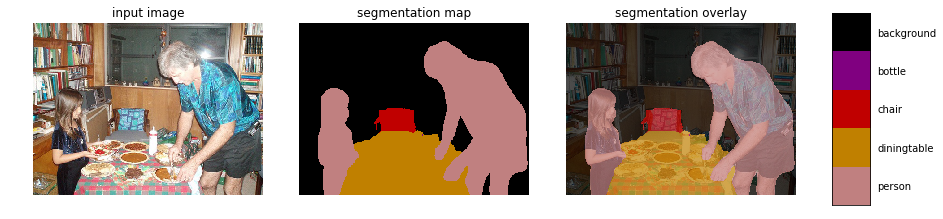

In [33]:
run_visualization(img_path)data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA68AAADbCAYAAACCw6ejAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAIABJREFUeJzsvXmYJdlZn/l+Z4nl3ps3s6qyqruqN6nVSCCEWsIsBssWIAazaQAPYxDYII9ZbDYDwzOewQxgD8xjsDHGFotZPKxi0yAGMDZGYMwqDAjtQlsv6u7qrupasjLvEss555s/TtysVNGihdTtru6ON5/75L2xnjgRcSJ+51uOqCojIyMjIyMjIyMjIyMjI9cz5okuwMjIyMjIyMjIyMjIyMjIozGK15GRkZGRkZGRkZGRkZHrnlG8joyMjIyMjIyMjIyMjFz3jOJ1ZGRkZGRkZGRkZGRk5LpnFK8jIyMjIyMjIyMjIyMj1z2jeB0ZGRkZGRkZGRkZGRm57hnF61MAEXmLiHzCE10OABFZiMjtT3Q5RkZGntyIyH8UkS9+ossxMjLyxPFUaAdE5B4R+eQnuhwjI08VZBzndeT9RUR+FLhfVb/piS7LyMjI9YuI/Bbwk6r6w+/n8t8K3KGqf+fxLNfIyMh/P8Z2ICMi9wBfoqqveaLLMjLyVGC0vI6MjIyMjIyMjIw8hoiIe6LLMDLyVGQUr08BjrqkiMi3isjPiciPi8jB4FL8Udcs+3+IyFtF5LKI/D8iUg3zXi4iv3vNtlVE7hCRLwO+EPjfBtfgX34fZVERuWP4/qMi8n2D289CRH5PRG4UkX897PvPROSFR9b930Xk3UO53yoin3NknhWR7xKRCyJyt4h81bAvN8zfFpEfEZEHReQBEfk2EbGPXS2PjPz3Q0T+8XAdH4jI20XkJcN0c+Q+uTjc68ePrPdFInLvMO//fIS24edF5CeH7b5JRJ49tAfnReQ+EfmUI9t6n/fUpq0QkX853Mt3i8inDfO+HfjrwCuG+/4Vw/TvGfaxLyJ/IiJ/fZj+qcA3Ap83LP+GYfpviciXHDnubxqO7fzQvm0P854xtAVfLCLvGdqIf/IX1O1j2S69fFj/34rIlWHdl3xwZ39kJDO2A49rO7A9rP/wsL1vGrZfisieiDzvyLInRWQtIqeG358pIq8flvt9EXn+kWXvGc7bG4GlXCNgReRjROQPhnUfFJFXiEgxzPteEfmua5b/ZRH52vfrghkZeZowitenJv8j8DPADvBLwCuumf+FwN8EngU8G3hUN2BV/UHgp4DvVNWZqr70/SzL3x62vwu0wB8Arxt+vwr4V0eWfTf5YbcN/FPgJ0Xk9DDvS4FPA14AfCTw2dfs58eAANwBvBD4FOBL3s8yjoxcN4jIc4CvAj5aVbfI9+o9w+yvIV/7LwbOAJeB7x3Wey7wfeT7+zT5Prrpms2/FPgJ4Bjwp8CvkZ8DNwH/DPh3R5Z9tHvqY4G3k+/l7wR+REREVf8J8DvAVw1txVcNy/8R+f49DrwS+HkRqVT1PwH/N/Czw/J3PkK1vHz4fCJwOzDjz7drLwKeA7wE+GYR+bBH2M6Gx6pd2tTDXcO63wL8wlEhMTLygTC2A497O/Bvh7q5nVyPXwT8PVVtgV8AXnZk2b8N/FdVPS8iHwn8e+DLgRNDXf2SiJRHln8Z8BnAjqqGa/Ybga8b6uvjhnJ+xTDvx4CXiYgBEJHdYf5Pv49jGBl5eqKq4+dJ/iE/0D55+P6twGuOzHsusL5m2X9w5PenA+8evr8c+N1rtq3kGBSAHwW+7VHKcu3yP3Rk3lcDbzvy+yOAvb9gW68HPmv4/pvAlx+Z98nDvhxwA/kFtD4y/2XAf3miz834GT9/2Q/5JfH8cI37a+a9DXjJkd+ngX64D74Z+Okj8yZAd03b8OtH5r8UWAB2+L013FM7j3ZPDW3Fu67ZlwI3Dr9/ixzj9Rcd52XgziNl+8lr5h9uA/gN4CuOzHvOkeN+xrDvm4/M/2/A57+P/T6W7dLLgbMM+SOO7PvvPtHX0fh5cn/GduBw/mPeDgB2OK7nHpn25cBvDd8/GbjryLzfA75o+P79wP91zfbeDrx4+H4P8L9cM/+eTf0/Qlm+Fnj1Nef2fxi+fxXwq0/0tTh+xs/19hn98Z+aPHTk+wqoRMTp1R7A+47Mv5fcc/t4ce7I9/Uj/J5tfojIFwFfT34IMczbHb6f4b3LffT7bYAHHhSRzTRzzTIjI08KVPVdg5vYtwIfLiK/Bny9qp4lX+uvFpF0ZJVIfsl8r3tEVVcicvGazV97/11Q1XjkN+T77gyPfk8dtjPDvjbrPiIi8r+SLTZnyC+Zc67e34/GGXJbteFernZc/bnykNu991kWHrt2CeABVT2a+fDxblNHngaM7cAj8li1A7tA8Qjb2liofxOoReRjh+29AHj1MO824ItF5KuPrFvw3vf8+3z3EJFnkz07Poos9h3wJ0cW+THg7wC/Pvz/nve1rZEPDhG5bjPWqqo8+lJPX0a34acntxz5fivZcgCwJDemAIjIjdes97jd6CJyG/BD5J7GE6q6A7wZ2NzADwI3H1nl6DHcR+5F3VXVneEzV9UPf7zKOzLyeKKqr1TVF5FflBT4jmHWfcCnHbnOd1S1UtUHuOYeEZGa7Nb2gfDB3lPv1VYMcW3/mOx+d2y4v69w9f5+tLZl88K+4VayK+O5R178seH9aJcAbpIjb/a8d5s6MvIBM7YDf47Hqh24QLbYXrutBwBUNQE/R7YyfwHwK6p6MCx3H/Dt19T9RFWPuvb+Rcfx/cCfAR+iqnNynO/R9uMngc8SkTuBDwN+8S95bCMjT3lG8fr05CtF5OYhLusbgZ8dpr+B3MP7AslJnL71mvXOkeNDHg+m5Ab/YQAR+XvA847M/zngH4nITSKyQ34AAqCqDwL/GfguEZkPSReeJSIvfpzKOjLyuCEizxGRTxpiqBqyJWRjFfkB4NsHUbVJJPJZw7xXAS8VkY8fEoD8U977pej95jG4p65tK7bIL5kPA05EvplscTm6/DM2sV6PwE8DXycizxSRGVdj466NJ3usebR2CeAU8DUi4kXkfya/cP7q41yukac4YzvwiDwm7cBgZf45ch1uDfX49WThuOGVwOeRY4dfeWT6DwH/QEQ+VjJTEfkMEdl6P3e/BewDCxH5UOAfXlO2+8lxwT8B/L+quv7zmxgZeXozitenJ68kP5DuGj7fBqCq7yAna3gN8E7gd69Z70eA5w5Z8h7T3kBVfSvwXeTEKefIcWe/d2SRHxrK/EZygolfJT8ENw/zLyK77ryVHEPzKnIc0MjIk40S+Odk68BDZHH0jcO87yEnYfvPInIAvJacMAVVfQs5fvNnyNaXA3LMXPsBluODuae+B/hcyRlI/w05Icx/BN5Bds9reG/Xup8f/l8Ukdc9wvb+Pfll7reBu4f1v/oRlntMeT/aJYA/BD6EfL6+HfhcVb3WTXNk5C/L2A78eR7LduCryd5md5HfdV45bB8AVf3DYf6Zocyb6X9MTiD5CnJ9vIsc+/v+8g1ka+4B+b3mZx9hmR8jtzU/8ZfY7sjI0wZ571Cdkac68hQZLFtyOv4fUNXbHnXhkZGnIYNlYo/snnb3E12epyIi8nJye/qiJ7osIyOPxNgOPPkQkb9BtgI/Y3BhHnkcGGNen7yMlteRJwUiUovIp4uIE5GbyENSvPrR1hsZeTohIi8VkYmITIF/CbyJq8NrjIyMPA0Y24EnLyLigX8E/PAoXEdGHplRvI48WRBy7M5lstvw28hDAoyMjFzls8hJTc6SXVk/X0f3mpGRpxtjO/AkZBiTdo/slv2vn+DijIxct4xuwyMjIyMjIyMjIyMjTxtGt+EnL6PldWRkZGRkZGRkZGRkZOS6ZxSvIyMjIyMjIyMjIyMjI9c97okuAMDf/eQX6Nd92ZfRv/Aj+Zbv/Bc8/xNv455Kua28g/3LZ7jx/B9y95/8Hqc/5W8xv7BmNhde/7Z7+P173sSNJ3bZe8s7+ZK/8rHsHbyDxHHuvHyJ7oYTfP8NH8pfueFDqe97Fy972Uu48PZ7eNt/+kWq5m66umZ5YUVc9DCteEe35o4XfyadKSldZC4GVkv+xqd/IdEKzfIiviiZGEc13ebvf+Xf5/hszvLhBdP5hN1jM/7b7/wWsUskmzgunp2tKeVWwXFfEoCiDfRF5PY7buPEbsnu9hahaynqmiYlfFGQeuHyYsHqwBBNwZ0v+TwOrGAEXvXTP84b3/xWrC3oQ0C8pelaCl8TQ4t3jiZG6smUpm0pnMfGhKiSFLBCXc+IMQKCLQQBCmfRpIixhBCpSk8IPVGUYjahMp6ui1jnCSjSJ+ZVTd90WG8BwYgQjRD7nrIsiSkRNBKNxfmCvm+pygJUSCKQLGKFSVXSLg6YHK+YHvQ81Cw4fuwGFouOrePbLBYLJkWFBZIqai3iEyYpBotIAdbTtS1FOaEsE6Fv0aQoSl3XhBiIMWGtwwiAQxBiCtSVR3A4V7DQBrCkLmGMxdoCkoIY+v6APkS8L4gx0rQNVVVhxBBDj/OeRduwXq4I64Zn3nYbqxhQb5Go7J44wfJgQUyJPgYwgrOGskgsFgkplKJLBAvTac1vv/qX+fCPvoOP3ArsbO1QVRVRoJyW+Xz1gXWrbM1mvOn3f4dFXPPiF/81ysmE7//h/48zf/VFpHqXv/k/fQE3OsPxm26jvbLmBhf5pe97BXOXeOf8BM963h2cljX3r6fYrYrbbzzFW97wZu58wZ3c+swPva7cVq5nF5+Rkacr16N7280nt/VZt91G2t7m7e96F/PdCSsDEzOh7yuqdo/VlUuUJ0/ju4h1sL9YcWl1QFkU9AdLbtveoQ9LFM9235PKgnvKGdvlDLtectNNu3TLNYvzD2LiimQtsYtoSOAsixSZnrgBFYMRxSEQIydO3YSKEGOHMQaLYJznDW96Pd46YhexzlJ4y96li/lZJlAgeOcwTvDGooCJiWSU6XRCURgK70gpYawlqSLGQII+BkIQwDA/eYYg+ZQ9+MB97B8cIJhheSGmhBGDasrPdcBaS4oJMYIoiCoKIIK1lhx+JmxGZzUieXRkEVQVY/J/RTHOYjCklPenAAm8NYf7gPxuogKaFGMMiuZtiCCb8pm8QyUvLCJYa0ghYL3BRqWNAe/L/A7gPTEErLF5+yiIgEAuiSAYEENKEWMsxoBqYhNitzleVUVkc+nL8MnHKuQyBlKenvJ+RAwMdaUaSKpDXSsxJawxQ53lcxBSJMaIxsSkromqYHLdFoUnhoiqklTzMYhgjRICYBSTch1aa7j40Dm2dqbsOMU5jzUmX0PO5POVlJjAOcv+pUtEjZzYPY6xlnvufYjq2HHUFpw6fTOlQFFPiH2kFOXcPXfjRFm6gsl8SkVkHR3iDNOq5ODKAfPtOb/+mt+87tqKkScn14V4ratj3H/fuzlxx7P4gs/9W7zn4dcjqeWguYK/+eN44+//LDfOJpSdUBYVokuC9azXgXJWYSQxm9bEtWXV9axDAxI5Md9GU8SWHk1QFFn07c62OL9uKApLKJXGRPo2MBGHGp/FhSRuue2ZxHpCY2D7+K2UxnH+3XehVc2zn/dc3vanb+CmEzeCi7ThgM9/2eewXC3YO38Jufch1m3LQeyxLnBwZQFuips7XFkCgjEGg7Ber3Bbc4gdqQ9sFQbjlMvNml4DKyxNGyhP3MiLPukWLp+/yOLKPv26IcSIcx5xufFpu54m9Zw5cZoYAoUY1ikgRnJDGRLeOCQmvLd0ThDvc2PddhTbFYvFPjsnTtC2DbaucRi8UUJUJlWJFik3zrVDXX7oFXVNu1zgplNcXYIqBoN1Beu2Y1pNmViDFUfX9JQzxThH37TMtmY0ocdPttiaTDhoAjhPvb3F5NgO/WpN5Qp84VFriKI4FZzJDytXZgEN4MsJooY+9HjnqOqK0peEEHHeYUSwpgDAOkOKkXoyoVm3qCjOORRwzhBjRETzgzBZvLe0XY8xSt8HvPfEGEgxsFg3aJlfHPplh7cWnOGgWWGloF831EVF23dEVYw1dE1Ds1zQBo9TR7NYQlWyv1hwsFxSFyWh7xGx1HXNol1hraEPLd7kh7S15Ae4Wuqipu16qtkJbr31Gbz+nQ9QqmL7iHGei+ESrYk84zM+kVMW7nvt2ygSnD/YQ+fbrJsVfR8oJhVdiu/zfh0ZGRm5nrHGs14vKaYTbjp9mnW3j2gipICpJ+xfOktpLSbl9lOIJDHEqBhnEBTnLJqEmJSoEVAK5wAdBFYWaSnl6W1MWaQZQ0TRpFiEiCEN69f1BLWWKOCLGoPQrlZ4a5lubbG4sk9VlCBK0sBNN50mxEDfdsi6JcZE0JSPJUQQi1iTRSqwEX0xBozzMIgua7JA61MkqRIFYlJMUXJ8t6ZvO0If0BQHUWY2j1RSSiRVXFVmIYoQOdKPqHooVo0IScgCC4GUEGuJocf7gpQiYmyWiELel7m6L2z+roAxlhRDPj5rDo9OJJ8TKxYrWSimpBiXy51iwrss3o11OGsJMXdCW+9w3pNixIjBGMlikUF+DuUwRgCf9zkI3TQcp7EGI3YouwzrDeUbxLq1lhjTcK1s5nEogFFFVPJ7WUqIkI9hI/JVs2gdrrMUckcCAiHF3NmQsnhPKeXqE9CY6EMgqcn1EiIYQwiBECLWGFIKCFmEhxQREZImzCB+RTb1IBixeT+uoK4nXFk2GBQZOiZ6jSRR6ht2KQXWlw8wCm0I4D0pxdxJYfN74sjIY8V1IV7trOJd997Ns6qSikiz6ugq6HVBpy3Pes6d6N2/g2kDi709Puw5pzHTK5TbO1iEsGx54OIFJkExIdBKotaETTH3ghlHjInVes3WbMpy7yw7x3bZ6y+hFaSoFLZgUk04iIovpvjUI86yMz/O2YcfxnnLsdmEK01ktVrx9V/7Dbzie76bc3ffx9b2Fj6tODGfcPHsuzhjSiYO8FOaEzPuv3KO7d0pqysdvhEKjVTFlNVqhR16FiVGjLWUhWPVHuSeNyI2rJAIpSpTZzh7/wOkNiEWrqQV6g1Be2gi1gq2sERgbTva0FKIpU4mi63a0xtlTYerHY2JePGYECAlqqqm61q2plOsJqaVp02R1HfUrsQDfbuiriuMCKFNlGWBtYJYZefYFl3X5XJgsGJw3lK7ElLCRjAEap/91U2Eupxik1JPJtSdozcRS0/fd/TLA8qqpF1e4cSp08PxOcQ5CmuHzogOU1gK7wCD+AkYR2EdYgyFq/IDgYgvPCEF6nKLEGNuwJ3gbMFkrhQp5J5YI4gzxD5QFg5UaUXY3d1lb+8ifR/oQ8A7QwwBYwy32Zq91QFd16PHFYthuVgxm0yIMdKVnsI5Lu1fYctNaJoVLgrBeJwULFZ7TL1nFSKV89yws0NtQEzB1tY2IBSuyNZjoPKO1brBFx5iIvSKOEOFYff0zdz9ngcoqhrTRpaSmPQRH5W4XjP1NXusKY1jd2vO6+99M/Pt2zBGWDcL7LRCSv/ENQgjIyMjHwTiDMv1iqmxWJQUE8lA0gCamMzmsLqEJCX0PVuzErE9xmevHI2Jdddhk2bPJcCiCDoIBYMqxJRwzhL6Bu8L+r5HLYOQMzhriZqFmBmsZt4VxK5FRPAuC6sYI8+6/VncfdddtKs1zjkMEe8sXbOkEoMVwFlSUbLuW3xhiX3CRDAoxlhiDFl4KFkgiQzW1JDrBUU0QgKrYEVo101+BxHoNA5iLsIwbWMdjaKHIsem3BkuVlCBSEKMIYlmgamaRa3NFkxnHYJmqyiKpoQVO1hW87uPcNXKKiIgijMOTSkfB4PANNnTi0FECZrrBhAFbywA1oJNmzIlUkpoyGI4xZ6irHJZjYARzGBQSDpYmGWwABsLkucjghHDppLNYBSwxh0K0yz+DNZlCzVHrLsMVmgUkgwGlb7PZRvOV/4PTix9DKSk4HO9hhix5H3pYKXu+x6MkGIkKVm4qiHGHmskd5aLofQeSy6bc/n5bsQMdZutrzHm84hCSiAGLEJRVqzWTe4oT5qt8SnXv8aYy0rEYCicY399gPM1CMQUEGeGDo2RkceG60K8TrcqMAbbw4nJjNnuabTYI6wbbjs+4XwLN04qWh+ITUM1mzFzgvOWKYbv/s5/wVt+97eR9zzMOQIfUk1xrTArCrzLDU9UxZeWLnbs1BVdiLQx90RVGLwmYmlxajFNR/IJUZj4golx1MZROodYZWYqNChtE3n2c5+HKeGhP3szRQq05x9i96YPo7YlNhr89o2cbS4zqWtcXCKrfarBTyaIUvgCDXHorbJ45yiKbfYWV7DiwVgkJcKy5T0XLxEVlqsDJlXJ1JWsmpaJL3Ij0SVEIs5aNDTYGDlYXEHnx0Bgf2/B1nSC9JFu0WONpfUBU2R34XXXE0LAlzZbHVF6A4V4LneX0Zgoy5JFc0BKiaqq2Dt7IbugWIP3jhB6RMzQqA1deM6iRujJri9GlLSeILFlWhT4GJDWMJ+foLRC1/VY4zF4al9zqb3Ae+59D1VVDS41ESP5NcJUFYijKDxN2+O8w3lYLZcY64ht7um1BRwcXMGVBaoWEYdzQllWhNBjbYEj93QmHNPJlKbpKXyFxoidWEIfco+qxvzSEwJlWWZXneG1pqxK+q5HUu4RLcqCLnaHD95AQnvou0Dul3ckLPVkjhPLifkOhSjvcSUuKomEsw4luzwN7wSEmMjGUaX0Dgkd5cSzd/EK2ydOEKs5e+uG1kS0MJi64OTJY1y57xKv/Q+/gXQNJ5/3Quq6oKDAiwHv2Z7NCRg844NmZGTkyYl12RtHFArrcEUFpkdjoi4sXYLSGpLRQTw5nGRR5IAPf+5zObh4EVl3rElMrUUS2I2wIrucbjya/OCmmzSLWyOCqKAm/ycl1Cho3oaV/NlY0ywbwaDMtrbAQLs4wGgitQ1FtYUVg6hgXEkT+yz4NEAMh8lLVLIgYRDZaXClNc7Thx4Gt1Q0C/p112VhGgPWGpyYQ7dhyGISBstqiogqIUYYxE/oI85ZSKAb4bsRvKrEkIaQpGyFBEiAQei1zyLfGEgB1eze2jfdYAGUQ3F4+DTaeKgP+1GylROAaEED1pjcUZAEN7jEJjbWUcGKpUsd69UaY/O0TdmAq2J1sPBmsUzu8BYZ6iS7SIfQDy7NciiEjcluwDJYwbMlObtXp3TVTVisvJdgBQYXa3PECXmzvcH/V7MV8+jwrwoQNYvcqxIfY3NHTOE8MlwXohtvbtlUIwzvFNktm8PzLQLGGvquwxcFah19TKRNB781lIWnX3dcOv8wkhLF1jbWGrLUFxCDty4fx/hOMfIYcl0kbOqayLn7zjGtCs6cvoXoa2ZLw7R3ON1nfvtz2N3a5qGDs6RpweU+sWMix6zDrAP33H8/TUxMZzs8bAMnJscp12DalqiCr2v60JNSoKjLbK1Tg7eCCT2mD9i+owotvl0xG3oIlwcHlNahKRAEOgsH3rBVVRTi2J7Mmc+3eN5HvJAYhEoMJ6Y1qahRM4FOSaue1RpufsYzmU4800kJxMMmxjoLkl1LamnR1T6hWVAYS4oRxeBcSVnV7HhDIQEnkWJiuby6TLCRRViz3xwQNNB0a5brBYtmSRs71t2aFHti7MFEFv2KRb/CzioOtEd9Sdso3k5JahFKUnTEYEnJ0S8DfRfRZFFxaBJSD5IsfRtxrsJaj2LpeojRYm1FMhVSTSjqKc55vKmwscB1gl5pqcIeU7dmWvYcLB7mw5//oTx04Xx2ZxLoU09ROlxhWfYNJ246xX3nHqDVnkUT2Vu1HISOi6s9LjeXuLC8wEFzkct7lznYv0LbrWkO9rP7lxW8wInjO0ymuTyTSUlVVVRVgXGWyWyCr7bxfoZ3ntQFdrYmONsxmRokRApnKCQ7Ex2bzKl9iUmCw4BzmMFlqaoqytrjJx41iXk1wQuErqFZ7rPa36Nd7NNcucJiseTK5Yv0/ZqLF84xrWtmVcl2aZm7NPQCgzGKMeALT1EUCI66nmCcAIlyUmOLgv39PZ79ER/FmeM3YeoZ3hds25pjrTKxwsHDDzGPwqoNHLvpRkJsWWpir22Y+4qz585x8thJTLoumoaRkZGRvzQalXbdYo1QVTVqDDaCVcFoj5vMKJynDQ1qDb2CF82deFFZr5tsbXWejuyZZSJISvlF3OY8EWjCDGIiu7SSBUZSRBNGE5IijuzyGkMYXGxTNo4KBAPOZldabx3OOebz7SzmRCicBWOBQSTGHJtYTSZZcNosVjdcjcMEQ4IY0LjZbxY42WXW4o1gSIgoxgp97EmiBI2EwRMppUSMkZAiiUQcXItVE4jmuEwN4AxRExibrXbiBrGZBaImQTVbtVUVNHf4aq7G7OYas+vvRmimBKqCiEXJ9SDWDoLSImqQJNAnjPZYk3BGCbFjaz6jHcS5QrYaGzNYoiO+Klm3DYlEiEoYXLK72NPHjjZ2hNTR97lTP6VICtmCPRhrKQqPHZ791tocCjZ0EFhnEesQY3NnQFK8s4gkrMvWaSOSvdDInSx2EJgb4bfpJjHGYqwM7tOK28TspkQKPTH0pBCIfXYP7vsOTZGua7HW4ozBGcFJjjse7pIcJzsIbsjHIBursrU5bjf0TOc7VL5ChmP0YvEJrEDoWrxmoe+rEtVEJF8X3hiatqX0xeN0p488XbkuLK+XV1Amw6I5YPuW53DDbM6F8w/RHUR2PvUUd7/+fu6opsz2G9pym9pOaEvlVFGz6pYc7O9R72zT7d2HW/esZomiKiiLkoP9fbaAtm3pupZqWmIOHMYItTGsShD1VHtL7APnmd94kpWLuA7W2tL1HWVV5ViBkDAdSCG0fcfJkye4cfc4D93/AF3Xcf7h85RbJa4QCD3TusqWr75nVhfsVQGKKY1GpqIYlL5riCFhvIOQUANePOuDy6h4NHRoUYJLNCSkKtDKs+4DB8s1p07tUIrh2M1nuHT+MlPnuHLlCoihns7wxYQuBpImrCuzpXm2Rb/umRUz2qbBlJ799T4pZlugJSdtsJLdbtftmrKuCH0cel85tIB2fUc9mQ69xrm3dLF/BYzB+4JutcB7jxhPjLB3PgLPAAAgAElEQVTYb7ntzEnOPvgQ67ajKkr61Zo3vvHNPPPUKQ4U2lXL9vYORKVrAqUrWK3WLNcNd991D35S0azXRE3U0ylVXaExEdqGpCXOZxunRsW7CSkmjE2oRHoMRnyOmTE51qPwBSEoKgFUceKwGDSl/GITerS0NKs106qi7wJGDG3XEWNiUk+40i6wXWR7a85qvabpW7bm2/mhP7xb+MJnq60xSEhon6hLQ99Z5rHixNYOvQZOzGZMZ1PmsxqvgAQYOlQg5YciCWNy3HLpC8K6Jwbo15F/9d3fx4njN3DbS/4aYdXjd+dEVRyJuFrhnKWxYGYlRWUI1jE9Nmd3a4f7H3yAYmvK5QsXn8AWYWRkZOQDp4tQkV0WXT2jHJL6paD4UyWr/Yaptdg+kqzDiiUaKI0hppi9cZwj9VmIBqtDrGN+mXdkl+GUUm6XQ7ayWYRoskC0Pci6w1cFQbKL5WadLAyylpTBPTNpoigKysLTrBtSSrRti7EmJ0LSwe1Wsk+ns0IwmsWiKm5j2dSYNaoxWRWyEc49kKepGDBKIlvySIaYsoArnM9CunB0bY+1QhhEm7UOEUfaWP4Gt1NrHCmm4X9+xoUYrlog02CpHuIoY4qHFsoEg0VQB2/nXD9X9fim7JJdkzdCfHDdDqGnrgraps1WY2PQGNnf32dS5mSZKSa89zCIcSM5p0WMidVyhVhLGkS5dW7II5FdmhUzxDinwR3c5vM2CEEdTBEbuyfkmNl09cAO3Z43C6XBhTzGiDNDsizk0H3YWkufsoeXdy6XVRPO+SFpFYPVWq5W0+Aqbod9O7UUzpNI2fvA2SyeGcrF1Rjfq/91sHgbNGZLbIrKXXfdg/clk91jaFSkMIdHrjEiApHsrp/LJFjvKJxn3TaIs/Rd/8He1iMjh1wX4tUYS2MajE2w7PmkZ38M8d2XubirxPaA1dIwq2vCfWvSmcDDFy4hXkid0leRcw+f5YXP/1jufdef4INSb01ZXzzApMSsnqDtHl4tV1QpZtukWHAQlziXe/j6Vcc0CkVzwPmLPenkLhNKrDcgii8KXvfaP+JTXvqprBf7OPGIBesLPuavfgyv/aPXcbDqwDjECuu+pYxrkt0hGM9WUZAWS6pZTbuK9LEbXD8U50v61ObMdr5iVjkW+/uU05p+EbDeEa2BLlHagpDCEKviuP2ZdwwizHJl3XP85Cm2plN2z9zMg+fP4Zyl8BMSAV8UNF1D4XO8RD2dogqlnQ2ZgEusZJce6wtiCsQIpSZ8qsAbpuLQPlBYixpLG1tmZTE8VO0Q35EfCs773NZvTTYnGVuWpBhZGOHYzbewYz3lcsHZxUU+4eM+nj/4r79B10duPXkH9165zK233sSsKLBGmJQlZ87cRFVuEaUhieC8I/W5V9iKJQHqPNaANyDG0cWYRawVuq7DlBXiLCkESuchJIz3YBwxrVAVzp+7wE1nbgbNMSDqDJDjglEh9C311hZNs+b8uYc5eeokB+98J/WkxFhLTIkTuyc5vrvL/fe+B9rI1nwOKXJs+ziqynQ6pV13dEXPwYUFdTkhGoN0SmE8WIc39dCJAc57xGSXpzgkXrCV5hcLEabzLUxRsn9pxbHqFEV5nBtvuAUpYFo5VpUwUc/KJm78mI/g3je+EVt4bOhRdRTFjKpITKyna3u8r564BmFkZGTkg0BEiKQhVkPZne2gq46uAI2BGARnLBoi6pS265BB66lV2q5he36M1fIKRhXrLLHPiW6ctRB7DEIAxDloDEHzSzwiaFQsYFKg7RIURXacHLxURQx7l/c4dcMpYgiDU2WONzx27BiX964cJhnKcYMJoxHEoyI4YyBEjDOkmGNRD+MwxRIlDsrYYH22+FprCWFwU80+xVnE6eAJJsJkMhmEmdBHpShKnLMkzQaA/AyCTSKiNOQVUbKVOos7l0N7rDt0yBUxKClbkwHRHAMpWckNYlSIGjHGH57DjTLbuNOioM5ePc8m9wxHsoedQ7Ax0oSO3WPHuXTxApqUupyy7jvquj5M9GiNySMGGJdjfAe3381IBbKxe4rJLrS5UFl4Dkl/U8qW5rxeOowJzeUaYoeBtu2oyvrwWI4EJuflUsQ6R0wpj5xQlITlIrtES7ZOF0WZ3+NWa0g5uSSqgyi/mhE6GSV0OaOykjtHjMvWYBE7dARwJKvz1TjbHOubS2W9y8meuog3BcZ4yrIGA84YohkMHaKUO3NW+/tDvGyuS2McxjAYAvTQFX3kg0dEngH8iqo+74PYxicA36Cqn/kYFesxQ0R+lHx8r3pfy1wXV1NdGW6YTXjPO98BM0/qE/Pbn4mtKlzsOVc79rsVURXdqmibBbu2pih8dotddsx3djFlFnetywLCFJGLzRVMVbFcrjh/8Tx3PXSWB5pItzMHMTgsViy+LOicoSgqJm5CioG2XdO1Lajwwhe8kP3lktA2NM0STbB9fIef/pmf4R3vuhvra+4/e45pNUOKmj4Guran7yOrpqGeTUlJKJ3P6e6twZcFKrm3sSprSu8I/Zq6quhSS11VOJszIDoszjpc0pyKPyZCSOjQi1dPa6JGzj/8MAcH+5ghkYJ1NveuGqEqS/oY8GWJGCVJ9vswGLanW9llydphXaGoC4iJoipREfqYKMvsJizGUNZTxHiKssJYB9YhzmLLAhVBraGeTXHe453PWf+SUlQTXDWlTYYw38GaOXuu4sbTt3Lmltt4y9v/mJ1tRxQlBIeYmtW6Ra2y6q/gqxqs5WC1IsQc42ILi5QW5zjcTxdCtkzWBUET1WSa3ZOMUFRl7u0Wck+uAcRSz7ZwRc4olVIiWWhDR0ownU7puxaM4eyD99OFntnWlP3Llzl+bIey9EhSdrZ3aFZrLp27wFY54fiJ46hGirLgwv5lghXu37/EvgkcLBd4W1L6kgTszOaELp+jsijZmswJMfe45od37n33hacqLDaCKz1iA1Z69g4eZr+7wEoDp8/cgKkgdgcEVYx49lctaT6n18C8qNHQcfNNN7NTz1mHlisXL/POP/ozHnrng09wqzAyMjLygWENlM6yXizAZUHiJpPs9aJKa3OmVAVw2ZpXkF0iY8rD3ThXHGZJTUOSHYzSxZAz6MZI27Ws2pYmKcm7IbFP1szGGJLk/3bITpuzr2ar5fZ8O1snUyKmgJI7KR84+wCL5QoRw7pps7VzY6VMOYY0poRxFtWNC/AgToYhZRj2b80w7Iqx2fvKmkNRaDZxmpCHclHdeBVn8WItitK2Xba8DtM3CZw2MZFpIywBzT6vMLhAmyF29DB7rTVD0qJheT2SoIls2WU4HhkErQzxlRs3641r62aZpGRLtrEkhOSydbgXQ1XVVHXNwWIP7w0qStI8FE5MaegYyPHDSE6ItBGuh4mchCHHhg7Hmo8jkbMZbzCb2FvZCNTNMbsj2Zt1sLzma8BZh6YcK9w0zWDJd4S+w3ufE44q+CFDct92OGMpimxFNtbQhR4VaEJHECXE7Bm2EYve5lEQZHBpdtYdZpSWTUfEcJ2abK8ZxHdCSPShpU8dEaUa3pt0k9wSQ4gJdQ5Fc6eK5uSf3jqiJkLfsdhb0Cybx+r2HnmCkcwTqh+vC/G6dfokl1vD5fvOs7NMPHRpn2ffeDNN6DhxuWH72DZzphizYKs4ie8bmsozKRI0yn2XL/ILP/dT7F1Zc2ZrClXBpUL47A+5ldTvEZiyHzoeeM87qKWneuaHsFinbN0Sg/We9aTmDRcu8Y53P8ylu67Qx0BRFBgjeO9YrJbZSrsOrE2PpMgLnn8n+/c/zNnLF5hMtrjU90yKLUQKQjXF20jZNaxdwdrq4FchWOuxxtG2HdZnYVgWBckI5SQL3xxHAzFGCl8SQkLE5WRD0aHJEJIyne/QO4M9dC/JQ7cUapj5EgPUO3PWKdCkQGCIKdV4mKHOesdyvQI7uKAYwRWO1WqJL3OsQlVVFGWBeIctC1xV4ryjLn1O8uQ91loKn0WWsQZfF1w5OMAUnjZli+3EO5wqxiypwwIfe26te/QXfpxP342YN/wKn3HrjJ22QTCswoIkK4w34Kc4JqzbhhD6nMDJmpxkaRN/okIhhtoVVJLHk9OUmE9mpD4w25pQuDzEjXeeyXSCOI8xjuAti+WSaT3FFAVaO7Qw1FVJVZakqGxtbVO4guM7u4ReaZYtXRcpTYGIQ6qCYlIh1uCNwQHLbsXW8S3mO1ucOnGciS/YMQVzLLOdHcRbXFmB88O5F2xZ0KdAMZlSFBPCkNXY2PyyYo1g7BztSzR4JidPgnGc21uzfeJm+n7J8599B/PkqFPBXAw+KVU0FGKYlAVxecBeu2KyNaWMgRtOn2S1d5EH3/oAD7zpnieqORgZGRn5oHBVSZ+EvunwAdo+MC3zOJlFn4dN83msApwpMZqINo+RSYJ13/Hg2fvp+0jlLBhDZ+D0tEa1J2HpU6JZL7EkzGRKGJ7vm3jFaA37Xc9y2dGtwqHIy8JWiDHA4CqayFmNt+dz+nVH02fR2mt2xUUMydocm5oSUbIw3lgmNwmONiLlMNHPIBhzfOqQmEc3VlMG19shA4dmIWidz0mXOJJMSBMGwQ1xmNY74pCgamM/1I1P7JCEKMR4KHg3sZVxcCmGIQPzEIMqJg+Hky2ickRc5bFRN0PkGGvyGPeDq60RycPlqCISsRowqtRW4cH7OVUo7J/jhtriU7YIRg3AxkqeA6ViTEfGjZVD/9+jyZOM5DF5N8forQPN2aaNbMZmlUNrqUhO2BVjzILbGNRki7O15tBt2jmPkRxmld10IyltEm8Z2AwVdKRjJKR8DTvnchZhMXgMDsleb0NHBpJFtmw6NjTHshpjr7p0y9VODBEPakAFW5YgQhsSvqjRFJjPpjjNBg+HYFQxKsMQhAYNgT7lcYqNKmVZEPue9qCh2V8/3rf90w0nIj8mIm8UkVeJyEREvllE/khE3iwiPyhDr5CI3CEirxGRN4jI60TkWUc3JCIfLSJ/KiK3i8hJEfn1Ybl/JyL3isiuiDxDRN4mIt8HvA64RUReJiJvGvb3HUe2tzjy/XMHSyoi8qMi8m9E5PdF5C4R+dxhuojIK0TkrSLyH4BTj3bw14V43TbH+Ywv/Rqe/9mfw7sePMsLb38O0Qc+++P/Bs3Z+5ndOCO5grpb42zJwWrBSWpOFJ5l37PcqnjTa1+L9RXtIsdYTm89je7vsesM0sBWD6w6JgKr0FPUecyxZJQgieAMs1NnSJTcfOOtgOXgYIE1Flt4mralric4HHbiWC8WnH3oIb72H34lfj5hNp1BNWW9bBHjUFsgTtEQ0LRxwSlyLEtMJGAymeC9Z2s6pW07jBNi1CEo3rNuWmTo2fLO0XVtbkCdxYnBGsOqbbIrSduybJo8KLYV/CSLYqzNcTNDQ+a8w1uHNQ5nLL4oc8C+s3k8uxSz5VUTZeGzS60mwpCOvQuBZE0eEiAluj5n2+u6bojLyL3DCIS2Y76d4z7LoqDre5q2zQ/tVYkc26WsS+68ac4tzzvB/q7waS94HreWB1S6jzOWqtzBScFy2eCcYH2HNZa6qjEqOcGBZJedECK2yIOQpxARm+tIENrQ4byjWa9ZN0tUE4um4WC1pAuRLgXuv/9B6nLCarFitVgC+cFITCxXSx544AH29vY4ODjgYP+A2AVmsy3KoiKsW0AoioqmC0ynU2Lo6LsWW1iapmPZNlxZL0keWqtcWO3TdR0gzOdb+WZQ6NqWGDrqsqAqsyuyGpM7CMxgtbeeVDRokTB+Ru234aCnWRwwORbYXyw5dfI0D19e8sBizcNNAGNYxyVmAr6s6VMkhEhVFpQSkGbF7rEJtzxzxqmbxgQLIyMjT06ceG649ZnMb7yRZduwPZmBUU4fP05sGlzlUDHYlIZnbKDEUphhXFdn2b98OYukkMcEtXWFhp5CQCI4BWLCMoyZajcJkbIFUkWwZYViqMsaEEKIh4IsppRFDQaxWeQ0bcvtz3gGxtnsFmosKSTYJPDZWPU0G0uN2cRJ5uO2NicHcs4ejh+qg5lUxBxafXUTLzkscyhgBhdlMbl8MaUsSgfhOCicw2f8xtXWHBGYYjaiU66K5UOXZmFjsNHB1TlprqtNZuNN1txN/OfmD3KCIu/9YLHN626WIxrwBcYa5pWjmheEAk5tb1GbiNGAQbDGI5g8LIyAmDQIY3tYB3C17Ayij8GauolrjZryeYyROIyLHlLK1ttB2K/XTR7CKETiEDecDyQbJpqmOUwIFULIYwMPMbca87kyYkgph2apZpGdk07l5Fl9iqjJRokuhsNz7L073FeO583jENtNxmk2bsJyeE2qiWAUjMOKgzCMc+8TfYwURUXbR5oQaZMeunqL5dDqn8cVNnk82BQpvKWeWMr6upAbTyWeA/ygqj4f2Ae+AniFqn704E5cAxuX4J8CvldV7wQ+Hjh0rRORjwd+APgsVb0L+BbgN1X1I4FXA7des88fV9UXAj3wHcAnAS8APlpEPvv9KPdp4EVD2f75MO1zhm1/BPClQxn/Qq6Lq+nm59/OH/+X3+YXf+pnCe2S177m1+geepAf/r1f4nWX342EhrXztK6hjNBYSxTlmKu4TCSUnknf4b3jQHvOL/c5dcstPHjhHNoesKTj7NmzdNaxSsr+wWWM5PHeogT6uGY2nbI9P8Gp06exeRxykqactEcjbhiPq7QFSG6Ep1tbnNjZYTbdoixLgio7x04QRenV0BNpwooyChObs9rGAE3T4p2jHx4MYi3T/5+9Nw/WLL3r+z7PepZ3u0v37enumZ4ZaZCQhEACYSxEUQETcOISccIWKl4AV5mKK5VKxbETl1Mu4srmSsUEUo5NnFCGYMAVHEwZJIJNGHZkkABpkGbTTPf0dPft23d9t7M8W/54znt7kAVikdEA91fV0z33Xe455733nPN9vtt4lFe7rMrl6CkxGo9zYJTWw5pmRJDBRt/n/d2eTIg+SzocAVUVrPqONnja6HAisIlGN1oj4+CucdkTk2IcLhZ5yrrOyXwhr+w573O3mBwuhnJYdbQ2n0QH+Y7WkhA83gWsMWit80ky5kh+pRSo7K+RVuNlgLMVHJ2x/egeB2eat3/FX+HJb/jLVHKHx688zriuScwJYU5pIn3bYmRFYQy4kDtsbS5ON9qghwuetIY0yJl8DEitsEWBKS3WWka2pFQZnJ2cnnJycszJ4QOu7O1x786rWKXpuzZ7YxLUtkAby2Q2o6oqpFRsbW2RYsT1PYTEZDSiriqW6xVSCnzvsNrkKhoh2dmeUpUVJycn7N+/z/7BPtoYDu8dcHBvH01miytb0HUd47Lm9PSIoqzyTUMEZUwuWdcGoTW1MPRdQ6Dl8lZN0QeOD+a84z3vplmcIHpHIrAKPUkEQujw0fPg7h3qy1eZXn2M+ycO6h3UzhVevrvkxjvfzdXPfztv+JJ3fSZOBRdzMRdzMb/vqaYjTg+P2H/1Lil6Th4cENuWW8f3OXMriJEgBEEGJBBEVh0ZoXAkkhSoAZx4Il1wFFVJ13UQA56YZZ5CEADvezbROUnkJF6lFEYbirJkI7DbgKBEZmFjjEN/aAZFSmf10jmAAbSxQ0uKIJKIKVfrPVy4zdfrc7AIIEQGvzxkZSEDozgwhMMWATzcluE+gZjTkDeBTj5GQkp5cfqcYx1Az1Bfcw7wNqBvmCw/figRjimes35po1MePLQbO+jmT0rp3C+58Whu+uKyrHgIgpL52OAC9B5TWXonmF56gvra4yhhqIpq2BZPSj5X9sWIROXu1ZiQ5CqjnPC7CVkatm34GUk8DDUSSgzy7KzyAnDO5T99T1EUdG2T63pi7sgVPKxc0sYMcmORvavD/pKy/UkpNVT0MCw05EAkicAajVQK5xxd19EN3cF922V/Mptty5+tlgrvHFJuEoV5Dbs9+IDJz01ErFHImOg7x2xnh+gdIubKo5Dy3xsw3bctqijRRZU93soibMG69VSzbYrZlHpn9mn7/b4YAG6nlH5++Pf3kQHhlwkhPiCE+AgZVL5NCDEBrqeUfhggpdSmlNbD694C/O/Ae1NKrwxf+xLgB4fn/jhw8prveSul9EvDv78QeDql9CCl5MkA+Ut/B9v9z1JKMaX0UeDK8LUvBX4gpRRSSneB/+9TvcnrAryO64Znf+Vplh/8EH//7/633ClPeeXwDs2vPcfESPZGms4YdoQmxIZF56lcwEpNWeSk2b3H9hCdZzrZwk7HnB4f8653fQGftXeZtfZ89PZNHv2sp5heeoQnr15mdXyE8w4xyBtwnq/4U1/J9ccfQ48kZT2mb3qkyt7H3vdIpXj55ku5AzMlZltb/Nj7f4Ire5fY2pqBlHTO54RDrRC6xBpLKSSlLpEyM5aQ3QR1XWdzDnm1E/JJ0Ifwm8qre+8H6UnuLWv7Fqngxeef48VnP4boe+qqRhsLQlBUJUoKiqIgDHIkrRT4SGELUgKjdfbOOIfR+vxkHHxO6VXSEPuALfM+kMAaQxQJ510+ySs9nITBGEtVVZRl3obkAsLHHAcPkBJ916GtYT4/o7MRX9T0jHj/+36Sm888xw//rf+Mf/XL7+cDi5s0MdA2K3wLlZnSt46i1PS0OTUyBCCxWq3QWuNcPrHGlAiDF2QjeVZS4kOgaRpSDIQQMNrSrRuKoqAelfjecXZ8mLtsy4JCW0Lvib3j6PgYIQWXdndJJMbjMU2zpqpKlFKMxjXJeUxpGY/H6EE+PZlNEEpSFSV3b99hfnTMpBxBGxgngzue597u4WIfQ2BcV/SrFSI6Lm9tkYgU9QgP+JhDEGLIDH2KU5TTxCgY72yzMpJrjz/JB9/3ft58ZcRULHnD1S2u7YzYGuRMovPsqCmXyo7KHxNP7rJbJo5ffQkroBoVbE22qEzxB38iuJiLuZiL+TSMUoHl2RH+7IybH3+BRjmaviWeLdFSUGhBlBKLgBTwMaE21SUDiCqqAhEjRhuk1rjeMduaMbKWIBPLZk01GqFtQV0WeNcPwUmcA6zLl/YoqyoHPCpFig8fj8Pi77pZn7N5xhjuHzygsMUQxDMwkykNLJka/IyZ7czMZXzNfqtzanADDMXg1zxnXhMP31M8DB4SAlarFavlAlKuY9n4JqXK13k1AOqNpPi1/tUNIM7y2Ycs7QbUik1wz1C3AgP7K4ZtgQFUieExiVJySNknByG9BhSTBkAns5Q4ykSSioji4P4h68WSe8/9BqenB5z4dQb+IZACORU5DuwtkRjiOWu+YcfjxgfMbwasDNuZJb5x8AoP7xXC+XanGPF9n/3FQ1J1ihmc9n0PQmCHsCWt1XCPNxxnrYZjK/K95IYkMJpN2FTbtPjeoaWCkNBJkJzfkKqDljvf+0Wf75esyUSI3CwoMHxGA9NM0rl6KIG2hiAFZT3i9OCAUaHQIlCXOW/DDMdBxIQRmkJGVHIk12JUom/Ww32ixOgsbb6YT+ukT/L//xvwtSmltwP/kBy6Lj7xha+Ze0ALvPM1X/vtnr/6HT7vtdv2iemf3W/xHp+4P7/tvC7ShtOzL1CbyLPL++xVUy69fJf/96c/wEnlmO5v88ZHBSIp9kZbHKcG5zVxYgnWoucd4+sFDs/89Bg0nJwcUYkGpGOUArvjmiQs85fvcLya88TjOwhhqEYWF9uhxHzEZLyDqgyhPyNFgdYFy+WK0eXLrNfLvLoaodYlJ7EjRsn1N9zg5VefxyiJFYIueISJmNKwPlyidUlZZrmnKQtSFFhTDP7FbLwX2uYOtRjxMZ9YIZ+8q6JkrRXS5MCjZDLjGUKOn/dNy6sff4llJ7h07TJVXeWgJ63BeYgBqXWW9caITooUsx9Faz3IlvLFyxjNqmmQVlOYAh8Sq2adHysqtNJDIXtemfWpH4rScxLhOYgU2ScsbT6B69KSImijWS+XbG/vIOYHnLg5475kse65tPcoYex4+p/8DH0ruHGlwk5KQn/GcjVnZ3uXJdBExai0yJgvJqYssFVJ73q8j0gl8CEilcY7jy0sZVWxXq/zYgGJvvGcnpxAgqZt0EKSYqDQBdpI+hiwQSA7x2K55LHHHuPug31c1zKqKqaTKSF52rbF+w5rJNu7W4TCIqTi9PiE0diyXJwgjMH0gampSVLhcJSzCUkCQjAJHcIorLGEELj9yi00kYQHEZjNtobVUom1+Tm6snlFN0jCKiLUCCknlDuGf/e9X4ajZeQLfuz/+Js5Wj8ItN0irE/QOvDKnWdYsmDx4Z8ihMAH7nyYkR7zil9BoZkVj6GLyJW/8Nc/g2eFi7mYi7mY3+MsVyiRWPoOqzR23fHg6IReRnRrqEsQSeQKHULuINUiJ8v6iC6zV9A5BwKc65Eid7JrElYpQOLWLX3w1FWWoir1ELxJqVDaIFROkyVlaab3AV1YwjpX2ImBRXUpkpKgqivWzfIhsBxkokIKQp/ZNzUk9eYQP4GQ6pyu3DCGG8ltzgiSZJ9nfs2maiYnD2emMQ1oJoVIs1oRosCW9ry/dMPebujROCjH5AD6sgf1YfjShrHMPtcMtjc5HhnsDZJp4vl7b9RcsAHU4lwZlvcrS3iF2rC0gugDxhpwHS55dFS4ELFFRVKRoztHxCigUPmeJDl88LkiDwgpp+cOcVQZaCp1LkfeSK8z+5nO7902XlZIxJDOq2A2cmTYeJw3DHMGrt57qqqi7ducMqyyRDz1WaW28c5qa7JHFoF3PWqoaUJmwKiHzzwA0jwMi9KDHFtISfKJpmkQD6EqxuhBor1ZqEnnXa8x5aTs7AXWKCu5cmWXSEQlyf1bHzuXfQthSMEhZKJpF3g8fn5ISonTu3OU0DRDtoqRFUL+rrDJxXzquSGEeHdK6ReBbwR+jiy3PRRCjIGvBX4opTQXQrwqhPizKaV/JoQoyKHfAKfAXwJ+QgixSik9PbzP1wN/RwjxlcD2b/H9PwB8hxDiEpmd/cIPQJUAACAASURBVEbgfx0euy+EeAvwHFkSvPgU+/IzwLcKIb6X7Hf9MuD7f7sXvC7A682Xb7OcL3irvco01oSxoMezlyCuz9i5OubXPrjms2c7fMyfYGXJar3g5Tt3eGrnCrd/9aO8DcvCt8yuX2P+4IQtK9D9ijc9cZ1f+egJQUg4PmDr8iUODo7YmV2F9gCjLLFrseOSpCV9ikiRmbkmZg/lat1RjEZZPiMifp09pI+/4Um+47v/IX/yvV/Fc/fPKK0lAn23xonASFWEEOl9hzSaoiyo6pLe+XwR0TlNbt2tsdQoFJLsrxEJguuJpJxEOIQ7dG2LkJnxDD6AT4gomJqK5eEZrVnxIDjUIH0ydYmpasajEeN6hPOOxvU5+l8murZFAeN6zNniFKU1hbbEgZ0U5K4x530OIVIaLSR9t0IWWdpktc0sdhwuZDnzgvV6TTWqESi6bk1pNN2qYSlO6ePjXAl3+Mo//S5e+UjBK3dbvrjtiXtPMp/ucGe54sr2Lru719g/PKHrAkGBF5GkckBT9LmSp+k7vHOUxmaAPqQ5Jx8REQiRyhSElCVC5aRCSkFRVQgl6fuOQkhWrsdWNW3bklxgU6Q+Xy3Zms1QStCu1swXp+xsb3Fv/x7bOzNc71g2S2ajyxyfnjEqc2T/1s4uy/WKqSzYtgYPrNsOHzxlkaVkjfTM2zMSnnpU8eRnPcUv/uT7ePLSNk2T5UaNy2mIIWXpcIqSKBRjIXnpZJ9gljw5q7n54d/ge/7Pf8pH50dEvc2dxSkpRgpdEoPm+vUtHhwfUugR9dRR9o6gc2DZdlCsy4ZJVaDlGGMCX34BXi/mYi7mD+GsVw3ee8ayxCQFOktgCyAFjy01Z2eBibEsosv1MsGzbltGpqA5WzBB4FPAlCWud1RSIGNgVJecLlzOlOg7jLV0fZ/rxUKXb+5jVnUhBFlTlZlPBqCwWWDdsKJpADx1XfPSK7fYfmSPZXd6znzGEJDkGpycepsBrVQPWT7BxsOYAWIGhyKzpAyE78bzSmTTAZs9khuP6sCSphzO5HtHENkvOVhBEUoih2YCrXLHbIqDbFnkJGRBTtJ1Pi9mZ+CaHtazDGwlA1ATiNwXqgYALrK8OAPvDdfLw/AjRJZPi8x2egcx1RSpZW9vRjOXNG1gJ0Yoapy2tD5QGLCmpOsdIT5kVXNAVfbdbvykKcbMNA/hUWzAO8Dg60wDo6x13m6rMtiMKeblgoFpDjFkk/LwejcERm4+K+8d1hja2OZk4RjxwWNUQe8cavgsjbX4EDBD92y+vYnnPlMEBHLiMGTpej2qOT48oLaGEAOCwac6sMe5xojs0Uawdh1JBmqjWM8X3H7lHgvXk6Sl9S4zwkKSkqSqDF3fIYVGmYiKw7GUEpOyLF8riUAjL8Drp3s+BvxFIcR3AS8Af58MND8C3AR++TXP/fPAdwkh/jbZq/p1mwdSSveFEO8F3i+E+BbgvwF+QAjxDcBPk9nZBTB+7TdPKd0TQvwN4KfIp5f3pZR+ZHj4vwJ+FLgNPPOJr/0k88NkmfNHgOeH7/vbzusCvPYvP8uNfo1t7nB8Ck9/xwe5XF1nXrecLm/y4x/4T9me7tDqM+RkRr3eZrZ9hfu/9Iuo6ZirXc9b3/1FPPfcs+x/6ONMrlwijCWliBwf36buDEdOUOuWo8PbPHnjMdZ3b1EZiWsjejbmzOcbdxEjJlhWdCjZs/QtO5MrVLri488/x+HJIaFzGCCGnsl4xPbODsfrjkYqHhydYbYtl2YT5OEDHJKJBKMiURiqWhC9BgJGl6Ac2kgKpcFY+vUKVVSocEoIniBBq9z7mQSUo5LTkzOqcsxkMkUXiuW8QbYZTBKH8KJhXaUE1iendCdzjpPg8afeiNAQhvJsrQ1SCw7OjhiPx3Rdh4rZD+txOaWxrBmXks47eu+RtqAYj+j7Hi11lu4aQ1FVrFarnPorJNPRmLV3OVY+JprVirKu0FWNkQ3Luytu3rxJUiUnZ7eZv+2LUHuak9WCsi5Ynh7R7yYSGXQm1zOpK5rlkslsijQa7z0iROoyy8cLa3M3mQ8YpXIBeB+GbjjJYrECnSiqClsW+D4wP11Sj2pWbc98teLqteu0yyVt0zMZj6HPK8DWVGxdmtD1LYv5gsloBlLgESQpaYNjazLLQNpaVssVV/eus1otCAiW8zmXLl9m2a5JJHoCRo9APWBSl2hT8cKtVyisZmI108k2UilKXdN0TZZEDavmSml6ATJVCKasekkcJb7t73wbP/Ps83zP+55mdLyFHI04US3NWeQ/+Lo/w4/83/+ctX/A53zxn+XFD/wst+aC//Crv4ZnfupfELYKXrlzh0Pv+Ir3fNln7oRwMRdzMRfz+5i0XlLFgAwtPXD40ilWlXgVcScNB6cfwWhLEA6hDSoYtCnoTo4RRlOGyGRnm+VySXe2RhcWVAahrm9RUdBHUCLS9w11VRHaBiUhhoQwGp/yjTspIZMkEBAi+wWNLFBCslou6VyfQRMZVGqtMcbgQvbldr1HGok0Gvo++2DZZO5IpIKUBp+myF0nQuZE2E2jgFAKkVxmYwUDGMtgQimJd5kJ1VojpaBPDjEwpvl5+XXnHG7viDhAUI9qonhNRc8gGe5cj9Y6B2NugqyGICMlVT5Wg3xaSok8D5nKScxC5NYCH8I5wNVKEc7Z0KEyaKjJ0SIQWs963YCQON/gJttQCJzPDQ7e9URrs3QWASmiVa5KOmfJU5YnS7WR7mbgmoY+WokY0rIyEPc+gBySiWWWBns39OrGCMFTlCXRh/PF9fx6EFJR2Fxl473P93qDLzYJkX9WtMkeapGPRVmU2d4FBJ9bMfwQGBWHBQ5Ej1YKIRTLpkFJgZYCrc2wODAwy4NvWAyqgLxMkFlXHwVJwZvf8maOlktuHxyhew1a4wgED49c22P/7n1C6pluP8Lq9Ii1E1x/5CqLwwckI2nalj5GLu1c+gP53f/jMCmlm8BbP8lD//Xw5xOf/wIZHL52XgKeHh5/BXgbwMDMflVKyQsh3g18WUqpIwPi39Qrm1L6fj4JQzr0s/5rHa0ppW/6hP8fD38n4D/5JPvzW87rQoR+uIpoCSdixanxmJEF1TBZtzw173nrwV2uvfRRmt94nvFHn8M+80v86vd/L+/cmfLZheNzJoKjD/8K1XrJKHb0ywX7+3dJq47HHnmMbVtQ6oJlKNnZ3aMUiX7dECmw1Zi+91hr6Lslbr1ARYcRitl0RkGkFI7CKK5fu86i7ZBSs2w91WibtQPXOqrC0rcOXY9ofIOoJIhI6hxCSVZNj9YGYxW9XyGkpO+bHOhgKwSWELOUt/eOwtpzOUnwebWs7brBk2lRRnHjjU9y/bEbfN47Po83veOzGe/OCCqii4K27ek7R9+FfNKOuftr//arHNzdh5hQQuB8R0qJ6XQ6dIxJet/DcCKeTmdUZZlX9pSiHo1QG8mMzn1hSutzj25RZK9k63uSEvRdjySxWq+w44rxbIpSkvlywdonTvtEqwzl7owOReM6KANrt2Ln8gwpM3saQ0JGTb/uqeuKZr0mhZiDCKzBWIuuSkyUSJ8wQ3F4SKCKAlNYOhcYVRWkyNHBfQ7vP2A5XzIqRyzmC2xZoU3J4cERUlu00Vm+KxOuh+V8Qdd5lDSMRlNsUWVYrQtms22MNNTjEUVVcrZakpTEy8h0b5d16Jhe3sUNnW5Ka0ptIARKU+Rwh6riiSdv0LZryiKvuBptcM5htM2BW2Lo9pMSYUasXEs0PcKsuH34Uf67v/s3OT65z1d9zXs5Pl1hJ9tEt+aoafmTf+JdpHLOWMPe5V1i11HMprzhTU+C8vzpP/VVTKYlnez5uq9772f4rHAxF3MxF/N7mz4kpAAnPE7EHHpHRIfIyEUmXUu5XhAWK9RiiVyccHbnNlNrGMvERAv6+SkqeBSR6D1t12YVT1lhpMxgIkmMzZV0MQQSCqk2fkpJHFRTOWwxhyhJEkpkP2NZlviYH/MhoZQhxCxPVWqovlGKkAKoAUiGIeU1bAITBTH5cymvGMAJbCpnhrCgIZ9CnCf7PmTtNpU1VV1TVhWz6ZTxbIwa+kSFVMSQA44Gojb7QIG2aena3OG5YURhkKduvv/GCzwESW18rGJYiN2wvg+DhAYZa3zoqY2bdOKBPQ4h39tsfKDOe0ICFxNBSKTVRAZmWSVCCpjCZHC/CZVKghjyvU0M4dy/uulEzaBfQHyNp5fMLG7qetQAcvu+o+/63Hog1Xm9nZCKvnP5nmrD3grIuNYTBwuUUjpX2JAl3Wao0FE6V9u44M+Puy4sIUW0tTmoamDOpZDZYyszG6+Uoq6rfL82fE1ujrUUD1lvBvOhVPgYSCIiZKDpFzz/0rP0ruPy1Sv0LiC1gRRwIbC9tQXSowXYwpJCRBnNaFSDSOxd2kNrSRSJa9c22TwX8zqfG8AvCyF+HfhOcvrv625eF8zraXWF1cE9unGJTFC1khO1xpaa5cJTypZCwjoG7LJBOUddaXxyONYoYVHaUkYPytDOj1m7Ef/z3/6fWHQdqbiMVYlZLTk7uYevLKWtOVocU0mVf6klrNdLKApOfUdVTVkvT3FdpO8887M527tbjOopy6P7VHKG8AFCZK8sWR/cwwSPFiUiCEiStu+RhaSY5NocbTTKSGwQhNCj1BTnAlpbvI9Yk1cEi6RYDSfRru8w1QgGg3/jOqw1NH1PHyO60Pg+ICrJ3vUrXFOP4lwguMDidMHRg0PMWOG7QGGh7VuEEkzLmnXfMR6PaTdVOuQLQllXaK3onYMYWa4bpAJrLX2TL1KjumaxXGFtgTEFy+Wa8XhMH3wOoxi2dToZ07eO8WSE1JroA8kFxkXJ/nLJS7fv8+S1axRb27he0HX5AiOVQgSF0gJbGmIMBJGwtiAGn3tXo2dUFihtc/er82iZLwBSaLTKf5xzxDZRWoNrGoiJuqxoFmuKMrJarhhNJ5wcn1IUxXnX27rtuP7oNVbrOX6VVVZt2xBCYDab0rctla1YrBpCcsTgOTs9HRKJJbowOO9Znp1hqyoXiXftsCDhSSIhQo6Th9ydp61GKZjNJtAs8EFQ2hKMQqm8appkvpkY6wKVoFYjQidZzh1lMWJ3NOWoGLOi4LixyDm8cuBJ6goTNWUVNC/efB4vA40WHB8eoAuQVuP8mrtHa+rqIhnwYi7mYv5wjlMFvmuJepPpIPAi5H5Vn5AiJ7+GlJAhW2OUkiQiEZ+TfJHZBiNETvRPmo8//2Jm02SBEAmtBN51JCVQQuF8j2RTt5Kvp8jsZ1XKEIIjDouxznmMNWhl8H2HEoaN8dRKie+63KMpFJtCgJgLQM9razZeWJkY/KKaFPPXU3gIYqQUbIpa4sBWDmk95xLkjYd1wzKiBEVZIER5nvrrnafve4QWRJ+GQMu8IKulOmcWN8AaMkiUKnehxsFWtEnQzVU/+fqnlXpNlVD+t9bqIWsLAxOpc4OBVudM5yaYqGsa1m1HXZRIbXNC87D/m2RkMRw3Bq544/uUg+9VK8mmymiT8MsQJLWplIkpgc9S3RweSW5k8AEpE27IFHHOn3fFQl4sqMoSHzwpkO+VBg+wMQYfA0oMADJmD7DfVCoNPtaYEt45xBDOFYdjfZ7wnF4TbLXp0BUMjK8fKpbyPj30r+b/qE2Pr1CkAMFnltwqQy81AYkLEjw0XQJRoIUmJMFqvcyycQF93+WEbZkXM9re5/uXi3ndz8DSvvNTPvEzPK8L8DqpNNd3DPXuDv3asSw9tfG0yxVbtmDediA0RipM13O6blG9pS86JmXN2XLFI9uzXAXiPaYsaFPHzmSbUi/p1ifYwrA4LQFHq9cY3SGlIwZHoKeTR/ytv/ItzOpdUteyNA2PXtrFFmPe9ie+mLVvmcw+m5VY8cGPP8/b3vEeqlHNKw/u4HzDW97+Jn7qZ+8yevQGh7dO6LViWhTUyTNCc7x/yGRSc+vWfa49mvuBtVIE32OMIMSekBTRe4ytcvl0kaVF2VcRqeoJ0UGwmrPjBxSTCXf3H3B8fIyVkaIaMdvaQkiJ1obp9pS9K7usYkddjnCtJ3YdUgk650gyrzriElIkZEgYoRAh0ruOoiwIvmc8qWmbnhigtBUueJyPlFWNd+5c5hS8zzHutkBKQduv6NqG6Dz1qKYNORlPAJWVyKrieNmx2yW+/N/+Mzz40DMYY7m7WlBs7eH0iFV7xmg84md/5qd56nPfgk0ZVFdaszWdYIXk5q1bzLZ3kbbAAXPXEVxDXU8ywxwlhckMpio1JYKqqAkzEDGHFPTBM6stfe+Y1Ft4H5nOtrl/dExMgVoKhISuXzKtR4jQE5slJlgmCaytaddrfPDEtqfWBSF6Klvh1x6rcn1QUtkrZcuSKBPaR+YhVzHt7e0xrkvmZ2cURYFrVwitsrQn5XVuySZN0pBUh0NBMWERDN/4rf8jWl5if/9F/sEvPI3oj5hVcHRlytb9B7x4doet65e4eesZJusncGhkOWV1OKeuRyxayawYk4oJP/ehD/OuL3zPZ+yccDEXczEX83sdrQSlzX7+GBI+JZSIRB8xMle/kDLzJGPEhZivBSqhZa6IK4whiXgeEBQZkodDIIYeKSXeZcATBEgRMzOactVIFI7nPvxrWQoaI14GKmuRUjPZ2iGkgNZjPJ7T9ZLpdAelFE3XklJgMh1xeNSiyoq+6YlCZMaXhELguh6tFet1R1nVwCYFN3fX5tz9gf2U6jxJ+bVMm1KakDxIgXMdUmu6tqd3PVKAlCqnHosM3LQ12MISiCiphvTc7NeNKTOKm+CngWBk43GNMbcApBQzKA25n1YJNfS1Dim4QyWflA8BmZC5iCak3BbAwHhuEptJApV3iN5HjIHLl/fozhYIKWmDRxpDFIoQ8j3L0dEho+kkR0bFTbWRRpIToLXJAYwJcCkQYz5eMWWmXA5hUhuJtpKKZIAkSH0/hFvm99bakGKu9OsG6bfKh4aYQm6DSBFCQMiIJh/7GLLMOoV4fi+olCSFTWeuyPcHDCBcgEwJ32f2uLAFWsnMAitJinmxYyNSZ/h88gxqQQRIjU+S64+/BSEsXbvi5skRpB6toC8MuutYuRZTWtYnC3SoiUiQhtBn2XSIAiM1SWqOz+b/Zn/pL+aP1bwuwGsnevTEZF+ibtFlhQ0tk90JqndMLo9RxZjYrnMHqiro50ta1SGDoHQSYsd4VLBsYefSLl3XoFLHZG/MupkgSsODB46psdQ11HYCSnIyPyWFNVVRsGxWyNZhTUEhC7q7S575sX/Jh378XwCB7z1dMS41/+rDv877/973cPXxG5jjQ+5+6IM8/c9/mOnuDi+98BxFcIip5MRGzjrPvBfshJIXnrtLYceEkDDGIgBrCxABVJaaqKLA+XS+EpdIeSUTQdc4xpMJr7zyKtOtGdIWBBdQAmpdEwIcPziiqmtOTo/pvefRa4/gjUaKLK1tuo5JWeJ99r+EoZYnpcgjj1xFa4W2mlu3bgH5Yti2LSnlHrJmuaKoK5x3GKuRWtA0a5TSXN7bY7VecXJ2hrEGIzXGGpLKK4uVsRksK0Eveq6+6Ul2ZjtYrzlbNSxXd5mUJVqDMpB0ojSan3j65/mid7+btfe4ZceN65dZz88YawFNw5e+8/OISRKBNkbun51ycHKGTZHetVBUOOGwI0P0Hb7zrMOavon0fc/u3i53H9yn7xouXdrj/v4DHrn+KPPVCmUMdT0irhdoLVGmwAeHa5bsbE1xraOoCop6wmHbMhtv4bzH+Y6YDCrCSBeUZe4I3Hh2Nn4VNciul8s1SikKoxHBURYaXVUkLfG9ZzweY3T2USlpSFKhZF7RHk8r9CjhVIkZX+HBsx/i/p0HVGVBXWhOZEU4OWG6O6OudokpsO6XEBLjUUFDj6wKmvkxk8sTwq+f8PjVa5/BM8LFXMynd57+tm/71772b32Sr13MH40JRIQe4no31S0JtJU5qVUphNSkwU+ZhCR5TxA5/TdKAWQ/pI8RYy0xBgQRXShC0Agp6PqEFgmlQQkNQuC8gxTOK9rE0FMqkcTWs7j/gLODB0DitgtoJTidzzlwr1LWFaLvac/OONzfR1vDerVEpoTQAiezLNYnsEmyWrZZajoE7wDnKirIXaqZrXsod4WH8twYI0prmqbJ/eHnIUQD+5ag73vU0CcaU6IqC5IQCDOEBkXQUpFSFrCe+0RToiiKc2nzet0AmeWLMffPK6HO5b/nScNC5IRiIbC2IASfAyOHflMxvDcwADoyCBSRclxjtEUmkT3DoT2v8xvIU6SUPDh4wPb2DiHlBY2qtPl6LOC///qvpyhLhqBmIvBXv/d76ZxDksEkUuYFiwFgp5jvpWLMx9QWhrbriDFhraVre4qqzMzy0L2agifbg+XQIOHzPV/IMnepNX2I2MGeFYfju0mn3vS3ytdkCWe/br5v8z5QigyySRElBUkNfbUDQ/7aGqXNZ5Ol3QqhIQqF0gWdP6Nru8GrPKQ+O4e2BqUsDMGipITWMv/+KUlwPdpq0pmjKj6xMeViLub3Pq8L8CpiQRMN8wbGDkQb2N6ecbDqmdiSfuXpfceV8QifEs5IyonGiuwLceMxl7au4ryguXWH6488wvHJEUZkqawILUerOTNTIH1PqSza9ESr0YvAqB6zFoZeBh6oml5rFk0gHJ3wmDslpjOE8LTzwNbODKJlNFO0y3uo2PLD//j70FLR7B8ihMKUihfmd9E2IlRkpQWrO3dQCJKAruvRUmWvjBYI4bDFYOQXnEtZhBj624ZVRqmg6dbUo5LeB9hcTIfVQe8cymhIiaqsqYC+90hy8bgLAW0NPuWVQKUkXdMTQqCuC46Pj89d0NKa7LsQApREK8v85JTtrS0677BFQdO3KCGwhcFqw+LsjM45yqI4X9n1Q8KeRUCfL+hOgCksKxcJqefGozf40R/5Eb7m88Z84ee/g1f+5a9RKLBDVUF0HXduv8rOY48yqjRPXL3Kft+xbQw3blxnVI84my/ZfeQRXnrpJjs3HmWkNXceHFEVNW3ySG1ZdWvUsMJaFRW1liyXK05OjqnrgvnhirbrqOqC1WKOFpJCKXQUOGEYlWOMUayXZ0x2dvF9B0aAEcznZ1hjODo6oq4r2qYBKSiGwvlNSmJVVXTO4clSoz54eu/xKaKERoXci1vXNSeLJWU1ymETWhPzFZowrKCXSAieUalRyWOsxkXH4uiEy3qb/bOe0dkpq7MDZBU5e/VFhO8QpqVZ9bhF4HI940ff9z6K0DKaPMFLH7+N9jOeeeYZ/v2v/vf+oE8FF3Mxn7b5ZID1kz1+AWL/6I1IioDEB1ARSAljNH1IaJklr1FGCq3Ok1aFlhtbJkkrrCmIURCahqooMhtJQkpwKdIHjxEyAwMkUkaSzJkLSuXvH0n0QhFl9rSm3lFpT8IhSASfiEKDkCgjCL5FELn36quZ2et6IgIjBUvfIkXK/k0hCW17zpnFwct4Lgclgho8lkIiNpbTzQEaJMP5tWFgMR9Spg87Wx8CXSUVCga2ccPybtJqMwBSgtxBPjCErnfn31QMdpyc+5QBrXceY/TwnvK8b1ZKmR/37jf5XvOmD8FQkLtfN4nOUuIjQKQqR9zf3+fqVLE1m9EcnmUmmezbJQbapsFUFVpJvv2bv5luvcYaTVUUaKVw3mOLkvV6zXd+yzfTdB3/+T/6niwPTjmwyccw/MyI8xAq78kqL63wXa4oVEoSvD9nbCUQhUDLvAgSvEMbm9OgZd4577KSrXf9Q0/uELb1Wo+wHBjoTd1RJPfdb7ppRdqw7Arn82ftN90/w89CApA5qiknKeefoQ04972jEJbORZRzBN8jZMK3g59KhPy5+4RVmvsHB8gUULpmtW6QybBYfKq2lIu5mN/5vC7AqyFydfYIL85bHAGKklVsQMEq9RTGkooMhFZtZL1aMRECRcFopuiDp7IlJw8OGVcVzWJJ7ByinubVVAxRJHQIaGUxpiR0HVHJ3IGJZnt7l8fGV7i8/SQLrXnn53we7t5L/MIPfR9JrAgJZD1jPdrFliNuH9yG5RlPvekpbjz6Jpw0VKMx+w8OOLh7E5ki0keq4JjUNQhHVZUEWeNcT1mVWFsMoQCatutAZClx53yWmCZ33q+mtGY2G7NYzAmhI6aEVpbCGvoG1q4dOs9gPJmAUCznc2SSFFJSWkvqPcGA6x0uhNwdWxQ5DMp7jFb40FPVNb5taduWkTKEJAk+MZlMhk9M4Poea7MXdRMA0Psur3BihmJtTdd3aFOQfIcMka53RKkogqSQBW55xq/+wi9SIxirY379F96P5hH6LhCAdrWmVpIr2zOMTNy4vMvl6YTHPvdzqLRkcbTP/eP7bF2+wt3bL/PkEzfYPz5mb2uGRLHsHK5p0MYQkZR1iRKCxcmCka0prGH78i53D17l+uNP0jZrtrd38F2HUQbvPFvjGcdNRGNRSLZ3rxCTR5icAti2Hc57tFLs7GzRNA1FUeRgCqkIVtO73BHsvEOpfBMgXI8jMZqMcL1HSZml8SoXkNd1dR60sYnPR+kczW8NfUoEJalGu/hosPWEIAARObxzi0DkHV/0+Tz/gTOqz/kCzLHj+CxwZfR4/n2oNG//rMfpX/kICo3SgVpp3vzUFiIcfuZOCBdzMb/P+VTA9ROfewFg/2iNIFHqgpWPSAamjIzg/NC/yUDghZjDfLTgvPYkppQ9rK4f7D1+8IHqoT91AGxDwq+QihRDZrVSfh9jLZUuiKbGC8FsOiO2K07uvUouNAGhNEFlKXHbN+Ado/GIohzn6hKlafuOrl1nEJKyLFQb2FShJKEGX6s8BzYIQfIZCImUWeQMMsMgAc6+T2P0oMIKWeYrc6drDCHXu4i8mi6FBCVywFDIYF3J7Atl8MuS4nnQEWx6X7OnVg1y4BBD7lUnkVIOb9rMRi68kbOmwceb0NMQlgAAIABJREFU03fFAKIlMYWBfc1VOpmRfLid0Tvm62MUoIVjfnIfSZklzuRgLSXywrIQiW//C3+RQmuq6TSDz76jcx3GFrTtOi9G9z2FNnz7N30Tf/37/jEuxiGsOfuPBRlsqiFDxWpL2zeUdU0IAWNtrgIS2YOsjcWFbAQSgLFF3uGBGQ9D32tuOTBD9dHDz3bjUc7H7eECA4OqS2mVFwTgXF4cQwbRg7o71928hnWVMi+2JCFQ2pJSrkTaOI67oSVhtj1jeeKR0y1EH3EuUag6v5eSTEc1Z81i+MyyxH00MpD6f0O/7Rfzx3FeF+DVdy3z7QYnJaNqly509M5QFR1dCqTUEpuSe62nrDWYgPcJ7QQ+Fghb0tc7TLZ7zg5OCUZyNj+hrCec9h3rZkEV8orRdDyiFiV9oQg+Mh6P6ELAh5YHKzBFw3rk+ZVnP8jXvvtLePXqFFmUhFWiTYbR5R2uX3sbz/qeVDrecuMacrTNV/+1/xJnZujDFSsz55mf+hmWN1/gYz/5PurYcro6ZtnAtt1jNKvxjWKt10QVmZQlSIUWgta1hBRpup4kJTqBjOCINO0SGRNWWLzr8EXEFgU7ox362BKiJ6REYVSWGimB0Dk0SALBD6uAWmGrkhgiIfrMAEeJEoIuJFarhrouMcZQC8txWKMEqCAwKFZEvFSokDtmZWEJPvs4ClvQtt3gofVEEuvomAmDLA3t6RnV1hgvJaJf4vqccDg/+DD/zpd/E//Ld/4DHnv7m9lHIwXsTKeEtuELnriBUolqXHF4cJ/LOzvsv3qQgXptOVoFdq88yjwG6t1trj72OD//0z+HbrvcsZo8lS1YrgOyMFT1mJOTOVcuXeb2zVsU4xo/SKjr0hJwaCUw4xFd27BXjglBInRJ8JKoBAt3ymRSo8qSatwiuki/6tAK6vEWKDg5PkLb7cGHrBAp4YnEFLHa4H2PNZZKGnYnM+pRwndrKmuQVUHwEWMLtLZDT62gKEqMLli7M7aryzntz4xooqU2gec//hwjs0PfGbqV4eD2ASfbT/Hsr73As4cvwBnI+ox7qeUt1tO2PSsiN/df4UzU2Nkuq3n8TJ8WLuZiftfzuwGtn/i6CwD7R2dSjHgRiQKUssSUU3KljDmdNQZSVLQhoJQAmeWgMsrBt6eIyqBNxPU5H8J3/VB/EgjBoxKIQX6pkKSBpdJaZ+YrBfoAQgaCTpwuT7m6vUN7rEEqUhhK4KylLCcs5xFkZFyVCGW48tRTJGEQvScIz/zoiLBesTi8j0oRH3r6QK7dMYoUxQA4QZ8zsNlTmchhQTAQoYnzDnmRQCKzhBbOu9tjCgNQz/LY4HLk03lgEZmZfcgAZmCUNoB+ML1mK+fQz5pyKFCfAoKhkgZBYGC/B0CY5ct5e6WQ50BNDPsSiRhETmB2Pu8/ApE8KWY20ndz9i7d4KWXb1JOxnSDrMxoTYqBv/eXvgUhMtDruy7Le9ddBtRK0oeELUpcSvkzqjTHR8f8D9/w9fyNH/wnpMH360P2vaohHLKwBU2zzsBvkFCrwWcqAClzfVChNCnlcM+Ue4jwMftxhYwoHSEmoo/DduYaHdf3CLmpvBHncu1EBqphCGRSQmC1IdtpwxBa9dADLWT2CsOm5kcRosPKLAMWQhCSRMnEarVEC0uMkuglfdPRmxHL+YplvwIPOE9HYCIjIUQCCdU1eKGQ2hD8xmN7MRfz+5/XBXhtxzPM/JhHmRFTQ5zsYJZrpB0zDdCkFaRAnRxl9Jw6z3h8mTZKilJz4hse9wvaHc2V7T067zmbKaYzgX/QUY/GNMETLgkm21NqmVjNW0IncL3HFhorBEVM7Oxd5dGp5j/61v+CH/ih/4d/+uxt3njtChw5qvEIcPz4R38RJm9Ayaf41V9yvOPay3zpMz/LP/ru/4uiWfHeP/fn+Ikf/G7+8l/7q7zzPZ/PE7NL/Mh3fR+vPHeLB+uPsjerBy+rxMt8cmvW2S9ZiALnO+yoYO06XO+QVRb8aGVx0hODYFRX+FJnvywOowVWVeiyYFSNmS+W+UISPLOdXYpiBKsGY3KYkvORrcmM+WpO33WUQzIeCKTMEpMYA13oKZTBSzjzji1bYlpFEuB8T6EUibyiaEyWx5ZlAeQACK0kRVFw+8WXuXJ9j6Is84UuCOLacfrgCFVPufH4k7jLb2X2hi9k/2RNsbvFVCvQif/4W/48j+zssH9yijQVb33zY7z8wosUdU1Skt5lUPvq7XukmLh24zHuzA946zvfwfHxMffv7hNS5NLeLndPTzlrPG3vGY3HvPzKLfZ2d0giYqQCoTied1TVCGU1xbiirBOahEoa7xzW1ASpEWFKocY0rqPeuoQlcnJ/H5M8iEC77lFCU0tNn+Bg/4BL0xlJCI5P50gEqhJsbW/TtS1tu+b45JCqqIk+IHS+ycksgUIrQ9v2OapeG2QnKKqKvb0rhLAEJHSR5dmcF/c/Rr++RygXfO57PptfeMlxmE552xuf4AO3n+MLrz/Owd0Dyl5zY1vwkY8vaaZ3qdYrVm/e4f5i/zN5SriYi/kdz+8VsP5W73MBYv/wT9Qa4Xsqcq0H2iB9AKkxCYIIIBI6RSTZR6p1QZSgpKBPkSp5ohUUtiDEhNMCbQSpixRK5+wCq3KLgGBgZzlXy4BApoQpSiotuP74G7lz7/9n781jbcvy+r7PGvdwxju9e9/8ang1NVXdVFcPdIPdAQ9AFINNiG0IU4hDlASJWIqVBBHhSDEyCLCMkGMlkRMpNjF2YqMg44AIyNjdNDPdNXVVV9Wrqjff8cx7WEP+WPvc17YsR1Fo6jV9f9KVrl6de86pM6y1v+s73eH2vKKXZ9BElE4VPvdnR6B7CNFjchwY5Us2p4e8+85NZPDsXbrE/q13uPr4Y4w2RxTacvftm6zmKxo/w5pU7C6FIIh1lY7HKNMF/3iklvg2nDKckVStEkSqjFFKEU+ZzyRDXlfmadV1qssEWI21SKmgYwRT8FAChs655KWVKdAI6OSu4tS7KYXogpACRup0GUMC2rKrk0l+3eTJXLO5sftbISWrxZKseNAOIIDoI21dY5SmKHuErI8ux9StR1rDj377t0En986toWpbEIrBsGA5X6TAKJHSqZVWrFY1xEheFFSuZjAa0jQtP/od306M8Ff/j/+dqm1pfQqk0kqzXC3JjAWxZkQFjQunrKzUEhnXMu51f6zsgpc0Umh8DCgjU68wdSfNjafJwioJoKmrBmv0qW1MIBCKpDTzielu2gYlu3Tp09Tk9KacMrhynaicQrNslhGjW78pOOdY1HOCr4jKMdzsc7QMNLFl0Cs4rhaMi4LmpEYGSWFgtvT4pkJ5j+tbald/Mb/yZ/NlNg8FeDXS8GrTMCwl20vwmaXV9zC6YLkSZMWAC1gWzJCZYCBgz/Z5Z3qf3FwnVIeIIqMSCqst83v7ZLLHSgsGww2aVcX5fETez7BWMp8ekynDjBrvWkRh8SoyGxveugBa1bz2v/4EmyLjk//0FxCuQdoB/+jnfo5C5/zTn/8ljkPBvZOK/sYulx6tkZXjaz78ddgisH93yTd+/bfw6d9/iWuXL/D7L7+EvTBmOJ8yuVNidYaPgbIomLsVxMigHDBfzLHWYK1FCtHFo69PHSOTyYJhf0TZKzk4OkAGDXiKXkYbW7KsRNuc5WpJr9enbVsAFsslq7pCdxtu2yYZy/HxMVluEAiatk6P5z1a51RVhVYK2ytplgucFESraOW6N86TZRlGS1RIHtbYyYR8TJuyLXJwgbs3b/PUU9cRuWF+PEVpzbJ26LLP5p7m8PYdti89zk/83X9Cb3yRav+YK+MR926+ze6oz2NXHyMvCvRoA/IB3i949LHHcG3LfLHi+qULvPHGDZ58+ile/swrvPry6+TDkpvVbXb3zrG1vcn+vbvcefsGup/Rsxmj/iZ37x+wNRrTuoYgPNFL+uMtlB0gjCUrFcLCsCzQoiUTmlh7hsWI+azCWssqKkIUTKYNhXSYomS5mIJrWC2XDPIe+3duMxyPybXEO8/R7AShBIvZgnZasffMDi0OIQTTo2MuX7rIcrnk0vk9dNFnf/8+W1tZ8ipbC1KjtWG68HjRMt7ZZblfs6ocFsdqOaMwBRvjLYRWhCZinOdbvukb+KVf/j/51cMDyv41nnjkCk8/+Rj5zZJ7k8h3fs838xu/8Cv8k5N9/uoPf997uiaczdn8m+YPCrD+m+77DMR+6Y5AMo8BrcB6iFESRI0UitaDVCl13pOSdrWATChWrkGKHoSmSxhOAM+7JoEKAVonC0cmDUpLpEzAQQqBI6UTJ2QScUayzEGIwPzmm1gh+ZqPfqST2Gru3L2LEor79/Zpo6RuA9pk5GVAhMjWxg5SRerKc+7ceY4nM8oiZzKbIXOD9g5XqQR+umyMGJIEWCuN867zj679vAm8xI6rS1V9OrGPTQ0xyVaVShJS2R2eOu9TH2t80LG67pSNkLynMnlck4w2nv53ERM488F34CqB3pi0q6f5GKePJ7qXr5PQrtnBJJdNnap1VdEf9JIcvE17pw8RoRQmz2iriqzo8ebN+/z17/wemqalX/apVysyo+n1ilTHp00nBfeUvV5i7L0nL3IWi1T/N5vOmM8XSK3wviLLs1QbWNf8N9/0zQgt+S9/5u+nJOG6xmpz6kEVXnSpxcnXLJUAmexhsjsgiCFipME5jxQG30mg2zYlZAup8D5ACHjv0VLR1BXaaJJ6OqaQMCFwzhFdIBv0u/7X9Nks8jwRC1mGUIqmaTCykxCvD1qExLlIJKm9fBPwIQnkg0/1UcbYJEnvgrXP751j/+AeB80RShX0yoJ+v0RWitrB5ct7nNw/ZNnWPPnktT+07//Z/NGfhwK83porvuEvfj/vtoGin1HOCz52fsaF8xmrVR9l9pjFnL/8A9/PtYsX2c17vPPG57E5zOp7DHRgduMd3O6Qaa7xiykDrRgIyfFqH2EFphAUseXoeM5kMaM3GuEmDUEJRCYJIoBV3Isr9mTGW3rKYmX49V/4v3nh4x/jmJrNC3s8gua3RpZXfvXTXHzyKzic3OLS7lOERvIr/+zX+epv/BBUDS88/zyHv/VJVrePmB3O2faG2ELTtEilKYuSJqTFxK0cTd0w3hzhg6dqPa7bHJxzpwu5IgHDpm3JsoxgJFZnLKcLgmhBKqazBTYvybIM7z3OOYregLLXx0eP8I6mceBbhqMe1XJFFILMWOqmIcszEAJrU/pe1aZ+WRkjMkqiD+jMYKJEanBtA0KTC0nbNgRB6ivD49qW2AQu711gPp+Tqz6LukI1LlXmCAOh4bu+47v4yZ/+af70v/PnQAT2NgKzg9tI52iamnvHR+RVSTQ5yrScG4042j8gNxlRVLz66uc5f+kiIUQGG2NCNmfQHzCfz5FIfv/3Ptv1zEr8dEaWR5qqoYgO2x+S9UrIDZOjCVpr5rMFW8Mh3juK3pioJMqmQnkTAsK1ZGiGjWJ1MGFcDpgHUCiquqYsh+liJijwkUG/R1NXhBCYTqfMl3PQGptllConMznSN9Rtw97uHvNXDNPJAp0VVE2LshnS5qjgicIjpUYqAy51w9r+EOYD6rZhtZoRgmTHbjCZtty7dYg4XnLt8Q/wd/7ez+IN2PFFZNnnM6+/xMcmEwbb5zlafZYX3/gcd46mnH/hG7h1/5DL7/XCcDZn86+ZLyZw/Vcf5wzAfmlO5QXnLj7CKoDSEuUUm7kjzyQ+KITIcUheevGzlHlOphSr5SIB0VCjRcQtV4TM4FQg+hYtBBpBGxpEEsOgkDSNx3mHMprYdh5NmUKEkII6ejIhWcoW7yXH9w8YbW7SEjB5TongREtmhycU/QGNqyiyPjEIDg6P2Tw3hhgYj0a0J8f4qsE1DhslhC5AScjT0CXZValEH1PSa+zqVpKJ9DRNeC1jjXHNFiuipAPrnkgAUmrtGsTG0zAmlYAyqYs05TKmLvt176nsmFepOnAkE1AL8Qvky6x7YLtgIdF5ZRHI7nd4EAq1TvYtspTcqwxdaFJEClgbmS9fuswbb93gf/jP/zIQyQ24pkq9qiFQtw3SK5DJypMZQ1OnNF0IzGYL8iJPCjljwKfO2fX12HSSDuGFgOgcf+3P/3n+q5/5mRTopTUyxU/jmvY0+ddmunvtzCkQlyqxsMSARKKjwNctWmkEAYHqAp9SvobogLxWqWqICM47nE/+5HRwoJBCgQzpkMVmOCFoW0ch1ennZX0QwDqUq/M3CymQWoPXhJCsZTEKrLQ4l9heWk/ZG/LurdvpM2MKhNJM58dstg5tc1o/ZbZYUDUt+fgcVX3meT2bP7iR/+83+eLPclTwyu05dbnDj/3Df8wn92vmakRrIlUpqfo9yuc/jLj0LPfVDp+dCtzoUer7BdsTybhSvLJTspCa6TJwbDQHFqatxKuMdjjgWGg+f3/G7f0F85MaKofRmkwoqFrMvKJwHqs0NIFhKGisptGKaRM5aeHS7kXuvv4azz37BMYEllIjdMHFzctU0uB7FnTAFIojMQcrUUIxbxzzkxm5yIghkBc5q6bpOtZSaINrYdW2SKm6BZRTJnO9idTNAmMkQZD6Pp0gRInAEEXEVS1CynTSVhQ456iqFU27hNDQNHUKDNISpRXVcoGUIklZlMJmlihStLv3Dhm6wurckilN0UKJpunKu33jMNpiTTpp1NacAu7MZEitEEomQKwUWiqstRhj0Fknk7EFrVb8p9//A+A9y8N9Hr2wi68XXLt2ma/6xNdy8dHrjM7tsrm5yd65TYyxhBhZtjVXrl2jGPS4efMWv/eZz/DOrXfZOrdDb3PEVzz/QYTO+Irnnmcw2sFmA7Z3LnH9kUcJsym7/R7N7ATXOu4fTlIiZGjpFZZQLxgPhyyWDVH10MU5gh0hR5uMLl+if36L4WbOo4+eo5c15NJRSkWucqQv0KJMwDNbVxRVSJ02q35/SDkcIJTk5PAErS02yyl7PXy1oleUOB/IBgNG401slmNsRgiRouyTF32UMcnbI1QqgLcZQipmk/vceOcWh4c3kVnE+4r7JyeocsRR63nz3ozj4S6f+vTrHC8jUvf5xV/4Pea15R///K/y8hsT5NZV/tuf+rvv6ZpwNmfzr5s/LOD6hY/3h/2YZ/P/f7yWzCtPUJY3bt/luPE4oQkyEpQgaIUabUAxpBaWqYOoS0ItsS2YIJhlCi8ErY+0UtJIcBGikAStaZEs6mRBca0H33k/ERACwntUt4cTwMSUOhyEwAVoAxRZTj2fMxz2kCLiECAUuSkICGLnx5VK0OJSAFN3iO1b18lHE0D06+CeTh4a4hrYrsOOOGU514m9IfjE3nUyUuK6A1R2ftUuFGgduhQjPnhC9EACRyHG0yqa4N2pRFh0gBW6DtK4hssglEzqsgCK9FzT43T9pR0jK7sqnLV3dH3fUq09veI0mVh0j4WUBCH4ez/4gxAjvm0o84wYPGVZsLG1TV72MVmGMYYsM6evjw+eoixQWlOtKqbTGatqhcksyhiGo3EnMx6hTQrasjanX5b8d9/6rfz4d3wHwTliDDRN2wV4pcqlGHxnrQogFEJlIAwYk1KPc4M2krKXoVUKGlOkOiEREyj1Mflr18nM6xdea52aJhBJPiwS2646f69WqfZIao02JoHmrj5KKZ1Y9dMPQvq8iE5K7Nqa5aqiaVbd2UCgaVuEMrQxsqwdrc44OlnQekAq9u9NcEFy594Bs6UDW/DaWze/mF/5s/kym4cCvMrFLepwlw89PuSbn38fu0ZirWFzIJk1K+zAsK01oZchdcGyHHD3438a+dd/ivlXfg16eIll8Sj3Ll3gjatPUT/7daiv/FPcH2ywfe191GaTb/xPfoj/4L//R/y5//rHcaFkQ/eJ0yVWKGwQqOCp3QoZPBPhsFqh+jly0bA53OKt6YRzV6/yzz/zKS7rAZt7GxyoHJVpHr0yZlpNeebJRzGtwfmALAt2NjaQreNkdsTh4R3uiiOMTKmG2lg8Gh81yuQoo9DCACnhrSx79Ho9EJHMWqSIKCnRRlMURedn0YCkah0mGKzNuf7Yo5RFTr9fAsmrYYQkupSwJ2JKxWudo/UQomZVB6rGs6xrvO9OOmMCtVHI1CWbGta6tMAIrccKhRGatvUIZWi6DjMpJc2qIgqFE0li5InottsAVTqVtqagahzFoMfRwbuMWHHl3JjPv/Uml649yt75y9SN4+7hAU1oiTjaxQSj4IUXPshwOODV11+jaRqe/cBzbGxsUVrL7Zu3WLYNe49c5f0f/QimLKhWNcP+kLwYcOPGO5RlRnAVexsjnnnkGqZxbIxHbG2MuHh+h81RiVEBqxSlzch1SZ6NGO9cYrR7hc1LV3nsA0+zc3GL3StbnNvM6WWSYZ6xNRrR7w/QeYHXhulyxbm9iwilGYzGbO/soLQmz0r65Yii7NMbjfDR886NG+zt7LKqGnTRSyEaUaBNhs3K7v2RWFOwqCuELpHCo0fbSCU5PHib+9MFUwO1UuxtbzLuFzx3ZY/LuuI6LY+fL9i1PXqFYcCKvpBY0bJr+wSV8YntwLA+fM/Wg7M5m4dtzkDsl9YIXxFixbin2RsPyLoaGau7ehMtsV0NnJAKrzT15jnEM8/iRlsIXeBljzrPWRZ9wmAbMTpHrQ22GBCE4dy1J7j83Ic4f/19RNJeiEueTRmTXDYED0Sc6CS0SoFPYX1L58iKgqPpMYXQmNzQiBSkUxYGFxyDfg8ZEvBDKawxiJhkok1bUYnUPSrh1McaEQihOlzzAIwopdFKgeBf6j4VQqKk6oKW0u1DDIgokVLR7/WSX1MrIKKk6hjb+CD8qWN0EwMrugTniA9hXcl6WtlC5/MUPJAwi3Qn3VWGPE3QXQNjBIlpJF07xK7WJ93nA2AuO2ZRaU3brDB4CmtYLJcUZUme5YQYqJuGdcxRdA4pYDQeJ+XVYkGIgcFoiDEGJSVVlYI0s7JguDFO9TS+C+tSmuVqlZJ8g+fHv/M7+Knv/V5ESPVM1hjyzGL1g/dESdkdPGuMLdBZgclLeqM+WW7ICktmFUoJtJRYY9BKp0MAkWTctssP0UZjre3eY9WBUYXWhkhktVx1vu2AVGtiJIFT0R1InMqGg0eI9D4Lne6zaVapzk+mep/MGoxWDIuMXAR6RHqZJBPd8yWghUASyDq59LYFHdo/hG/+2Xy5zEMBXovhRY7bmtuLKZ/dn5KNx4RWI5pI7kscKRk4u3aFalUx7uXcvnfMbwdPtruLMnDha76S2WXNSU9ye3fAvSu7+LJPCIFRL+ONFz9DbTJu1w1mY5NWJ49FFTzztqJ2LUWZk9UBGSILIqvQUqwEP/d3fparu4+wu3WZ69ffhyuH7OztEaYO60EP+9A4VoeHTGdLVG5pmxWhapivlnziq76azHnyIqOplxS9ghgkUhmkNMj1qVmUECXCC1QUVFWVwhW6U0eBIgRB07q0UQTPsN9HaYGIBjxMjk6oqhWvvvoqWqeusrTakyRNQaTUOCdTZVAAazKyokRJi+z8EEolRXkgEhpH6wKVjjTSIwJoLVEo6qpFq4zGtQSSnEgrhfDJNxOlwPZ6aJPhVjW+6yxVIkc5x7go0N7x/NOPM87geDonG27TRoOLUGSGnfGA7fGQ7e0tJpM5J8cnfPKT/4LDoyOU1hT9Pr/x6d9gb2+Pp597P7Xz5DqnnVfE2vHItWv8qX/767l87QrbW2OiFAw3tzFFiVSCg9vv8rH3P0MmFLY7gSwGfUbjEZcv7jDIFaX1FCYyMIZBOWRQbOBiRrm9x/jiFS5evsTW1oi6mTOdHlAvJyhl0TZjNBxxPJ1QFj2q1ZK6rtAoVotUf6CNpj/oo5Tixhtvsr21RV6UtN7RNoHxeEyMkOcF+TrwSkpUbkEYgqtphaHIM9699Ra37t8nTBcoY9lUhtJHnn3yca4OSvZ2R2xu9Ngukn/p+77r2/jYhx9nPMx45MIFLlze42vf9yTvf+b6e7sonM3ZPIRzBmC/NEbqnCYGKu+Y1i3SGAiJAZWx63aNEVmuD4IVVd1yEiMqyxAS8q0RrhC0SlBlmrrIQGkgorViOZsSpKIKAWFs2r4BHyMu+k7Cq5Dd/usBT0B5wd13b1NmJZkt6PUHBKXJshxcTGE+RkGI+KbBOQ9SEqM/9WRubWwiQzrQDsEnUBIFqYBVPmDO1n7RmCBeApOp2PMBeOzkuR0ANVqdsprJe9nig2c+n3WAct0/D2tkKkmJubLrnJciAV/RMbjJ/yq/4M+SlDmINQf8gK1Nt1VdVymnqboP5K3JsyyEIvru/0dKBBIRI0YpRAyM+j2MpOtJt4SYgK+SEmsUVmtsZtNBfttyfHSUGMUOBJ4cn5BlOYPhMMmfRSfVDZGyLNnZPUdRFlhriCRCQiqFEIK6WvG3vu8/6uTP6ZRAaY3RmiK3aClQMqIESY6uNFoZYlQom2PyItUpGkMILlmyvEvvrZQYbVKXbNf/GkJI5IJbVx4l1lUgWC4XWGtP+2lDiBhjoHstZKf0S4cr6fNDVz+kpGRVLVP7hUvBnFZIVIypuUMrskxjrCZT6RN17dJFNsY9jJGUeU6eZ2wPegz7vS/a9/1svvzmofC8zn3g3p0JTx1XHB4c0qJoVYPWismdezz90W9gHhR7e1vsv3aT+eqEJzavUETHXRpy5jwue8xEwfFywcZAo5vASRMJeUYzn/Hr/+zX+Io/8Z3ksgdeYIqSaHOEgtJmeNGilUQXGX5oKWpJXliGZUHz1utsisD0ziH//FO/Bv23+eAHP8arv/guMrYsnODFz7zBub0LvHHrLs+fv8j9ownleEBdt7z9zjvMqwW1DGyMxww2L6JSGjnBB6LOcK1DlAKjDdG3oARGaZZVRe5bRIzUrUuyXq2Yi4BUgmq+olN/dIu7hBAYDfosFhWx9dih7TwrCtFk2/HfAAAgAElEQVT1smrVbW4h1dm0TU0IHtdEhv0B0adTOgmU/ZKqqtKCKCW5UngUAUFuU9hD2zpsJw2OMWCspQ0eLTVt9MjgufHWm1x68jGWIRCUxbmWMosYE/nN3/o0G70hIkQGm5vs7V3ifU88yXJxTF9kvPLqK5ycTBgONhHRsbG5xeHxhNo7gmt54cMf4uT+CfO25t/62q/jxRdf4uTwM5Q2p+wX3Lz7Lts75zCZZWtnh9zmp2Xkd+7eZmtccLS05L0+vc1z1DEyHPaR3rMxGJDnBVJKtjdGDEcDTpRkVhsqVgQnMGWgFsdcu36N2WzK8eEJTTRIoZlXDcNen6ZuWKyWlGbEYjZDaUlVpf44azOEyqiXSzwRqzOUzVHKQ0jyo6ZtsdpQ9vtE51nOV5g8x7cNur9JXpTMjyZ84hN/krd+73fxdUuW9ynLHrfu30doy0svv85s7zpZ0xCV4c79+9y+eZt8OKQ5PuDegeeFr/wgf/+v3X9vF4WzOZt/ZR4W4HjmhX34x0eoK8egTfLNgCB07KeragYbu7goyDJLIyucb+mbAkmkIqBw9FA4FK33GC0QIdIGiFISveP48JDBziWU0KcdqXTSViU7Oa/o+jNNCjaUSia/4nKOIdJWDUdHR6BXjEYbzPdXQMQHwXS6IMtzFlXNKM+pG5c8pSGyWq1wwRNEAiLa5og1FdGBuRgCqBTmhAh40VWpdJ2sEE/TgKUA1zGx3nnWmcNiTZvGiNEa7wJ0AUynrC4P7mM96XokJJ9qAKPVaaWOICXahvCgc1YiiIIOMKV/S4Cxkzx3B/ihq3BZs6bL5YKi30vJz12Fj5LwI9/+Fzk5OcakQly0MWR5waDXw/t0rTebz2nbNt0maow1NE2qG5QxMt4Y09YtLgS2t7eZzWbMmhYlO9tVvUr7tpTYzKJE52FFUNUV1ih+7N//dn7oH/xDlLEESDU43WuZ/KkCaw1aa1ohUsVMSGFWUkWCaCn7Jc45mqY9VcC1XUVT7EKclJB457rXJgVBrXt/g/cdK52ArxCxe29S2JOUCVgTIt75TuIdEMoglcI3Ldvb2ywn065POLG7VV2DkMwWc1zWR4VAFIKqqamqCqkNsW2om8h4NObW6w9f2vB5zvN9PHzhlH+bv/1eP4WHfh4K5lW6lg8/91VsjTYxTc3lSxdpYksMioPJCS+/+BLLdsHmYECFwOqCg/k9RosTejFnNOjTDwV/5o99Cx9/9jlyJciVoactdVNhjMXYnJdeepmt4QApWkTwVEtHpj0oR93WDLKctqnxzTr63HMSBH/8Ey+gqlss20MuPPcCh9MVN/ffIihHYTKEX3Dn9rvs7O2i25adjQ2axYpz21uUWpPJnAaBjoLFfMbhzNNGR5YbrNR4IqUtWDU1UQS8iwQBuc3S6afRSCEZj0ZkRoNzBB8xNkeoJJOp2gaUxPuA0RbvBNEHCpuxaCpCFHgkWqYgALwjVCuUFHifJDFFr+zkQ1D7tGhHn4KXINIzGZlQaKVp24aqXeJjS911vAbncE2TnrMAGocVglW1pJ4vUCJw584drFapr1YGBrnh+O4B/f6I51/4CB9+/kNcv3aNxx+7hurlqCLntdc+T78o2RwN2T23zbyuuPH22zjn2drcZnt3l9c+/yb98Yiy32P/8D4f/+qPceXyJZ557n381u/8Jo9cvUKRZQQBSM2FS1coegNciCilqauKi7sb9ApNaB0CRZH3GG9s0R8MOH9hl0vnd9kYFPQs9HuWfmaxNmfUH6PKMfnmNlPXIq2m7JdkQuKrFXlmMSL5h8vhgMOTI5SWaKsYbw9pmyW9fEDdBu7cehdpNP2yT1SaouynTVEn2ZYQkuPZnBgCVmvq6KnmK3JjUTFy98Yd3MohRppsWFBevYQr4N7JlPHla4x39uiPdti7vIXNJJ/+9d9g9/JVDo6nXL22y3Q64Uf+xx9kZyd7L5eEszmbf2keFuB6Nl8iEwMbww2MNsjgKYq8AzyCxrXMZlN89Fit8YAUisbXGN+iSXucRrG3dZ7N4RApQInUUbpmEYWUzGYzjFYdgIsEH1Gi+z2Eju1KGRHrUKM2wtbWGBEqfGzJhyMa56maJbGzB4GjrlbYLEOEQGYMoeshV0IkphO6/nZH42JSPklxCieVTGE/Keho3QOa9qHEVAqM0cmXug7ukapLEO6ClYTosLAkhsSYKqnwHTPXFdp08uGYvL4i+SKT0nl9fzxgUmM87XBVIoE90aUlr7tlH/TIhlPfLdBJi0lsYxeeVFVVArkRJJEf/fZvo60atDaMRmPGozG9sqRXFgitEEoxXyxSm4LRKdwyeJbLFTGmzA+bZcwXS5QxKYm5rdnc3KQscgbDAZPJCWVRdO8VgCQvCpTSKaGka2TIM5M6XjtprpIKYyxaa/Iso8hTY4OWoJVAqQQ6jTIJPBpL23lbtU5kQupsTa8bgNKaxjUd2y7Q1hBDSocOMVKvVqeycU5bLMTp7UHQOse6nzfwAMQKIvWqJvoIRiCNQpUFQUHdOkxRYGyONpassEgpOD4+IcsLmralKDNa1/L6O6+S2YcCbpzNH5F5KD5NxuYoAvPVisnbd1D1iogmSkF/s2S8M2LTFuzfvkvjfFpU24YywtHRIdEJNje3ODmc4Zee6MEJjYyKPO8hdYHKc+q65qf/xk+yUWTIkKphjDW4usZmGUYpsixDRIFRGaY09M/vItoloX6Do3u/ye/+/jv88F/5AZ54ZAMrVhilcWHKyXyJygbcPbyBUSmVd7VaESTkypAbC3WL8J7HH30ck+Vp8RcCrU2SgSp1WosjpMS5FqXkqTn/5PAIXzXITp/UuDaVVxuJLUqUNSxWS5arKvk6fIsPAdsrCFpQu4YQYwJSEbIso6qWWGuJMtL4xPDVtSOzBS6mCHetLUYblqslUqaSdq01xuYEmXwbSEFcS1mNoiWiMgutTz16MTGFF7b2sDJJXbPMcunCBZq24fz5i7x96xbzZcXlS1dQVjOZTXjrzTeRruWdV15jdnDC2++8g7IWhEIJhVs1qCj46Me/Cl3kHB4f8YEPfICjw0M8ULUN3/oX/gI3791DWsO1xx7l/c8/z+H0hEVTcenqZa48eo3Ge5pqyYXdc/hmxvmtEcE1aCXo9Yf0i5zRYEBmDUToW0NuJcPc0K4WuKhooibrjaiDwoX0fmZGU5icuqpp6gYtNUVmUUqyXC4BkDaVlmutESFgM0uvP0rduXlG1uuSFbUixHR67lxEi4bQtISmwQaHCks2CsmLn/plyqNbmHff5kpYwv4tDl/+farDCe7oNpfrOWUt0FXFI9efpag1y6DZzPcYDXd4/NEXMOXF93JJOJuzeajnDEw/3JMkqylcqF3ViOBZOy6VSSybkZK6qjtQlYCXApq2gZhS89vWpQv3CGHtyFQqeUpl2q9vvPkmRslUI9PJdWPX9bpmwNaeQqEkOs9S92xY0NbHTKYrnnzsUXqlSfUpCGJ0tN4jpKZul8n3GVN+BKKT5QqZylVjpFf2EsBMiUYPwIn4Ajq0Cw+ik95GIm3TEn2goz27EKB1KJJCSJkyK3x4AEC7RGMECZhzWhGK7G4vpUi9pHEdDBUfhDYJefrjO/Z1zcqe9p2uf+gUYl16c1KLdcCWmOpfbN51yAakkhR58rVmWc6qqvA+UBTF6TXVcrFAxMhqNsc1LcvV8rQuRpAO/QWwsbmBVJKmbRkORzRNd0gfA+cvXGRV1yAFRa9kNBrRuHS9VRQ5RVl2gVmen/ju74bgyK1OjKZIgFMrhdaJmADQUqKEQKskBQ+kvGGpTfo9cvoareXiqfdVnnqYfZf0jPwCmTUpIEsr3b2eKeRx/ZqvZdsxpkqnmJ44MkZE9BgJ0+MDVFMhVyuK6KFe0cym+MYR24oiOFQA4VMKsQoCHyVGZhht6ZUjhMr/wL/nZ/PlOw+FbFhLxe3bn+PG6pjre1fZ2yxoG0NoKq5c3aVaHNO4licffYLPf/o1LIpqNaU6uEcWQeYZ24MhFsdbGESRujdbHHVoGW1u8LnffJEXpGajyMkbUDqFDQTvsVITjWZo0iJYCovQhtmyZZYtGc2P2VM9Jn34z/7jf5ff+dTP8eGPfw2/+Gvv8szlASYO2NgYYHowPZyTFX3u3r3POC/ZOX+BRTjgbplz6+0blNpydHBAfyOS93pUlSOIdALaNhUxM7jgaZtUOO2qmlykXq2NrSFBSJQ0xCh5/bU3GPUKIBBF5Hg2IXZ7tAiOrd3ztMuKZr7ijc+9jo8CGQNGRJToItgzy2KxRKBOkwGNNixPPEpJamURBLwPDAYlxweHDAdD5ss5ympikFQIjNboGCAq6uhwIaCE4PjWHWSvoNwakpsei+kiBSCJwJULu2RZxqWrV+mXBed29yAIGu+oFhVVvaRUgkntkSEFTblqxdEbN9jd2eOJp57mzv49YkyVApPZnAtXLnP33n2qpsb5ltdf/xy+bdkcbqAitFWN0pZnP/B+CJF33nqTyWzB3s42BycHHNy/x3NPP4UQGpQkyws2+n1ylaHWNQMRlIDNXk4tG2RpOTxpOGw8PiiM7dNmAVnWLCYrMsC7lmG/x/FsQn84pG7S4UlWFggh6I16lL2Sar5EGMX2xT201EglKHTJqmkIbUx+rU4K1mhDVdfETLF/5y3u/c5v8NWf+CgvfOKrscrzV/yCUkg++l98Hy0RpjV/7IULaOFQYY/v/dYXmP2L/4k/87VX+ciHNhk0U95/+QmOX/l5Prw1fw9XhLM5mwfzsALFsz7Yh3eEgKpasPQt/awgMykvIsZIUWZ43xJjpF/2WBzPkQh8cIS6Tp5TJbE6gcklArqgG09K19XWMD+ZMUZgOl+rEOsAo64lQKawHUFK1EVInA846TGuxQoFCh65doHJ8V02NrfYP7rPINdIdGJFFbjGI5WmrqcYqbBZjo8NtZJUqwYlJW3ToA2nB+CRtdw2eUJTxUwKPErgLIFVYztA0wHFxWKBUSmwJyJoXUtHGiIi2Cwj+EBwgcV8cSotTnhYEGNzCngfRCkl0Ok7sBRE6m+NMXmH26ZBa43z/vR5rNnLtUs2dOyxEGkPF1qhjE7XMc6hpEUR+cnv+W6klBRFiVIy+YhJoDs4hw8puNJ1wZQxRAKBtgs16g361HUNUdA0La1z5EVBXdeEmN77xXxBjCl0S0AC/1IyGA4BWC2XOOeTJL1NLQ8/9Zf+EgjBD/7M/4ZUCqMSaBWJiu48yGC0RPmIUIKmjbQhpus2qYgyIlRIjRHdc9dadw0ShhB8x7CmQxZlkrw3uPTvpsi6A42kNPAdqy3WBx5A7DzNUQqaekk9adjc3mC8vYUQkcejQwEbj19LBz4usDXOkQSIOVcujHFH77C3XbIxtujoGBV92tk9Nqz/4n3hz+bLbh4K8FqtKgoU0+jIQ6AoDW2d5CpZ9MnnlxXcuPE21ubQLPGFJMsVn/i6P87v/tyrVKs55y5fpNCaWC+RGagNSz2ZUrQaaxS//clP0i6XrGLFMgiQgrIomZ5MiMByMgOlyKRO/a9CU8nAyWTJaFoRbY+nnxjjD0ru3LrLM0/scn6oycWAXETmk0N2RztIq5lM5ww3xiihmbPPub0d7rzzOVSmmM4mZP2YUt1E6t9KDlKo6xpjM6RMRv/gPApwgCpKVGaoXUuIgrIsExMYJLNVTWYyykFO7RwoyWq1QgI9k2Gzgsb5zpfikYi0kbqAEpDlBtf6rjtMUi+W5EUOWuBcQ6Ytk/0jBqMeJ8dHaYNsFE3jMTZjVtVoJan0gkW1pD8cYwvD3XdvMmmWfOTr/yTXn3yS+/NU+L2RC2QIGN1tvOMxNiuYnszY3tqgbWsOb92ilILJcsbutSv0xhvcuXefZ55+hOmy4vW3bmB7BU89cpXPvvgyzgWcb7l8+TLb29tsjlqO7u9zvH/AYXuX4XjE4dExG1vbHBwKtNQMhgPKLGNyfEJvdA7XVLz71jtsbI1p2pb3f+ArKUrThU7QBUc41huztYrN8Yg8q1kuTziazAhECm1ppCbXBkXgwoUL3L57B6U1Zb9P1liEkuRlgasbyiJntVowyDNWVcXGeDulSYfUsYeAZtXQK3rEboMKTSDv96maQDQFh3NLpfbYnxwRxREyTCmqGl+DcSdYPeawXhLFBBfy5MtSJbf3K2whcE6ihmOkB1mM3rP14GzO5ktpzkDswzfBBxQC1yXxpiTYBNhkBy6VVCxXq7S+Bk9UIJVga2eLyd05ITgym6OEgJBCk4SRhLbpasoEJ8fHRJ+qY7zqmF2laNuUrOpbB2Un8xUAgiCgdR7dBpCKfs8Qa0VVVQx6GZkWSHTa97u9V3TXCXqoE2NJ6mSvVnOEFDjXIjWnbGWM4dSLGkL4AmaxkwfTeVqVQihxKulVKvW5EgWuY4/X0mdEahsQrIN+ksf0C7jdDignILbudY1dknDwSYqK5JSZbusWbVTqhO/QaWJpFc7709oc7z1Kp4qXerWijZ6NnR16/T61czjnMLLripUJgBmZbu9ah+3kt21VoQS03pGVBVobqrqhKEuc9yyWq1RnVxZMZ7NOTZ2YW2stRgemTVJRrXttW91irKURqSZJa43qKguVscQQWC1XWGv44W/5swyHI37oZ/9BYr9Pg7PSwQIk27QxBikD3mua1nXSdpnIC5HkvHmeU9VVAqw6Hc6sGfO1ZN0Hh1aJ4TbGngZfJW13YsS1kqeHHTGkOp0QIEhF4wRK5DSuIdIiokve1gAitkhhaIIHWmJU3cdPUTUBqZLAQOikVkM9FHDjbP6IzEPxaYpBELXEEYhaMRj3aZYFIUyYn0w5ty1oXM25nV1eDK+Q24y5atjYGPMrv/0prtoSPcipMkM+6OFPjpFln9lygY+ePLP4pqatVyk4wAtkYfEhMJ/PyY1lKUEGUidpEwlFAO+ZBsmwKrHCMmPJSIwoB31G29ts3jlkY1hSV0tu3bzFx23B7sYYXZRcvHiRo8NDyqLH5OgQtGSxOMEMAtIayp6hrRqkEKyqioIEGr2PKCPxgiRjkhJIspCoJau6RlmTJCJtSzQGKRWZMViTSrC9d7gmoJWiyEtCXVEvlqlDToFv69PFONYN1hhc65BIsiwjBMdgUGKtZd60jIYDCAGb6U62JOj3esQQyUySs5TDAqOgKEpa39L4JD3Z3trkib2nWFUV5GPy0QBjJHIxJbQNMkQ2NzcZjze5fec2g/4oxdI3DYbIaDDkeDIh5hkr58nLgs+/8QajnR02ds4h84z/65d+kY+88FFe/OxLNL6lqip6vR79wYAnn7jOr926zbjXp1quaAjsnjuHsZY7d+4QRiNc29If9Dle1SymM7bGY9qqwQfHa597letPfQVFf4BU6TBBKk0MDik1QnpaYFXPiLRkWhC1ppIt89YzKnrUTcPxZMLG1hYHJ0ecTCYUeU7bNJS9fpKFdxId4R1NWzHe3Do9KdakhENj0ibQNA2NUNiQ0baBetny5IeeRfb3uLa3xyuvvUp1/01CFEi34HbdkInIarqidUtqPE9fOMe9dw+4NQmMH91hy2b8rb/54xwtJXKjh5/N+BM/8B4vDGfzZT8PK+t6Ng/3xNixSCSgqo0i+OQT9a5FZynVNrMZM2YJbIiAMYaDk2NKoRBa4pVEak1sW4QC533yBspUixK973CAAJXu3zmXAnTEGsTJ5PMUiWFzEbRP6hmHx2CSjNRaTNVgjCZ4nw4xpSKzBqEUeZGnhFmZ2EoEqY9dp4AmpRKrCgm8S1iTeqlGJ9HCD9jQTprrfTjtSI0hptDiLuFXStF5ZmPXGZsAbgyhCwLqgpZCkuzKzuIkhTwNg1KdXFjrBIxdCGiTQq5O/baAVpp1XU+EVAskknc36E6CHMFaSy9L1S9IgzIaIQQ/8u99awLtMf2tNoaqqtFapxCkkAiCVG/joGODpZKJcc4spgtgur+/z8Z4g9lsRohdKFIn8+33+hyuDjE6pQ8HXLKbdZU6xhhiF6jU+IB3DqtNOvCPkfl83oFx3fmDY+f5DYhTJ1/EBwcElAQ6YOpDTIFfITGwxiZ2t21dkhLHkDpbxRe8+TH5r42xp4cJqvuSyDWIjYEgBDKma5HgA/3BAHRGmWXpOTfLhHujpwoBAwTnidETiPTzjHrVULURU1qslNx46w0aLxBGEZ374n3hz+bLbh4K8Ool3Nm/z0kV2Cwz2uUKhaR2nnvHx1y0OaH1PHL1CrHr0prPFyxO5jzyyGNUL38GHRURSz/vUzgFTqJViaIlz3pEndLlhr2Cnhji46rreAPdaWJ82+JEJEOzaqoE1oqS5RwKqej1I0r32NjeZRFqxhslPnju7t/h4pVr7B8cU5QZJrf0ypJRb8BgNOSVw0N2ehkyBrwObJ/bYrm4y4WLGSdHxyDBC58WKJU62pQyBBlSobQQuBhxq5bBsMeqPUIEz/Xr17l78yaTkwWEFZcfv84779xCKIlrWhZNzSxO2N3bZWO0yeHJBOdbev0+1WpFtUpSmLpNgQcxRo6nVWK8s5ymaahxLGY5rnaYTKOswWpF01aphBvIbAkkWe942CciaUMkzyx3Dg+IVjMYFCwWFUvVsiEsTz/+OJtbm2xubXPn9p1U67K1RZ5njMoB1fSE/njI4fQYXWbM5ksGA8N4Y4PR5g4H0zkeiVuueOH9H+TWzZvsXjjPbDbl1q1bzOdzHrl2je29c3zTt/xZ7t2+y82bN9mfHAHwxmuv45xLp6fW0jiHiBKNZP/ePlIpykGf/aMZz/YHqROXVCOQKhAMk9k0sfY+cO9kn7peEmOg388prWZnc4wXkSZ4pFbp8RA00RO85+RkgovQMzAYDFjWLRfOnWNRLSn7BTMX6JUFxrfM6gVWZ4gIvV4PX7eMRmMcS/pZH2Eybt5/lemdl3nrrVv8z//Lz3Dl6a/i2Y88w73hOb7p/R9ke7Xgb/zYj3DlmWcJO4rdK0/wy7/+O/yHH/paTm6/ze++9CbHfpNHP7DJuStnntezOZv/L3OWQvzwTBRQNzVtiFglE8gksXp105L3E6AqyyJ5Lok45/GtoyxLwmyKiAJI6cAqilQ3IxSCrq9cCpx3ybuI7mgmWOcVQgJ1UYCMKeVXSkFUCu+TlFhriRAKYzM8AWOSZLduKoqiTAmzSnYpxTr9GM2sbbAqMXBRRGxm8b5KoLpjfTtNavdc1tJg2bGwXb6SD2ht8CEiYqTX71GvKlybgFOR9/4f9t40Rtc0L+/73duzvHttZz+nT+89azezDx6YTNiEZATBBoMtEHGcD8GyQiI5NkTCSHZIFMuRHVlJHDtYODBgQQIBrGACgRmWYWaYhdl67z77ObVXvcuz3Vs+3E9VjxUIjmDcbVP/VkvnqOq8VfXWW89T1339r99FXTXJJQypt9X1Ys0Y09f2heT8eY/rM7CBlJ0lJpcZTjpYQwICyb7LVaZMqxTpMCH0cCYpFZ607mu0Pv18pZI0XZdWsnWR8rgiYqRkNBySZQaTZTRNmyplstTTqpUmOJucUmfT70jOo7XEZBkmE3TOJTHuA7PplKapyfMc51w6UPeeQTkgyzMuXLpA27Q0dU3r0vN9sk6cPn/ZA6XSf23b9nU5is46/pvv+R5+8MM/lQ43erEuhMQ6lwCZEVqbGiBiBK0VUcpkUAj6/tsTEBT9WnXEWZeoxoJetEeKLEvr0lqmg5O+Ssj1OWROHj9EtDFEPEpqkJKmXeKaBVXVcPv2XcrxGpPZmFbnXJhOybznlZdepBxPIBPk5ZC95phrs01sW3O8qLAxYzDJyMvyK/CTfjZ/WucNIV6jUFy4fI3tOztcvniRy+vnub9zEycCD73lKSrvmCGIbYfXgRAleTQ0O8c823Y8Ndvk4sOP853f/wM8d/Mz/Lnv+8tQO0Z6DXwNOqeOHoHHGIVGcTyfA/06Ra5pbc10fZJOCJWikIJFu+CBOeDR6ZT5gyOWwsC0ZXPrHPdfvs9wmPPItevU+573f/DP8LHnf58/87a30zQN59Y32Nu+z93bt9m9fY8wgTLLqNyKyrUUMVAtV6mnjNAH7zVV3SBM/hq4KZxcoCKFMOiQesGMlnRtg9E52lgMjuPDQ9YmI6rW9qsokdxkyEFBMRszlNC1DToGxuMxtrUUw5JlvWI8HtG0La33jIbD1H1nDB0eE6DQqctVmZTF8XUDuaHrb35Kadq6ZjYcsagrpvmAqm1527vfwWw05MB7ZNRkMnBpbYPjw33KPOdeXXH52kM8//zzfP03fgP4SNc2tG2LN4IqWDKTiItFlnOwWHL+oatcms7YWNtgeXiIbRvyPENlind81Vfx7Je+SGMtD3Z3mB8fs762ztr5TSbnNwghUBrDwd4uWmvysiAIiY2Rc8MJL+y+xIWLl7n7YJ9R5bj40FV+47c/wcVL5xDWc+XKFUJw/evEMJpMaZuWc/ICbuqpVitCjFjv8Cqyaip0rfoTz+QE1Ksq9dMOSo6XNQf7xwghcW3HdDJmsZgjhyVmVdNUNXmRoaViuVgwKIbklOzs7DBXC0YXL5LVGcEF8tBwXuRcvvY2fueZ2zz+zg9w1B2z+dBXU3Weu7duUHeWyZunrA0u8PFP/j4b60OyfMa12S4jkbI1Y1WyNhi9vheFszmbfwvny53iMyH7eo4gL0rapqPIcwqT07Q1UUTKyQgfIwbAh94RFSgh8J1j6QMjk1EMRvze57/Asjrm4tVr4ANamF6kvrYyK3vCr+0PJ2OMPWTRJ/JrvxoqhcAFRyMtA21wrcUJATpB+uarFqUVw7LEd5G1jXUOl8esjSd4H8iMoWuTYOrqBnQPSIo+iRMSsCfG5J7GGBGk/KmS4dThPCX0EFFI0kJx786euKY9adZ2FmMUPqGSoXedhZJIo1HixOWNfXVLcjKdTwDCEFJOVPWAoJO6G9kTjNNKcw9q6lezwynUSRC8x/R52BN68sYoj7IAACAASURBVGQ2xWhF14dxBVAYg7Mp/+t9TVGWLJdLNre2kgHZC+MowPWfh+q/FusceVlSaEOWGVxnT9eahRRMp1OWywU+hMTSsDatEOcZOs8YxUSI7roOIVIFzkluN1eaZZsqj5q2Q3tNPijZPzjiv/y2b0XESFGU/NCHPwwkQap7lzYXOSEmdz25o+mgwgeP9D3fuv+eeufT86gUwXk6axmSiMfa6HRwrhTC+/S7XU+bds6hpEYi6NoGKxwqz5FBpsOC6MmRFOWEg2nNaLqODY5ssIYPkbqu8DGgxxqjcg6P5mRGIZVhoLteYAi0kH2W+mzO5k9m3hDidW9RM52PWNHyytFd7ME2ywBddJTUFKHguD3iyWeewv6TCj+cIlqFuDjCNA31gxRIvL08pjiW+P0l4qoh5jUrE2nbI0YCMul5/vkv8vDbr7Pa3UeoOcFktL5jUgxZRcGgyFntrOimmkkxxpFhYo5ddSz8ERNn8VHSdndZqz2HNwQ/9rO/zl/8D7+XO6+8gr72GPVqyXAw4uXjA8ywoNtZMLl8idkAtkXGzu37vOWJHB8EUUIhIzoaqliRqUhsLWuTMbsHu7jYJYBEkJhC42zN0jd4AqITeO8ock1YKQblgIPjI6TSNHUiC1edY3hyINyf0Aof6ULADEpa79BZRusdqIwySzAFrRQigJYehMZGsD6CjmghoL9RGaVTdmjVkGU5jQ3IIPDOJZi/MTQCMiJBW3Ln+Njv/S7ve/oZfOh4/Pp1hAx88AMfYH54zLAccLi/Q54p6rkjCxlCGa49dZ2oNRva8MKXnuX69eusqjkr23JwcMBkMiJTkps3X2Y8GXOuyKlWFZcunEfrjMODgwRUsJ77u/u8613vYXv7PoeHh6wWCy5du87FC1f4yCc/xXs/8F7264bdvV3WpyULn6Efeogsi9z54vPU0TLLhty/eQNrG1oVUItIUB5CZNk0HBwe4puORbuiGBjcsmG1qhiur5G5yFGzwowKHj1/mTLPqV1HOcoZnltH14ANrEJHqTMWbUXdNLQICDDyDfN7z1PlG1zOtvBqSRSwqY6I19/Kxvhpph+/ST2/x3OvHPHN78qgbHn+hVd58n3v4Nd+9uf5c//t3+fPXi/56Od22BhkvHhzxceefY5f//Gf4cNf/Axub/91viqczdn82z1nQvb1m84FjIs4ApVrCLbFkQSAwiOR2GAZTUeEW56oDAQBuUr3rxYg0jiLcoJoHaIQROnxEkKwKJGqWZbLBYPJAO87EK4Xtim240h5W996gkzd7RGJRBJ8wEWHjv3BZmjIfMRWcOv+HpevXqWuKjbKIcE7tNJUdoHQitA6dFFgFLQIuqZlPJSn+lTRC1d86vUMycFMxNzwmhurksDx+D6bSi8yBfhUq2KdBVKOFEirq/3zLEhuqIgxkfBVEp+yX2HllLbM6YqqEPG0gudUT6dfUF7rghUp5yqFTMI5cnqIjxQpAwogIioGDo4OSSnfwLAcIARsrG/grEMpRdu1qePWR2RMj1+MhiAEmZCsFos+9+rwMXUDa6NSrKteobUm60FURZEnl7Tr0MZAiDRdw2w2o20bbGex3lGUA/K8YO/oiLXBGtYH2q7DGIWLEiFLJFAvlvzn3/ItGKloq4q/+ZM/SRAR4Th1z51PgpQQcMEjlSC6kA4JjEHGlOMVWjHME8/Cx4BSEp1lCJ+eOh9jAlYF37vg6ZWgo8c2S7zMKMucKNKKbyYcDMZkeoI5rPCuZVlZzs0kqMBqWTFam7F37wEX3/xWzg8U+/OWTElWzvOBD/377N2+x93FMbGzX5Gf9bP50zlviKocNRkxHU4YlUOatmWCwkiFiQahSqTJ6aqGWTlAao1zGmM8sa7Zmp2jqSzBe45Dw6FxdBqKqLHeooJkVkwZZQMaZ7n6yCO0XUdnHVImeEMmFMIHNIE2QhyNsVbgOlj6FSF37GzvkKmM6vg+RpSMii3u7VVsXLjIcvs+Tz50jaOjQ+7vPKCtU+ZyPBxSGkMILbv3b9N1FeMOBgJcdETpCV0DrkOIiO/R/krJlGeNId1sZMTLSLAJTBBDoBgNEQqMUXRNjZSSpunQQuKdZToa4a0jzzQDowi2TR9LeLrY4pXHSofUAgVkQpEp0ARkBBXTjVkTkcGjYmA8LAnRo40kiEQQNEYDkaLIgIBUKfsTYkBpgTDpJZbnqTd0Pl/ibWBrc5O12RbIjP3jJdZFBoMpdVWRZQapYDgsmc6mOO/40rPPUq1W5EXOpSuXWdUVSikeffRRrl+/nta5hGI2W+uhAYLheERm8nTDKPJUJJ5p2rbl6GCfarUgzw1V0zBZ36BZzhnlOf/Xv/wV7t+5SV4Ytg8O2D0+YvvekjuTGc+1lv39FisH7BwH9peSe68uuP9gwZ27h7z4wg1efvEV2lWNCJbBsGAmIgaHnGXUqwXby0P0aEgZNZ2X7C/maCkZForzG2so53HOYeuaxdExmgjBE6zDKMX9O7e4eeNVop+jhKMwGvAE5/nUJ34XtGZy8SKxLMiM5nyRMxKKdtVw/84uZDPy6RqVFYxnGzQ4ah/Zq495bv8ee8eHXH34odfpanA2Z/Pv3vzGj/zI6f9n85UfofuuVqXwPqBJMJ3kM6a+7OCTwEx5Q4GQEbwnMxnBp3yijYFO9Ku/J65qJFXIiQQyKgeDU4exT46mDs7+HhoixB6CE8PJvT/Qtr2gsg0ShVYZTecxeYFrW0aDEmstTdfifTjNXCqRRFrb1MTg0QEUaXUU0Xeo9tSkvln1NFsZiT2NuJ8QTyFLJ1lJIZObCmmVV8DpRloMSdgmiNVJB2vqhI0i9p9DemiJQPYCv9+mRhDToXYvRLVWr9GZea0KBk76bjm9n58I25NenhNRbF1arU1ApQwQdNb1jq9+DRQlQGmFMYYQI4vFIglkJSnKtIIshGAwHDIYlL2nK5JAJX0BWqs+zxsS7OqkxicEbNelQ3slTzfXgndoKdnd3aFpqtTg0Flaa2kbR60NyxCxnSeiaB38yHd+Nz/8rd/BD3/7d1A3luWyYrWqCN5DjCglMf1zKbTEe0frLEJrFIIQ0wp0Ig+LlJnuu3Vj8Dib+nHT3nh6rTZ1TV1VEB1CpL7gEyL00eEhCIEuihS1E4JcyfSxfKCpW5AGaQw+gDZZWg2PkS44lrahc5ZicLY2fDZ/cvOGcF5FlNx88WXqNSg31vBdS9e2OB/Y29vj8qBhPHuEV3Z2GQyHYDPCqmZjtIb3gqIsOdzZ4VyecX93D380p7q4CV1yC51z+Oh5sP2AwbSgmJbpVFBqGqGYuxqZZ9hmDs2K+khQXp5AZ5lT0WrJ0BWMB+fIXIs2mk/+zqd53zPv4SO/9dtcno3JtUCbnFVds1gsODfdwKicu9t3qW1NJ4ZYI9nKxxw+uMfFx66msmkgOEtNIMSAUJIQPcv5It0sZRKKXkDXdBSDQfp6lyuGwxHHhx1dW7OxeZ7O2lS0TUQbyJWk0DqVtGtFIyW27RhpncASXYfJcoKIuLZhurFG11nyrOjhAuC8JetLqOfVClNoVqtV7+RmhJieX9mXXfuQABYej4j9yW3wtNaihSS4wL179zjYP6AsDN2248m3Po0Tkgvr63zm5RdQoWE2GbK/t89wOMJHz5ve9CZUllEUBU888QR7e3vM50t2dnYYDAbs7+9TVRUHB/uMxyPu3r3LxsYmVd0wHI+5fPlygk44T7QOGS2XNtZ59fYdxsMB+4dHLG7ewtU1s9mQYxuxdctyUWEuXeeLOztMjGPz6lV2P/5F9LLmUGikVQzDjAfNAYvjI4x3qOGYCk9zeETdrdBMyZVGbpRMx4rmcJt2foSygXh+gDaGsHLkxTqbW+eZ7+xgfUfmIo13xJAhgqBZLVmbTmmbirpe0daBrAhoH/Fthxaa6SASnaeLBmWGRL3HxiBD+Dmv3rjB2qXL3Dk8oENi0RTDApNJxvmQ6KE0BdFoHn78sdf3onA2Z/Pv6PzrCNgzp/aPO4J6VeENqMxAvzYaYqTrOkoV0Kag6jqUVhBkEq46I8a0fmnblvwkY2kdPs/o2Xmn3bBN26KMRBr1Gi0XgYuhX3t1EBzeClShIUQcPtXjRYVWOVKk1dmjg2PWpjP2Dw4ojEaKlIP03uOdQxiDEJKmrVMWUmiCgEwaurYhH5b9qnAi5MZ4QmtKOiWJll78pQhvgisp1TusDqXSRlUMHp2l+JL3SaAiFFKQhGsvOOUJrEmcAJ9C3zeb/qwzQwjxFNoEvfstU8+r8x6hUnY4yaVeNPVwqLSGfRKfPRHiohfh/WFBiLRNcjyVlIQ2MppMiAgyk3G8WiFIa8y269LXSGQ8HiNkgmFmwxFd1+Gco2tTjV3XWbz3WJuqfJq6IcuydJCgNUVR9J+rgiyFgooso6rrBGuyDldXRJ+yzDamakbnPKIoWbQdWkSysqA7XCCcxyIgKBTQBssPf/ufT32rWqbDAdv1xGeTXh+Z4m/99E+nfKyziBAh70W1C6gsI8tzbNueHrwkBz0Jf+9dAoSFtHoeQkTItNYdQ+ocTv5E8utTQwZkSkJ0rKoKUxQ01vZL5X1VjwAtE5RL9a0aw9Hw38yP/tn8qZg3hHg1wfPI5gUuvu8aL/3Kx+homY5yMAbTOVbNIQPR0rJCkrounewQeaQmkodIODzChiVv/tq3sR8WXFCCqHNacQjGEmLH4rhjt13Rrm0QRUDaSCwVqjC0oWY00iAsZjhgebDDxmidedug5Qy50NBmzMWCgam5cG6DuzfucGljne1hxta5Lcbra1iVsX3/AbN8yGpecffle6yP1nCLmpIxC6HYGuQMBzNs61hVNZNhTlkWtP6IPDNEl07IpJR0MXWIRSVSJ13b0Np0qldVK8aTEW21SGRZKfvTU5GId2XJarHk/LUrmMEQ03WUSpNJhbcOHwKWACph+auqoepaMpvKto3J0DqjcY5oPdJorLV0XUemc7JMoZTsO9Mk1rZoXaaVZpFuoN73fW5GQ5dAD/WywhhBlmVcvHKZZd0wWJO8+PILlJlGRMPR0RGPP/44r756g+lkwv7+PutbW8gInXccHBwwGk2YTqfM53OeeOIJjo6OkAJ2dncYj8fM5wvG0ylaKRaLBZPxGCVga31CvZizmh9RasFLr95CZAN2dx+wNp1Q2ZYLFy+x2K+wGG7e38Y+VHC5mVGLQPPURR55/HE+v7eNt0sORGAhDHXUjLKMB3t7DKZD1sfrnF9/iFf3oD06ortf8UBVrE/HDAcF83oFZsKxXSVwhXecX9vAHS0IOoOiRKxWBJ9gItY5us7SWcdkPMWYNcpCYuuW/d19HALXLRCZQWVrbJ0b8MqNbYrMM5muc1ytcNvb3L2zQ3W0RLQRaS2KgGtbbt26w/0HO4jOce+V26/3ZeFszuZP7ZytHP/xRhIZZDn5Wslq95BAqmVDSmTwuGBRIhA46Z5MggiZNqBkBKwjRMd4Y0IXHXkKuPbuYgAC3gXaAMFknDaeyH4dNwa0SbIrVba0ZCrDhYAQBmEFBInDoaQnzw1N1VBkhlYJsixP4k9I2rZBS4W3nqZqMTrra/Q0rnfCtDIJquQ9Wkmk0oRov4zo+6+6sZEE73Eh9KIlCeUTMjNwusILoj+gVnjnycsSqRWyF+knrnTSy6+5r94HfEgH8yeZV9HnhenzrjEkN1hKmfLDQqQcMn3lz4nw7QFQXy5i6WnBKfOZ8sfJRQ0oA8tq2WeSU3XNcDikqurTFeosSxthIUas7VDaYLTGOsdoNDytPOpOumidQ+tEQXbOYbRGiEieabxzqbJICNpqhRAqVR8ajY+BIi9wnScCddMSSkURDB7wo4LBcMi8a4nBY4k4BJ7UFdz2hyxGZwyMpurAOUtoPD/4H3w7mdFoJfkvfuInQGhc9Cd2O7nJCNYRhUg9PPGk9/c1inTo18qlMKg++9x1HQGIIZGZhcjIc0VVtUiRuo6dd8S2pW5afKJaQn+oEEOgqmuatoUYaVb1V+zn/Wz+9M0bQryWwfLWzQscuZyd6RalhEGpkd6xNZshgsGtLFcmFxnIDB8iMZ/ye5/8Au99x1dx2C7Y3r/He77h3VT5CjecYk2HHk1Ybr+K8Zb1Ucn3/Wd/hV/6H/4BpZbkOTjVYbzE4HFRojpFW1k8nqbM2GssG9OSOB0j9xbs3drBzQ5oDhzvfuat/NovfYTFc4fMJgNefOHzfNMHP8hnPvoJ3r4x4dVnP0dXrVgs9tl67DzH3RHj61vE+oBXX32RN73nKSaTMdlFSdutiMqwNp4htWRxVFGWJYtVQqqnDImmdQ6tUuebs46I52B/n/nxEmvTxTTLMpbLJcaYtAYToeo6/PyYuuvwrsLoVKnjYkCZtFJijEkX6CxDGA02YegXXYMSilxrrG2RUlAWQ3KZMz+eM5lNEVGgBQijsV1LnheJiDifMxgMqev+oiUE1lpmazM++7nPsrYxwznLU29+mNnGFqujnM/deJGrl85z5eJl7ty+zXAypu4c62trbKxvUOYFPgaefPJJdnZ2+jUmxZ07t7h27SFeeeklJsMRy7rGe8v86KA/AV9neXjAKDNc2NpidvE84tJ5njCa9dkGv/xrH4FBSaxXlDJj0DrarQm71tDePGB41PDsnS/xlvbt3FoP3CwFx2+7xiOsIY8aNtsMqWp+4+f+N77m676eT3/0I2wfz3l1/zYTMyY/P6GoByxExr6DW/tLagGHXzri+psf5h/8zC/zV77nO9gwio2NdbIAMUrm7YpF8OTZgPW1nKwc8JZn3kUhNMdmg27ZoEYTRHfIUX3M1sajLFYtVTEgGw351Kc/xSd/6yHe+c63sD/f5di1rF++hByfY3H3SwipCBJUKSjXrnH7YIfv/p6/xIf/x//l9b0onM3ZnA3w/3Zqz8TsHz0yBsZZjouSzmTJMVQCERP4SERBcJFS52j6rKjUHB0tWJtOscHRdg1rWzOc9ESliTIilMbFChkjRimuPvIQ2zdeQQmRdIFIa7ai/wVehLRaGZEEJelCINMKjEZ0jq5qicYSushsMmFvex+3tBitWK3mnNvY4Hj/iInRVMt579x1ZMM8CfBBBt5SVStGs1ESILkgBAdCYHTqKHc2Vb045/r14ST+fA9HgkQThkjXWZxzad05JlHpnD9tJADwISQ3uq9/OXFeQ0zgp9O+1V6gImV6IxIXEvlZnrxd9P2ySKx1qRIOXiPxhoCUKvXZ9hnWEDwnCjmEiMkM8/kxmTHEGBkOB5gsw1nLvFpRFjlFXtA0NUonAFVmTE8jTq75cDSia7tTwFZd15SDkmpVnYr8GCPWdadrt76HRBVZhs5ziiJPOVqTsbO3Byp1CEskKkR8rnFBEGqLcp5ls2AcJtQmUiuBm5QMyMB6siARwrN3/z4bm5sc7e8TnKPqarTUyFyjvcIh6SLUneOHvvO7yETGYDSgWa34R7/5EYwQZH0uFgTO+x5apVJtoVKMpzOUEFiREbxHKI0INsGZzADnAl4phFYcHR9zdLDHdDamc136mSoK0BmuWfSHDyAUaFNSdy2Xr1zh7o1b/4Z++s/mT8O8ITKvpjB4a/neD30rshixOJozHJXgA2qmYJhhuxblPUFWdMUeSnuaxQG3X3mZJx5/jAfPvcCF4YjJ0CBCx1AJbLNiPFwjBs38cMnezl1Go4Jl1VIMpggrKCyULiOsBLka0/lA5VvCfIXsalguWKqWVw5uc240YatdQ1aS6WSd2zv3edNbnub2rZv8/b/9w/z8j/0jHrz0BV76nY9y49O/w96Ln2NDdxzdf5Hm4B73b77A3r37qG5J1a64e+cGxwd7SNzpRVQLg5aK+XLJYJiIr0ppvLWYQiONYpAP+lNMlS7wJqMNHmEU89WS6cY62WBAbS3D2RQTwLjIQBlGWQ7WMywKMmPS6a0yWGuRpOJ2iaTMC6x1DMohmU43k9xkfQG3RipNkeV0dY2JKafiOkehM2SEdlWT64yubiiynBhS31mMqfdNScXm5iZCSg73d9nb3WZ/bx+tDQjFfLni8qUrSJFOSLuuo14uidYxm4xZLZZsbWwyGQ+5cuUi169fp2lqhsMh9+7fZ3F8zHQ8wWiDCCnTOxmM8CHQxogaT1B5QVe3KKMJTUVdzVmfDLi4ucXGZEieaS5ev04+HOAOKi697x3MK8v61hVuv3iIf3Uf9iqWxxXZWsn61Yt81/f9JW4/uM973vse1tbWEVozv3+fe3fvUrmWZrGCGDHBkR3NOdp/lU/+5se4fyT4W//wZ/m/X9qmG8843NtDdA0utBRFuqHoTBNCZH68SjfArKPUiqhGrPYesHXpIssjxec++wkm50f4pmK+v0Ndz1nsHHD+ymW2D7YZZQN+4dVX+Lnf/yQ3d+5CkDT1AblTqDZ10ja2ex2vCGdzNmfzh81ZbvaPnpNu1SubF0BqfC96iCCMAC1TXjNGonBE1SFkJLiOuloxGg5plktypTFKIIiJrBs8WqXEobOerq377aOAVH13aQAVZeqTFzoRY2MgOo8IAbzDEVh1NbnW5MGAT9tSddcwGk+o65pXXniOB7du0q7mrA73qY8P6VZzMhESXKdraKsVXdMgQuoEb5oKazsgIntiryRV0TjnUH3tzEnNyonTqVSq6EGkpOcpTVkInPOYzCCVwsdUpyJILCElJFpICKmP9dTlFclRFX1Fj4C+hzTlUE/yqkq+5uwiRHof7xOkkh4eJWQytXsBHYI/zcWeiOn0CIIszwCwXUfXttiu64V1Em1FXiKQPX04xYgIIbmjzve5WUVZ5qkyqc8aN22iDGut08eOSVhrlYyAAAitE2W6782N3qe1XK0o+sdVUlAMBkiliJ0nX5tifSDLSuqVJVYWOod3HmkUpiy4fO0KdduytraWhL0QuKahrRt8DIS+P1XEiLQO11UcHRzQWPje93+QvVVL0CZ1AwffV+HIUyr2ScVOOsAJaS1caFzX9lVBgvn8EJ0r8B7XtXhvcW1HXha0tkVLxYOq4v78iKptEhzKd6goECFi+22+szmbP6l5Qziv49GIneNDFvWKWuU86Fbsfu4Vvv6ZCXZ0iX/2v/8e73v725ldfYpseo310QRzeItz2jK8ssVv/vjP8vSHnmG4tkUQLRtqxKgzvOmhx7hzeIwebvLIY2/iZ37yJ3j63AZHqxY5mBAngSoDJwPFuU1kMExfvIs7bplMZ+RSkk8lzx/eY/ncF/k/Pv4LGDtg3i1oVSRbW+eFL/xzZga65pBBXiKHE7ZfOkBmAtqW4XDAI1sb7B3spxWVwYBlfYQwgupoTu4FuJ7g5xQuVHStoxyU1EcNZNA1LVoYlm3NbLjOg2qb0WCIjxaTFcwmmi44pBBMJjOOjo+ZTMYUZUGUAmsk2TBnvrdPZgzWO6plhZAi9ZY6S/QugSqalmI4BB8ZZjlt25FJnVaaXEMUgYgHCZnJKIuctmnIlKKYTBIMq+36EvdIpk067VUSpRUxphvE8y++zPHRgssXr7C7s402JWvTKXecJ88Krl69wid/9+PkRYHWhslkzGQ6YTAYsLuzQ12tyLMMLwTHizl5nmO9o7Ud586dY3t7m67ryI1hvLbBqCyYrc0Yrs1QgyEQ8boGH1jf2GQ4HHJ1a4vYWh568gqPPH4FdXePbZnzjd/2zVRSc6fu2LWKqRrwYO9lnuxy7u3eg9rSmRWb6jxuf5/Hn3iUo4MDyrULyFVNsamoQmTZWmoHVy+dZ/eVVzFSsq8CxeqIuOoopxf4pY/v8oUbh/zoez/AYn6T2K2IdoJRCmM0WW6QHazNNulyR7QVPhhKM+KXfvkXePjqV/PpZ/8Fx48qnnjsHK5ecjjf5YUXBHXboZThk7/6m7z9r/8NXj7YZxYK7t24y+c/8XG+7pvfxvL4gI3hBBPF631ZOJuzOZs/ZE4E7JkL+weP1orWdjjvCULSBE83r9iaaqIuuH3/iLXJBFOOkXqQHEtbk4uALnL279xjsjFFjTKMCGRCoYJgXA6prUWojMFwxL27d5hmGdYHhDKgU299JCLzDKLErBqiC73wEUgtWNoGv1zw4LkHyKBxwSXCrMlYze+iJURvk6hUmnZlERIISUwNsozOpvssSuF8RMiUa5WpaDW5q1H0q6Ep2+ptuncHH1JVSggYlba0lNKna7onUCMBaG2wzqWD6+BTDY9IYEbXdclBjQFSU9DpOu9r1OKA1OngQPX1OBLRE4lP1raTWpUiddqm6kCBOanbOQFHkd7nJF8sksJFSMlyVWGto8gL2rbvedWauq/lKcuSo8PDvgJHoo1CG53yrW2b4E1SEEmVSSfk5BACeZbRtm363IVA53nq9zUmifm+BiZGDxFMlg76TZZBiJSjkuGwQDQdrZBsXTyHR9D4SBsEWijabsUwSNquBR8IwpOJnNh1DIcDrLUoUyBcQGaJuOx9wEco84y2SpAmS0R6m8wfXfCffvO3Mcg1/+snfgvn6iRgY59TPqFBh4AxOUGG9HYlUEKzvfuAQbHO8XIHOxSMBjkxOKzrWC1XeB8QQnK4e8Dk0ceoug4TJU3dsDg6Ij83wbsOo80bwyk7m39n5g0hXmOu2Dr3GO967Gne/NhHabTlnW9/D9IcYfOH+MjnPklbfYS//o6vZq9RfOgvfAcf+6f/jPPNp6F5jEeeejuH82OOX47Mw03abcGl2UPcuHfA0fYtPvrqS+w/2OUhhtz80ivclA3zZolYNcRRQV4LKmGZMqAbCeTOLntuTOwscaBZlSMefvhRnth4N2vrU5566C38/Cd/g88/+wXe9vCTNPUxV/KLTDPFQbWg7RSr/bs8eW2DajVnv8kp1wv2caiDbcyoIIsCnWu87cjGE4R0YARu1dBZz2q5INMDbFOTC8lCOqTRzNsKmRuq1Qpd5iAkWioa3+BR2K7BlAMWdU3TdghVcTkvUjZDK8qsQMHpUZAZcAAAIABJREFU2ogSAucsRqmU+ZAJXAEeqQzGpHWd2rXppuE8KGiaFU4KRJAUZYkIDhs6rHAII1A6Y7mck6sCKfuMkBaUwwFowdF8wXyxwHlPvVqxt3MPEbd4+pmnuXv7DsXuHqPZGG0Mk2JInuVE65jvPGBla2KU+K4j9HmbvZ0dzm1tgYD7d+/z8PXrtHVNCA7XrlCDHGdtupmTsjlCZRQjRXU458LGGhcun+P61Yc598gVfGi5sLHFpz/7Cs3+AXvLI0abV7kwucT2YkW2OeGhd15gcf8B7d4xRE+7e0gRIk54rr3tTRyGDLV1iXb7Fkc7++wujikvrvNbn/oET167jpQZKlQMUezv3GQsBty573FNy1/9wb/H3/2v/mPi/iEh1jhKYhSY2CKA47rGK493Q4RoUFJz+cIl2lCxt/cqT3/r4xzf+AwzlfPkE2/n1uc/w8XJOs89/yKqi1SNpppXvOdr38XGbI1n3vduytmU1lvOXbzMftO+zleFszmbs/mj5jd+5EfOBOwfNFKQ5UNmwwmjYUkQgelkBsISZcn+/Ijg93l0uk4XBBvnL3F46zZ5PIbgGYwmWGdxVcTGmtBCYQZUzRzb1uxXK7qmY4CiWlZUeFzw4DxohfTgRUSjCApE19GFROtFC7zUDAYDRtkaxmhGgzEPjvaZL+b9hpAjlwVaCqx3hCCwXcOoNHjvsEGijKIjIGyL1AoRRXL8YkBqgzjJuAafsrDOIYUi+iRcHEkguuBT/Yzzpx2l6ejSE/qKHKEUzvvknvnk3EkpQKZtrRNhefJvk2PKa+ClCCc4JtkDo5JwFQnB3Duq6d1Eqt/pKcYnBOMEr3K9o5weD0ESxgKsc6dr0cE7uraBLGcyndDUNart0EYjhEQrhRQqAbR8m54DxOnqtAC6tiXPcsgz2rrpndhUKRSDB6V62vKXVeciUVrgrSXPDHmRMygH5MOCGBPQ6fi4InSWzllUVlKYgtZ5RKYZTAt82+A7lyBJnU3wJBEpxyNslIisILQV9uQx8oz94yNG5QAhAiKmzl/b1WgUTRNZec93PfNefvIzv03E9t9b1X/H0sGA9Z4oYl9flF4bRV4Q8HRdxeTCCFsdY4RiNJpQz48pTMZytUKEiA/pNbS2MSMzhsnaDNUfguR5QXfmvJ7Nn+C8IcSrxPK5L3yW7/5r382Fd76Ho/u73GwEBxzgGscjl0Y8Pda8+PnfZ6N5wMd//O/iXr7HnnwFX3XsPv8KuWrY/R2BU/s0i4w78vdwc8tgbLgpHSZK4vI+WkW6rkJrCTYy9IHL6wYxzjg3uMjT3/hdiKMFq6rlsfGUy+98E5//yCd5mYrVUBBfusdnn30WpUv+8t/4QV5++Taf/chvcW/Z8f73P8Ptz/8+H3zP1/I173iMf/pf/002RwXL42M2J5eYL48YTsYsQ6IaWhvYWttC6pSfIaYbTV5kRFeyOGqg7C+LOp1ylmXCjUfSxaYNDpomFVEDLgS8d2TKUJQlg8EAGSOus4gYcV2Hd4EgUy4okxmCgO2dV2fdaXeYdS1t9AyHQ4LzaJOlWgGXcjCZVoSYeuyULgixI4uarrHYtmMynVJVVQIHeI+RJhVgS8NoOmZza4u9nR1aAtc2H2Z3f5dMXyDGyL2794BAluUMy5I8z4kuYLRiIBKQwdkWU5Y0bcfa2hTXtlzaOsdsMGFvbw+ApmlYm06RUlAtlqxfvEhdr8jKHIkCCdWq4kPf8CFmmxsgMqIO4CTrGxusre3zpe1D3rx2lXbtPJ/+7LPM3vYUh2XgpWXH+Ycu8sKr+2TDgoNxTv7FGzCWvLp9k/FazhP5ee6++xrVr3ycbjeQHS84ZyXG5OyZDlYtBy0MLj/Kiy+/yMb0Cgdizlq+xn/33/8Uf+0vfhOyWxGVRckWEXO81wjlUKLC2y2E7dg93GXjwpjHH/0qfvHHfoLlvZf55nc9xS9cO0/dVghveeG5LzKaltx68T7KHuOWh3i3ImOFaBrc8QGbesDf+dt/h2xQvB6XgrM5m7P5/zlnAvYPmsh8MedTn/8UxWwN23bUASyWGCKDQjHRgtV8jvENR7dfIlYNHYkO264qFJ72QBBFR3CSRhwRXURpQU1aicWlzGYIPmU7I6gYU1+6hlzlTLYug3V4HxhqTTEbM987SoJXA6uG+WKJEIprjz/OalVT7x/QusDaWoILbqxvsDEdcuvFZ8m0xFnHoCxwPfnWkXKnIUJucr6sUeYUaqSiwtmQevAA5Emm1Zw+ayEmwUgIr2VhexdViCRUVe8yhhASvbZvJkg52tg7o/SsDkEIr/37GAKeVLvTs62SVOypyOLLKnMEEiFCqhvyyQHVWuP9Sd41fawTcrHWmizLetBQpMwGdF2LFAXE9LsARJROB/4nq+UnX1eCGIUEgAqJAxJDEpxGpfgSJNfamFQr5J0nK0QS1Ur2kKQk4ja3NjGZAWTKgCIwJsMYy6K1jExJyHKOjxeYyQgrYeUDeVmwrBZIJem0RC5q0FC1NdpIhjKnmZX43UNCFxHOkYfkoHYhfe9sAFUMWa1WZKakEw4jDf/R+76Wf/zRX4PgQCT3XSAhCoSICFLtkIiBzrZkuWY4nPLg1h1cs+LSbMR2meNDqu1ZLhdorah9C8ERnSVGj8SD9wTbkQnFCy+8gOxfN2fzxx8hxHXgl2KMb/3XfP8fAP7nGGPV//2HYow/+mVvX8YYR1+Jz/UrNW8I8Xrpi59GLDrG53Laz36K31o2DIclq6MDpDSUCH4+dgz0mEciNLJGecGh1MSdQ+ahITdDtrfnrJmMNaFZHwsuPJGzvnkBvGc2LNBFR2tX0Dlia4mmQschKzlFxRaRtXzi+Y9z73ZgMCn5J+YFnvjVX+f8Ox9mZ3HAWx77AL/+ubsMlvt88Ju/if/z536RNz/xZh559zNQtXzo/d/I88/f4sZhxztm5xmtlShryQeGetXxyGgdNxjgFnMyU3Ju6zJKkmiv3qMVjCZjWhtp644oO4iSaD3OW/yqIZoBhHTxb4InKggm3Ujf/9XvZ2dvj/29Pc5vXeDenbs0bUUbPEZliEwjoyR2jlwZog3EHlFv0Keo+SzPcdHh8OljNy1GaVSEKCSIHpNvI1oJrPD4LNJ0NmVPknHLcrEk60u8Q0ghfu8c4+mE+fyAj/3ux/nOv/DnuXHjBsEHHn7scXbv3iP0WRIj4OHL16hay3QywzlH26w4N5mwXM4ZjMfEImeyuYYMEominR9T6oytjXPIc4JVM2daDJLwzTIQgSzX/Q3RoohcvnoB4Vq6tkZqD6Qb23AyQnnHI9cu40OknW/zyLc8TXhpn2yyQRhnqBVMHtqi7TJeaPYZr2k2pMaHwHM6MPqaR3j406+yGo7ZHD/JjU99lkrm1C/co65WrGxDGJaMnnqS8zGDwx2mWzNuLPaolhf5q3/vw/zj7/8Ao8EWvvGgLIeHe3TVCoNmXuwxkJs07Q1c3RIPjrm//TJ/tm2589GPQ9ty92DOc1+4Sf7wEyxfeYWBGHDkDjm6d0BUChfnmHzM2mgde+0RvuGRq/yLX/7F1/eicDZnQ1qLPct4/tFzJmD/1SkWx+ACOpeE+TEHLgGLvLNA6jZ/QEQJzZCTajewQhC7DhcDQSna1mKkxCAwSpAPEwWYGDFaIWRIDmJIHTpReAQKLwwiBpCBw+UhbQ3KSG4Kz2h3n3w2oHUd4+E6+/MG5Ts2zp1j5/424+GYwWwKPrC5fo7lqqa2AWdydCYRIaJUWhkdKENUiugcUiryrOibcE4EIyidcrdChJ5xJF7rd3UBTOjjruLU5TxJjaytr9F2HbbryLOcpmlSpUqfRUUm+ZOgSiLRZkUSx5IkXFN3rEz1NjF1vMYQTrOwJxpb0IOeSI5tlEkY0z9kjPRUYXFqdUb6Dlqt+aGf/in+p//k+7l0+SJVVREjDIYj2qY5FY8SwbAscV8mTkPw5D1JWGkNSqKz9CQIBMFZlJBkJkNkOT5YtExmgzQpe3uS4e1tS4qyQESf+nJlhJBWnJXRiBgYlkV6PmzL4PwUVh0yz4haggddZoQgWYUObQTJRw8sZURvDBgcV3ilmQ1GVMfHeCHxyybVKgVP1ApdjMgR0HWY3FC5Du8Lvvu9X8s//9i/RKssOc0i0tmO4FOVklMdigwfaqIP0FnadkUZAs3+IQRP0zmWiwo1GNKsKpRQuGixTUcUghgdUmkynRHKAVvDkp2dB1/ZH/qz+f+aHwB+Aqj6v/8Q8KN/+Lu/8ecNIV4HfhelS+LhCoVHSQiHhwhyvM5ZuSXN1hQXLDM9RLPBYCCw0jJoAl/9vq9j4+E3ozY3aJY1JrQcLx/AIp4SdPcP9jDKooLH1TVtXeFcRaw9cSgpXM0saJ585DrPfenXeOid386tz/0uddXw1ifewivVPtNzl7DHNbZq0SvPHMGb/r2v5crRil/9tV+h2Byz8A1bGzl1c8xsphmFgvXNCYcrg6UjMzMikcFgyM7+HUbjIUFGhoMh1jX9hdaAkngXEHlP+PMpR+G8TSdsbUs2LiF4grMgBJ/57P/D3nsH2Zre9Z2fJ7zppM739u0b5965upM0M5pRRiOhgDC4BDYsEiwCygYXS9mbWBvZtYnF5TKFtVvG7BqD14AAIYk1ydiAJCRZOYw0QaPJ4ebbOZz0xifsH8/bPWMKlxGF0BTqX1XX7e57+vT7ntPnfc73+aYHQ6Cf81yvroRofWMR3pNIzcQ6nA+eEes9aZxQFSVeCGQkW8lMkLykaUy320HpmO3tbao6p9fthTJua0l0Ql1U9DsKYSVZlFIXOVEcU8sGryXChq5Xa0OgQNM0pHFCr99HeclDDzzAW9/0Rs6eO0ddVuAcdd2wMDtDJ0poypLdnV06/UG4ECaaohwjsSRxhDM1sUyxUiJ0jFSaLJonH49JdIqzhn4WLq46ifHWkChoyiIkTjrIR2MyLbB1RagDNDjj8ZFCekOmLaU1PHltm70mJ+krsqTDKC+YXq95dHWN5ZtPoHcqzOVVulmXr1y6yKzuYm49j304x1nPzXfdyS1nT/PuBx8gcRLRzeg1hizq4uwWNz71KU6evEDeP4qMDF1pqLeHVHMZe4NTiHJIrCoaO4OpK2qTs5SuMJmOyZqSLO4wzXMWF7qcTec5sz1mRTacOdKj3zNk5RDXSZmZyaiWI46qCLsxoRd3WB9dR891KHfXKfMJzWjKyuKRr+s14XAO53AO5887ylehk7KxCAKA8k0DSLyUWG+wcej7jIRCEqGUwAuHsp75uSXiTh8RR1jrkN7SmApM6MmUQgbPqWhDn2wAQd7ZAAwlKCyRF/Q6HSbjLbLZY6jRLtZa+t0+ytZESYprLMI6hPUYoLc4T9pYNrc2kbHGeEccS5xriLREI4hiTWMlHodomVOlFFVdorXCC9BK47xtAWCgYvcDjoAAWFuZcWCPHVLvByGFLtDhcHhw28IVoRLHPQ9O8fvFNRyEMTrrAlg8iE0I4FYpGdoNhKCpm8BWtyFXrk0sds6hVctgS4W3Aaw6ETboPb718bZy3fa50FojvGA43GNpcYFOp9uedwDKURShhGwrYBqUDpWCQitsbUIgl5TgHRIZPL1t4JWSMdaEwC/vPVrqkMgrZfu3EJh32YLqIM/eB/QcsNIgEN6jRADxk7KmcRapQ2CWsRZTOMZVSdrNELXD56FzdlzkRELhe138KLCj3ZkBvU7Gs8NhCLjSCu19yyLXlDs7ZFkPoxMQHk2QIbtI0ugMbIMUDud1APHeEqsUYwzSO5RQWCxxrOjImKw2pMKTxRqtPdKGLJMoUrhEkAiBry1aKipTIiKFbSqcNfjGkLa1RIfzFzZaCPEe4GXAU8APAq8B3k3AdvcDPwb8KLACfEwIsQV8HsiEEA8Bj3rvv/+FdyqE+AfA24EE+B3v/f/+l3Q+X9W8KMDr7rDiSLbANJ7ie/OcHkTsFVvMz85jGkFRHuHcfIYqxngnkOksupySbVxnNjvKsWMr3Pa6N1EKQSSSkE4uQTtLEkWUdYkTnogIHNS+xrby08oVfObhj3LxwU+wWHZYX614+ctexomX3MoDTz+CHAy5//6HmMzOcvfLF5H9HlUywd++zPLjx1icW+HJyw8Ro6kx3HTuONub19nbXmRhboGti9cZ72xw4sLLKKtdTFOiFBhTgXBUVYESDpOE2HqlNE6owIBGEU27qxgRIePwdLn2Aov1SOfpZx1mFo9x7yvu4dLVqzRFxebGJhvr68RxQuwEVZ7jjKE0IZDBeoOzoJVERBJrBVk3oS5DOl81zUl9huwlAfAqTdU0ISreNtBA2oloCEEPJs9JBXjTYGyDIXTd0Ubxh8XRo7RGaU2WdfFNwebGJgvz80zKEU8Nn+DU8gpHl4+wu7VNb3ZAk+cMZnrk0yFpmtCf6TGZTomlQrQ76SpN8SoscEhBOtenzmtipxANbAxvsHT0CJ2ZLm5aIHzT7pRDJ1LU4zHKG7wC6TxNVRBFPVw5ZiaKePCpp8mYZ+oEcW7JFxU9K9hZ3WTRxlz81IMs9mboLy3QLQTHbr2duWPH2f7yJqtmxMK849m1i5SR5d77XsOX/+jTNL0UqQXsjUknJbqSjNY3SV5xB5HPMZt7pGVDXjv+4c/9Br/0330/vtykbEqmk132JjlHj+XEvstoVGH9HLe//BQ743Ve9spv54uTKf3RKtmRY4zHOdNxyQYNZ1Zupro4YsPt0iQaqyM0gmkNJlH0ezPUTqPTwdf5qnA4h3M4X80csq/PT2MciYwxwoKOyLTEuIpYx4HBcwmdSCJsSBkSUiOcRVYVkUpI05Te/CJO0MpXw/2KVqrqfPBnylby6vB4IVBIHJad0Rb5cJvYKqrKMTszIOv2GE5HiKhhb2+IjSJmZmOE1jhpoJ+QjFPiKGWSjwJziaPTSamrkqaOieOIOi8xdUXamwmVMS4wqgHQ+TbcyOPkvpR3P4u33bhuvyelQMh9aXDLgLZ1sFopojhlZnaGoihwNvR+VlUV+lg9wf+5LzNugSUtEA6gOFiKXMuyWmNRCtC6Pa6277UFy8GC1AJUIfDWINtAJu9d60RtDbT7T4j3oZpHilaWKqirmjiOsU3DpDFkSUqSxDR1g44C8Azpwg1SyWC5apOM9wH+ft1L2y6DjDTOhqAp4aCqSuIkQWkdADYebDgmJQTOmJb9bllj50ArvDNoKRlOJihiDCCtx8YC5aGuK2IvybeHxDpCJRHKCtJenyhNqUc1pTfEkSevCqzwzCzMMdrYwSsJQiMag7QO4aCpKuTsAInF1034XcrzA69+Pb/5uU+Aq3HeYW1DYyxJYhEiyMs9Ef2ZjMZUzMwdYWgsE1OikhRjLNZYKhydtIvLDZVvcFLgW0bdOvBSoHWEQyLkiwJu/FWaC8APe+8/LYT4JeDHCUD1zd77p4QQvwr8mPf+nwshfhx4o/d+C0AI8fe893f/yTsUQrwVOA+8kvBi+3dCiNd77z/xl3VSf9Z5UQSALd92O3JJsHwipZ80DLc3UEnGaGcPOR7BZJd+PUFVhtpWmGTCK7/rW3nT29/BS77lDbiFOR7cucJT25fZqLd4+NJXuLy3yhfXL/Lo1hUu71xjTMW2cqxhmcYpXidMzB57vuJyo/jUVNJ95X289E2vIzu1jHA7XN+JKbXk9PmTLC2dQvZ6bO3mjC7B7iev8vlHH+Pi2nMcSR1p7JFlxZ5w6GSWfm+R5y6u0Yl7nFo+xXR7g24co6MQOtA0Fc41SCxVnuObkjov8M62lTL7BdIOWxucs+zsbePa71tjccZiihpb1WxtrnP/57/As089zerqDaxp0FKGRcFYukkWetURREmCkBovJU5CVdU4aahqi7WW2dk5Gusxzh6ATakUSZIgpKTX6yGEoKyLABixJEqCdeg2AdAQfLb7u5/WWoSAoijo9rp0uz0SnfLcs8+xtrZGJ0kY7+3iXMONa9eZljmj0R5ewmi0h9KSva0NpLFEItQKREmMyjIQPqQ1+gYvLAhIOim6E6PSjHM330RvcQ6pw4KtvA8X8qbBlRWRCIuxrcLPR5IQWuUbep2Yl915D40S1MYx2R1z5sRJjuSGs8cXWH/6afyzN7jnwu1UUvHkcIfd7T0uPfQ4T6oxk2rIWidD2YTdJ69x31vewtve+XZEUbO2t81Wuc0k7lBFHSQNezcukk8qukfOMplNGF/aZH1rzJceX6Nys0jT4Ooxk2lDtz8Hbsj6xg5Hjy6QRAvY5Aju5DxHv/1NPKAbnhnvcOrUKda3txiXI/qDObKFGVbHlzB2xEy3i641zz34BL/48/+GaW1Y3dvm1Etu/npeEg7ncA7ncP7ck/T6kECaSbQM+QhIhQmF6GBqtLMI5wM7KS2zx46wuHKc3tIiPooYNjmTOqd2NaN8TG5K9qqccV2Q1yUGRy2gBIyUeCGDdBJH4QQ7RqDmFhgszqOyFGgoa4kVgk4vI04y0Jq6sZgCmu2C3fGYvMpJVKjmEdbRCBAyQquEaV6hhCZLM2xdBb+nBLw7WGvB42wAtc7ag+TfwP61n7sArOqmfgFz2v6fdS1DWbG3u8d0OqWqysDQhhtCy/CJFt1JKZ8HfC2Li/DYVp4cRVF7ZAEY7n8Eua0ITChtf2x7nLJNLT6w7rIPYp8/DwQHSclahRqbaZ5TluGxMU0DOMoiSGqbpgGCCiwwwDXChXCp/eN5PjnYE0pwWqZZhSRkISXdbgcdRyDbbYGgX0a45yXR0MqfxX5oVYiB1koyM5jFta1C+/7lxHo6aUw1neLzkpleH4dg2tQ0dUM+nDARBmsbSqXAS5pJycLiEssnVsA5qqamdjVWKpxQCDymzMPGQdLBRBKT11S1YW9S4XwE3uGdwViP0hFgqOqaJImRMsarBLKY+OgiQ+GZmpC9UjU1xhmUDsRKaXK8N0RKI50gH064fOkyxnnKpibrdf/CX+ff4HPVe//p9vNfB94MXPTeP9V+7z3A67/K+3xr+/Eg8ABwCwHMvujmRbEVUt3+3Yhr17ghPS/91gtcvPJxItdQTSzxkWU6UUPRkcioy6ARzFvH2ijFytOcWJqnubpL/tQDDC+uc9lPuLGzzbzqcHV7jRpLPC54aTbAzyqeyuB//Omf4Sd/6qfZnWxxRndZfPPddDolH3/iM7xWrrC6e5GZ069gOr/Ip9eGfMcr/zof+sjHefz9HyX91reilxf4latPct93vp0v3P8w9952jqSBtDfAr0+Qp04RdQRHFo/grl+hmFuhl3bAhYti3F5kdzY3SZOYbhoxGXmS7ixVPqU/s8hoexePo6rzUHzugaYJEpXGIISkrhviTpfYe2rr2dnapKgrEh21PV4OazxCScq6CjtikoP4d+8tqYxASrz11KbGO8f2eIjoJEyNJd/YCDIU56inRehgExJbN3TSFG8tRsWMmxrvPXXVoIRCuuAfsc4FOQ6BMY6iGGMsC8srPPvYw1SmYW19naWjR8mnEx758pe5/fbbiLVmOh3h6ohuEpP4jN3dPTZ2tun0usTLR3FKQhLjcUQOqKog23Een6QILbDGoHGYaopUIQVSeo9oF2npHN41CO9wTiMah5KKRoaF/aYz5/n3v/0prto+dbbM6ewcuzcatnanHL33JST33on66ONs2SFnerPUKxmr5ZhT584RffCLrC9kXPGKu++5g2OjERvbm3RPHaN3/Ci3LM+zNpmwt5VjulPSsoLtMTvbBXZhBXH+GOONLdK64Sd/84/4qb/3Du6mYbo5hXxCtjCLGq+zufUko2rKlWcExwZneOvJmGsf/S1eF+/BTV2mD/wRP/Jt97JudxjvPcL3ve0Mm1++Qu/oPMMrV1lbu8qrXnUv3ZGlvP8qjz36AH/9FT/49bsgHM7hvGAOfa9/9jlkX8O4/jEoSybA4EiPPN9C4sN6mCRBuqkAqdEOYu+pGokXGWkc48sGpkOavKLAUtY1kVCUdYXDI42lrzREgomCc7fexpNPPUNjajKhSJYGKOXYnuwwT0rZ5OjOLCaO2S0blmePsrG1zeT6FvLIEiKJuVpMWFheYW9vxEyvg/QgdQSVQWQZQhFS94sCG6coLQ/MqaKVuNZVFeS5UgYPpwpMo45iGtfgCRLX502jbQVNy54655GqzYTw0NQV1oWAxn0Q6dqaGutDbY7wz3tPAdR+fq2nBZue2jShWsd7bF0FCbD3B+ytFDIos1TQ2XohMc4dSIrbDOODflrRRhh7/3x1TpymvOu97+Vf/d0fo6pCR6m1htFoRL/fR4rWwuTC4yMBVzdUdY3SCpUkQS4sWx9reLDCeUB4nyREAKPe413bDUTgncP5+taf69rHJfiAhQDXgvpOp8v66g6F1zip6agOdempa0sy00XNDBBbE2rf0NERLlVUzpB1u8iNPapYUSCYmemTGkPVVKgsRacJvSSmMoamtnhlkc5Bbahri49T6CaYqkY5xw+94c386mc/zgw+pBtbi4ojhKmo6gnGWYopJLrDUiootm4wLxvoaOxwg1NHZql9jWlGDI52qEcFOoloioKqKpidm0UZj90rmYz3ODp78mv+uv8GG/9fvslXPQL4p977X/ga3Pdf6LwowOvx6UMciySX5k4iRU2330GWBa99+au4/0uPUdQNI1/TTyyR0gw7ElNcRolZrvdW+Jbvfid6d52XdVa4Ot3m5PGz5DfWOb4yT96Mya7s8u5XvJGXv+Q0z2YFPkoYJxEb167y8hO30DUdRJ1RxnD2zHnu/Gvfg9EFb5nfYy2a4Wf+0U9w1/lbePm3fBN3HzvLz//ir3BzkjE4d5yrZc2XHnqYxpc0wx1qWVOUJUp5hpMdbju2wLqtSDoZTkQgFQKB1oo4ikhUhGkMkcrY29lB4qmaLeIkoRQNdW1Ckp0EjcaWYeewKAuSfoeyrJjkBZGWxGkCLnhArAmyJq0jyjo8pra9oNIuGkpI8qJZqkhrAAAgAElEQVQgybLQceYdUmuMs5R1BZFCe4mrww61bRpmBjNMyzwkE9cVBkBrjINMSxQS01i0jKhNRRbFoV7Hhx3Isi7RUmOdYXdvyANfeoC777qLBx96gMXFRZI0RgnFIw8/zD333Mn22hrdJEF6x9HTJ7n05FNEaYfp1ghmIOp1UdZj8yn51g7TvT2Wb7kFK1yQ0CgBVhBHEa52beqDx5i6vYiHYvpEK4TUYUHTGttAmsZMa8upU2d4/Ok1/NRRakiKhrl+n4c/8TDnj5xhWycsHjvC5mjEti9IRMbuo5fZrWu6lwtONn0uHd+h2dxkbipZPHGcV735Dfzhe95HvLzCSrZAPt1GeUdhHbIsGW2ssjh3jNu/6ZvJn/skI3r8Xz/7a/zOu3+UMv88vpIoPWV1fcRevo6YKMqiYK3w5Nub1MkGnZmc2SR4W9RCxKnuHHLkmY1KPAnf/La78Jc/wXkZcfXzX+bYbMx/9eZF3Bu/n63dG1+/C8LhHM7h/LnnEMBCakekAvI4Q+BQWiGcY25xlr29CU44DA7d2lqMBm8LBBGlTlk6doKmqZhRCYVtyNIOtqxI0wjrLKqoeeaTn2G222GqLAiJkYKqKZjNeiinwUuch063y6C3ghOWpaihEhHPPP4YM90eM0vzzKQdLl2+SlcqdDeltI7haITD4psahztQLjWmpp9GVD5U2e1LaQXPM4f7YE4KDphGV4dOWIcL6b/tT0rkgYfVOYvUCutCgKQUtFJcf1B/A6HqxjqH1tHzcuP9gCgE1gew69t6HCme75oN8cIv8Kw6HyS81rbd8I4gEGtlzjJIs63zCOTz/aQH3t3AnO+D4aZpGO4NmRkMGI72iOMY2b7nGo1GzMwMDgC+wJN0MorJBOEV1AYiDjppsQZbN5imIe31nkcKAvCi9bU+nxzlfWCs98GrbH2zQAC9LsiojfNkWYfJtMRbjxUQ2dCkMNoe0U061CK8n6saQ41FWkUzzqmdQ+WW1GnytMHVNZGBJEuZXVxk4+o1ZJqSqhhra4QHi0dYh6lL4iilP7+AzXcwaH741ffxuw9/BmsbsAIhLFVlMLZCWIG1jsrm2KbGyRodWfR+SnMs6KgIDETCAhJzdAZfbNNFUO6OSCPJymKMXzhB3ZRfi5f6N/KcEkK8xnv/WeD7gD8GflQIcbP3/hngB4CPt7cdA31gq/26EUJE3vvmT9znB4F/LIR4r/d+IoQ4DjTe+42v/el8dfOiAK/f/L1/m0e/8HHmasEdJ0/zVM/Qm0quPLNNUzS8+uX3sFluYfMSV5dQWEwu2bVjLj7zMe7/2Ac5f+oU8YmjmGnF0WNzOCM5/ug8q9vX+Vvf/G0k/YjRdIhMI2IHWE3TJAwnJdnU4kVBUUd8+bGHWN+0PPHY55ifXWRpOaOuwPYiPvvZL/AJvshuNeHqeJXq2qNkcwucOXOc3qCPynosHz3DTWdPs7a6jUh77NQlyaBPoySDrIuLO3SLBtcm62kPutujriyDfofGGRLdpWhqEIGpVUlMMx5SlhVx1tA4R2UNqm4QzgfQKhrqugLnaZoagwghCD5ow0VjyeI4AD3r6KYdGmuAmKoxdOIEa0PinKlFMOEfBD1AnMTINGVS5G3anwc1IFUS4T1aS6q6QAsw1mCkB2OpXEUsI7RWNL4mSROq0hBFnrm5WaZ5xYc/9BHuuutOvvNt38kTTzzB5vY23guqsiISEaP1LeruEJ2c5KZ7XhH61ToK31jYHePKgmmV080y+kduwguDVAneWHxlglel3TUV7vlwhSRW1HmOcA5BCsIgXIRFkKAwZcXgyAqrz36SnlzArywxtzBHUkgee/gyR04vc+3Ja+zIBvfgsyTSciQbcO36KrWJUJWkO23Yfuo5xhuWwS1nUKMNxs9c4fRNZ7ntNa/g8UtX2Nhe5cjMLAjPaG+DjoO5+QGdRvHMzgZ+8Sz2gc/jfcznntxCZRo/3EI2mr3da9x7z6uYnZVw7QZYqE/0MSiKqqTam3B1NEVaxXh7D18bHslzmmZMJC06qnFFw9LSPJd3h9CkzCQNZRF/Ha8Ih3M4/+kcsq9f3XyjA9jF46cY724TeRhkGRPl0FZQTBu8dczNzlC5OqSpOkto9vDU3jDd3mJva5NulrGdhYq2JA1ALR3HVHXJycUjKC0xtkGolpX0Au8ljbFIGySi1klG4xFVBZPJDlEUEycqEHpasru7xw571M5QmApXjFFxTCdru9mVJkk6dLodqqpGSE3jHFIrPAKtFF5qlHuehBFteI9zoLXCtRJf2wYyQpv+a5oAiqU6qLYRLrCKQkoQIYQK39bh7PtNW7AcpMPiIAlYSxXSip1sf2cAm/sy5eCDbY9TBMZUSDDWPi9HFhol9tnktoKIVsLb/qL9pGMpfFu3E1hbIYM8+V2//l7+xd/5EQaDActHl5lMJqHmxnPgWzVVjVOCRGZ0ZmaD17XN6KAxQVHmQviQ7naCn3df+uvaxOQ2BGtfli0IUmjnQnK1ELLdJBDhOBF464iSlHK6gyKCNAkA28J4VJB0EspJQS0cDKdIPInSlEWF8wLhBMp6mukUU3uiXgfRVJhpQdbp0p+fY5LnVHVFEkWAxzQ1ykMUaZQPMmTiDn64C0j+/nd8N//zv/l5aGrwgqYpmJmdI9ICyjI8bpnGEzYtXGMoTDhHUxtwjrG1OG/Ce00p8daRJDF51YBXRNJj7YvCpfhXaR4HfkgI8QvA08B/D3wO+P+EEPuBTf+qve0vAn8ohFj13r+x/frLQogHXhjY5L3/kBDiVuCzrfR9ArwTOASvf9oMt8esKsmTT36Fl505x8LsAr1Bl9XK8Nr73sSZ44uc1TcziGZoyobClczPzHBpdZ2PfOjTnL11hWJryCd/+3eIswU+FoNLc/7B9/y3fOgzH+e+2+7CCk8iFInxpL2U8XhKrDPqyjAz6JLfmOKd4PhL72Xh3F3c99o78dbxkf/w+2hh2Fi9iowyXvPmb+Ni5xGUr9EGXv7qN/DoVx7nyYcf49Mf/SjT7Ruse83FreuYGzVbkwI1kHg1IpspyPAYDK9NE+IopmwMqfU4afFVQeMMaZwhpKAxFUomlGVO2k3Z29tja3fI8spJoihCyhBuEMcxxoVU4UhrirokilO0CqEESki0VtgqFF4rIahsiakbpJBkWZc8n5LESZAVC1BOIn24fyUE1lmsM0gp0FqHXc58j+5skDe5WiGTiLwJO8JUI5SIET6kDyrliZXC1MGzI5OE/twcG9dvsLW9w4c//CHSNOZ1r3s9eMXpc+f45Kc+yfGZJW5aWWa+22X9qWfp9HaYvfUYcdkjv7bKdDxhZm6Wyd4uen4BFQmSuSWMb71MOPC27cALC5CWEl9bXFmjXOjGrV2NlgAe1dQ0WQzegi1YPLnMpl/i7CsvsP3UFo9evsrUGZadZHzxKvIlR8nmBtTDIZt7Q44uHWPn4ibRXJ+VpWM8dfE5kolhq2nwjz3HuQs3sb2+yl4+ZnH5KFNnGOUVzWiKGPSY2JytnU1mY8/yLRd4uDKcP3mSaq3m/37PB/k7r1/E2IrJesVXntjl07bhMzceYoAgZZZer8OsnzAT91Bxj0FX0YkLjkSniXAMnKUXS1zVkCQatOH6xcv0sxU+e/kqgztP8Lbv/a+/3peFwzmc/2QOAezh/FmnqQ2lgMl4zEzWIY5idKQpnWduYZFOGtMRHi0jvHVYXFg7q4rNjV26/QRbG7ZXV5EyppbgleXmYzexsbvFfH9wENgknUdphTEh7Ma5UKNjSwMS0sEMcXfA/HwfPGytryFwVGWBkJK5xaPkahTEtg5m5xYYjydMRmN2trawdUmFIK9LfOWojUVo8MKgIouiwrd1LbINQZIt6+naWhslVduQE/pbrbVIpWgaQ90YkjQLUtzWvqmkDEDU03a1BpAL8qCCR7TM436MkmsrcGh7U601oU5nv7vViwPp8QEgbT8XLZvnbEMUtX2gTrThkq1s2BlEgEcHxyDbJOMQuqXQUURVlvz99/wq/+R734GUkoWFBUCQdbvs7GyTRgmdNCFWmmo6RamaqJ8incYUJdYYoigKgU5RjHAgo4SWKz7w3O5DeWhDsZw7eDxCLZBrc6UEwjt8K0fGW5IsoSamM9ujmdaM8yKcpxeYvED0ElSkcfvPT5JQ5zUy0qSxYprnSOOpnIdJTrfXCaFe1rRVh57GuqB60wrjLbapiSQkvR4j5+lmGa50XLy6iW3ZcFs5RpOGHe/ZqfbQgCJCKUWEJZIKIRO0EihpSXRgsDt49EHCsgTpKPMCrVJ2JwV6kLJ8/PjX7gX/DTbe+0vAbX/Kf32EkD78J2//c8DPveDrdwHvesHXvRd8/rPAz/4FHu7XZF4U4LXbm+GH/vZ/w5XnniG6tspLTx9nOpG8/bXfxHPPPomiYnl+lvf+6w/wzh/8ER69+DR3X7iTGzd2mUlS/vD3fpNmy9DLEn7oJ/8Prs8d45f/9bt4+PIzqDgln04QSpNXOZHvoZVCaYEREQbFaGuXprb0O4qqqjmymLAoEv7g9/+IRx9+nKIoqBvLm9/2Rr706CPcfvQEu1urpL2M3//Ixzh2ZJlXvPyVDK88wfks4dqzDxA1DfPzc8TLK1TOopVhlE8pxgVxV9KUFcPRiJnODHVRkvZC7Hqc6CAXEp7G1iHiPI6xGP7Gd/9Nfu3X3odparwxJP0u48mEPVvT6WUoD1JYYh1R1SXWQRpn5KYiwkGsqPKKNM3wtkElMR0VYtU7nQhweAW1M/TSDNeYEMqkNd5bPBKtFHVd0+1kiMgzKifMpAOcB2srGtsgrCaOumA9ZWPoZilVNaWTCYppTiftYXTEYGGBNEnZWb1BORnxgd/4ANYKbrlwOxduuYlzZ88zXNtEdzpcWVvnllvPI0j48u99jI3tLU7fegv9U8fZmuRkSReJRDuFL+ogFzYNkTVI5xHGo5XGKI9vGoT32MZQFlM8MNvrUrsS5UtkCbV2KGEp9nax2jEUgj/+xP10psFnE3dS6r0h/YVZ/MIsazRE05JmnCNiTS5gcPtZtq9vEZ1YoTcd0QhBvDjLjjTcffIkrzt2hM//wUc5urLCzt6YTjrDjXyLTidDlw27G9uszI84+rpXkNqatWv3c23TotIZbtTP0q2nzB05wZfUPE8v/jXG8TzTtS1mNzZwExsCFZDE1lPv7hBrSPFkjSDtG6JOTH+gWHCOskjZ2nyGzkDyNiFJpn9STXI4h/P1n0MAezh/ltFac/LUGYp8iihKBp0UYwQrc/Pk+QSBI4k11y7f4MTJU5T5lEFvQFk2REqyvnYDX3u0kpy8cIEySrly+TGGxRQhAjCj3dQN5TUhqNAj8Ig2rDD0oDsXqm5iJBvrG4xHE6wNoHLp6FH2xiP6SUpTVyitWNvaJk0SZmdnaYoJXSUpp0OEd6HiLUkDSyo8xobUV6kCO2qMCRU51qJ0SPzd3+TeT/WF57937NgyV69dDwCwZTSNNRjTSq1b36YQMlQBQahQaRONkeJA2UTL2CrRbnqr55k2T8vEugCgvRC0pbAtWxmCjJCy7bzXrY/WtR8S2Xar7ntjnQu1itZalNQh2baVCTdVyf/0y7/Mz/zAD4CHXq9Pr9eh0+1hygqhFEVV0ev1AMlobYuqrun0eugso7I2AH5EqOaxriVZPdK3vbgQgLkgeGMJ/1pnAYJ6rd08x9EmVwf7lRceIwRb23uocHOklvimQccRPooo8UgbgjmRAgvofoe6rBFZSmwNXoCMI2o8M1nGfJqwt75FkqY0jQHlKW2NUgrtPE1Vk0aGZGEW5R1lsUdRhcqiwjmUM0RJxlBETOMjGBFhqxpd1WBLnHM4RCAsmhopQBGqbJUO+SpaC2I8zkrqaoqKBEcRSOO+5q/7w/nGmRcFeD13/hTdiebC2Vt4cjjlxNGbGQ9KtJDceuZmEl/xyIMf5dypOXa3nuVVr7qVqp6yfHSB9b11/s+f/F/4Zz//forr67zzV3+d/JZv59ZmhW1bEDlPc2OXdGUBd3WdrlRsPPEUdWwpmxI92yOhYL7fp5nm9ONZbpqfZ3dvi9/697/NytFTTEdTLtxyHucqjswkjNKcuBexd/0aS7Jh68FHuLK9SmJKIilYHXtEuU05l5D0ZqinBuUktYyJ8z2OnriJJp+SakU+HRJHmrGtmF88ShwnVHmNEYQ0OWOpG8PMzAxXrlxFCUi1opvGbG6s8b3f+z184Dc/gBUCLRR5USKFIO1kWGMZTSYsHVlEO0umFDJK8M6TCoW1Dq08jauRUlM1FXHUI2p3B13dECcZxjuEDL7RsqiI45i6sUz8mNksZeWII9Ge61sZVRGDyMEprASkp6xytClZ0H2Gm+vEC6Dm51BzM6SLS3zLm97CB//g3zHc2eM33v9v6c19mLKesNiLuOeOe9gaTbh28UnGv7zLu9/9z7n9nd/HBSmJZdymDdaookGNc0xZInSDtU1YfAUgNdaAa0JPnsNj8EzqkkRrYi2xkynKO4SVlKYi2oNc1TRmwunzZ/nEw9sc787TPbXAzrVVbrlwhnJrly9evc655fM88sij3KrmQUfs7Aw5c+4Cz65dwnVTHt4d8rI7ztD4Caduv8AbXnoH//EDv8uusrjNIeLmY8Snl9l+8honz97MSpKy/tiTnF+aIzm2jP/UA9z7fd/Fx566hLg64v1feppXxQPy7jbN3rNcrk9QiSPMzzu6nSlHZpbZ6Z3h7OAIDz31NIsrR1AdjXSaSVEyWJjjFunJd/bYKxv+7cUbyNmj6KNP8je2LiJ6fXyn91941R7O4Xx95oVy2EMg+5+fb2TpcKeboY1AdXpMGkOadDE6AJB+1kViGQ236GYRTT1lbraHc5Y0iamaitsvvIRnL13HlhUPXL2G7R2l71Iab0MuQtkg0xhfVEHJNJngZMu2SY3EEus2LElGdKKIpqlZXVslTcLa3Ov18DiSSGJk6PtsioJEeOrhiKIuQw4FUBpCrUkkkTrC2RAM5IREmoYk6+Bbn2pgPAXGO6I4CV5Xu5/SGxRIznu0jiiKHYQAJQVOSeq64vjxFW5cvxFYURF8j4Lgfw1VeYaYGOmDKivIYznwth4EQLWgVCr1PEXpA0McFMziwD8rpcQ5MBgiJUN7g4SyVtRGAjbIssMptNJcRyw1TZ0jI/AqIoo0Mo5ZWlpkc32df/S+9wMCFWn+8TveTqwFs/0ZamMp8gmmucbtt91B/8RxeojAFLfHL6xDmNCTK2XwCu+nCIdKneDZlXI/4zmouGR7Xt4GNRxehHrDxmKEw3tD1uuyPaxJdYTKYpqyotfLsHXDXjGim3YZj8b0RAxC0tQhsCmvCrySjJqGmX4HhyHr91gY9Nm+vkYjQpMC3RQZJdSTkqzTJZWSajyhm0SoJIXtITPHlzGTHFsa/u63fQf/7APvw6oG30zJXYojIYo9SlmSKKFWGZ0oYTSZEqcJQgVgb9oe3Z4IhEBjHat5CUmCSCYcq/NQj6ReFHDjcP6KzIvir2nQ6+AaT2o1i4NFciDrJEQCfNahmYx46ukb9NOM6zdWqWOY7S+zdGSFREd4JBaLyUuS6RiSlCTp4eqKKI64fOUyc2dOIZ+6Rl9FlLt7NFLQlx2aMqccrlKV2wgV88CDj/ITP/v/cMeJb8JvamZPDpg5LplVDcWVJ3HTIeuf2aPYnWJszW65xX1vfS3itpswjeWO87fSSTosZxXv/Zc/Q0xNNptQViW51Nx86jTb1QThHHkxpd8fQF3SSzuY2hCnCVIpIimRUlKVJRoFQlAXBZPxCOcM5XTKS2+7jV9/z3tIshhvYFoW9LtdyrqmaUJljNIahyEvirADrDRIQV2VbUy9pqmb0J8rM0xpEVFEXRqwkixJQg9qHONMSA52ztEYw1x/np7UXHrwK+RmyODEq/EqCV6W2iIihdYKYSs2blzlVWdfy+u+57t4+ulLPLJ2DUvK7OkV4k7G8ZNn0PIqjYWizOlqjxmNePj+L/KF5otMpiPmsy5f+I+f467vfAvZbB+ExJcVKorwrmBS5yQCTD5FRzGuNkgViuittSgEVEFipSNJlMTk4zGduE+VF1x+5iL97gDdT1mIu2SDLoN4gbU857Z7b+Mrn32YYV2zsblGZ9Bnd2eDM/0l+qcWuNvdQfT4NmdPn+bBZ77AY+pZ+me67CzNMy8t6uwiJ90CR+uaT/7xJ8hLw8zyArMvSfm9S48yOHWSU0tHmO91SI0hOXOK7ckQK+CVt9zJ9rMXWXz9Xaz+7ud4fK/hLS89j3FQTxvevvU4m/mjlJtb5N0B413LFMPW9jZvHSyxhaKIY2QWkUQRNkr4aCzoGIEbzJB0umRNjamv8A9/4n+g/8yn6axtw7HDupzDeXHPPjg7BLGH88LRWoED6QWxTrDQhvQQMhMsTKYVWirKssIJiHRKnKQtgAnsobcOaQ1IGdYSZxFSUBQFcZYhJgVaCFzT4IVAo9q6uxJnaxCS4XDMY89dop/O42tBlEXoVKCFwxYTvDFUZYNtLN47GluzcGQO+h288/S7PZRUJMpx/dIzSBxSh3XYiiD/rJ0BH9Y5rTV4d9ASgJIHkmAhBM64fddquI+2ms8Zy6DX49rVq23gksBYF3yzzh34VfeTfq21B6BViADc2uio/VYYBIoQZBwYWnwrSTahMSE4ecSBlzXSERpJPhphnSHK5kC0z1swjra3D7Lr2c4c88eOMZ3mjKoSjyTKUqRSpFkWfLM+dNL+b+//DaRz/NPvfye7bg9rQ63L7vYuM8tLKB3eDvsWgHo8Zn+zwtr2eIPsGjgA6tgAXYUAoSTWhKYFZy35NA8VPloRSYXSCiliKmvpz/YZ7QwRzlPXJarUNE1FRyeoLGbgB8hJTaeTMdzcYyJydEdRxzGR8IhOTIeYxDl2NrexzqOTiKgrWSvGRFlGFidEWqG8Q3Yy6patne0NaPKceGFAubbLxHh00g1p1NZzvJ5Q2TGurrFKYxpCNVTdsKRjagRWSoQKgN9LyZYE5cBHUWh28A7vCm6++Sx6uoOq6r+U1/7hfGPMiwK8eqGIIkVjcmKtSdOYppoQi5jGC2TcYeH4Lfzmr76Hb37Dazh27iZM2WAah+qmNLUgW5jhofu/yNbjgrlX5dQq+DFq71kd7jBrLZExdOKI7bVVOkqRe4kQjtHuNqKj8LbmttvP8553/k1y0/DEw1/hs3/wx1TDEQ99+iLTaUHWn0UNZvBWoAcJcmmZ7VqRZjNsbW7y8O9+kHf9+I/xK7/w08zNzHNqfpnl2ZTzt57hmbVN1p9+miKK6XRniNMupanIlKDIGzIRUeYFWdpDRApTl9S1JooUVTFlOhozPzvL7bfezuXeZTY21uh1MjqdDmXjccpx7dJFsixj+cRxhuMpcRxTWYOWjqo2mLpBKYXXksY7hN336QiUFCgVUdU1VggG3R7D4Q6xTlEebB3ktknSvhlwBucdVdKnkBGd2OLrHOEkcZIwqQuwDakSvPTCee69+w60CAESC6eO8JmHng5hBzKUcd92151sb+8iiwI3XscVlsLDRjHFRJobkxH/4pf+X379Lffh0hinDdpKKpej45heb5ZifRVkhIpAaYWlCn5bGbw6pilBCryVKDxaa9a3NulnXW751vvAKcZbGzz35HP05QzHZgcs9Rb52NU1sqU5hte2mJubY7I3pNPv0Ynhs7/7Uc4dOc21K1fpaM+xuUWuCIM60sGc6nP7/BxNPqLc3mNUVOTOsHz6BNO64rZX3M1Hrj/F8Zl5lpcGXLr4LLvjEYmSAdxulVxbMWx+7iG6Lz/Hq7/zW3jw/b/HZHYFMb3MdCPn+45pZl53C1cfe4JT992LGDuKtTHJS87jn3qWp+9/hFRJJrIhr0v6ieV6Wy003t6huQHDsmJ8OiaZXGU3LmkGfRa+3heGwzmcP+McsrF/+nzjsq+iDQgK4Xxh07XNPgAQijjtcePaVRYX5kg7HXwL0IQKLKCKI4Z7Q+rxiGjW4lrSzXkom5oIj/IeJWRIsCVIOwFM3YAOIKvf7/KyE8ewzgUf68YmvjGMdnKMtSgdIXQUpKhaIuKE2gmk1NRNzXBtk/PnznD10tNEUUwnSkgiRbeXMa3q4NsUEqUCaHAtW+tsAGHO2FB/04YJeScOPjeNIdIR/V6fQoegH60USrWhUsJR5jlKqSBFNeHxtK3n1L2w11SIA59sALDiwBvrnMcL0ErRNCFr46BSBgJYhlBBg8NJjUPipA+BWj4kKVtnW3mzYNDtMjsYBO8tEGUJu6PpC55/SX8woK4bsA5MhRcN/+v73kfRtjH8k3e8g4tXrnDP4gJeBjmz9IQEYynRKsJWVQhmEoS/KRxC+OC3pa0eEgFUi7bOp6oqtNL0l+ahDYjKp1M0EWkUEeuIraJEJRFNUYcKwaZBaY2SsLO6RTfJKPMiqO3imEJ4SBQ+0/TjCG8Nrm4w1mG9J8lSrHP0Z2fYKqekOiaJNXk+pTEGKSBKIqLaUqSOeneMmukyt7zE8PoaP/WDf4t/+Qe/hK0sx1OBnu9TjkMlH8ZjK4PsdmGaM90bhRRo4bHOoKWiAPAOUzd4B411mI5EmoJGOPyLAm0czl+VeVH8OdVoYmvRmSTqRqiqovAVUxeTZIraTLlw9yv44e48/+G33svtd13ACsv8Mpy++SyPfuErvOyld/HhP/wwxyaBHbxqLMPxCKNgfXebO5aOsZVElK5mOhpzNOvw/7P35lGW3neZ3+e3vNvda+/qVb2pu6WWWrIky6u8AZ7BQAwDZglbGPZh5oRJyACZMIOTDMuQyRBnBgbCFmODHRbj2Fi2wZJlW5ZsS7ZsLS2pW71U115193vf7bfkj7csMjk5h3OIc+yx6/mjT53Tt7vfrnvrvff5Pd/v53kh9EwKiEaWoNlmMtnmwQ++hyt/8uvILctKd8BQNwgaLY3+eR8AACAASURBVL7rR3+CI0duYmFujo8//AnuPH+B+z96P0KW3HPbK1jf7fHU2uf5h//5Wzh/3+v5ly85w4fe8Uc89+gTjLe3GTNkmmc4n5I0OpRGkpaGsCbI0gxPiFBTAm9xpUUlEVI4AqXwrqTerLO5tk6gFPff/wHqzQb1ep1aFGNLg7bwIz/8Izz00QeZW5znD97xdm657TyD4RhhmygHCk+sA0pTkucFMgiYlhmhDhHCk2UFKqi664QQFOWQJAjAG7T3pJMRSVJHOktci8kmE0xTMFhqc/rs17Hy+ceomYg4aDItd6npmKCWMN7ZwKJ45x/+Pne/9GXoWp2PfvhDRJ2jJFGNSZpRWIcKNK1Oh1O3nubCyUXmZ2pcutHjd//kfQStFoOtHfr9Ce955zt54/e8hWRhAad11XEnBS5LidodZJxQjFOmZcFw1KNe0zSi6sPBeDqhzAuatTrKe0yWc+XaVeJ6ndOJJo7rNJ1EHj9Cnk0waUEcwPGZJa73r9Jykkl/zLSeIGcCpnOaNx64naeffJZwYY5T99zMysdeICmG1Kc5B4ae9esv8OqbT/LoxYtQixGhZLzbJ9fwwtUrfP0r7qMQik9/8lFqc22m45J2a4asP2YsA9qnD7F9+VnYLugfaTCejHj3px7lzbe9hKV7HcPjDa6ojPDcUR7uPsdwc5f5xiLFE1fYXVsndLvUpxOiUhKGdfJBwfnSIrQljyOKIufUN76RR7/wWZrsMvYKo9WX+7awr339nbS/F7svh0T7CrUv1B5MB4vxGqUEzlsa7Q5HdcDm2g2arUYFP4wgqdcY9Ue0mi22t7aJbWXAUucpTZVc5WVBK4wopKiqbIwhUoqJ3PNJ1iN0gHUFO9sbTNevIHJPWpYYUVGEDx27iSSpEYYB3W6XdrPN1u4WCEenNUtWlIwGQ44ePkhzdp4z7QbbN1YZ9waYvMBQYl21U6l0UHEnnEcqsUcJlrDXo/pFU/7FSh3vPVor8qxaM9ra3kQrXfWdyqo+R3g4dvQY3d0dgihk5cYNmq1mBabaq90T+L1qnopMLITEeruXXlf1OMKLqiKHasxW7bUVCKoRZ7VXx6OUxFmL1R4TBdQbHdJhH+VVtWfrS5SUCFGBHz2C1dUV2p0ZpFLsbm8jgwQlFca6vb1giQ4C6s2QVn2eMFBMspKVtU2E1vzL9/w5/+rb38L66g0WDx1CReHePm4FuPLOIgONkKq6NucpTYFWsvp/UO3cVju7qhqZto5pmiKVoqEEUio0ENcSnLUVwFJCLYhIy5QAgSkNVimclNhAsBi1GA3HyCik3qmT7k6R3qCtA+PJ0ymz9Tr98QiUqnZiixIrYZpOWZidwyHo93qoQO8ByUJcaTEIgnpCMRlD4SgThbGGtX4f62OiGY+paabCIZsJ3WKMyQtCHeGGU4osQ/oS5QzKVaAsaxwtBwiPU9VUQH1pgd5wgKbEInBS/L/9qO5rX38nfUWY18gZjFJoUWd15WkW7j6ImFgs8Nhjj1GPEx659jzLecBg1OOvHnqKr3/pGSgst548z1Mf/SDf8Kp7+bU5RbQyYapzyrk2WdZFGsHm1gaNe15OqiK6xpMOCjrNBYaTL5C2Q1pSkGgYRQEhnp/8ln/C6Oaz+CjA5CURgo31TVb7A65cvEJzcRFjNXpimGt12OoN+Ic/+VO4mRrPPP0UXxd8DxevP80Tzz6ClJq2yvGDHmGzSS4CfO7RgaA516IZCIooxKSO3JeYyYipijjWalPmJVkmkE6yvrpFGji6vYJbz51j0t2inKa027NgHJHN+eiH/5Qo0XzuiWe5cMdtyKDO4aCBSqekkzWMdbz5u7+bT336cVZuXMOVGd47AuvQYciwTJmtt2kUJefOn+PixScp0OQ+pJTVdIwpp+TZmLKrMCZkLYsZn7+NletT6lsxS4mloM982OLa9Wtcf+55fvy/+D6eeeIxfvwf/TR/9p73ooIB3/rN385DH3uAIMyZ5CGBN/gowRjD9Y1tzpxYYHtnm0lZsrw8h41m8KLO5uBz/Pvf/x1e86rXkKgQsTRPKCPWL19G25LG8iGMDGjOzpGvrdKpLaMZIOMmvY0BkQipzXbY7m6SpYqnRj3O3XMfi5MV0u0JDWEZzml0mZPU2ujphO1LV1m9vkI6GRF2mtRlk53BkOhok91AMokl4V2nuW3Hs91LuTbc5tX33sM7fv+3WDx5ipOvv52n7/8Ed104R9qR1MMavfUnac3Os2MKtr9whSBKcNMpg/6Ier2OnXpGHm5+w+v4SMNx5I2vYPfJp9jdsvzUr/8ab//vf44f+N8f44deexcfC7eY8wGz52qM5jW3iFto1Wcq+MY0RUtFUZRIXRGqpZTkPkengvmkyYd+6w953+cf5h9894/RG0uanUXcaPzlvi3sa1/7+hLoazF9lXtQICE0WTom6sRYWx3I9fsDlFL0pmNiJzGmZHt3xMJMA5ynWW8x2t1icXaRy4FApgYrLD4McK7qzszzHNWZQQlJ6cGWDq1DjBliA0kCFUzIV3zcm5aOYxoN2OsylVRVcGlZMh1P0WFU1edZvwdcLDl603EIFOPRiIVDgvF4xHDcA1GNHFNapNY4IasRaSnQoUZLgXNijxPkENZgnaSmkwq44yrYUJblOOkpSkez2cAWBc5WJoc9MNHuzhpSSobDMe12C4QiDjXCWWyW4b3nwKFD9PoDsjTFC8cXR2illOTOEgYByjmarSbj8QjnBc5L3B7Z2DuLs5Zyr2oosxLTapCmFpUrIuVxyhAKTZqmpJMxx44cYTzsc9NNJ1jf2EAIyfLSMrvdHaR0LwKlvKqMdZoXNOoRRVFgnSOKQ7wMQFTG7urKdeZm56uanihECkk2mVQ1gHFcwSrDEJdlBCpGYhBKUWYGiSQIAvIyx1nByJQ0OrNENsMWFoWnDAXSOZTSSGvJJ1OyVGCNQQYajaYwBik0hQQjBbJTp1lAXlqmJmdupsONlWtEtTq1+RbjrS7tVhMbVDVFRTYkCCMK58gnU6RUeGspy+qAwFuPAerz8+xoT7IwSzEakeee4+dv5cZzz/Adr/r7/OaHP8CuzAm9IGhoTChoiiZaBcDeLu8eWRghK66I2NvrtRAqzfa1G2wOeywfOkZpQAdhRT7e176+RPqKMK+F9QTKgVB02m1MWdKq1cnykvN3nCdaG/O75SO8fO4c2/2U7zh/nt/+g/+N3/qfXsnMgQWeW1/ju5sJNVVDJoq8mDLTWkBMnqPRrLM7GRM16ri8RDnL5up1jt95gY912ozzCRsvbFA/fo5J2sfYCHXLLWg0TgmSZr0yiZ0m2XSCkgFRLSYzBd1ixHd/1/ez0e3zjj//Yy5ducypWkRuGtRbp2g1jzHeWUeGOYvNmN3xlCwR1JoJpclot1qQT6g1m4hWyHiyQyQVqJCsyFCBopZEKDzz8x3OnTzLdKmg9AUoSZoVpGWOEJ4ET2wFo+0hjagGKmaSlaQSFpTnVa9/Db3hkA+8/338/Td9EyvXr9Cs1at6HS+Ym+1gtjMCY+lnEybTMYGQ5FlOmedEcYua0LisQDpFJENuiCO4acjMc/Bcd8D8RDIzyji0mGDzkpuXj3C002KuU6dWV2TpEI3FZjnHThzgxNUjoBXXd/qAo5yOaLkJC1Gdj7znfdRijdMBy7UGm9OUTr3GhinRKuB/+Le/yr/4xz+N2d2hM3+AvD9h+cIFLDlJ0OSFT3+SI+0Y1WlTpgqZpszFTUxdUI7GREzJy1kef8lLWdnc5luKKXP1A0ymhnI8pknIpulifIgcOcqhpR4p1sa7dI6f5KbZIzy/5LBrPW4sSY77iM+86wHOvuJOkkadYx3J2TO3EsV15sMm/sRhOgc6DHpbhJ0Y2WlybXedk0eOMXPLWV7Y2WDGLrCzuoUVULZi8uVZ1oucaGixNiAbZBw72uHjOyu84R/9BB///XfxxPU+j1y5wuGFOo+/5yEu3HYSMdnk+u4K0/GUVhJQDwMaoUfYjEQpGknMcjyLjRV3Hz/IE901xvM1tlRKw4Z4ISmN+XLfFva1r7+z9tPX/1hfawb2b+pEBUGg98i/VY1Ns91EZZYV32M2bJAbx8FWk2sr17lw6yxhFDLJsmpXUCjEXpIZ6BDyMVorClvtNfq9XtQ8S6m3W3SDAOMM+TRH1xpMKfFeIprNasz0ixwKa9GBxlqDQ6D29kpLZzh06DB5UbK6vspkOqGuJM5rlK6jdYIpMoR0RFpSWIuToLTEeUugA3AGpTRCS4wpkEKAqEZuhRAv7v6GYUCj3sRGDl8tqOKcx3oHwr9IkS2KYq9qR2KtwwqIBMzOz1Gakq3NTRaXllhPp+g9OJMEwiCoxm+9p3QWY02VTDpXjTQrXXEoqvlkpJBMifFWEo5hXJaEBgLjiCOFF45GHJMEmjBQKCWw1lQm1TmSekwtTUAIyrIEPN4aNJZIKnbWN1FK4IUkVorcWgKl+Pl3voNf/q7v4fkXLnHz8RP4oiAIY1xpqbVbe2PCmkm/RxJIhA7wDkRRMUScAm8sCovzAYN2hzQvOOAsoYqw1uONrQ4sfIlHIozAlR4tBZkpCOp1kiBhEnl8VpJFUPOK/toOzZk2SmuSQNBstJBSEUoN9YQg1pRlgdMSEWimRUY9SWg0G0yKnNCH5FlePbda4eKQ3Dmk8XgkzjiSJKBbpMzfdBPdlVX+2Zu/nZ9452+ThIrBxi6tVh1MTlpk1U61EmghUdIjfDWarpUkliFeCTq1mEGZYUNFLizay4rC/X/rIt7Xvv6/6ivCvPpAggWynOl4itAK6y2hVmRKEzdiduZu5qPXehy683ZWrz3D8q2nyPtdwrkWO6mhFsJic46i32N92CNsL1OmE5SukWGJGg2k8zSCgJGwmNAhXUmrXiOzKUkime6OiGaPsBILmhXsG1/kJEIwNSWxCshbCcfnF7l88QpLM/N84iMPEjYbeKFYe/4yZ8+eJpSWwJQURY7QMMGQRQ1yFxCVOdNpjpvmaAuhrlH6gjAKCOQiJkvp9gbQARconI+YCMPs7Cxvfv3f4wMf+BBb/RGisMQqJmqFDIa7GF1yYH6BZmMZFcV89jNPMxtElEmETuq89yMP8C/e+lbe8sMHicOE97//w5jMEQnBT/3MT9Pd7fK5xx7jqUsXUY0WnYVlbj17GxfuuZf/7hd/iVqzTVkUOBNRS1pcemEFaTd4/YU7yYY95mPN2uourYUAZIEMNbmDLE9pNSJMNgSXcvL0EdY3+4zyHocOLPHsZg9rNFY6TJFx/EDCgTjk7rOv4OJzl5ESWq02Qc+ybQLuvOulPPX4Ezx/dYW3/d7v8N/+/C/wvj95L3/+1w8xEZJbbruZw7UODz/2MV525x3ce/hmbn3tbUxrmlrcQtotfBrw8M6Yz27vsN4+wm68yE+WE6b5BKcjvDVkGTTFFBNHXAsMyxcOc21rnZvaSwSx48DxGTbuf5B7T9/Oux59hulrz3NxbZUT9dfRK0Y8+cw64sAs290e6x//DLfefJLp7hSkY17GfPyTj5MeanLk0GFYbGGGCpVbajn4Y/O4M0fpWE8+yhnEKa65SHFonrycsr2eM3P3bZw5coRPP/E0q3d2SFoxr7zrHhZrdVblmNV8iJ+ZZdCoMSkLnBPEVhBmnqQMuLB4jE9depxPr9/gTlGj6RIaWqCcr2jMdh+usK//tLVvYL925aVAVAuJWGP39l8ruJATAqk9RVBnNy1JWi3S6Zi4WceVBSLUFNajJEQ6xJUlmSmRQbyXOqmKHbRXJaP2ame89Aj2AEfeIpXAFgYZJKQKNNUorXcOBVjvUELiAkUtDJmMpkRBSHdnF6mrmpZsMqXRqCOpklDnKmKyxWFlNSosvcNaB7Ya5ZVC4fZ6XwMd4Z2lKEsIKlijR2LwhEHAgfkFtja3KYwBV40ASy0pTYGXjiiM0SpGSMlgMCaUEqckQko2dnY4c+YMB4/GSKnY3NzG28q4Hj91gqIoGQ76DCdjhNYEYUyz0aLdmeHis89X5n+vG1argMk0BZ+z0GpjTUkoJVlZEkQCxF4/ra+6a7WWeGcAS72ekOUlxhUkUcQ4L/H+i2PKjlqkiKSk3ZhhPJ4iRFWlJEpP4SXt9gw/98fv4le+53u4snKdm0/fzOb6Bus7u1gEjVadRAV0+11m2i1mkgbNuSZWyeqQwOd4K+gWhkFekOmEQoXExmCxeCHBO5yTaCxeSqbCE7dj0jwnCSKk9ES1gHxrh5l6i9XeGDvfZJxl1NU8pTOMRhlEVSqfdQc0GzVsYUF4QqHo9gbYWJPEMUQB3hTgPMoBSQiNBO3BWofxFnRUsUOcJc8cQadJI0noD0Zkohohn23PECpFhiFzBsIAoxTG7x04eJAOlBO0ohr9SZ9+ltJGob1C79UDQVWRtK99fakk//aH/P8voap5+LI01OuNvWV4kHgCW0IH/vgzI36eDhfvvJuYhLtuO89uvkmzluCDBInj0OwCrYZCjnqUucSUBhVpcgmy3SRKYihLtjbWSZSgEYakwwk6dZxozyOlIPGCjozRViDKqgR6WOZMcQxHIwa7Q+qdNrvdHobqFDPUAZPJhJ3tLtOyADNlZ+c6zpX0p2NUo0UZx5hIgI+I4ga5EIh6HdGqQT0iFSVT4ZjYgrBew1uDKkvy/i5ut8vqZ7/ARz/xfsb5Oo1aTiLGzNgx7WmPY6qgORwxfvZ5yvUNnnnkEW47tkwrnxLmI4rdLrNBQPfGdbbWrvLv3/ZrKG0QIkPKEik9cTth1Osi8xKF5/RNJzh85Cgq1KjAIyip1QI6s01KMg4enaeZ75J1ryPJOS0k33juVnZ7fdIwwYiQTHnqnTbT6ZB77zhPHDjO3nKcr3vTawlwLC3OMVOvM9usgwVlJPPtFjDi6IkFbGg5deowi3M1dCCwaIyKaCYtipHlwU89zjd/wzfxvoefQd16H+fe9G3kx+7iM8k8R37gR1n+jh/mNx76FIONG8isR7e/jRxFPNha4NHZM3zu4irpJz/FtFVnpxECBhuB0BrqDXw94jol2y7A+AnHF2Y4GGrccIfnP/EAx0XIjSTjJbUFTvoa8eIc3gd0CNjcvUHr5GHiZsRG3qVzeIneeERjWPLQ+9/P4TvPcPTkCQrhWfn0F4h0xKidYC+cYXr6KC8MM1abTUwQsWwFW9fX0LtTbp5ZQE8MO6s9EHW6LqBcK8ieeYG/fuKjvO/646Tb6yyXcDgXNDeGzPULGpMSbSwikmyXI4rCoVSMF5LpJCOQCYWyXBtvoZzHZvs9r/v6T19fS2njvv5G1ShjRdNVSlO1le79nvegYXVgeIaAUbuNQtFuNilcBSzyUiHwxGGI1iBMiXPV3yekwApAa6SS4DxFnqHYA0OVFuGgrsOqhgYIUMg9Aq/zHuMdlmqH1hQGpQOKsmQPzLvXt2op8uLFvdaiSPE4Smur9E8pnAKoSMgWQCsIFGhZGVxR/VtVXY1HOIcrCygKsuGI3e4W1uUoVfWaB96ibUlNOLQx2PEEn+eMez1aSYR2FmkNriwIhaTIUvIs5eqVywjpAQuiSnFVIDFFiXAVlKleq5EkCUIKhKxMjVKCINR4LHESol2BLVMEjjqw2GxW3xeh8ELgBKggwFrDTLuJEp5Gs8bC0jwSiKKQQClCvVfP4wRhoAFDUovw0lOvx0Sh2uu6FTgh0Urzs29/J7u9AY9+8lNsdEeI5hyNpWVc0qEvQ5Ijx4gPHuXqbo8yz8AVFGWBMIqdIKQXNBiMU2yvj9WaQkvA4SUgZLWbqiQpnoIKJlYLA2Ih8KZg0t2hhiRVjo4KqXuFCgM8ggBBXmToWoLSktwVBHFEaQy69OxubhK3GyT1Ok5A2h9Wr6FAQauBbSRMjCPTGi8kkYc8zRCFpR6ESOspshLQlEh85nDjCdvDHTbTAbbIiT3EDnRuCEuHsq76WZKQe4NzHvaeJ2urwwYnPKkpXkzH97WvL5W+MpJXZxEogiRhNJqgCChsjpYa6cDLJt951+3cf+0qPmiytrrDzuYq9x0/g7MFUVTHFzkHlw8yuPY86cZ1goXzTIucpNGqktFazKiY4vKEWhhSS2qkuaeWQaMxR7dwlEHAaGNEu9Gku95FaIHJS1rNFlfW1ynykmCmRaczy/r6Do3FOhSeMs0osozDR47Qn2YYM2L58Cy5L6hFLbKx4cCxk6SDy3hySusRUchwMGVxpoX0iiLL6fe30c6RZ5Y4rKABs+0Wr7z7bgqT89pXvYrUGkpy0l6XNDMMyozUjIn7Ba4/pMRxS5Yy2e6x3JpnYHImQUIYRzzz9EXunmlx54Vb2NlcRcUBeX/IgcUWTzx7gx/9iR/krf/8F7hp6ThrVy9zx5u+CesKorLAFSmFEBQASjMdDKgfjvn8pz/KYX2QbjAi0ym33HoG5TLiJMYFCTUCssmUk0eOMuz1sAJ0MsFbQylidqYTdPMAy0eOEJSa5ROnCf0SQXuWu17xGrQ1NKKQzug6233P3FyT5QNLvPc9f4kzkmyhw0LrKCfveROfePhPOXrHOVp3vAqbJDy02ueOH/ov+f2/fhc3dWZIOgs8n5Rcfvkrqe9oDo7qhEdSirzkC0dP8YqnH2NUDDg0CnmhNuRQKVnrJGwcWCS+eIUb4xEnDh4iPZAweOI6u69+Cc/OOM6cPUmrW3L45bez0dvmZBzxfHeLw/oIZw4uMZYFH3v8M5xaPMz4qee48/hpHv30o5y49Q7iMKE5t8BWWlA7dIQV67n63Cq333k35fwM6dZFQm2pTT1Ld9zGUx/+K9p33kF3t8fS2QXC4UV+8uYLXKgFXH8uZ27xFnbznGa9zsbWDqPxmH46YWWwRSkcxpSk0wmuv0FzPOTwUoJyOcPYY4uCeubwzuDK/Mt8V9jXvr402k9gK30tjQ5XNSYCqRTGGASy6mAVe4ms1Bxst9hKpyA1WZZT5I65egO8Q0oFzhFHMWY6weYpMmpivUNqXZlBpTDOgqsgR0oprK3qQpQKKbzHSYnJDYHWFFnxIqE30Jppllek3kBXO5NZgYqqih9nHd464iShtA7nDVEc4vAopbHGEyU1bDkFHM6DkBJTlkShRtiqY7UsK+Pg7B4oCUEQBMx2OjjvmJudxe4Rfm1ZYG1VD2OdRRmHLw0OT9NaTFES65DSO6xUSCkZj8Z0goB2q0mRZwgpcXvXMBynHLvpCM9evEgjqpFPp7SXlvDeIZ3DO/ti/Sui2v/UsWTY3yURMYUwOGFptBoIqpTaS4WiqvWpxwllWVZ1PWoPTEU1Si10RJQkSC+Ia3UkETII6MzOVXusUhKYKTkQhpo4itjY2OS/+aM/4pe+73uJghq1zhLd7hpJu0nQnsVLxW5W0j5ygpXtNWpBgApCJsozmZlFFYLYaKSoAE6jpM7MaIB1JbGRTJQh8YIskORRhBxPyYyhFsfYSFEOU4q5NuPA02jU0aUjnm2RlwV1KZmUObFMaMQRRjh2B33qUQLDMe1anX6/R63ZRgmFD0Ny69FxQuo903FGq93BhQF2PEYKj7IQtZuMtnfQrRZlURI1Q4TxvPNHfpxffvcfk44dYdSk2ANS5UWB8ZbSGlJT1Q4673DWQpmjjSGJJHiLkXuALlcBw9hPXvf1JdRXhHkNXNWPlRYF5V7bs/TgpEdOJlzfHPPLdzv+2YU7oN3kV979m2yMx5x/qMW3/uBp3viGv8cLK6vcc+/dfPrh+6ntrFeEQRnipEbHMb1yyhSLTDNuXLnCXUePcDAJSVNDL7G44ZjGWLIRpPzqP/1pwkab7/3+HyAtS7yzLB5Y4pMf/RSNQ0uE9YSdQY9T976M04eX2R3scubC7bzqNa/jT/7gd3jHb/w6caPk0MGjPPiph9iWu+j6HC9cWmGUWiZqk2uuwdWtTXQJUVjDlmBqAXaakxeA8kzTFF2TPPwv/g2mSOn3d0jCJsPeKvccX6SZp6hAUwsD8mZMFMQU3iLjgEYU0ZytIa3k7OICzjmazSatyTYHllrc/UPfRRTFNGfmKX3BfbfeShiF/Mq/+kXmZ+YpvGeap1in+bdv/UV6vR2yoqA/HjOapERRSH9nFfuNdbouwuZdfLdLUXi8ClFlSiEsphR89oknuXwpZLYVoawlH09RusGl1VUOHDzBZDNFyIxmY45f/9f/K0HSoNluV9h/a7DFlM6Bo+j2ErUwYiItP/RjP0hUb9Hd2uB9n72Ke+oLHD10E+PVF1Cd45hJhttY57F2g/KeN/MFNYbEcf19n+Cge5JyOuST65f4hnOL1J54hk+87E7O+gZx2WU7KJkZlExrHS6nmrvvOMPlXUtn6waTnmZ6osP58DCPzM1zaiVlXU248Yf3MzdQbI66vOEffx/PXn0asTNG1Orccc8r+MiDD0A8gVqTP33sc5w/fgF76CY+d1DSqNcZrvXQu9DuG06fu50nu9vobMi5Qy307oTWvUd58uLzzJw6idvZonlwjrJxBvsXH+DtWw/yurf+DOODIW+683XcuH4NE0ItiGk26sgS+v0u3hniUDGZTGhbzfrVdabFLvUzAZ/ZXME5RdAOMemEybD35b4t7Gtf+/oS62vFwFYjZQLr3IsGSXzxF2tIc7ilA6dabQg0l9aukRtDczdg+UidxflFJmlGZ6ZDv7eFKrK9PyxBiArW4y0Wj7CWdDqlncTEqqqFKZWH0qKNIBOWS089iVQBh48cqUwlnjAK6e320HGE1IrclMzMzFBPIsqypNFuMjs/x9rKdVavvoDUniRK2OntkosCoQKmkxTjPFYIUq+YFjnCUcF6HBWwyFbmFuGrREwJes9exu+ZWykVpszo1KpkVYi9BFlLpKyq7YQSaKnQoQIvaEQh+Gr8VtucKNJ0jh6syLpBtXI112wileSWc2cJg8p4W+fwXnD+7BnKskqVS2Mw1iGlxBQpfklTeIl3BRTl3rWLKjXG471jMBwyZqGHhQAAIABJREFUmUjCQCL2OmqF0EyyjCiuYfIqAdY64IVLV5BKo4OgirV9ZZyDKEEEEcorrPAcPXYUqTXLy8tsDqb40ZAkrmGzKSKoIY2DPKMfaHznACNhQXnSzS6RH6KtoZdPWGiGqMGY7kybBlXfaS4dofFYFTCxgk67waTwBHmGLQW2FtCSCb0gpJ45cmHIbmwTlJCbkvnjhxmnY0RhQCnanVl2dndAWlCa9cGAZq2Nj2sMYtCFwmQlogBdQr3ZYlQWCGdoxBoKi+4kjMYTgnoNXxToOMDrBn5ji5XtHf71T/w4//T3foul9jzpdIqXoKSqqMoeyrLA++pQxFhL4AXZNMO6Et0Q9PMUvEDoCvJkyv1prn196fQVYV5DrUmNJanVKU2JLww6CKul7yDi4c98jE+svMDszS/jttNLrE8Ny3HM489v8p1KcejwIS49+RTFTIc0L4nSKc57isKivEargN1el2me0VBtAiupywA7zpB4+pu7cHWJnWfWeGRkWIoOcOd9p1leaPPUlWssHJinFgX4LEPlGcszM9g05e5778aNhjzy+MN86EMfIlF1ZJmxvbPOnccv8OT6NdTMAayo86EnVkjCpap/NlBcvLRL1GjinaPbm5Iahx2UKKsgqKHrCctHDrOyPWaw26VZCwhqTaaZo9ZpceDoHK1si6TeYDye0DZDBBlhEGKmA9S4OgWYrTfYfu4FAhWyW5ZYC3lewSZ0GDOxOYHzaOOxgSJMEiSaqbNIoRAzLWbqdepRRJwkyCBmYXEZHXiOHbmZRtyknbRRsYI4gloTvKVy4Jp0MCJK6kzzCdIZppMB+WSKMxH9SY/xKMMWEV6PsCmcPL3EcGKYTAek4wHDaQ62xdFjx5hkoE1ZXe/uFt2NbdZeeBpzYxt5+11c25nyyrvvpltGjP2U5Pg8wyxjcXmeZlZjuLvFuVMncIsLRBslRzqzjMYGbbfo7l6ne+gYJ65NmCzWqK3u8JSb0lk6xwN/9QB26TCj0YT+oQ4vnz3EE5PHqU1PcvzsYdjc5XKvz2KZ4GWGjySJr3Hu7Cn++q8+TvfSJl//+tfz5Hv/ksEw5S3/5Mf52KPP8WTWp3lFMGOasFGAiBmdXaZ29jDH0xY0AppRyNMrjzEzzgm2SzZ1xG2BZphPyYM2hcyZyev8j7/wq/zY9/0DHnvks8iWIFIRo3JIPwyZ6XToZynG5Iy3R6yuXGOj32N7dZM3vOqlPPfUUzSXF2gEdYJIYaTF231g076+erSfvn5tSYqqi1Spynzhqv7Nco+Q2h106aYTgvoMrUZEbj2RVAzGOYeEIE5iJqMRLgiw1iOlpap+8QgvkUJQ7JkvLQTSiyoZNBVtt8wLSCOKUUbPOCIZ056rE4Wa0TQl1CFKVr06wjmiIABr6cx0wJT0+j22trdQQiOcIy9y2rUWoyxFBBFeKLaHKUpGVf+sEIwnBVJXH+nK0laJqimrqhqhEFoRJwlpbijLEq0qE25dNYpbje3mKKUxxhB4A1Sm0luL2HtLCLWiGE+rOj3n8b5Kk4UUe3up1Ziw8FS9qUoiqPZVEaJKmtXfpNVISRTGCOmpJQ201GilEVJUyOa9se89F4stDVKpCkDlPdaWOGPxXlLaEmsc3km8MGChVo8wxmOtwdqqFxXvSWo1jK12hoUHUVZwyv/qP/wGP/Pmb0O02qSFZbbToXASi0XVQswerVg7S1kUNOo1fBQhc08SBBjjkT6nLFOKuEY9HWEihUoLRt4SRA12t3debFfwsWYmjBnaAcrWqDVixnnBtCwJnazGsJVAeUWjUWdnu0shChbm5xltbFEay8HjN9HtTxi5Ej2FwGvIKgiqaYSoRkLNlqAlWkpGaZ/QOkThyIWkJSWls1UfL47AKZ6/eAllJf3uABGAdBLjDKWs6Mqlc3jnSAtDlk7JypIiy5mf7TAZjdBxhJJ749lVqe+X4U6wr69WfUWYV6zDq4BB2idXEotGFhatNVGY8IH7/4y5c/dx18lFvn455/o9p3j1sXN84cYm6XiHA4sdLm5sc+u5m5mbXWZQlOTagAzoTycQa25cvY7xnq20YNpp8Zf3f5C17S3SQZ+DC4uMrq8z49t0s12eH69x6U/fzQc/9EHe/C3fzl0338pzL1zCuoLXvu7V5KOUYW+D9/zxO4mdZ26mzVve9G3MzSzyv/zP/wYnQh765B9gDISiDmJEUk+4utVjphEhjWKU79IwHfJRirWGiS3xJiJJEkbTIcdPnWCrt0vmHDLRjG1F3hNKE6gGuztTarUMiKhJR9RsUgoJQlY0Qe9Ji5xhXnDi+CF2drYIQkm7OQdeAGFFlA0MypYo60naDbqDPrYs6QQa4WEy2iIYaZyAnWxKanKuiQjhFVJq8rwgiqOq6w2HizUu1MRBjHARM7OLOK+qwvB2nVqzRnt2FtHQzC3NsbikCaMa9XZEGNVAh9X12RQCibGSMi8wxpOmJePBCBFq0uEOWamRtxzHvPPPeOU3vpLf+cuPMWjF+GtDVCzozcTEk4grdct8WaKxBH7KgSjkaWe5+dX3MuilGKnp3hhw9dZFDsURg8vXWNsZM07a7DZ63HrhPM9c2yKbj5kLa4z6PZTPyPH0buzQiT0rG5f5r3/urfzsv/tNRKK5fvF5Hv6g5vKVq3zLt34vK+//JAePHeXSs6u868OXIQx4yZ0vYfDnn6DbctQOHWPS6xHsDGgun2JQFLymF/KRx56hEcxBnmLGGYeOHGKkdgmGfSY3WZq6yTiKGdspo9kFjpw8RdOUdHfWGds+T115hoNLSwjradWb1HWDMwunOHIUitNDalHAwrGTyCSAGKJmhM1S7P77zH+kv834fC2kWfv66tDXRPrqAQSlLXGi2m3Ee6Soeim3ttYJG3N06hELkSPt1JhLmgyzHGsK4ihgvJ3TbNQJw2gv3fQgJKU1IAXZNMXhya3DBpqtrS3yIuet3/EdxGGI19XIclGUlYH2VRL4tgcepNNoMp5MqoRyfhZnLGWZs7F6A+krEvDBpWXCIOLK5ct4JN3eCs6BFNUOp1KSaVESKIlAYFyB8sGekdujBnuFUhJjDTVdIy8KHFWSar1H+qr3VQpVHfYrBziUAKl09X0TIERVM2Sdo7Seei2mKHKQAq2Dvc8UVX8ssiIwC++RWleBhHMEX+xFNTnCVF8XzmKdIxWySulElVxLKfnikrKXVU+sFAqBJAjCvesSaK1QWhGEIShBGIWIqOpWVVpW491C7r0eql1c76uRar8HL7Jl9XxaU+C8hKxGO9DMLs1yfbNLqRWkBiGhCBTSKqbKE3pP9cqyxFIy8p767AymtFgEZVqSNkNiKTGTlKwwGKUpdUmz1WSUFthQEUqFKUuEtzigTAsCBWk24eTpszxz9SpIQToe090STKZTDiwfJt3sEScJk3HG2vYEpKA906bc6FJqUEkNU5bIwqAjSeYVc4Vkpz9CyxCcxRtHnMQYUSCNxYQeLTRWS1Jv+cXv/wF+6b3vRTtPWWQYX5JOR8RRVCXvSqOEohHVSRJwDVMBzGp1hJQgQeqKdL3/kWJfX0p9RZjX0ntCGeBKTxJFXBt3OTE3T2B6TAzMHljAypK3ffizPPiyl/JkcAvn0g1eet95+oMuYWceayyLzSZah9SKgt3eNi0vsXishs3BgCxUyMUZntjcZvTuPyVpz6CDWTI8cWE5MjPP8swshw8fRgWCa9dW+T/e9Uf8h3/3Nt785m9mc2uT97773dy44zJjkXLHXbejnOT/fM9f0Dh4hMO3nef8G17FS249xkzrP2Oh3eEPfvtdfNPXv4Hnn32Wg0snWB/2+eQDH2eQ19jqTTh3+6v50F/+BVESo0KPkQGnbj3L2vUbnH3JeXauXMUYj3cBic6RQpFlBWs7E06fiTHGkChI8yGt2QWc9zjjKLKCTj1hUhiKdEo9jnDOorRHqoDhaExUq+OUwCKRSKZFwdLCItaDCkOMgKMqZjIYI6zh+MxRcjPG+JAiF0hvECiyLMXakrLIEap609HSU9gR+W5KURriKGZzs8AJX53YFVUPnFAS7z2TNCWMaoRBiA4Cas1GRbMLY2rNqmMsDGOUiknadZJEEQQ1DtxyhkB6Pv2Jj7I2TdFBzgIBV1e3uHDuJYxWN5g2Ij7/9Od56bETDCOLH42IywhTl2yMBrzxZS/nmXTMpVHBLY0Gh90Cl6cBl67coHHPa3jkkS+wdPw4g0GJnrNszirqJ5dxV0ao+ZC7b1rgM4S85x1vZ375MPc/9AyHDi+w9sJlvvObv4VnvvAo2Y01Wgfu4HTzEDu9CZ1bbuKZi5e5pT7PkJTZqE6RZAwvzJGmJbdHNR556jNsbZYsHl2mUBm1xTZlGKJVyEzQJsgDpJWk4y7NTsLP/Pw/54EPfojJxg3SdBdrcm6/7Vamo4yVjR1OXLibca9Hur1DVGtRZ4EyLzl15AyXLj7B1u4uM3ML6DSnmO7vvMLfblr/n4/7qjcF+/qq0Fe7gXV4hFAIZ1FSMjUF9TBEeIP1EEQhXjiubA/YnZlhKJo0bF4BCU2J0CHeQ6Q1QkgUjqIsqHLVyqvlpcFKgYgCBnnBW1/zWlQQ4J2vaMTOEwchURCSJDFCCKZpyk/ddx9FUfC2Bx4gz3M21tbIWlMslnanBV6wubGBjmOSZovmwhztZkKgDxAFmpVraywtzDMZT4ijGpkp6e10KZ2iKA2N1hzbWxvV+6v0eCGpNWvkaUaj3aSYptV+qBdI4V6swMmKknpD4rxHCbDO7BnFKjTzzhEohXWu+iyx995dNfEIjLFIVQF7/J5Vsd4RhRGe6jEeUEJVhhFPLVB7xkbu9c9W6aqzFu9dtaf8RQONx3mDK+2LBjfPqz3K6nCAvccKwO+NIlfJnxAStZdKC1l9LYRECokQCrlXvSOFIGo2kEC/u0tmLUJaIiTTLKfVbGOyHKsjhuMhnaSOkZ7MGKSTeCXITcnC7Dxja5gYR0NrYkKmVjCZZqhOQK83IqrVMMYhHOSBQNVj/NQgwpCZWkgfycbqCmEUs707Jk4i8umEQ0sHGA17uDQjiFrUdUxRWoJmjdF4QlOFGByBVDhpMe0Q5zwtqeiN+uS5J6ppjHCoSOOlxAtJKAKkk+QerC3RgeTpZy7yK9//A/zs7/0u1hV472i1mljjSLOCWquBLUtskSNVgMLhnKeeNJiMhhRlQRg2qn5hu7/zuq8vnb4izOtq1qNc28COBJNRziPZ01x8+4PcF80hDx7l7ltuZu3/Yu/Ngy1N7/q+z7O869nuufu9vff0dE+PZtOCGY3QigCxGBAYEShswKGcKipAbKdCjJxAEVs4rpBFZXAFHBySQMUYgjBEBoMkRstoZqTRbNLs3T293tt3P+u7PUv+eM5toPKfS/KMR/3rulX31r3nPe95+5z3fb/Pd/vCF/jwf/nTfK6ccve508z7jBiJqxQ5Mc995SLf/32S03cfY/CZF4knExw5sqnIs4yXdneZ3nuK7ulT7Ozs0/IRk5t7eNeQphmNmnLp0ovoOOLCS8+TxBqHZmmhx6lTR3npwovgHJ/73GWKgwH9POexTz3Ci19+AV82/Nn//fuML17j6Uc+zzN/NKX0Az7w3d/FW9/xLv75732M8XTC5tYnWM6XqMqGztox7jtzjEppytY8iwsrFKNN8jgFCZPJEA0I60iTFvXYUjmPk440ztgdD4hlF28bamuQKsE7R1XXJFGElAIrPUkacXAwRkeKLEk4OBgjpWIyrWllHaqqRkmJThQ61VSNQcfxrGLAMU1qnHRI4RlOBug0dIA6GRFFIdQiUTE6SnEuRWpFlrYomhodK6bTGuuDNSNPekE+ZDwqFTSmJmvlGGNI0yx4heoGUzfUxQTrIMs9dTmkto69cYnwEu8aKquwjeULQrHQEjz8P36Ub/svPsIjH/s83P9NdJeWKTb2kedXuXe75rErI24sOu44+haWEsGT5eNIaubOHOPGcp+DV/f5xOcusfT24zy0/QrbVc0XnnuJt1rJmxbXefVLzzG9Zw492Of8pTbLx+/iytwyB5sbDF+5zGTrCj/0Sz/HP/m1/4vh5pdZFgVuuMOLD3+SzvAAK3p8+b517r05obMoGL10lbfqVV7pDVl0ngsbr9JZWSSNIna3tjlxap29++9kZVCyvFPy9Ct7vOvc/Ty89Qpz1/Yo7ujw4LWGUUewPS0RxrDaXeJ73vs+fvJvPEi8v4eVjgvSEyUpcXeRL338OspFzEdd5EIL2kukCmy5zUJPI21Mx8WMqh3Wlzuv9WnhNZ1/X4npX37cGxkc/Mc4t6XDf3XeyAC2tE0InTNgjWN/OmZ8bYcFGUOaMddpUx4ccOcdp9hzlna7RYwKXaxWoLVkNJqwthZ62c3uGGktHgXeoZRiXNfYTs4//Yn/lNHeILCfVROQnpQ4IZhOx0gpmU5GM3WSII4j8jzj577nr4P3GGP4p3/0cSKl2N/ZZzwcg3NsX9/ETEqG+/sMb1qcb1heXaE3v8CrG5tYaymrbRKV4JxDJxndVooVEqsi4jjBmgoVon1nwVUEBlpqnAkgO/ysqI1BEsMshEcIGQJ7nZsl84IXHqkkTWNueWMPv7fWkSg9C+AUATRKEbYlA/vpvcdKhw94lMYYpArAGCERM+AZQGWoFkIIlFRBjiwF1sxAkAclo1vfM9uO0hrnHUqqALq9CwsK1uA9KKVxtgzWMusQXgTVmA9dpF4IfuGVl/l7H/ggy6fvYm9zH7rz6CTBlg2indCpPftTQxl7WmmPWMHAHYSqpFZGGUc005rtvSnxfMZ81VA5x8FoTM9DJ06ZDkbYToQwNe2pIsnaFFFCU5WYSYGtC46cv5OXL1+jqYYkOLypGe/uoE1DIyKG3ZRuZdExmEnBnEiYRIbYw6ScopMYKSR1VZHlKXWvRdI4ktoynNTMt3vsVhOiosG1NP3CYbSgrmy4t4sSHn/kEf7+e97OP/w/fhMPTEVYAJA6ZrBVIrwIvbNRAzpGCfC2Jo4Ewks0EmNr0uR1ATf+ynTY4D38wmu9G/+/+e3Xegf+I5jXxbvps48+zd7GDsdX7sHLhmLO4HNPO4+Ij7+Zzc2ncFIzZ2MeEA3z7z7H/rMgyy0GdkDviCLpzNHJM9aPr/KCf54eknZrGWN3kU2NLQxve/+38i9+7X/jSLdPlMUo5/BE1E1NbSxZlh8u2jEZVVSmYDhtaDY2iRKNlhrlBZ964jHuessDbE4mrJ0/R1XVNN7w2LWL7CeCODkGcpmPPfwEwj5NJ8owlWdJz1OYiitXr/LNb3o/C3mHkYI77jjNjQsX6KQxjbG88MKL3HHyOOVoRLfdZjiFNE4R0tA0GmtrZJzghUb5Bq/Bq1DE7q0D7UlaCaYOK49JlmGaCgdkeUqkE4wdgrC04gQhPbVpyHsdyqqicQ1J2saaEi/BYSimU+JY0HjQyRzWGEAgRJAZeQ9VXaO9xtoxOs6YFg1Z3mVvd0SeZpSTJpS9JynKCpyxYCW2ctSuRjgBHiKpsFJjvaHb61FXBQgRkh8rw6gZ0dM9qmaCquCue+7g0gs3ePrzD3PHj/wAorXC88++BE3B3NRwQYw59g33ksmYq5c22exLxLBArnbYdAPOt1tkL++wH2W8cm3AQ0nG2toye0VNrBMubd5gbX2VR594lOP3389+Blf2Nxi+eINYNnTOHmFFa1568gv0Nm9iL1wgObHCai2Z3LjOXGuOI+98M8sHFcPta5yP1rl4UHKluczCwgr5RCOLAUrWnDxo+FKseHI8YaHd4tWnXiA6sIiNhuhczdyXvsjcPQ9QPHMDdeYYPu9QyR3K0ZRqv2K12yXD8E0PJEg8WiTgIw5GY8pyG42h2R1irvTYLEtQhsaNqZFUpeGpT1oKutxx4jj3vranhddsvloA540MDm7P7Xk9z97+kLqqyeIOCIeNHF4R2LWsR1UNAEHkJT0c0UKLZgTCVRjTEGUCpSO0UqRZwpgRGtAqwft6Fvrj+ZWf/hmuXL5CqqPg7QzEYei09Ic1PWGMtTgHxjqKqgrgLnCF/L1v/wAf+fj/S2UMaaeFdSGYaL+c0kiQMgViNnYHCD9ES4WznkTEWG8pipLFTotIaYSAViunnEzRMjCp49GEVp7hTEg+bizBcyt88IceAkwhZv5gZuFGM6+iD95V78MLlErhZ2FYSqkAzH1gU5WUCAIbqrTGOhsAspII62dyYIexNoBiC0IGxnqGrmdHTMx6bQVmBrCt9Sgd0dQmhErZ4LkNx34mW5419rhZF2nYUpAkezxaa5yzgEDJwBQa74lEhHMG66DdaZFpwWB/l9bRdVAJ49EEnCWyngmGrN9FISmmFVUMorGIVFP5ho5WqElNIxWTomFeSVIVU1uHFJJpVZKmCfuDffJuj0ZB0ZSYcYkUAQAnQjAeHhBVFX46QWYJiROYsiTSEel8l6RxmLqkIxMmjaNwBXGcoKxA2AYhPHnjGEjBwFhipZkODpCNh9Ij245ocEDU6WKHJbSyUMEkwBmLaxyJ1kg8C13F4cICPsjnra2ROFxt8EVEZUPvrJtJoJ3zDHY8Fk0ry77mn/vb8/Uzr4ue12+6/6/xvR/4APu7Ax7+5CMIH9FfOsKodlTFmChrsb25y4XJHnZ5DpEt8tgXv8glpjgJdTWku7CCUBFHjq2hpMft7XFtPMWMh6zk88zrnN//7X/F6c48C52Uqa8YC0elIGnn6ChioTtHR8T0ZEaWpLTSlFgrsigiURHCWRrToK3nS488yt7GJpmIyJOc/twCnU6Pu86fp9XrM60sRmiMlkywTIRj6BvGdUFvscd9d91HNRxzsHWNTjtnfrFP3TQI5xmMRmztbKE8ONOg4nBBqZsG5xsMDcZLRJTRmAKvHEVVU1cVkVTEcYTwAqF8CJWwDZ1eByEcxtZMyzFaa+q6QiYSnWqyLEE5R3JYhi48w2YK1mDqijwJqXmuMYyGezTllDTWCO+IpCRSiixJSXRElmZoAamUOFORxhIlHE46okyDdDS+QSeC2tRYDEQClMcLi9IJHolWKc6D9YKmtkzHE6y1aCLqaYUQkqj2GEpOv/kEUpV8+cZFbm7fYKnT4kTUZ3h5xD16gd4L17j51DOMBzvIbkb/xDpMak5EPT71mUe5eXwOfc8RTH+Bi1JyeXeLOssYjwve8t4H+ezLz3D//BqmLLGNYb3V5+jaMmqpxX0LRxiVI/7oE3+KrSa0E0URS06+450cf887GUtNutTDFRPuuftOGm9xseb0+jFW+4tc3riBimOOnj3NvNXMX50iH7lI/Onn6T8zIOu3OXP2JO5gg5XRPs3lLY68751svHARIZfQOkeqhElTsVNLfvPjT/NL//Iz/NrHnuX//OMv8m8+9xRPXrnE1ckB18dTRnFO3S5YPRJzdC3j1IkV1hZavPWOo5xZ6vGNazFrfu+1Pi28IeY20/f6mtuLCV8fM9+dY21pmaYx7O7sAZI4TjEOnDUIFfIaJrbGJxGomP2DA6bYGdto0HGCEGIm+QXqhsJYvDEkKiYWis3r18l1RKxDoI/B4wRIpRBSEGuNRhAhZ0mtEikFSgSJamA5PcLDf/WBD1BXFXL2t1EUo7Wm3W6jdIRxftZLCgaPFdDgsM4RxZpuu4szFlOVaKWJ4ygAOALrWtXBChKAKiEDyTk8h1+Enk4fAEiQBwfwKGeANHhGHd47dKRn+NZhnZn5VQM7KtQsqMn72U1mAKRmBmSdcygpED7UqBhT45ydAfpwY3r4vFKE4xHKAwFnObTEBiZY3Hpdcsb0elwA38Lj8QgZWG8hVGCQETjvsTb4g+VMqowQoZ4Rxz/++McQwjEsp1R1SawVuYwwhaErY6JRSTUcYkwNWhHlKRhHLiN2dvepsgjRSfFRzATBtKnxSmGNY26xz95kSC9KZxJpT6oi0jRBxJpunGKs4eb2Nt5ZlBRYKcjn58kW5zEIVBLhnaXTbgXZtBTkaUYSxRRlqC3KWjmxF0SFRexPkHsj4qFBRppWO8M3JYlpcEVNurhANZ4iRBIk90JivKN2gqtbQ16+usvlzRFXtwZs7g8YTKeUtqGwFiMVTlmSVJKmijyPSWPFXCulFUf0U0nC7bTh2/PVm9cF8/qTP/QQrQR+6X/4bX74Qz/FP3vk3yLzmMFOwYksZnfg2ZIp3/XRP2TvTd/JXP8Kb/njR/nps9/BxNWoCE6cu5PB7g6rcwuM7ZTx1mX8uTP0x1ukDpaPHWX/6lHq0ZS0q+m1ltja2GM8HeIwpGnCeDImiVMQgl6SIJCUs6h2qaGqHMYZXNIiE7BzfYOFtEOrv0CSpdi6wTeWejyg32pRlgOElJSlIY5blFWFzrqkueD40dM8+cQTrB1dJU5znv/KV6Cu6DrJ+7/tAzz31BcZDgbMzc8zuLmLrAU+9uhIQiPQaYvCeGItqaspQuYkOqKuauq6DCd1ocnziMFwSJrEwR+bZRRFjY4lcRIxHgxRStDtdZiUE1rtFk1RgvBEUoYkRTzFZEwcKzwyxN57iZYCK2RI77OealLSnetim4amsURxhKkNUkLVlMjZhTaAU4tpwsUm1hG2LHGNA6ERtgBncd7ijcWaJhSre4NyEic0SitQgrk450DVzK+0uPh7f867f+JH8fESW3tDLmzsEznFS6+8RObHvPDMU/zwf/eLbLoC02/hWgo9mXK8GvFqZVm8MeYLG1f41g+9h8XnX2CwNyWS8OUXXmQ8mVAuz3H51cucOXOW63tbbA0LumtzbF64TpN0uOetD/HYH/4pPk9YbS/z/LUBp86dYOGB80xu7vPwI5/jzI98D9vTA+46dYZRodi6ss1illGnmmExodrYoixK4nJA6RxWCLY6lvkmYuP6LkdX72Tj2j4HZoc7qGgt9NFXNPXU0m13GQ4NcdJnK7ZsXzOU+0PqaoeytpSTaZCI64jK7pLHKdW0Il1eKFrbAAAgAElEQVSe44773sSJ9TYPvuXdjMc32Roc8NbX+sTwGszXAmzeZmBvz+t13qjvzWe+9Fm0hPN3v5Wj66e5tHcTlMTUDbmS1JWnEorHL96k7qwQxQW9rX1Ot5aDPFVA1m7RzGw41ltMPYV2i8hUKA+//Ld/nMHeHt5YpBZEOqEqa4wNDKSUcsYuBvgWBUgWAOPMmml9AEoojXLwCx/8Pj7yB/8GFcUhMMnNPJ3WEGuNtc0tia6UCodDKI1UkKcthgcDkixBKMVoNATn0F6wuLzEeDDANIYojmiqepZCHLyoOIGQOlh8RAC1iMCoOudwws58pwGUHoYwHcpz7Qy0SikwjUEI0JHGOIue+WSDHTWAUwE4Y5BSBFZXBomyFBBynQkVONahtQ4e3VmisXd+xuxaIBy/Q4nx4UKAkBLvLLMCXLwNoNkH7TLeO3CBHRdC4mbMLCIovxrhiBPFdH+HhePHQMZUjWFShvTm8WSC8obxcMCRu+6iwuIjhVcJwloyZyicJS4tB9WUpfVF4vGYprEIAcPxGGMsNokoioJWq03ZVFSNJUojqkmJU5rO3DwHm9t4JUl1wrgw5O2MuNfGVA27e3u0jq5SW0M7b2GsoCpqYqVwUmCcxVY1zlqkMzgf3Mi19kReUpUFWdKiLBqMr4lxqDhCFBJnLZHSIT1ZRvz8f/KjfPi3fgtbG5zzs3yV8L6QQuJ8sKBZ61BJRKvbIUs0/bkFjKmob1fl3J6v4rwumNejy2c4sXScpTRn76DATw0Li6tc3tvFTW9Cu82wGHFkzkGyx7bOeWK74InHXyGOM6rpiOW1o+wdjDjWX8LnEjndJpaKljFMhxM2btzg6KmjHL/rNCtH1rlj/Rinjqxxcm2FWIDWgqzfxmaSoa9RqaZyNZEWtPOEPIlJYkXebdOXkuUkZjGOuPDlZ8iyiGFTMJSWsXIoqbE1NGWNLS2aBNt4hJA0lSXOUqyHXTvlYLBLr93h/J1301+cZ3l5kYc/82myLOfmxhaRluhY0+m1UEphDiU7XjO1QBSjpZqVfNuQcmhCvL0jZNvP9XokSRI62bRGSsFgf4iSGi0UedJiMBqRdDoU3uGjCFs3tHSCkJKmmc58KRbvDPgQplBWBUiLjiTWGuJY0TQ149EQ0zQYA1GUgddIESGiKMT3e4/0giTN8CiqxuKdwssIKRTGOSwG42pqX+GUofINOtahx7YxtCJQ1uCsoyondFsRfVvQ3x3x9FNfZPGONdx6Tqoq4tM9svPH+ch//xH+93/+UeT+mOm4olNINp65wPG1PmvdHtGJNQ7edJI/GFsev/Qq8dI6X3jySWxRM0fCUDje9K53sO0aFpf6LPS7zHfmqI+s0Fte5eLL1xBxjFKamxdvMLk5Ye/SJmKlT7k/5tyxk4xcQ64TtAurxqKdQ6wg1ix3ezTbAzb3tjm2tIq2Dc2ZRZKlBfbmY44unqbOF0lVSv+Rl7F5m4PxLrX1IGJGgym9OKapxpi5k3zwJ36Kb/m+7+cf/OP/hr/9Uz/Kj/ydH+QHfvz7ePt3fCPv+e7vY/7EedbvvofOkePcMJq3fef3cvHiJbY2C77l/R96bU8Kr8F8LVnS2wzs7Xm9zhvxvZnFLbI4I1aKurF464njJLBftgKlMdaQRh5UTS0Ug9pycDAJoNAakiSjaQxZlOCVQNgagUB5zy/+wIcoy5IsT8naOUmWkqeHXwlChLoeFSm8EphZwq8jsJ5ayVAVIwVKayIgkYJYCj78Xd+JUgF4GMDMQGNQIju89QjUrHlkls6rAqNYe0vT1ERK02l3iOOIJInZ3d1DKkVVVbcYTa3VTEo7yzhChJR5eeg9ZdbjKW/VnBwGMUU6usWKipn82TTNDJwGj6oxBql14LKFwDuHFkGa7HwAPX7GgwZDbEj/hZlseZYO7b3DmmbG+IYO27/cuetn9xTwF79zLkidvQgLBv7w3ywECuFDR6+chU55j5LcYoKdtWgtibwjqg2DwQFxnuBThRIOmWtUJ+P83ee5+upFRGOwxqEtVMMJWRqR6AiRJzSdnE3jOZhMkXHKwWCAt44IiQE68/PUOOI4Io4jIh3hsoQoTpiOC5ABWFeTElOZEKaYRLja0M5yjHdBqu3D/xBahVUAKYm1xlcNVV2TxgnCO1wrRiYxTSRJ4xZOBV9stDfBK0Vj6sDkihDCpaXEOYOPMn7jZz/M0toad54/y/FTxzh6Yp31Y2v0l+dYWF0jyjqknS46zSidYG5llelkSl1ZlpbWv/Yf/NvzdTOvC/D6vu/9NlbvOs52cxPRjdHFBGsaXh3cJDOWdv8I051r6GsDGrnCtI7QJyXvecuDTEYlF155mbNnz3LxwqtMtnaJOwq3d43swhVWez3Ksub4+jHO3neepcUV7n7T/WS9eU7deYKVlQVOnz7G+uoS3Tzi5PGjtPOEsYd0bgEjIorGMSpqiDIaYrxs0JlibXWeVqb4t3/4+5jxBGFCWEN/eZXxpCZNc5T2eFVi/BjVasi8ZDwYcOHSK/hEYG3BzauXeewTf864KOnPL3DX+btROkV4iLTGC8e4GBHpmMYFiUkxbnj6pQuoOEeK0GVrjAnykzQhTVO63S7T8QTvoShK5ucXieOU+fllOp0ecZzRnl+AVJPlbVKVEFmBRmORqHaOANq97i1pkDGGsqlpTAUaDI6KGiKPk57G1CRphMcxKSaoRNP4GicNwgdZiVIWa0omw300hkR5jJniXY33FmEdNB7pJNJKhjsDqD3egDAeGQkm1T5ppjCxJ29F9ITkzauLfPwTf8iRg5rpxz+LuXqZdF0yf/EK61PBvxpe41s/9F2c2DFs7+3BHcusLC+x+9nHKK5uMn3oDKO0w7OfvsJOu0N9fI3+HSd4tRggvCAn4pXHnkVbcJOSTu2on7vOZyfbGDzGOYxs8G7E8ol5doc3GLRqHv7jR9hoBjRzkGYJxxaPs6E8g+mA8e51Sus43jpCtjFmur2LeWmL6UvXmEsscw9+A2sbnhNFzXSxQsQNN1pzlNs9bk7uJFo+hWt1MP2cJospE0OVC3Zail/6zX/Bf/YP/wHv/M7v5yf/7n/Nz/7sP+KD3/3DfOSXPsrf/Zmf46O/+qsY17AzLCBaYnHxNMn+Tb70xNNUzddXsP1/iBv4NyJIuD1vjHmjvTcX15ZJ2hm1q0DLELbkPUVTobxHxym2LhClwZNgnURkgoVeH2Msk8mYVrvFZDrFVDVSC3xdoCYFv/w3/xbOObI0o9XtEMcJnU4XpWPydkaSxLTyNHSBKkmepaGuxoOMIjwS68E4B1LikWEhUwmSJEYpwc+87714Y8EHMBclCcYEtjXgMYv3BqEcygfgOJlO8DLIZ6tiyv72LsY6oiii3WkjRAA4cub9NNYgZp5YTwi2Gk4mCKkCwyoCsPMEv6lSikjrWd5FAJpRFCNFqKrROkJKhY4jUBKlNEoEL6qYlcoIHeS/epb862cSYutCSBSzVhsXooPxInhnD5lZa20IgcKDCFU1UgmE8LdArsAjBUH+PDt+s43e2pemasDNMPkMvVvXIIOdE6UFGuilMVs7m6TGYbf28EWBTAXRtCCxcN2ULB1ZJas8VdNAKyGJE5q9fWxZYvstjNQMdwtqrQMobWUUsx51hWByMAzA0zq087hRyZ6pZpDeh45UDHEeUZsSoxy7W/uU3uCi4DnO4oxS+OBDrQus92QqRZUGW9e4SYUdF0QSov4cSenJnMPGDqSjUhG21lSmjUxyUBoXKZySOOlwCmotePnqZX7r5/9bFlbWOHn6DGfO3MXa6hHO330vp0/fyT333Yv3jto4kAlx3EI2FQcHw9v1e7fnqzqvC/DajRrKMqbn5onjlKaBG9M9dsuGabXNHX3BV6qIjqtR1XVQCYsn7uXCC4+SxHvoXLPYjnjuwg0qaTm/eoTzLuHNk2fY2hiSRwmD4Ta2qFlcWCZLu6ydPEEUt+kvLHHn2dPMzyWcOrbMSr/NsbUV1rtzHFmcJ880C0vzzC8tIrUmiRM0CVooXFlx9u5z2HHFD/31D3JjY4vKNmhVU1UDytJRmxghI5RI0I2iUSVJlPHlF57jW97yDk4cP8exU6c4etd52ukcW9tb7F27RlWMqZTFFxUtYhrdxguFMlOcVqRKsDNxWCJk1eBFjYwlRBKkpJpWHOwMSdOcOMrodvoMh0PG4zHFdITHMJkMMVWBrWpwDU1TYJo6eFeMwVlLXTqc9URJhhIZWZohTY1GomWGQCN9RFk6ojgnTnIEEVpGtNM2+1v7SOMRxqKEQBhwjUUSE6kU7wR11aBVhBShj9w4F24uENTOEUUp3lo8ltKWYA1ZnOGqilrXNHUN1nLnuWOcnGbE5xb48vAqcimj7HlW45jnXv4Kd1vFm+88i80ld/uE7T/8JLsvXWB7qmnZjPmB43x7CbN/hUeuH/DQB7+dWngmr96k183Z3d7mxLe9A9tY6vGU0gh2tedUZ55OkrJ5sEXu59jb8GAUei1j6/KI1nKfy8+8zFxrmcnelMF0l7l6QjKf42xMmce8dHCNqhYsnl7hm84tUFUbdBe63Hz4z3k2HnDm9HHMdEJ3cYE5OY/NBInfobtyjN7BFq2qojWyiNpjCsXeRNBZPMKHfvBv8aef+QxPP/4En378YepYsDmtSZZWOXlqlU7Sozr7Ls5/2/tg7xoPfdPb+YYH76QZ1q/1aeE/2LzRbtxvz+35eh8tHM5JNIEhdB5KW1M7j3U1eQQjJ9HegStBSOK8w3S8j5INUkkSJRlPKpzwdJKUNpJf+dB3UlcGJWTwOloXAnKkJs0zpNREcUyr3SLWkjxLSCJNliakUUQaB3Aax1HoJj30dRK6WrGWdqeNN44jq2uUVRWksMLjXINz4JycJfMGYOiERUrFaDxiaW6ePGuT5TlZu41WEXVd0xQlztnQVWsdGomXGhAIH7yeSghq4/FImHlhZ+bTEEJlHU1tgp9XKLSOMKbBWBOSfAnJyYEdDpJc54JK67ADNrCa/haDKgigWHg3E1VLDmOsrPOzqht16zdaKZoqZIPgfThmM3x6CLghMNRCiLDrIoDkQwDsZuFPh8jVHoZridCe4ETw+uI9rVZGZhWyFTMyBSJWuMiTSsl4MqLjoddq4ZWgg6S+uUM9mVBZifaK2HjaOsY3BXtlw/zaCg4w04pIK+q6Jl+aD2nIxuI8NMKT6xgtJWUTunubkiCvThVVYVBJRDEcE6kY0xgaWxM5i4wV3kuckkxMgXOCOE9YaMc4V6FjTbW7y0gaWnmGt6FdQosIrwSSGp1k6KZGO4c2PoB8K6iNQMcpTzzxJNu7uwwPDtg92MVJQWkcMk7I8xQtI1xrnvbSIjQF/fk+/X4L39yuyrk9X715XYDXVj6H8BLnLZUv2b16GTEYE3tP4j34BndzzPa1Xe7uLBO7hrsf+mZcsUgSdZAT2Bs5Xt2fsrp+mm5t6dU79LOcxtUI6dja20FW0MpSCufozvU5eeYMa0eO0W33OXrkOEuL83RSzbkT66yt9uh3I+49f5pepjixusiJ1UXm2wkuAqcEk7pic+smZ+48xb/+7d9ivt0lURkSERL4Ih1WVr0P8hwPaZoynY558qkvceToUXb39rh58yZ/4/s/CFawubHJ/uCAo6dPc//b3kKSRORxKLqeTkvirBsSezXUlaeoQUUCIcHhkAG7UpcFkZJYa0NRelMQx4o0TYhiTa/XpaoLPBapwsXRmAqpFFJK0jTFGYtQKnheZheD4EGJcNZhZiuwQkCWxdRNhfSOTqeF0gIhLGmi8biwEjrbRlA7WZQC7w1pGlFVBXGsb/XHWWeQUlJXJVJBkkaow9XfKMI6i6nq4Jtx0DQ1OlKcO7XE4ORxsve+n+rlATcjw+LSGrLVIn9xm4d/4/d54skLHEx7eHWGplqiEH32lKL95Ytc+fXf5I64xbN7u5w5eyfltV1Or6zgzYC+i7j4yiZNNEe+fpyVk2s0wwFbw32StXl0NcV1M9KVU2xPBLlLqAe7lOMJpx84x/JcH3VgWcwydNzQixKu7G1ydHWNvZ2bXN94lZeeeJxjx1ZoRYIpU86OEqIKhjsHJMMaXTRg9xls32CnmWCmNTsH+2xu32RcT4hczUI7Y2u0z0grLm7v0ZQFZ/7am3jzO76BO+85y0q3w3A84JXLl/iVf/lrHOkrLl1/lv3xHhs7Q3Zqy7NXrr+Wp4Q37NwGyrfn9TpvpPemVhGzdCEcjrqYgjFIQM4SdH1lqMuajg5yyk5/CW9jpNRgoTaeaWNJ0xztPJGriZS6JTut6hpckABbQEcRWd4iTTO0ikizjCSO0FLQzlKSJCLWgm47RytBliTkSUKkJX4GEo13lFVFq5Xzn7/rncQqWGlC+K+4BSRndGGoi1EKaw2DwYAsTambmqqqWFtfAw9lWdKYhizP6c31QmCUlEgCkymVvtXX6hxYxy3gB9wCgM7aW0AwyG/trW0JIYlupfj6W4/1/i9ApJrdCx1WOvhb8mBu3R8dyn8BlJI4ZxE+JATPcOmtgCZmWxHiL+UT/yWgehgedev+C38rVArBrP817FsAtsFXy8w3Gzy20M5jTJ4hF5Zwk4ZKBAk6SqPGNbtXNhgMJzRG40UL52IsEbUQqNGU4vI1WlIxrGtarRaurMmTBLwh9oLJpMLLCJVmJFmKM4bKNMg0RjqLjyQyyakNKC9xTY0zlrzbJokiRAOxVAjpiYSkaCrSJKWuKspqynhwQJYlaAkWS9tIhANTN0jjkDbcY5uqpPYGbx21Ce8h4ywSR6wVtakxUjCpav7RD/4grbkuvfk5Wp0WSaQxxjApptz7wH2kkWBaDmlMQ1UbKucZFuXX6NN+e74e53UBXg/qhoPxiE6aEpVTHjx5kvff/wDveMtbuXJzC2sscz2Pnp9y9fknaKxlQ8BXnvkKFy5ucfPGNptXXuHGs0/xyV/9dZrnn2dZD/BVjbEN0jvqumQ8HBJFKePplKtXLtPudLnjzDl0lLG+fox+d4H5uR6tPOb08SMszbVZmstZmW/TzzWn1pc5Mt8m6aZkaRpOtBJOnlpla/samCbEpVvHZDIiThKEFjTWgwox43XTkOY5yJBiuLO1TawEl15+kQff9ja++b3v493veTdz/S5N0+BsQ6+dkihP5g2iKGnFikQ1xMKSpQklgZVUSgRf6qxg2poahUdHUNcVAkljSkajIfv7e2itiJMIpWZBBVGE1oo0TWcXNdCRxItwkXOEldOmaYh0jBQCrUOqoTE1WniQnqKchNh8Z7G2Jk0imroi5Fa42cXH4XyNmEmNszyhqqogr7IVHkeSRgjhydIUYwxNU6KEpKoKvLMhLMD7IPHREi8cj770Ra79+RO87V1v4uUXnuMH7nuQP3npad557i6uVlvs1xN2tq7Q7aeY6Yg3nbsHv7iEv16z+9I1jpw/zaXxlHtW7+X5f/cYw40tBvs7pMkiE6CXJTTFlL2XLrP5xRe4/763UFoo64R94RDKMhdbrl76ClMz5fTJk4wjzVU/5IWtC+zZkud3Nhi2PbqnaHUjLj3+KO/95of44qWnKXe3ub5xCdHULO9MyeKM86bDV154jnx9lW4rx8ltZD3kxl5Jp71C4jr4iWZ+bh0ncl7ZG5LMr9IQU0cpP//LH+XKYMp0MEXu79EMLrKY1PS04qCoeOD8eSab2+RVhazHzHf7XLp05TU9J9ye23N7bs+/7zTO0RiDVgppLf08Z6nbY77Xo6hqvPdEGkRkKUYHeO8pBYyGIyaTiqqsqIoJ5XDA9qUruPGIRJjASHqH8AQm0xiEUBhrKYoCrTV5q42QijTNiHRMHIVrbCtLiSNNHCmSSBMrQZ7GpJFGahmCnWYoLG8lVFURZK8zQGVtWNANnlEOjaohuVepAMiUoq5qpBBMx2P6c3MsLS6xsLBAFM3q9PAh9ViAIjCxSgqkcMhZ1Y37K+AyXPdvAUFAyFk3KyHd15iGpqmD/1XOgO/M9yvEYU5H2J6Qf+GnvSWNdcHfKhCz4KdZfc9sO9aZWQ2Ov5Uq7J3jEMaKGaA/fIz3DqkkzrpZ+4+byZ8DWj4E0t7ZGaC1t14nMHsdYdv7kwHF7oC5hQ7j8Yj1bp+t8ZCFdpvCVTTOUlUFOlZ4Y+i0uxDHUDjqcUnayZlaSzftMtrex5QVpqmQMsYAkQrhSPV4SjkY0+32QsuCkzQz+XQkPcV0hPWWPM8xQlBiGFdTGm8Z1yVGe0QkUFowPdhncWmeg+kQV1cU5TT0ttaBpe94zWg8QiUpWisQQX1X1g6tEqTXeCuC6g3FpDHIOMUjcVLx4oWLFI3FNhbRNPhmSiwdkRAY5+h2OtiqRjkHzhBHEdNp8TX/3N+er595XYDXLM5xeBos5f4AOylZUCn3nz2P3tli3XnOfOM7WSXl/NWXeODGc3wI2Nl5ist/9ts88b9+mD/78I9xb3WZVx//DIPJmO3xkLIoSdMIplOGO1tYJdirJoyG+0x3drh+7TJxlLJ6/AwiX2D51N3MrZ5g+cRZFhbXOX7yTlbX1rjj1AnW1hZIY0uvLTm1voSup5w6cYyFXoulpTb33XeWbivBS08cx5w6dQpjGuq6RsUBFAoUWid4Z+h2W3zsYx8jjuPANDZTrK+pywmx99jhhBe+9AQ0BRqDqcekUvLjH/phThy7g7XVBb79G+/ADa+T9ZaQAhpbU9ZTirIkSRKAGYMpUEpQVFPyPKfVaoeycNtQllPiWBNpSZaEFOAkihBShMAFqZBSINUsJdF70iTD++DxEEoymY4QIiwQBAa3RmqF0B4hPcV0QpJE4aLoHNbakDosI/ASJTS2cSgV4b2YPafH+4Y0DaXXrTwPx0qLcOIP6wZIBLYxGFvTn2vhi5JzSC797C/w/m+4k9/4X/5nVpYX+cRXHmbBViwWIwbXLqKaEYNyzAs3rpLOz2Gp2diecOTUA1TdDi/niuj9D3L6/Gmk1uxqgxA1K3nKjUefY3U/Iy0VL/7Jn7MqBa3xgLgwTL1n9NCdbF7f4MYDK9w81SVbP8fbzr+TM9ka958/Q2/xNFGzyKc+82mW33OW3gOrHOy+yoNxzt/8sQ/Rso71s6fZ3NylNFP2Y8mRk0cpJgXz50/QXH2RTlkwXwzYPLiCripirRiZKZvViOW330eysIbcHuAmIyZS867v+Sn+zu99ng/8zhf4iccMv3bN8/lNzY/94v/E3e9+D0fnTrB7sM/QGvrzPS5cufyanhNuz+35Ws0bMV33qzVvFPZVyuCpdHhs0+CtIxaSbquDqCtSoNWfJ0HRKSd0yzHrQF0PKXauM7j8AtsvPEXXFRQHuxhjqYwJKb9KgrWYusYLaJzBNA22rinLAikkadZCqJg476DTjCRrE8cpWdYiSVNaeUaSxkgZQHSeJkhnyfMsgNtY0+220SFFCCkleZ7f8oiKW6FKAjHzpmqt2NzcDABt5vn03uFsYJy9sYwHB+BsiDByBong+PoR8qxFmsYs91t4U6KieJbo67DOhrTaWWqyP5TrCoF1FqVUSAQOv5z97SFoDSnAcsYYh6Tg8NhDlhTPrcCpwGoL7MwT6lzQBB+yp7NUorC4PnuOQzlyANtBfDwr273182HKscejlAxMsFKz43j4PNwCw37Ws/vzv/s7QcoNTJ97kaW5FlcuXiRJYrZHu8TeEVuDKaYIZ2icYVwWqCjkflS1Ict7OK2ZKIFc6pO3WwghqYUH4UiUpNwfkTYKZQXj7V0SAdo2COux3mP6LaqyouwmVLlGpW16nQVaKqHbbqHjFtLF7Ozukiy0iboJTT2lLxVHjx1Be0/ablFWNc4bGgFplmGtJWpnuGKMdo7YNlSmQDiHFCE0rHKGuN9FxglUJtQnIviOM/fw9MY+j9444Ol9x+US9krBky9epLOwQBpl1E2NwRNFEdNi+jX+1N+er6d5XYDXqa/Z2z+g0+7SS3Kk8GSJZu38MT774rP87u/8DosbuyT7G5y59lm+9+Ff58V/9vc55wYMX7mM9IqLm/s8fvk6XxyUHHnvd3Humz/I3mDAXK9LliRs39igu9jn2uYNhnt7ZErw0nPPkWYpjXW0+0tYFRP1Flg9fY7O4iqtuSVUlGGEYnl5hdpZ0naL2DlW+n36cy3aacy4CBHnACKVTMuSTqdDMZ2gpaIuSryBW6dGIUjTFK01p06cJksyjh9ZJ2/F3Ni4wif+5E/4/X/9uyRCkaqIvJUzHO6he6v8P//uYd7y0Ht58O3vRJoRnVjgjEeisI0jjlJ0pCiKAqmgaRqKomAymVJMp4yGk5AgF8fk7fYsgS+cyIuiwhooioLh/h7FeBRAalngnCONkyAhnrGvcRyHhOMkRyBotbsYJ7AoqqYhhCEnSB069uzsAhgSDDVlWaNlhHcipCQgscZjjcNYg/chDt85y3gyRmuFlBApBQQJtjGGKFLgLEmkqQcD0t4cN195ierKNm87fy9f+uIXELtT5G7FzQsvcuzoIp/9s0/xLd/0XtI4ZTTcY+nuRbrTA4quZ/muNbLhmKtXr7NhakaTGqox0+mIllMoL2mcYb/Y4WAwYe/qkMFmQSoF1XqHcq6HXTjCA/2z5Hs1RyN4+ctf5vpkxIuvXGG6fZMnP/8IupPy6U/+Gfc9dC+Xrr3CU088xuXpFiunTzCpGyKVYTc22BjvYUYFKyLls1uv0Dm5Tt1TtJIpo3RM3ezRycBVA5LIQwRdJDvVBDVuaISke/Y0z37uGdJkjT+4usmjBxM+9eSTPP7c01wt9hAIdusp87ZLZ3GZG7vD1+JUcHtuz+15jeeNAGAtjrpp0EoTSYWYsW1JJ2VvPGTjxg3iskY2Ja1ij7Xdy4wvfYU2Dc2kAC+YVg37RcGBcaSLK7SXVmlMQ6Q1SkrqskTHEUVVYpoaJWA8GqGUwnmPimaeVh2TtNqoOEFFoUPTC0GSJMF/qTXSe/GQlQsAACAASURBVJI4IooUelax4w4ltDJU4yitsTb0qYbql7/6moMXVZDnLZRUZGmK0pKyKtje2mLjxg2kCL5QpRXGNIgoYWN7l978Av3+AsIb9CxcOCQcB+AspAhhSYe9rjawzsGWFPZVChkYYG5lIOFsSAi21gaAP6sRCt2mMynxYX2Nm6X/zryuAFppQiwTt4Klwv5w617iMBlZIENlz1/wsWFfDsHtYWLy7HtrzYztZda5+xfblLMeXCUErjGo/4+9Nw2y9Drv+37nnHe/e+/ds2EWDLYBsRAksREEuIniJsuUKFGyKMlLlVKWXRUldLwksfzBdhJTNp2knMROybJNRmS0cRdFUiQBiiQIAiAwwACYfe/p7fbtu77bWfLhvTNUZH2IIooAqPlXddXUnb7vvbf79jn3Oc/z//88n3wyxqYF7UaT/s4OojCIwpJPRsRxwPbmFvMzcyhZ+aGDRohnSoznCOoRUmvSNCNztsILWo0xGjX1+FocpcnRpaZINWVmUQJs5GF9HxdENP06qrREEsaDAZkxjMYppsjp93oIT9Ld2qQ502SSjenv9EhNTpgkaGuRKFyWk5kSpw0hku18jJdEOE+glEFLjbMlngJsiZyeBXgICqsR2uKEwKsl/P0feRdShqxlOb1S0x302RkNSE2JQFBYQ+A8vCAgK/RfwF/6df1l1SuC83rq1EkW2jOUONazMZ/85G/zxv4FruRDZPcKjc5pbpwcxy+6GN+h8oytUc5xpdh7w+voHNqLV0pWXME4K3n2YhdTThAOykzjfDUdbw3xA8XG9hYzoSQJfS5duoBGEkhJvTNTMUetBT+m2Yko8wmzYUC3u0G7M49x0OuOOXz4RhZv2E9wpcHM8h5OnbuEHadYqwlVhI+P1Ya4ViX06bKcRuP7KOWw1vDss8/xtr/7MI9++SLb6Q4nT50h9CRZWfKGBx7gloP76PY2eOYbjyPiNvNLS4S1hPMXT9E7+h1u7Ag2+yMWFjo47eNFPmWpEc5HCEGWFoRxvRpf8n3iOMRqS1pqBNDvD/C8aolvt1sMh0PCsAZAs9lESouigqlboCgKfN+nFO6aF9boKh4/Turs9Haot1oEcQ2jK19JUWgkHkVREng+Dio4+bVT46rDq7UmUgpnxbV0w7LUhDDdKAsmWUpZGMIwIi8LnPSI6i2ySY9Os8Ggm2O7lxmkJc29uzl9+gxvPLiPn/lrH+TJz3yGL/3hV4hCjd1epTccsnHhGZZmJPXMsi/VDO+/mY3FiKVknqe/8HVeS8R6d8Iuv8Hpy6vIZoPJ5UtIP+fK8CxL8zMMXcL5C2Pued+7+fznf4tBN2PphQmHFm4i/cI3OLJ/ibMnT1Lb1UHUDNtDWNtYw2tEHFnex+6VffzRZ77C/XfczSc+/4eownB+tEYU1mnOzBG3E87vTMiSJiaC+V27eSl8luZ8i2EkOPjw63jpN2aY9Ac0a21EJ8F6AbWFBnO1DjNjSe4H9PY1qe2/ga3f/C329lYZPdGB8YiHbr2dMC05fPhm5rrP4zJJs9lhkl7faK7ruv6y6tXOfx2PR4R+td/k1rC2doWZMiW3GsocrxxTN2OELXAShDVYYxkhiJMWfi1GOkHkLNo6BmkxTa+dduWudhalREpBXhT4UqCkIE0nTIdrK17r1ZwHqfBVxR/1paQoc3w/xAFloanVaoRJglQeQRQznqQVCmaKmpFUVaWSAufUH/OTCtx0vHcwGDC/fz/dzRRjS8bjScVtdY7OzAz1WkJR5Ay2eyB9wjBEKkWaTigGPeo+FKUmDAPsNLvDXi1gqbirUlXZE9VEVzUObGxVGJZaX/O7+r5/bXoLqoThq2VmVQRTXVtI7FX461UG6/Sxy1JXiD/lV35UUd0H5PS+1674vV/+tMPrpgihP26IddaB4tqIsLH62uurvLBVSrIxJb6n0KXFFSmldXhxxHg8YbYWs2v3HnbW19jc2qqmxIqMUmuKdEDoC5SFxFh0p0EeKiIV0t/o4iHJC0MkPcZphvA9TJohhCXXE8LAR+ORppr28iIbG6vowhKNDLWgjt3cppGETEZjVOyD5yg1ZEWG9BTNKCGOErbXtug0W6yubyGsY2KyCo0YBChfVSO/ysNJCKKYkRzghxItBclsh+FFH1NqPM8HX4GUqMAjUD6BElghKRIfL4n51Tc/zIf+w7/HxD4YzUy9gTKWWq1OUA5wRuB5wbX3yHVd1/dDr4jOq4wDOnEVNe8nCXFWUDzxNJe/8PvMdzc58/U/xIzHrOLx3KbmVLSbfe/4a+z6qz9LfuAQZ1NBEbdIFpfYfegQDz3wEIf2HiDyQtK8ZH3Yw5QlRZ7jSovJM/rjAdIJnjt6lCCsCrsqNMgnCkLCekKv3ydpNkmSOk74LC7vJowaLO/ew+69+0iaDXbtO8DC4j7Onr9Cs9HGSgHTFDmsxWqDJyRREGKMJctyyrxgMs4Zjyf4QUBRahq1GkduvoXXvOYOfuKnf5qFPXs4eeES3Z0xP/OBn+Omw0domT6u3GD1+LfxJptc2Rgzu2s/WlhMCSa3hH4ECLQuabQaICXD4ZBeb4fBYIRTEgGUpaZerwOCKIqZpHnlb7CVC6XygYApC8qigktXvtdqo1CBXyHFPG86TsyUCWsxFpJmk1wbJlmB9AOurltietpqbeXXLafgaiklWZohlEMXJUYbiiJHIqeMN4fRhrzIUZ4kCEOyPK86ssojzzMWZ9rUR132799Hf9hnNon49Bc/w/GvP0nz8BIPve8R0jxHZgPaomRpX4t4f5P6Uh23t8bs217LWDi+8uJJLhRZ5TleTVmdDPD8kA/+xI8TpyPKYoyq1agnLe44cIjBlcs8/cQ3mCk05WSHxb1NDq60uXnPPvyhoFUmJFlKs0g5szmg1b6BWnOeY48ehWPrLIg2H/1ff50P/sIvsnP2El4cUFzpMg4dB/cuc/PSHkgitmSO3h6ysO8Q41aEbtW5MpngluewjTrDeoBr1tHSo1aPGI+GZEWfy1vHKZ66SHD7g8iffDv1ZkHyzKM0T7yIWm5xZdTjUHsWF2Rsi5S4GdOa7bwMK8F1Xdd1vVL0au7ACiXxpVcxMpVCGovd6ZNubBAWOePuFs5oMgTD3DJWMfH8bqLl3dikxsQIrPRRYUhcqzE7M0stTpCi6u7lurg2wnuVv6qn3abBYIBU8lrgkJRTpqtSlFqjPG/aoRSEUYRUHlEUE8cJyvOIkoQgrPbka+O4svKWTluQ3wsZcg5jLM5ajLEYbabpyg5PKRr1Os1mi5VduwjimHGaUmrDrl27qdcbeE7jXE426iFNQZYbgqiycU1DeFHT4tM6h/KqhOIqg6L6utrhtNNgJai6wMYahPzjHzGnRby10wL0e77XykdbfW816vu9Qmdq+UX5PtZWr/da8CNMA5+qf6hp53Z6IayZ8mSn6cHWVZ3Za/5Z666FUUopqyDIaXfbWkvo+3imJElitNYESrK2sc5oewe/FjGzPFd1e63GF44w8VCJhxd6uMTDn29hcGyNRqTT1+1yQzb1L+9ZXkJZjbUalMJTPs0kQWcZ/Z1tfOtwpiSMPWqRTz2KEVrgOYUyFs/aakrLT1BewLA7gGFOIHwunb3I7j17KCdphUTKCox0JHFIPYxBKQphcaUmjGtoT2F9RW4MhAHO89BKgld1vz1PYozG2JK0GOF2UmRjBrEyz//4wZ9CDbp4oxEi8slMSc33QVhKYVC+xPP97+ef+HX9JdcrovM6GPc4vGcRkTo6foK5sk5GQuBLntnKGGeC+975o7xm715UECCkh3UWq3O2GzsEnsPqHnrHMS4c24HH9sYaSbNBo1Fndesyw1EfFYZM0gkmy8j625i84MYjd4BwdLe3UcpnMhyjTc542CUOavhBwPYw5aabbuP8pcuEsskk79Jq1hgoR3ery6CbIgPIrcUzAcIDU5oKWi1DCqvRxuD5HqnzEKYgDCTSS7BK0huNmKs1KUYl509fwI9C6vUanbl5Ik9w4sQxXD7h1MU18ErCYhNhQ2o3LLM97DOjEnzXx6kIqX20soyFwd/pMVEh0gtxnkQryWiQAR4Edca5xScgzzQu9pATTVyvYfMxk7JARTVkOSQSAUiY+IbCKkJC8tKRBHEV024tWk8IlKLdmiNptdneWUNZW0Hi05TADyp/jOdNfS/u2kZbluX0BFvhSR+ExFMKq8HmugKrW0epNVEYkWcFIJF+SCw9jDUYGVKWI25pt7n94D4+d2XIyt42h+eW2Or2eeSND9Gb9GncsJvueo961OTjn/0UD//SB1k+vJvVrEeyPUItdNgXBKwjKI1gkhU0nOX2O27i3//av6Y5u5f9t92NiGu05ud4/unnGJy/wJG7DvLciZOsyILBc09w5sXLTGzCB97zV9BpA+l6NJ8eUP7N+zCXRqQvvcTK0h6ufPclavsXCAuDDT2WkllO9lMWhOL49hniYwZ18DWEss6L557m/lsPcV55DBsJkXTMNpZp79/DdlmSupyNckKtAAqD78OOGHDvm97Mi4+d5eQXn2XmJx/iPYd2Uf6dv4mLlvFkm49+5gvc9u53MzeZMCwtjAxpOX6ZV4UfTr2au1nXdV2vFmldUotDhAFfKMhyLFW3sF8YjBF0Fhdoxsk0QKgqmJyzlK5EWotzBa6EwkEhBGWeo3wPz/PIiqwau50WPFiDKR3OOGrNJlfDGYUQGG1wzqB1iZIKKSSFNtTrDSZphsTD2ALPU2gBZVGiC8s/+vhv4kfxFKNz1YdZ+TjtHwtRsq5qY0rhwK9GkkutEWEV0DTJUqSq9lQ/CFBCMB4NwRrGaQ7CIl0BThImEYXWBEIBJaAq2KoQGDRSlxhRoXqcACcEWhumaVFo45BIrHGgBMI4hCern4+zFUPWaRQSBGhZla7SVTgjJRXOVj5Paw1SCHwvQPk+ZZldG/G1xl5LCL6aVAxXx52r7mw13PX/nvK6miJ81eN6lSFrp+FTQlS/H4fDColzmrpfFZTrmSaKPephSFGUzM3MUhqNl0QUeYmSHpfX15jbt4dQxuSmQJUaEQbEUpLDlFVr8XA0mnUunD6LF8QkjRZCKbwwYLgzRKcpjVaNwXhMKCzloMdklGGcYtfiMk4pBCVev8TtXcClGjMaEYUxWX+ElwQo60BKQhUw1oYQwaicIIcgkgZSeIwmE2YaNVIh0J5CCfC9ED+JKZ1DY8mdwbNcOzQp0XRm5xh1J4w2BwQrsywmEYHyQIYI4XNpbYPG4iKBMWjrQDuMuz7NdV3fP70iitfhN57izNwi3i/9Mi1vhmL/bs4lIfsO3U5bGYaTHdTuJqIZ0my2GU0G9La3kV5MrT7HTN2jXQ8JpML5IS4OOVo6ts+nCGe4dPE8ndYc/a0uw2GPeqPGuN9jqTnD+uoFxlnG3v2HUcKRpUMmoxE6HRHWfAqlGOuCY+fPoSUs796DF+Vsb65TCsf5oy9yeWSoHdxL6SSBDMAY0jylPTuDkQbhoB5UIycH5306tVlWbtjH6QurfOXLX2GSFqxu9EALOvPzTCZDqiR1x01HbmemVac0BcNJwda5E2wde5rexPG+D/wCv/+J/x1/KaRmZqHok0VDfC9guQyYBJXfILQehTS4vEAFIePxEL8WoYuMTpJQ2Alzrs7IFECMrQeIvsY3gjTwwffQWYpyBpdnlC6DekxX7CB9gY8krtXpTrqMez12trpYmROEIRQaISzWlTjjUJ6qGLJO46zE8xRhGJIXBWGgsDoHq6vC1RnAVJv9dHPHScqiIAgTrDGYMkUID6cEpU55w22HWL10mj03HWaYGEx/RGH7PPrpL7AWSJL2CjftOcLGsy9QywRf/thv8p53/zhz9Qar61vMzszQ/vYF9v7KB3n6k19lRTluv/sWHv29/0Q9D3n22FPMtX1uft29/MGjj7L34M1knSsc717h/MYZWjOH6eYpcQN63TWShmJ0pcA3MzxXt9yoNd3jp3n3wXv4nS99ilvvPMJH/92v85GP/S88/eUvIxKHd2KT4eIMD+2+hdNFjnI+p757AtFU1JxP2GkiZM6cFpw4dZxW0KEQDSK/yYZwKBVx4djjzOYFmWqy/5F3cvRb/zNtOeLGZy7y2AMriIfeQnR5m9e/+SGOfeKjNAJFPLPCxbLHlfPbhF7r5V4Wruu6/sL08K/+6qu6s/iD0tWf0avt0EVv95kEIeIGhS98bC1moiRJ0qAUruquxT7Ck3iejzElRVlWY6NegI/A96Zlo5Q4pRi47YpD5xxZmuL7AWVRoHWB8hSmLPFinzxLMcYQJ/XKK2o1Rmuc0UhPYJXAOMtwkmKnwTlSWcoixwKTwZBMO1TgTyedqse01uAHAU5UIUdKSow21EKJr6qO7TjN2Nrcqqa88hKcIAiDaVJxVdzVGg0Cv2oAaGMpJmOK4Q6lgeVde9i4fA4ZBSgTgNNYoRFCEiExogpcUk5Uo77T8ChjNEIpnDPVwTOGAIV2FlA4TyJKh3QCIwXIyrcrcGAdzk0n1igRcjrd5XkUeTGd/ipA2Gl3tkL7Oew1zA7TwKYKIFvhe6pQSDFNRZ52kqdsV2DKzwWouqxSqmny8bQYn6YUf/izn+K/u+Vu4noNrRyuNFg03fUNciFQfkQ9apIPhngGNi9dZnFpiUB5ZHmB7wd4vZT44G76a1tEApqtOt21SygrGQx3CHxBvd1hc6tLXGtg/IxRkZHmYzy/TmktSkFZ5igPTO4QLmCoCmrOUYwnLNbaXNlco9FqcOn8BY7cfTv9zU1QIMYFOvSZDRuMrUEgSftj8KrfpfQ9hLAEthq596WPxUMKyEXVDU+HPQLrsMIjmVtg0DuLLwy1fkp3JuJDv/x3kGnJv/jmHzG8fAlPClQQkeYlWVqixPXO63V9//SKGBuenDzO1jPf5a/fcTv/5YN38s8+/M/56//9P+at730/P/au9/IL7/9Jbr3pADOzCVnRY++uGe676wivvfkAR27azb6DyzR2zyHmZ7igS7549EXWvRg8j8HOFmCRMsSNJ9hygsXgSZ8izZDGYcYThlubNOKQyajPpcvnMFqjiwxBwWiww7DfZ211ndJYRoMR8/NzdDeu8J4ffTvd4Yi4OYMRikyXSE8hPUVSjzBosixlde0Kv/zLv0yoFAvzS3z9scd56zvexUunztJstZlpdqi1mvi+4MCeBV5352285z3vZHZhjsJZur0e8zMLvPGNj3B6bZN/9YlPcG6zjzKKCMfIWkrPYcsCnRt6ThGaGGsEVlqEJ0BYjC0JE5+JK8kDnzSIMS5klDpSK0ALPOlVrNc4QZUBaT/FMwqFhwsCZLOOEB61MCawknKoGY8MVvjkrkAEQFhl+0VROE3zqzZPa/KKLSslQtpqIbYaTwkwZcV59SSlKUFYdnb6WG2nrFmq0CYhsbZEehBHIV6gaDTqKCW48fAKT37q9zhw202oTCCjhHYcoZOQpN2gc9tNlHGdl7a2GAxH9I+dZn1rkye+9Rzh7CzHn3mBtldnrrlA6/U3s/z2e/n6r3+CeJBwRSkiIka9Ls9tnuDs+DKz9++nUYxph7M0W4vMLC6xdM9tPPLQG0mzHuV4m3ogaW9qYgsPNDsk9YDHHvsicw3JY5/9HHe/7SG++sJxtnTBhdOniecabGxt0PRqdPolwhhm23Ocv7DGUErGoyEy15wc9xkowenRBjRjcmup1TtsHz/LvW9/O6NazI5x1JVPyoiab9k4eYnmSxkP/ZWfp377TSg94p6lWWLXxx/2aJqCs6sbZDp/mVeF67qu67qu/38y4xHFoM8zX/sax/7oUW6+9Rb2Hj7M3NIKS4tL7FlZplFP8AOFdQVxHNBpNWjXazTqMUktwosCCAMmzrE5GJKLClOjywJwVVGpq64rVB/wnbUI53DTNGJPVbaXLJtM0SwWsNOch5I8y3HOoUtNEASURcbSwgKFNkg/wE1RNFdhq8qbdgWtIcsz9u/fjxSCMIzodnvMLywyGk/wfJ/A9/F8DyGqNON2q8HS0iJBGFwLXQz9kNnZWSZ5wZHXvpZJXiKcQAIacKLqRjvrKLnqu61ur2Z93TUsjcFihcQIhUOiDRioCsxpMSiVQjhZIVacmN4uwa/GkZVUSCdw2mG0A1Fhe0SV5whwLfX4apvVTTE4V7E6FffVVUFDUxhPhcSt+LxlWU7r16qIvYroYVrMqqmP2fOqn12tFrGzdoVao46wAtTUu6wkyvfwG3WsUoyKglIbyuGYPC/o9YZIP2A8GOJLj8AL8dsNwvkO3QuryFJVxS/VwcewGDMxGf5MgmcNvgzwvJAgDAnbDWZnZzGmwicqCX7hkMCMV6GYtrubBB5019Zpzc+yNRxRuIr2oAKPvCjwhMLXVZEfeAFpmqOvpjsbx9hotBCMTQGewlIxk4vRhM78AkZJSgeekFg0nnDk4xR/ZJld2oPXrCGsph35KDRCl/jOMslyjLM/gL/8v7wSQvyGEOIn/oz3+eZf1PP5i9YronhdaswyKQpm5mp4gyt85G//Df7jP/wVPv7PPsQf/G8f4dij32bjzJBiu6SVtMgz0IUkqbVodGZZWtlFp9Fk3+4Vbjt0A+9+5D7edv/dtGbaOJ3he4rJJGPc6zPqb1CWBZvrXbZ3dhiOBlitWVu9yKkTL9Hd2sSZgt52dRr20vPPogrNiaefZ3drjqaVRMLn3PnzLO/bzSAfsGfffrKxxeoqNLdwEAQRSvoIK/ADnziK+fgn/m8uDw3x4l7e8p6f4uL6Du9874/RarXIRn0aic+Rw/t55N47GXTX+OznPs2TTz2FH0TMz69w6sI5RBDSrHeY9HP8OEG7EiktoRuicVgrMKVEF4LCGVS7gfMlKEmS1OlETdp+izladPKYdCvFH8EoLYhbs0ykT2E8lEwodkqSTBHHLVwYYjyJdhphNMJZ0m0NOoIgxLicWs1DUGCyHJX7WA1FUSKkwvcDcAKHvIbIgamXRUmCsDpRdrJC+CgpEQ6Gw3516moESkiccRX+wBisceR5TpFnDIdDtNYc2reMXb3MS1/9Nll3yFLZoNFMaMYNTBLzpnvv4ysf+7/YvbyAkSG7Fw/zfHcbsZDw3eePcuveGxl7sOYZant388I3nmQ0U2eS+BitKSkZF5a7H3ozmxtdvvWtp0hrCZ4KuOR85ub3wHfPcebMeR7efQtjb4KIPerzdbbyLZ45epRaI6FRd6wcWEYIyXt/6ifJR4asENx15HaGouDw3hv45pe/zq47D3Fy7Qx7ajPE3YLSSaJSMOMCDrf3UuaKldkmA9tHJSG9UZeOLzj+2S/QGw/wlhc4+uJ5Dh2+l63/86u0b1nmwre+zrg/Zq27w9wI7rrhZrTwKIuYeGkPGzsTJvr6RnNd13VdlV5tXerQCzDW4gcKoTPOPPcMl148xurJF9g8d4Zhd4d8rLGFxVM+1kz9nZ6H5/uEUYTv+SRRRLOWsDjbYX6mje/74Co2qDG2wrTpAmstRV5QlCVa62sp/ePRqNq/nK3sMQJGgwHCWkY7Q2I/wHNVAvAkTQnjmNKWxHGC1Y6rhlAL0+AjUdVisir0Lq+ukmmHDGPmF1dI85KFpSV8v9qvPCVo1hPmOk10kbO+vsbOTh8pFUEQMU4nU5uOj9F2iqypbD0KjYVq37ZVBoZ1IHzve8W08vCVjy88Anx8qzCFQWjQxqK8gKq/KhAobGlRRqCUX3W0p4FUYjr3a0tXfTaQEoetGPRUnl5hq8LZusrkKq5xcStcUJVaxdVatUouvuqMneJ9hAOtdTUmPC2er2J2qhRipgfl1QGDs45aEkGWMdzqYQpNZD08T+FJD6cUs50OW5cvE0UhTkjisM6wLBChoj8cUI9rGAG5cKg4YrS9gwk8jKo8y5YqFKw1M1cVvds7GKUQQpIhCYIY+hMmkwlzcR0jDEIKvEBR2IL+YFA9H88RJREIwdLKCtY4jIVWo4nGUosTtre6xM0a43xC5PnIwmIRSCsIkNT8GGsFke+hqVCIpanCyEbrGxRGI6KQwXBCrdahuLCF34hIe110acgKzYff/wFacQOLwFmJDGOK0mCuznZf1ytGzrn7/+RtQgj1cjyXP6teEWPDxQiSKCFb3aTleYwuX8SEii09wRnFqYsXoXME5Vlk3eIFCTP1DlZZWovz7Nt3gPkoQkhFsxEjhmOcNGyurbPSisjzHOsE6+urSOXodjfx/Cp2vixLLl0+z4033crm1jpRrCjKHGstQaAIA8Vz33kWpzWTwYiL5Slu27eHg7ccoLVrlm9+4ztMMCTG4QuBtY7CVAl50lhG230yY3ndG15H4IfUWocYjDM0Ofv272FppsnJZybcc+etHNi/wmRnm6998Q8YpSkPPvJ21rZ2aDZadDc3ePd738vqhdOE9TqB76MxWA/UOENLC0OL8aHwc6I4JIqhv7ZDe88KO5MR3XHGUBq8WkQhLH7i4fkB9TBEOEs7jgm8kFGoSbVhVGgasWXHjpCehxmVRDIhzyOCWpPQmWqDCwUYj8loQlKLSHWKyS3W88BJdGkIg2p0CacwxmKxYAU4gTbF1PcKpqgWTAzookRogZv6LcZZSqvRnnpdoChSIi9Ea4OgCo9SdZ+6LRg4ic4sl69cIN7TZG7PQZq+5Hf/zb9m7x2v5dJixN7DC6hvH2Px0ZxDP/F+RpNVRmdOsNSZwXqW5pVt1rs7xDMdOlnIzolj5M7Dy2N6RzcIraJZaC43FN84c4zX/YO/he4POfmtb1PrxNy5ay+y1DRrMZuXtrn3gQdptSK+8ZXHea0X862nn2f3g6/j8S98E7E8T1s0ePbkC+zdtYebDt7MleMXaO+bp315GzvsI8KI8y5lUJPMu4hTzx+lfM1dLHoe50IfPbB02gG6v8obbnkTJ859koU45uTZLcbdCXukIFs9x0pe4/TE0ThwO8fPXuGRu25kZ/s4SZExFy/zaAzYdAAAIABJREFU7LhLEkYv86rww6dX2+jldV3Xq1VV/o3CZtUHb52lOCnIpyOh4zSFoIkQDpRDSEXgVQeofhhUPFZVdVo9T4J2YBxFnhP5VdK+A/K8YpsXRY6UVSFknSPLUmr1RhUwOGWkC6iY6VIw2BmAc5hSk9oxjTim1kjwooDe9g7/zW/+O5QfVd1ExzVvpxKSvKgwdO12tRcqr4bWBoclTiKiwGfcN7RbDZIkwpQFW5ubGGOYmZsnL0o8z6MochaXlsjSMdLzqs4xrrK4mqqbiXY4CU5U3VUpQeclfhxRGlN1iIVDqCoxWKrKN+pJBTh8VU1Kaemw0qGdw1NumkoscNoihcJaiVAe0oEQ006rq/A8ylMVpsc63LS9WiUJy2m9Kr43Djxl9FThVlUntepcV/9tratQsdPOqzYW3/Ov4XacNde4uVAhgoQSeM6iEVjjSLMUFXsEcYIn4crZs8TNFlmoiGshYmdI2DXUlnehyTDjcZV8LcHLSvKyRPo+vpWUoyEWibCKcpgjEXjOkXmC7cmQ9o37cKVm3OuhfEUrihFTpm+elnQ6M/i+ZHurR0soev0h8Uyb3sY2RCG+8OiPh8RRTL1WJx9N8JIAPytAa4SUpM6gFQRIxsMBrtnCkwIrJU47fF9iy4xOY5ZRukaoJONJgSkNEQKbTQitYmIcXq3BaDJF85Sja7knA1NcC/66ru+PhBAfBP5rqnfzUapBh4eEEL8CLAF/zzn320KIOvApoAP4wH/rnPvU9Boj51xdCPEw8I+BK8CdwK0/6NfzZ9UronidqCG5svizCateiwNveBNzKuTKpSsMdrbZrNW4LApMWlaMsXLCrBtTqye0tic898IZYldiXAnGce7JZ2iiCULL697xVpw21GcbxLMNelfW0WkOMkI62O52iWp1jDWEStHb3ML3JLv2H+LE8Ze4vH4Zaw1CKO578A08e/RbzK40Wdi9gpXVqdaBw7spioC4ABUJZKPNqWPHGfcGPHjvA7x06iX0qE+qLetnL3Lp7GXuvf9BxtEIlezjoXtu5pvf/DoXj30dJ3xGo4IH3vwWwtDjhl2zfOoT/4H77rufMxdOszi/gBGqCjOwjiKTlI0263nKeHvAKN2kLDXFSFOGjjU7y4HaAzz4xocx2wOefPpJlhrzDFxKfzIkLkNmFxdZXT/PeHuHG2OPU2e+y14v4qX+FiztY06HzAY+vcmE5GACNcX+Rg3TnqfYXqOut5ntRKSZpsg0gaoj4jpZnlUdVOFhbLVxeIGi1BUvTqhqLMVYMWWr+TAdWHJCUmiHlT6lcUgpCKOE0lqQgjzLkZ6ksKYa7/EkJYLNomBlrsnJ7g6N+XkMLbxsRP/SBULVoeknlEnJzXlG80vf5sXzz3NxpsmZbzvede8jyOcuEpQTxv/2jyidT7sV4pZbHLMJVuSM17a5de8+nj/+Am//8D/kyx/+N7z+7W8k+OqI5ksvcTYv6dx3N+Lo85zoX2Rfr8XCoRnybs5jn3uM17/2IPOtWY5f3KKcRBTOYG+YQ9ywwNGLz3FL0mb/kTt47MmnmH/HG5gcP0+82aXctcLcbXvZfvE4Yd3HSo/ZA3VaO136WUAwc4igXlC+8AT6/CVWbx/THIFpTMhWlrhxJDjlnmDno7/B697597j8rZPctLTA2QvPc9e+lLfMLnKpvUpUb9Af9IiC8uVdFH4I9UrHj3ztz3n/h6fXePjPeZ3remXqlf7+/eMyQmOFQwSKTHgknVkCociyDF2WFEqRYXGmKkIpDX5e+TW9wjAYTlBcxbbAZKePjyO/6w7aC/PgHF7gIQMPm+U4a7EoPAdlUSCVV/HMhaDMC4SEJIkYjUZkeTYdeRV0ZjoMhj2CyCOIooqn6Xl85G/9Iv/gY59AWhAKhOczHo4whWamM8NoMsKZkrKEfLJDNsnodGYwSiNUzGy7zvZ2l3TYBSRaW2bm5pBSEEcBa6sX6XRmmKRjwiCcon3ctMAD63xya9Clxpgcax3WVJNRmQv4iJphdnaOsigZ9vuEXoB2htJolL1KA0jRZUldCcbjPrGQjHQBYcKvOsmHpeRDxqASBZ4g8TycH+CKHOUKAl9h7BTPIzyEVFWyb5XaNK0/r4ZWTTOPpynEV6eCrxallaZdVlGFQwkhkEphr3pgbTWebalCsaYXJLcVg3dUlnhBgEMhrEanKVL4eFLhlKVuDd5mj1E6IPV9Jj1Y6Mwh0hTpDOb8Ns5JfE/hIp+hU4DF5AX1OGYwGrJw641snj5He34W2dV4oyET6/A7LRgMGZUpceET1gJsYdne6NJu1Qi8gHFa4Ew1Zu2SEJGEDDYH1JVPrdFku98nWOhgRimyKLFRRNCIKUcjpJKAIEgUXlmgjUT6CdJz2GEPN8nImgZfg1MG04qoGcHY9SgvXaS9cIisN6YehkzSAf/kfe/nX/7Ox8j8DOV5lGWJktenub5fEkLcBvwj4AHn3JYQYgb4l8Ay8CBwM/Bp4LeBDPhx59xACDEHPC6E+LRz/1kr/PXAEefc2R/YC/lz6BVRvJaiThhoSqM4v9XnyS9/heWR5cfufgt79h8iumWRcCbmYGM3pR9gEsnOeMLWJCPNM7Y3tzj6+7/P2uWz1ahMOkHWFM2kzaULF7GlQYuMzcE2Ra4ZDgfs2TOPdA7lBRzYf4Dl5WVOHD+B5yS7F5c5fe4sGxdPMxoNCXTIO970Izz+5S/z0AO3s2ulwygdQRCxa2WFFkdJdYbv+WROc//tt2J2+qx7PqUpCJXj0umTZOMRB25e5oM/+9McOHCQSdbnO1//EtnONkkQMLIZuTbces99tBeXOHPqGEefeoKlhQXy3gaFvYEgCInw0NrQTFrsrGd89JknkCIltz737L2BvDGPevAuXn/DYTp3P8xvfOQ3+OTjJxC1Jv6h13MpHzG70KacpKzuDPjm+S2aizfgU3Bhs8eBH/15Tj1zmtbdu4hvv5G2kWydvcTKgX2cHW8xs7LEyctbnCzGvPU19/Ld//hr7FmSNNp15hpt8lHGoBgTxRHWVuMizhh8fxro4FXJwlma4pyHUt40MbDa0EtbnVAnjRbbvR4qiLC2RFtTeYm0QXgK5SnytADpiIMEaR2ysHhFySyQ6oxmPEs/3aIhYmrKsVYMiZVF5SNWx+d425FbWD9+hRNPn+dbV77I3fe8gTIU3HH3nfynj/8u7aXdJEXG6p2KubsOceDMkOH4Cue3uuyz7+Sv/vgH+O4TX6G2u010ss9KPcbMRhT1WeTNuyHu8OIXvs626/Hww/dhI4lNJpy8uM4Hfu5nWbM7nB4N6b1wjNfcdxfZN55kbaPLaHvAba1Z6qFCPHOGZy6+xOyDtxONVgnPXWZ8fgPd3abrKW7adwvPXzhN2r2Iv7XD8v5bmDt8kIXnjhPvneX548dg/wH6R7epJ3XGg8skcw1e3Opx+1vewjeOfZs9u3P2xvDs1z7FUjHmF3/+517uZeG6foD62vfxGn/atR7+Plz/uq7r/6ucUEjpsE4wKTQ7m1uEBpZac8RJDVUPkYEi8SKckFXgnzEUxmCspcwLBhvr5FOvqjAGlMATgjRNq+RfLIUucNahtSaOQ6DyUNaShCgMGY3HCCAOI8aTCUU6qdinTrIwO09va5PZmSZR5GOsBqGIogifAcpZpBAY55hpNHClJhcFFosEsvEYYzRJPWL3rhWSWg1jSnrbm9gpV95Yi3WORruDH4ZMxkMG/R3CMMSWOdYlCClR026mr3zK3HKp30MIg3WSVpzgvAAx26IT1/if2nNcPHORK70RQnmIWpvUaoLQxxpDVmq20wI/TBBYNouS2sIexoMxXjtCNep82EExyfi1WsxEF/hRiMsKsIZ/1ezQv3SaONR4vkfg+Vht0dOsjKteVecqzus0o4mK/WoA+T3+7XTu+mo4k/J8TFl+b6T4KjLn6ijyFJHjsFXysQPhHNJaAsA4i68CSlPgqSqdV1tddZ+tJjMT5hsN8lHGqJ/SyzdptSuEYrPV4tLlK/hhhLKCvCUIWjWSSYg2OWlRkLDI8vIu+r0tVOQjR5rIU7hAYb0AUY9A+Yw2uxSuZHaug5MCTxn6ac6u3bvJKRlrTTkc0JxpYbd3yIoCXZQ0Wi08JRD9MYN0hD/TRJkMOcnQaY4rSkoxoR43GKZjTD5BFiVRUieo1QgGI1QSMBwNoZZQDko8pTA6QwUew6KkOT/P9rDHOJ0QKxhsrRFZw97du1+OpeCHVW8Gfts5twXgnNueHtR80lUnbi8IIRan3yuAfyaEeIjKgbALWATW/sQ1n3i1FK7wCileD73+LWxsnWWSphS9NQ6/5hZuvpIyd3KVwlm2wy7NcwUf//Q3qXfmOD68gltqsjFOq4CBiWV5Ypkpc0bGcOTuOzh8x2FOnThGb9BHOof0Hf3BgET4JGGMLnPidgcrHPU44Stf+hL3vO4etq6scu7UGQ7edYTB5hoXTp7kxj03ko2G3HPkVuZbdbIsZ3a5hZEBCYqWB86XzM8vIkIPH8nBGw9y05HbGA2HfO0Pf5/777mTt7zhfuyMRytu8s3HvgZuQuBKgsRnuDPGJjUeeetbCKM23/n242yvn2e2laBHO2zonCVzD089+RTthUV0VMXte0i0qXNo9xwnt/qcOb+OvesGxLvfwefPbcP5i7zhwddS37+XNEw419/GTUbsbi0w4yf8wec/y1t/5GGu2JQbF/ZyZnMdudLCD2apey1mRMzKwhwHF/fzzaee4tbbbubsiZOsnV+lKCdc/OoXWTy/yfkTQ+LYo7t6gg/9/b/L9vYqxvkVzNyWeFJhjcbzFWmaI5SqvqasumojUhV03BbIKRg7DHyQ4CsPJUKklEzGE5AV165ea1JqgzUgfY+La1vIcY+bVg5wpjui9MYszi3hr8xg0h1u6DQ4feIC43LIj955hA+967387X/6L5CjkCM3vYain1H3I8IgpnlwL/e86x08+n98jHt/8r2c9S/Tf/QxRLbOwQNzhJevcPQ7T/Iav87j2RUKrXnTQ2/ma5/7DP1IcnB2meefeZZD4QLLR25ka7LBHfe/ld/53Ce4+2feymo5oD8aUQ77zBOgd8bMLM9RjwIeeughYiRxq85kPCTqNFk+s8bmM08yMynwE5+ZlYOYBR9lQzIzZnz2LG+8+QhPnjuH+c5z/Mjf+Hn+4NzjvLu9nxOnTnEo6HB2WOAKA1tD/FrC+YurzNY8HnvqC/wXN9V5074AecBj87mPwo+87+VeGn7o9HJ2r772sjzqn/7YD78Mz+G6/vx6tXRfa+158mICxmDLnFqzQSM3hOMMCxSywJ9YVtd7KD9grDNc6FEYi7EWDITG4VuLdo5mq0mtVccPgmrkFUBW469KiCnixaD8AIdDKcXWVlW4FFnGZDyh1mqgi5xiPKIe17FG0240CKasdD/ycUhCwBPwP/zMB/gnv/t7CCmQCGq1hHqjgdaa7uYGnXaL+U4H51dpw9vdLcBUn3eURJe68mTOzqGkz85OjzJPCTyF0yW5tYTNNv2dHbwwxKqqyJPAP3UetShgVGiCNMe1YsTiAkwKLk9SOjMtvCTGSMWkLMFoIj8kEIqNjXXm5+fIMNSDmHGRIyIfIX084eMLRRQE1MKE7X6feqPOZDwmn2RYZ/ilrU3CtMCNNFIJPpSNOXhoP2WZVd5ZcTVcSVwLZjLme6FW/IlR66vtpavIHCmn4VFUvlkB6Ks8WOfwlHeNLSukIM0KMCX1MGFSGqwwhEGIjAKcKUl8j/E4xVjNYqvJwYVFnjt5GmEkjXoTW1q8QCKlxKvFtBcW6J6/RGdlibHIKLtdhM2pJQEyyxjs9GlKj57NcM4xOzvH1voaWkISRAz7A2oyoNGoUZiCZmeOK+urtHbPk9mp51qXBEhcafDDAE9KZmdnkXBtDFv6PtEkp+jvoIxFKEkQJbigSscyzmAmE2bqTfqTCW5nwPzePWymPRa9hNF4TE36THQV6EWhkUqRphm+EvxX73wb//bTv8VsIiERFMNLP/iF4IdX03f5f6b8T3wPwM8C88BrnXOlEOIc8Kf5wl5VfMRXRPG6ZlLmDt3GLqW48Q5FKTWhusKwKVl68CZOnT1KNLfEw7/4M6TbPbh0mlMXT/Fjd9/F5z//FTpBzPt+7v1sUPLM+ZPc/8hbOX/sRcpGjB2lNHyPsJkwOzPLxeNnCIKoSncbj9l7wy6efOJx5hcXWbt8EQ/DysoC/c11avU2d91yCzPzizzw1gf4f9h78yDLsru+83OWu7418+VeWXvX0t3Vi1rdkhqtjWiwEMIgQGEYYOwZBpjBDoZgwGY8cjAeHOAhYjyDbMBDYIxZBgMChARCgIT2Vkut3ruqa98yK/d8+7vrOWf+uK9axMSMJ2wDakR9/8mKzFcv7r358t7zPb/vEnmQ2B6ejcCPEH4Ak4zNy1d46LGvp71ynKsXrpCmGa956DWcv3YRN0z4J+/9YbCGthdw4ebLPHXpKqHnMOmIMFCMxikHDh1n+eGH8azj0uWzbN04T6cRoyRI38NkCbdurHH05L1sdZaY9Lo8+YVPcvLeFT594Xl2thLCWkjRBHv+ZVa3d7mw2qKxZ1gbJ9yzMM/ezja9lmBXGI7Ohry4v0PQK3j59z7LraSPPHoXhTUQeOxNhvTkFpdDTT7qUq836cwvs3PuGq3McPje+zlz+BA/+UPvJjQbdA4dw2ysM7ewwLX1bXRYyZ3KoqA0KVJ4CCcRQqJ970vhCkyDFWyVBGhMgedJsmSENRJb5hhZYqwjimLKwlbF45R4QUCRO6RSlNbQai3QHRYcP9zi1P0n+ML5DV66NWB3LOHWgNlOh9Goz2E95Lu/+W+zsNDg4rVz3L3Y5uZ6n088/xlmD5/kPWfewIXrN3jnqft58lOf5bGf/Ad8/Oc+QsSEUbKL29rme++5n5f6WxxpNji7doXjszMsv/s19NM9ApFR75asbW7wNY+8ntH6PrMH5tme89m8dp1Tqyc47mKujvcZbveYDyOsCXjmxfP8F2eO8dSzn+Ud3/qt7Kzdol4oXrdykF/8+J/yznd+EzUrmGhDs9lgpxhwOr4LHfsMP/ckR/OQy/v7LNRr1EdjkrXr2JducMNusbVxnXqRIlxI0QrwygH+smW0d4tLPnQe/Qa+54f+PodPL5BNLKuNgK/+H75894Q7uIM7uIP/VKTO4NcahEJQa91On80oNQSzNcaTASoI6Rw8gCkKSMaMkzFLrRZb27t4QrK8ukKOo5+MmOnMkwxHOK1wxqCFQGqF7/kko0mVw+CqCp4oiuj1ulUFXJIgcIShX/XEKo9WvYEfBMzOzVYJ/K5AuGqzVggFxpBNxrQ6i9QaTSbjCcZaWq0Wo8kYSsPJk8cBhycko2REbzxBSXCmRChBaWzl2223kQ7GkyHZZIyv1SupvM4a0iQlrjfI/DGmyOn29qg1QsrRgCwzKCWxGhiNCLKccaTRuSMpDY0gIM8yCg9y4Yg9ybDIUYVltLlPagpEXKtkuVJSmJKSHJcKbFn5bn0/IB9O8KwjbjRpxBEXX/wCyqX4cQ2XJviBT5JmlXx6SjCdM9OQpupcvhTeNMWU4EKVMiwFWFNWlTyuqsNxTH3RjulrHUJKpuphrANP+xSlpRZr6s0avVHGMC3JDJCWeL6PMQWRKDm4skQQaMbJiHrgkaQFe4N9/KjGSmOGUZKwWGvS3d+nc/dR9q7toDAYk+OyjMP1JsMiI9aaYTKm5nsEyy0KmyOxqMKRZinz7TZlWuCFAbkvyJKEelSj5hQTU01YfVnVCvYHIw40Y/qDLgvLy2RpinaCdhhyY2+XxcUlEsDIytua25K6qiGUpOx2iZ1kkuf4WqGNwaYJbpCQkJGlCdoaBArnSYQr0aGjzFNyCf7MIs9euEVcD7DGEepXRT7sVwo+CvyuEOJfOOf2prLh/y+0gO0pcX0MOPxXc4h/uXhVkFddGhhM6Cx1WD9/ibN/8jHaEoaqweOP3s3RdocnPvlJ/uDWDktBnZvrN7G+5mPrn+Bd73gnF69cY9yOOXTkIEde9wDFaMLqibvY7m9wq3uLk8ePcWV9je31W9TiCN8PWN/YYHV1lZ39PgjJXKfDhbPn6HRalEVOdzxmb7fPAc/yd37oO1jf3OXg8WNc3RqAkWxv7NDNEzZeeJHVmWVcasldweoDdzFe3+STH/0wTsKpwwcJI8nFK5f43KULzIQhIRmBA6sVvWFOY3aBo/c9iC0dzzz9ebJJn8X5JmWWUuS2qvUpYNQdofwa1vNptzu88aFHufiJX8OLxriyjUtL4tkWBxHsfOjD2G/9JlpqhsCPuHzlGoeOHmfr+hXuaa1wuL3ETrdKtXvdY29i5uoVZpY6pOOUva195t90P42lGdIkh0CwubnFOPc5qupoz5Iby9X1y3iBx4GVu2gfPMFTL59jtVWnMz9PWY4oyipyPorqpOMhYVjDico743masqyCrbIsm3pjqxj8PM/x/YAiNzBNASzyjDCswreMKaq+WGNx1mCdI6xFpNmE7v6YQ8tLnFxu8+CZkwTzB/noE08y7vZoNOs0Fma57+Q30buxhUn70NK87fX387Hf+RgLS6dwUYsvbOyh5zrM3n0Sfvcaf/C//TvCwwdQl7qgHO25BmK4Tv/ZHUw8w7xvqdmAp15+lscefICkERDMtRHXN8nf/AjtIzOIrT7p7i4jatz/+BvY+uJ5kiRHqIDB+h5Be57jD9zN8nyHNzeabNzaw9cRXzy3ziQOqM+2uRilzLUaXJkMWQk1J0ZVPH5hQ07XOjSykqfHfR5YPcLO5hq/92svkmZjsgMHiawgqwvyeszSPUtsXk3Ikj1OtObp1WOua4/7f+AneGix4Pix++hev/Dlvi3cwR38peGvW3ruHfzHQToHpcEPPNLRmOHOLp6AUmjmZxrEns/+3h5ZmhNIRZImICW76S6LCwvVJM1TRHFE1G7ijCGq1ZBSkCYFtVrMJE3J0hQ1rW9Ls5Rms1n1xSLwfZ/RcIjve9UzzJTkWUkoHQdWD5CkOc0wZpKV4CBPc3JryIZDIi+s+k9xRM0aJs3Y293GAfU4QinBeDKmOx7jSYmaSomdFBSlRXs+cbOFc9Dvd7GmJAh09by0TG06YIoSIRROSDzPZ7Y1w3hvHakMOA9nHdr3iIB8awu3sowWHkoqJuMJUVwjS8Y0dEjkhWRFgROC9tws3mSCF/hYY8izAn+2iQ68ylsqBWmaYZwgFhohHNbBJB0jpSAMa3hRjd5wCFrjBQHOVuRTAFJVgZtKqikRd1WFnnPIaW/rbb+rmNYNySkxvc14rbUoKat1xHSSWymJ3ZeIrTX8+Le+h9APqAUezUYd6UfsdrtVr6/W6MCjUVuiSDKwBWjB3EyD3Y1dgqAOyqOX5Qjfx6/XYHPC9pU1ZBQixjkIh+drRJlS9jOc8gkkKCfpjQbMtZpYLZGBwk0y7GwbL/YRWYHJC0o0zfkZst6oUg0ISZnmSC8gbtUJfR+lNWmaI4WiP0wxSqI8j7Gy+FozMSWhFNRKQV5kOBR17aNzR98UNKOYLE3YWBtgrcGGEQqwGqxSBPWAbGIwNqfmBRRKkQhB8+hp2oGr+pWTv1aDvVc1nHMvCSH+GfAJIYQBnvkPvPzXgA8KIZ4CngVe/qs4xr9svCrI60c+9CkONSM62mDTDBF3sKsNitEu73vfTyMnhtrcLGmseX5njf/1p36azfGEXreLV4MzB1Y4c+wMlzbWKBQ8//wXWZ3v0N3dw/c1URhy6ugRbt5cY7/bJ+31uOvESXIn2Brs02k12dnexBbVxL3WavL8yxewqeP0w3cjbc7R08cpC4uWNWyzTqMUJJtdPvNHf0KiIsS4j93fZvP8BqfvOskjD97LYH+Hz338w9Rij6geEOqC0EoCD7rDCe3FVe57w0N4ccwXn/4C5f4OThh8Z5C6Sjf0vZCydGgvYnmxQVQT1DsNrJJEQYs8G7HQUqRjnyDf40jzJKa5y9yNlxk/8QzJg2/E7m7wVV//Jl7aXON195+kyFLO3zjLXXOz7FjH7mTIW9/1dm7tb+D6hr5WyJUGhzttxP6IQyeO8tnSwX5OTEA8HzHodvGFozkTUAhF6LUoleBNb3sTvWEPpRxlkRP6IWVZoIOQwjicAqE1RVEiBGRZhhd42KIEqgeN5/mkWYlWGimrDjLtK/I8I8tTan6A8CTGOgqTEoY+k3TC5tomVy7t8fB/8yZsLMkYUXNdHn/tCYZ5SmEyvNKR9m9R9zWjvmFtbwc5KVn2DNvP3GCv4fG5+T7Hv+lxPmIyJrrF9/69b+ejF57i4a/7Wn7p+9+Lnm/z5PkX+KYTj/OnL12n/fBrufHyNe57z+P0nr6OnwR4zjHpSK587NMcO3mSA/fcDZ9/hrd8w+v4tz/+i4w6DU49dJqdnWvcd+Ik28mYa9vX2AjrjBPHRq/P5b1Nmv4BNs9e5y3H38bZL16mdfIQ8dNbtFZaXKlv0E41dr/G4use49pnnmUu8elOUvyGJJAxdJbo93JMaYj8kJOnT6JvrhG7lOOdJa4IKPeu0hkGPP/Mk3z9N76VD/7rf46yhu/8vn/wZbwr3MEd3MGrEX8dpMPbW3tEWjEW025V5eMijS1zrl69BMahfR+jBFmecs/d95IZQ1HkSAXNMKQRN5lkCRYYDPpEgVeFMU1raupxRJKk5EWBtY5arY5FkJUZvvbIs5QpW0JrzWA0AgONdh2cJW7UpqRL4TyNdmCygv3tHYxQYErKPCPNMxq1Gu1mo9pY391GqarzVQmLqgabFKXBCyKaMy2kUvR6PVyRAZUUWIiqCkZKSVUdKwkCjdKg/ar+RkkPa0t8T2BLibI5sa7jdI6fjCj3+5jWLC7PmF2cZZimzDTrWGsYJUNqvkfuIDeGzuI8aZFC4SiEQISayPcQeUlUj9l3DnKLQqJ8RVkUSED7CidFNRKoAAAgAElEQVRASg8nYHZulrIspn3xlRfVuioh2jqq9OApcYXqNdUk1nJbOSmErJKGb6cVuyoE0lqLdRYlJELeJq4VETbWkKUpo8GI9qFZUKLqNqVgvlWjdBbnLMKBLTO0FJSFIy1yhLGEArJ+Qq4lqV8QL8+zjcUIj8MHD7Az6tGen+fG8y8jAo/ueMBSfZ6d4QSv1SYZTWiuzFP0E4RVSKDwBZPdfeJ6nbBeh16fzmKbm+dvUPqaeqtOnk1o1Ork1pBkCanUGANZUTIuMrQIyUYJnVqHUW+MrkeoXoYOPcY6xTMezgmC9hzJfh/fSApjkVoghQI/oCwczjqUVNQaNUSaorDUvJCxAJdP8EvJP/r6d/BLf/bHbF2/9Eod0h38xcA598vAL/8Hfl6fft0FHv3/ec3H+fI6i/6j8aogr6e++nWcffZZriY9yAXFOOfkkTYzCzMcqke43PDaR19PbWGO0yfvZTQcsb29wczcHDUMSSx5cf0qvf6AhYU5VjsLNHyf0WSCMyU7/X2OHTyMkoqkuETY1MStNps729x73xnSyZjLL5yj7oecPH2Kne4+p0+d4slPPsnWzi6zszPsFgnj3piNrV2y7pidnV2uXr/CgWOrRPUlbty8yYEDSzxw/2l63ZQbV2/Q27pJFPn4WILSMB/EZGnJcJJx6sGH6Swfo0Dz8svnmPS2aXslWV6ghMbkDikCQIByjMdDer1dpEkxRUKWpmzsbuOkYNbTnA8Ec/0xcbPNtQtXCcsBzc8/g1o4Qxp2+Pfv+038QvGCLfF8TTOuMfLWCDuLhF7IxJUMkjFtWaMtAzo2It/rcvfsPJdfeIHV1RUubF9iYhQH4gUUitXGHPvb23iqYLxrWWg0acQexlXnIalK0vMyQUsNSiJkiVKVTDgIArIsp0hSdBhgrKWcBjJ5nkYKjZSK0lS7xUEUYEqD7wdYZTHWIISjLHNyC4uLK+zuFsw3W0S6jhc0cEZhFNTiGsaEpHlCoHyQHj6ak51Zrr30MsPrF2ndt8pQDpnTDTauXuPuvRlm6rOsba/z8MIhXvrM5/nOX/qn/OqP/RQHTIt7Fhf4hd/+Q2pLR3njO9/OSGhu5BMWmy0u795kNm4RrXRozs1j0MwtrnD5c+dZuecE8uQhmsJyMK5zYfcmB9tzfPPbHye6POKZa+c43DnMc2ZMYzghFYb9wuDJgL3DM7xm7xhr6T7LI8mFmYz2OOXEzAobC1fRGwmu2yOZE7DQpNABA89yeNRiY0Zx/LE3c/3PXmTpb70emYxYujDCHDzD5SefZqm0pE88zRvqB5HBnVj7O7iDO/jrifrcDMN+n4ktwFaVLLXYwws8Iq3AOlozM6jAp1FrUJqSLEvxfB8NGCUYphOKoiAIfCK/8g2WxoBz5GVOHMUIBMbaikh6HmmW0Wg0scYwHg7RQlKv18mKnHq9Tm+vS5bn+L5Hbg15YUizHC835HnOJJkQxiFKhyRJghTQatYpCsMkTSizpKqswSGdw5cKax1laak32/hhjEUwHI0wZYYn3bSmpyKsVZq/AFFJnMsiRziLcwZjDGmegQBfCEYS/NKgtMdkPEHZAq/XRwQNrPJYv3oLaQWDqbfUUxojBcoPKvJH9Tz3hMITCt8pXF5Q83zGgyFRGDLKxhhnCXWAQBDqSl6dCEuZQ6A9tKrClcz0PG6HO4qpx1WI212uTKerlSLrdijT7UwNIate19uKYudAaTklshLENLgJcM5iHQRBiPY0wSvrEY1zAicESgpwVSiWrCKQK2+y75MMh5TJCK8ZUlKipCabTKjnPp72SLKUdhAx7PZYfc1p1s5dJHKaRhBw/dYWOoiZXZynFILEGgKtmeQJnvKQoT9NPRb4Qci4OyJs1KAW4QlAacZ5QuT5LM3NoyYlg2RI5MWUrkQbg8FRuCpVOY98WnmNxBaEpWDsWbQx1L2QLJggUoPLS0wAaI0TilIYIqdJtSDudEj2BgTzM2BLwpHBRQ3G3T6Bc5j9HjMqAiX+3/5U7+AO/pPwqhCh/+HmiJeCQ2y1H6C/eA/v/oEfwGifwSABDSa2XDj3LE9+6AP8/E+8l/f/4r9i1s+pyyFZOULXoFbTzLRCAmnpzLcZjPtkWUGtNUNvNCDLU5ZXllBKkRcFvUGXr3rLm1k+cIDLly/jgIdf/wjdwZBGo0WWF9SiOq25eUa9PrO1Ov1Bj4cffQPzM3X29napd9pk1nBr4yb10KcW+SzNL/BVX/UoN25coUjGeJ5AAWZikMZnmJWcfOC1LB45TWodT3720wx3N9HFhDQZoKRDSoVzEmsE5XSHUAhDfz/Fx2O+M8fO1i6TosdoMqAee4SBIo4j9tIRjcYCnUOLzNQFz3z8CQb7XZoqgOGQyFe4MmPQ3SccV0l2b7r3JJsbW9w1d4iH7ruXkeeY2JKw0aTwJEdOnWDz1gaj0YheOuHpp5/hhRfOcePmGisLi/T39xnv7qBtAWXJZDigsCVBEEzL3A1mWjkgpnId3O1EQKoFg9aAQGuN53nVhrUAIRRCCIIgYDgegRBM0gSlA9I0wzlHHEdoHbC336Mz3yK1GZMiI8tzCuNQykPqEC096vU2cVQjrteImg3OnzvL/mSXwA7Qu5t0t65woX8eb30fP2zTXDzAsx/5BGtffIrx1as8+XP/hh/8oR/g+fGQp6+e4+TxJe5dXGQrS2nlgs21K/QbJctHj9DuHKB7o0/n8AK30l1Wji7w3EvPoBdidFDS391ABgLhC1Q7oNza4akr13jg5EN8+vkXeOsjb2A4HrJw4jhCBdRVk24B6/191rM+V5Tj2EhxJdvk+CNHyTbXYKlGTxkG9QaSGv6+JNsruHSkyTv/6Xv5zIvnWZ5dRV+7wbB/lXwu4VzvOq/9lq8lXRtzLY24UAqKcu7Ld0O4gzu4gzv4z8BWVjKUEZluUQZ1lo4exQlJWU6DeZRjNOrT29rk2sWX2bh+FV86tCixrkQoUErgeQopwAs8irKasCrtUZQl1hqCMKwSap2lKHJmO7OEYch4UkkkWzMzFEWJ1t50aqjRvk9ZlHhKU5QF7ZkZAl+T5znaq8KC0jRBSYmWksAPmJmZJUkmWGOQ0xYXZ0A4SWkctVaLIK5jHPT29ymzDGENxpS3G1+qOhx3O9UfBI6iMEgEvueTZznGFZSm2mCWSqBU5YPU2sePAzwF/d0uRV6ghYRpYBXT85emSgDuNOpkaUbNj2g1GpTCYbBIrXFSENdrpGmKKUsKa+j3+gyGQ5I0IQwCirzAZBkCC85iyuLPkczbvtc/9wt305Oc+nmFlF+SDUvx//DEVt+Xcvp5QEw3wisiyjRwSwhJnhf4vodxFuNMRYynxFkIhUCitYdSGqUVSmvGoyG5yZGuROQZRTZmVIwQSYGUGh2E9Hf2SPp9zGRC79oNjh07yqAs6U+G1GshjSAgswZtBWk6ptSOII7x/JAiKfCjgNTmhHHAYNhHBAqpHEWeVqt6CcKTuCyjN57QrLXZHwzotGcoTUlQqwESLTwKC2mRk9qCiYDYCCY2I27H2CyBUFMKR6k0Ao3MwRSWceyxeOok+8MRoRchk4SymGB9w7BIaC3PYxNDYhUjB876f9l/9nfwNwivisnrYx/9MM/98Rfpv/9PaPY2uDjukTR8hI1o+o7hfpfUOTKXogKBNgnP/NmHMcbSS3NO3XMPB06c4uvf/c3c2toinUy4evUcUdikOxxRjzyee/45FucXkBKatRpHDx0hzVI8L6DMUx599PWcPX+eQwcPM9uOuXZrjTTNSJUkTQp2L1wmrMds3Vpjv7fDsMh46O7XopXPlY1bHDxxDJxgsLVPWmjmZtrke5toU2JMRcIS43jj274O1Wywvr3F85//PC0toUyoBRFKaNKsBGmr3VKtMMZW0frSJx2ZyuOhHL7y2du5RRjN0mjXKdY22M9KTngBl7a3kUaQ1ht89ZvexsZgi0cfeyvnLr7MbKtOEAUcvv8+fvtf/BLaa/Gvf+13CFdnuXHzKRp+xP6ROntZj9GgJM0SLt3YIS3BFAXHjx9GpyP+4FOfoOEW8I3H7NwMye6QuY6HHwbMhh45FqV8cmPxw5giLVC+AudQQGkNWVpUkh0lyfOsmjgbyHODc5aymIZglBatLUpp8rRESlH5YoMIk1mMgTiK+Nznz/O1X/c4KvTJfIH2BLEzOFMyHI6pNxtIS1VuTonWhrnZFl/4wp9xoBPy/HPPc+pd7+aCFJiX1tlcOExrdYVgBLeunufIA/ey9/xZXv6Tj/Ff/tgP8uSv/xzf9Le+lt/5rfej3/o2Pjpb5/63vRlhLWdW7+H3P/RRAunBThft5ax2Gqw9dAq51qN9ZIXNQHNlY517Xvsw8XKLnbPX2Y19kv0Riw+cZOviLU4dPslGNkaHlt3NMZ29nLI+y+HVVc6tb3O5P6Z9fJ4XP/95drY2EQFEZUh3bpaVYIWX927xlv/6O2ni8/Sv/Amnv+XNHBkEtJTk/b//7ziwfJiZYcqRR+DsfIN7H/paQt3n+vW9L/dt4Q7u4C8F/zl+17f9+I/f8cv+NcDco29gsNOj2NhBFxljU2C0RFCR0bIosIDFUFV6Wvq7WzigMJZ6o0FYq7O4vESaZVhj2J6MUFJTlAatBIPBAN8PEAK0VMRRjLV2Kss1zMzMMBqNiKIIT/gkaVrJVIXAGks+Hld1b2lKXmSUztKqtRBCMslSoloMQJnlWCfwPQ+XZ9WkFACBcTA7N4/QmiTLGPR6eEKAm64VhMCaqsX1dresc1/6ty1vJx6BFJI8T5GyUky5NCW3jpqQjLMc4cAozVynQ1pkzM7NMRwP8bVGKknUbLJx5QZCeVxb30CFHknSR0tJEWsKW1KWDmsN4yTHuGrCWYsaCFuytbeHJkA4URHG3OBPU3p96b/Sv2odSKVwxr0SzCSoApasmV4ZAdZNJ85u2uGKeyUo8pVprBCVnJiqh15KVdUgucrz+iPveBe1WoxQEisFQoKaVuyUZYnyNOL2YeAQwuF7ml5vl//l/f+ef/iu76C+tMwIcMOULIjwohBVQjYZETUbFIMho51dVk8co7t+jaWFBTZubSA6c+x6imang8DRCBtsbu0ikZAXCOGIfE3aqkNa4EUhmRRM0px6u40KNPkwIVcSU5QErTrZOKMe10iNQShHnpV4hcVpnziMGKYZtjR4sc+w1yXLMoQE6SSF7xHKkJFO6RxaRSPpr+1QX54lKiWeEGxsrhGGEV5piNswCjSN1jxSlCRJ/ld5C7iDr3C8KsjrcRRfmAzxSGGyz8bQZz9POSAE/UFCS7UorSTXjnrhcFIwKhOacUxgDdubVylsyk/+6CcZ9IY0mjPMLyzRbrQpR/uMkzHNIGBhfo6sMMRhjQfuv49MCD72xx/inpOnWVtb4+98x7dz7vmzBNKj3mqSbCUcv+dutra2WFpYwtVDAhGRLs9iX/b4gw//KWfuvotjx44SNGuk1hIaSTkccteRw6wP97HOMMpLWnNLPPjwQ0gRs9Hd4dlnPk/LdzSUwZSWceGoRxFlOUCoElSVQmidJUsLsixHBRmZzfFiH2k9lloznN23XL7Rw9iU+YUjDG6tM+7uUzQChpMRaW/I0tGjbPa6PPzWN1EOesw2mlzv9+iZkmMnVlmKQ2aWltjqPUW/P6QzMfRSg9OCQVbi4RMMC4I8AFPw8o2L/PCP/D3e/3O/BYXE4HDS0FpcZpJlCAdeHDBJMqRQKA/CWo1kmBIElXTHuZIvJXkLtPSmfhyB1oqyrEIljHWUhcX51UPG8wKUlKRZgROKMIoQwtHtDpBSoUyETAQzzQZFYRlm+0T1Bp6QFEmBcZUEJ89zsnFGbkpqYcgjD57h5rVnaeUJe8qjT8rmcy9yYHWW44/cx8U/u8rKiWNsn71AkuZ0y4yXL23z2je/kW/96q/m8e/5h7zr//pZ0qEinhT86r/5HRpCcvh4h2eeeJrHXv8wN585Rz8p4MYu7q4VuntDOlGDPCnojAzblNTDOT798c/iHVvEjRWDusIvCrbG+/htzbyQbJUJaivl9JETrE96DM7f5A8/9TTeO97G1//td7N1fY2DD97Fpz71Od7y3d/G537jA9TvO8x9b32Y4sASHxld5DUvbvPQ7BkuX9qgdu8xnv+tP2au00FeXaO/s066fGfy+peBv4k1OXdwB3/VqCHomRKJBZOTlZLcmmowVxq0qOSfVoB2FYErnUUrhXSOLJtgneHi2T3KokR7Hr4f4GkPV+aVHFZKgsDHusr712w2sQJ2t7eo1xokScrK6gFGgyFSCJTWGGmqdN8sIwhCUBIpFCbwQU7Y3t6lUa8RxzH/02/9JqCQTmDLklockZZ5dazWon2fVrsFKLIiYzDooSVo4XDGYRwooXCurDpNBVQ1j1T9r9YipK16Y1U1rgu1xz8qYJwUOGcJ/JgyTTFFjtUSg8EWJUEckxY57U4HVxZ4WpOUBYVzxLWQQCm8MCArehRliW8chbnd4+4QSLzSIq0CZxklY47fdZCNaxuVzBtAOHQQTKeh1aazMWYqFwapFaY0lTKN2+f2pTWFpHofIaruXXtbXeymdljJtCO2muaaqdxLSoUA8qKoJqxOIQx4WledvraYdtODMxZLNW221mKNnX4eJO1WE19atDX4QlBiyAZDwsgnbjcY704IazH5sApaKpxlNM5pz86wMjfHE8+eZfG192NLUMaxdmMDLQRx7NHf7zE30ybpD6vrmuRQKynyaqLvjEWVjpyq+md/dx9RC3CloNQCaR2ZyRFeVc2UOYPIzJTYFpSjlK29HnKhw8LSMtkkJWrV2Nvr0ums0F3fRDVjmp02NgzZGY1oDXJafoPxOEU3agxu7eB7HkxSyjytPuN3cAd/QXhVkNfi2efwL32Gmb2XOCYtxw6sMtQG09vizBuPMumlTIabdNd3GKUJAzOklnlsRUPmghYTJwhurKGDCbP1CJOPWNu4zNb2mJnD96IYUXT32O73ies1vubxd1Fg2LpxjdmoSSNo8uib38b1G2vYbIJs11ien+Pa2WucOnUXv/3rv06elRw7cZIXL1xjdWWZM3ffzR994AOM0g3e+a5vxzQ7tBcX6G5vIwPH9v4e+D7JMOeN7/pG+mnB/sTw0qc+gPY1HVcQ+1V6rpUKUZaM8xwjwFcSW1pwIKzD15rSGNJyu9oRtDVurl3mV3/1gyTdAb10QjtcoIwdu72MVmcOKVLq84fo+iVrN9Z57DVv4YWXvkDr0AH6a31WV+7C1zGvf+vD3OjdItCSfdujpTyytSHu/C1Gc3X2pSRb3+X7f/B7uNq+hZsLOXbiTXzwY59gb3uHMKzTiBa5XvSJ/DrCr1XpdWmXKGphnSPyVCW/8STWVLua1uVAiBQ+CIGUjrwscEiscBjncMZgSkcc18myFN/38X2f/nDA3OxMlUwMpLlle2/AmdP3snJwEeMyJsM+YaOFDmLK0hLHMZM0Ic8Nul5nOB6QDCfk4wyTpiycqnPizBJf+MQHWXzsG7nl9jhoF7j8wnkeffh+uucusfnSHqcPH+ela+eoXbzCN7/3f+RHfvh9/Mwv/GPe8thbCD7yEldmY37nVz7MN973MAM35o33P8hTTzzBtb1bNLcybizOcmblEPNxwEZc451vepSJLdi4fJG5ZhsxDknvP8G8c/TSTUZjg7efUD+6glNDsrU1XL3B2oXnWJ4NWZpdpnV3wT3v/sd84o8/w7W1a5x44Ay/8vu/xjecfoT1S+dZfMdDvGb5OJ/79Gc4cMPnwXiZ7fO/S2/c4rWPfA0f+oX3MVfrc9+Zr+IDZz9JLfQo99a/3LeFrzjcIa5fGbgzfX31w/b7yPE+Kh9SwxGHEaVwuCKjMRtjCospU4o0p8RQuhJlJZkq8aXGOIFMUoQ0eFribEmaGdJ0hB81AIMrcrKiQCnF/PwiDkeWJHhKo6VmdrFDMklwxiC0Igx8JqMJ9XrMxvo61jriWo3huJLKNhsNtjc3KU3K//GxT6K9EC/wKbIcIR15noOUmNIxu7hMYR25cQz3NhFS4LtpmJG1uGnXi5lOaeXt5hgHTMmWE2L6HAaBIk3G/LdrW3SLSsrrSR+nHHlZEWWBRQURhXSkScpcq8Ng2MOLKilrFNaQQjHTaZOUKUoICko8ITBJCaOU0tfkAmySc+TYYSZeivMVcX2Wrd098ixDKY1WAYkrUFKD1EghMFPS6AA1JYtymhBc0VsLKL6kHb7tYa36YF1V/opzbpokbJFCIqSkLCt5sKiEyhjnyPOSRr1BGAU4Kumy0t50+lu9R7UJ4BBKUZoSW5ppC4LFDxX/7A9+hx/9hm8h6CySUhC5gPFgxGy7STEakw1z6nGN4WSIHk9YOnmCl166yn0PnKQz10FtD5n4io21LZYabUoMs80WvW6XSZ6iM0sS+DTDiEBJMqVZnJ3B4MjGo4o8lhLbrOPjKExGaRwyN+g4xIkSm6SgNMl4QOArAi/AqzsayyfZ3dlnkiTUWw3WNtdYrLdJxyOChRbNsEZ3f58okTRVSDbepCg17fY8Wzeu4quCRmOWzeEeWklsnv6V3wfu4CsXrwrP69WtPeI0YHWzZJJus/bRP2XGt7zm0F2srp7g5F33823//Y8RHTnEyPN4fmNAYVJwEyY2JbEZExyplYxzQyEkfr2GF9ZYXpxjOE6oNxc5vLLM4YMHsWWJcob+sMvu7harBxZIR0MGe9s8ePoUw71NpMjAFVxf2+LG/ojPvHSFn/75X6XZOsLzLz7Phz/8EephRDIas9/v4kdhJSNxYMcFSQbxwlE6x+/B6IC1tZt87M8+Qq0WY4sM39OVr0RKtNaEYVAVSDuwRVn1kBmL1rpK/1OCojCYouT4ieP8xP/849jSsDccIKzEJmMW67Pk+yPaK/O0Z+dpUKc4Pc/sV99Lj4TXnjlDYUraSx2ePf8CxILe3i66dDRrTVToMdYG2YlpHOqwcugArWMRh+45yDCyrIucT1+7xGZ/hMMnasVs9DYRkWJ/VPDMi9d4/wc/yHCcoHWL3enDKM3yV2pxhFB4nodWPk5IhNSAxFqB8oKpr0XjedW+ilDVrmi9XmcymRAEAb7vY5yltAYhFOM0Zb/b59DhQ+RZTi2uUW82pp4ljyCcJh7r6n3zPMVZi+dpzp57ntD3UFLytkfvp27GbJ39IieXO/TTfZJun/PnLyJWl4mPzdFbncWuHKauGlxbe4H2sQ6//i9/i/e883E+9ke/wjFp+LZv+Vp6xYjhoMsHfv032Ny6RivPSGPB0tI8j3/763n2E5/i3re/gfHeNuee+DipSLm1uUHaTTjRWebla1dwScKBt95PfqKN3xK84e4jXL10loW5e5kTi5z/1BfZeeIilwr4wtNnYXWW2Hece+YJDj3yRjbvPUg2GfN4o8PguYucOXY/iyWEay9gWi0euW+Z3/yZH+Ib3vM25lbmEGsX2My63HWgyWvvW/iy3hPu4C8GH/9yH8BXEP785sOrPW33bzomWYEyiihzlDYn2d3Bk9CKakRhjXqtycqxE6gowkjJICtxzgBVPoOlCrWxgLGVX1QqhZSaIPAxxqC9gDgMiaPolaCfoizI84woCjBlFYjUatQpiwyw4BxJmpEUJfvDCZevr6F1xGA4YHt7GyUVxhiKspjKj93U3+owFpQf48d1nJSkScLu7jZKV9NLMa2bq7IiBFLJ2zQOZ90rvadVP+rtaWGVGlur1fi7F85Pw6iq6h5nDIH2sXnVqV6FWSlcPcCba1BgaDcaWOfwAp/+aABKUBQ5woJWGiEFpXAIX6EinzAK8WJF1IgolSPFsj8ZkxUlDonyFGmRIpSgKB394YSNzU1KYxBCk+cF1lrMn/OegqhI6HSCKsR0WevEK+cqhKwmrNUFqHIwlcYYg5LVOsxB1UkrBMZY8qLq7LWmsixV65fKQ1vlklTXUE49z9V/FQxHA977G7+BEIK5mSb/5Nd/hWzUpx56lLbAFgWj0RjCABX7FKGHC2MUmiQZ4NV81q7dYmVxnt2dm8Q4VpYXKJyhLAs219dJswmes1glCEKf+QMz9Pf2aczNYPKM0f4uBkuaptjCUvMDRpMJGEPUaWJrHsITzDRiJpMhvt/AJ2C01yPvjhk76PWHEHpo6Rj2u0TtWbJGhDWGee1TDsY04yaBA5UOcFrTboasX32JxZUOfugj0hGZLaiFmnbzzuT1Dv7i8KqYvDZeepK5zT0mkz1SmXGsvcxbH3wErTVlo00ZCl5+8SX+u+/7r4iCkN1bA/74/b/AeLDFKHMMhmNyIVHWgilI8hGzM3WWVg+TJmMOHTzG1ZdvINILvOe7vosvPPUCh48sU+Ypo+GAna0tjrSbYAqKdITGUgwGHF9ZZfPWGkvLi+DXMFJz5OhRfv9D/5ZjK0eINGSTjCRP8COfLMvI0hQb+iyuHOHoiePMLs7za//nzyHKlIVaQDIZYMqiekCKSu5SlCVCCjQSqzXOVbusSinKsqzks2VJUJ/h0NIy3/v9f5/VhUW2NteQgSbpT5jUYHG7S+oMRTKiaDboBiF5J8RKw+XdDfLukBnVIFWOuQMHMV88Sx75eFZx9sY1+spx5u2PcHWyx8mTx5jsdukaxbHI4/qNLSaiRIsan//cF3nDiWOIOc1202OcpaggxmgLSvLc8xd58P67aTabaD31uSpvGr7kMMYilAYnq7h5HEpXD0sx9QNVXliFZFoqPn1Q5UU5DXeSGGNxrkTgEccVuT1w8EAl1R4Oacx0wEGaJUgh8TyPPE8BSRzHXFu/zObmBncdmsXXjkKX3H/3Mf7g3A0OxR491UD6MamqsXTgOJ+59AyzK8vURZ3nNm/RDhLaxw/z1P6Qb7GGqy++yKX3/Qzf/f0/SDjfIfU6ZJc1z57/KIurs5hanQe9Gh/6wBPc1Vxk+MkXubx1E3NwlsZEor2I3tplsu9gJAYAACAASURBVKs+B12Lyb3HUM2AA52Su889zYu/9Syzc6f47FOfZWaSEw1SbpwKCbw6zc4cp2oxVy+/wM7+HvEwoXVglu7FDfoLp5ltzNPdXWc43mRQjmk2Ij7w+7/MO77vG3jmxSf5uff+KI/dc4IyzyhEyn7vjuf1Dr7ycGdi+jcDetjFz3JMmWMw1HRIp9lGSIFTHk7BaDjkyJFDKCnJ05LtjeuYMqM0UJamEqE6qsAgW3kZgyjCWkMUxUxGCZgRK6ur9PpDoijAWYMpS/IsI9IanMWaspr9lZVFJUtTgiAAoXEI4jhmc+smtTBGCrClwViDVHIqRTU4JQnCmLhWwwt81q9fA2cJlMSaEmdtJWOVcur/dFPiKl4JLrrdfeqcnXajWqTyiIKQ555/gdAPyLIUpMCUBqMMWVZgcThbYqWmkArrScAxzjMsJb7QWAF+GOHECCur1N1hMqEQ0JxrMzE5tXoNkxcUThArwSTJMDgEim63z0wtRviSTEtKa0Aq3NRQOhiMaTbrUwIpmG4nvJI87Nxt46ngFUew4Es+32lnrpiuuSo9cSWltu5LnbDO3f6h5J9/53dijCGMbmdvlGjPn15LMw1tElhnwAmUUq90/2pPI4XDCEezHmPShEhJCqERUmOEIohq7I8HeGGARjPIUjxp8OKYflGy4hyTwZBxfoXVI8eQvoeVHnYs6I92CUIPtKYlmmxudqnpgHJ/wDhLcaGHNgIhFcVkjJ1IIjxMM0ZoSeg7GqMeg1sDPL9Ot7+PZyyytCR1iRRVsFhNKSbjAXmRo0qDjnzycUoR1PG1T5GnlCbFWYPWis3NmyweXqQ/7HH/ybvoNGq87uLDOCx5ccfzegd/cXhVTF5PuiGPLXd4z7e/k+/7u9/F4a96hJ//hZ/lZ//3n+L33vcv+dDP/ys2L27w1MtbrCea+ROnubTTJWeOhWMP8K5v+14WDt/NY1/zdo4cO8jcXIe97T7NdovrFy9x+doNtvbHLC0vEsU+vf42gpJ0MqbVrFOLfGpxTBD4hHFE3KgR4DPpd8mGXY4stnn9vcc4vtzi/2bvzYMsve/y3s9vebez9ultenpmumeRRrtkGS22bGPZFjY2GFIBLgGysATIvYkJITcBKiH44rsEboUkhFAQbkIuBmM2b4BtsIVlWd5k7ZoZSaPZNNPT+3L2d/st94/3zBju5ValKsRSxDxVU1PTXdP9nnO6f+d9vs/zfZ7PPPSHdObmMMaR54YszRj0+ozTIY1GA2MtUaPGuYtn2eluc3n1ApE1RFlKUpTUGwlRWJGnosjxzmEKw2jYx3pLGIYYa6spoBCUzuLwOAG7a2v851/6JRIBlBnWO9b2tvmu7/1uZqeaBJ02hTOEUrE3MpigwVvmlzkkEmpJjScuXmBnZ8Tq+h7N1jzr2z1Gm138IOOum29htDNAtGOKw22eGF7mUgfKfVPsDXs0k4BOLaQZGb7tm96CUhmvufUIexvrTMWzaO0xlFgTEUZ1avWoitwPI4zzaK0rtdRWby3We4RWkwmorAI0nJm8CVVTYhUGhFFAWRrkZDoaBEG176NCrPc4IVhb3wQRcPTYdbhJCmG9XkcqQVEWNBrNymJc5NTqdawryUcpRZaxu7lGq1nDFI4ggHvvuo1F7bDblzD5Fq1mSCActbkD9P7wS9zbPMQXP/oJjt95B3vdmI3UM73vKB/82Ef5lgf+GrK7ye/+/P/BIw99nEc+8us8d/Eyyi2RulmSIzfzXJizs1BjhTFFnlHrJBzet0DZy7n3trtoztbZC/cwB8Ycu6vNG3dO87fXX+Cu4CIH6mM6WYbuj7jl2E0sHbuZW9/5Vvbtm+UrH/1jnnj2BDNBm3vu/XquO3iMjdMrXD9/gOc/8xm6jz7K6T95kPzykE7tRl763GfYL0LWPvQlDq6M+Jl//o948vxXuLx2nsHuBfxo+2U+FV5deDmUuoe+5t/x1Yu/6PW7pr6+ctHAMBuHLB7cx+FDh0imp3jp4nkunH2R9fPn2bhwgXyY0x3mZFYS1huM8hJHRFRvsbC4TFRrMjs3S62WEIYhRV6ig4DxcMRonJIXliiOUEpSljkCj7MWrTVqkt0gpUSpKoVWIqvBtSmpRQFTzRr1WLO9s0EYVq4j5zw/8Zu/iTEGaw1qMsyWSjFOxxRlQZaNkd4jnUV6P3FwiatW2Gqns6rCuZLQe7UChorYXgneLfOMSxcu8LMAk0FyXhYcOHSQMNCIQOO8RyKqnnahmYkSEqFQUtFL00ndT4kOIvKixBYl3jimmk1sYSBQuFpAz2SkAbioSmvWShIoiZaexX2zCOFoNWuUeU4gI6ScmH29rPIsVHW/cEUlFbIKn7ryaPyVBVdxJcfJTazCk31ff0U1rWy/V1RbISZfj+pvT9U/D5JavX71Z+qK8uon9zMw6Z1V1WvkbOWW+yf/+T8TaFV16UqYmmrxvg9+AF+keJujtahcdmFMubFHRyfsrW/QaLcoS0VuPUFU4/L6OvvmFqAsWD37Irs7m+yurTBIMwQJjghZazKUjjJSpFSWZRVIalGEN5ZOs40OFYUscbGl1tZMFyMO5UPaIiVWlsBZRGlp1hvUak2a83NEUUh3fZNev08oA6Y6M9TjOvkwpREmDLe3Kfe6DLe2cKklVA3SnW1iJNnaHnFqeOH5k/TGXbJsjCnGYK+R12v4y8MrQnk93DnIlz/3Ob58+hGCrM/C7HUcnouJhMLILrGMmc4G5E9+kX/14z/C3/vhf8xPv++XWC8t1y0fZZRBN8s4eeqTKDdGJppW2aSmIoRqIuJZ2ockm70uZ148zWtfeztr65egKJhtT7Gzu8ch53EqYKc/YGswpNaaRtZ36EzXiK2jGBoeuPt1/OqHP8lg1EfGgtQ7RBgTB5oyzxmM+jgB+2fmyHc3+MqffASlHJH1CDWJX7clCs94OCBJ6pSFQWpJoCrSWhQFQRyRDUcIY7DOkRc5WAid4/FHHkEFCek4Zfbgfv7uj/8oB2b34cyQJx59CmUNM602Lw4ES7ffzYbLmYo8s0mDrWaNhvWUGzusrn6BH3jHu+itbDAoUp74+MMcHmvmfcip8ZCpKKnsuF5y/133sLWxxoHbl+HyOtn5HgeZ5w9+7WepiYjB6iqxKSvSrw2FHaK1xvuI0rhJVYAm0gEE1aQT4RkVY5q1GmVpUFpSlgVaBwihcb4qIr9i9RFCYIwjimLGG+vMzyxg8cgwYDTMOXb0Vna7Oxw+skRuCmSeEkgJOiRNxwil0Dqe2IsEUmmUECjlKPIhPs9BWrwVvPt1N/Nrf/pBFt70bs4/s0vSWoD5G6m1Wnz4o7/N67/rrVz87KexwyF3vOmvc7Fo8VtnPst3HGpyy8whNncv02n2MZ0FlHacX5ScePQR7r/3JnzheOlwm+VzkuVWh83mHLPT++ksLdLobfJdR0te83UHcMMercc/za7c5rlan/5LirJ2iOG0onv2HKPwIIPjN7H1uZMk7PB1d93Eie1N7rz7Zkrtqbcg2OxzcWeFbHeHA2/9O+RFi9a5izz+Rz/Pa48vc+7si3z4Ex8kGIz4X/7x/8gv/8L/zR3zCzx9/gxHDi/zkz/9upf5ZHh14JVCXO////n4NVzDqw1JENPd3WVvuIt0JVFYJwkrJ48XJUpIAmdwvT3OnjrB8vIxbrjxdnLvqSc1jIPSWQaDLQQGoSTaa5SQCKFBhehEkJclo9GIdrtFnqfgHWEQUJQliQcvBIUxFMZU+5JKEwYKiccZz+xUh4trmxhbggr4Zx/4wKSep9rpNLbEC4jDEFvkdLfWqgCiiUJYBQp5BB5rzVU7qxCVlbYixA6hJPaKHdhz1eYqPfzT3R0QlV05jGOWrzvKz4QR/9Qbens9hPeVa8lA0poixxFICKWi0ArtweUFWbbL0tw+yjTHOMvGxg41K4i8YGANwcQSXSCYnZqiyHPiVgJZjh2XJERsXHoRhcRkGdJ5lFZI4XHeVs8JFfH0zuOERwlJ1XpbEVjrLVpV3bdXKoyEkJO6IPHn63VgMhiQ2Lzqj/e2IrjGOJKkRlkW1Go1nHdVWBSAqIKjmFiGuVLJc5U4+2oQj5sM4mFfp0m6fZloeoFxv0TpCKIGKtCsr6/SOTDLeGcLbyytZD+p01we77AYa5phTFFmBNrggwiEZxxDf2+H2akG3sG4pqmNIQkCCh0ShjFBEqNNwYGap9WOwZbo3jYlBQNlMGOBVwk2FJSjMUYk2EaDfLePoqQ91WSQ57Q7TbwAFYDMDWmZYouSeHEet6PR45Tu5jna9Rrj8ZC77/46pDG8cPIZXjq3wsblNfrjEbUk+dodANfwqscrQnn9wkd/nfZog9fMz/Lao0epy6osuz8eU8vG7PW6JFrz2tffTZ7ldHyIETE+HaOEZf/CNEeuP0w5zAmQeGtwbsRmt0ehWhB1cLrGhfUuw90Rc80pDi3up92ukxdDplqtqmNNKs6cvcC+2X3cdNsNbGyvo4KYWq2Nqwys3HX7bZVNaDTCKkWt0WB7fYPxXo8wDInqDZq1mJmpNp04JDIl1VqnmGThiYmCGJKlk+V5KVFaV1aiSQ1MFEUVqROaQEUoGeCk4IYbb+SvffO3MC4s/+5X/xPLh4+R25K4M43p9gkPTfPC6dPYUvPwo4+TPnUJohg1PUM8Pc2xo4c5cOcRWgcaXO6e58Adx7j+9lvotNqMMBhVJf6Os5REx8TTEWcunaFdrzG8uMna02d48Hc/wcc/+FGmm/OVOmyGTDWiahrpoDPVJi9LrAdrPY1mGykra5ETUGnJkw65wiJlVZHjvUI4gTUCYyx5YTA44iSpCDyAg33z++j3ByilyPOc7Z0ucVyjVkvIijH1Wp28zNGqek4dEMcxznmyosQ7T56VjEYpWivCMEDJkNwG+HqN5RuO0HQl/vIKbW+w4wHvvPcInY7mutkFOovXYfYfpH5sPx/78O/y+mNHefvf+p+4HITcfuMhVNjh0KHb6acp3YFCDAVJ0OaP3/8hmkXBcaFRDbj01GPcVW5z9+6LfMfF5/i23iXe3PTonVX0aMAZu4fIPM0iR8x10fsj9l93O3e/661s1QP6wx3qy9McmpvlcGOKb1g6xsbHPsVzH/gQJz79J6Sf/FPsEyd5w+vuJ7+4zXMPfpwLzz7C1x86wNnnzvKVj3+M8NIWv/er/4aTZ8/y6d/5I5KDS9x56y1k4/TlOxCu4S8V90/+vJLw0Mt9AX9JuKa+vjKxt76CNjntKKRdq6PwEzJoUdZSlFU/abszhXOOAIEXslpdwRNHIbV6DWcsovLYgrcUZYkTGmQAQpHmJaY0RDogjmO0VjhnCLSuSCOC0WhMFEY0Wo3qfUxKlAqo7gag3WoRJwmlsXhRKahFnmNLgxQSqTRaKcJAE0iJ9G6y2yq++oCvWFgnu6B/du8VwaTC588QW2SV+i+g0WiysLCA9Z7fuuM1vK9WrwbHQYgrDTIJGA2HeCfY6XZxvQykRIQhMgyo1RLido0g1qTlmLhdo9FqEgQag8eL6pFaZysFNZSM0hGBUpg0J+uN2F7dZGN1nUBHeAHeGwItEVLwvwNBoHHeXQ2dUlr/OaX0Cnm9Wn1ztRJIVPzRVYrzFdVZTlRqqL5AFEWY0lx9DouivKr2WmcqVdtXAVFXlF+lJnuyk6/jrMcae1XdrYKdBChFrVHjpz/wAchSAu/x1jA/VSMMBPUwIojr+DhB1SPW11bp1GvMHTxMKiWtRoKQAUncorQWYwTCCJQM2FxZQztHA4lQkPa6tF3BVDFiMR2yv0yZ0SDLrAoF9SU4j3YOohIRS6J6i6l9sxRaUJoClYQkYUhNaeZqNfL1LQYrawy2NrGb2/jugOnODC4tGGxvMO7vMhPHjIcjvv7ee5FpzupL5xiMx2ytbqDiquvXWfs1+d2/hr8aeEWQ17bvE/Y3caMRe70uhR8jVUBAnfEIDs4sMZ3Aw3/4SX7g+76XqZv3Y2uaVqvFRz7yUfq9LvsPHKXbE2TZFL1xwCA3NDszuGiGjb0MF4ZkVrN2YYPe5g7j0RCE4dChgwyHPWZmOsRhhCtKMI7rlhaZrtWZbc/jpaYzM4O1I95w21HSNGN+cZFBnrLT63L61EmWFhcoy4KgFrEzGlKbblMUhnpcx1pPoDUyM+RFiZYa7yEMw2oy6h0OgSnzarrnobfXJQ7j6vA1YLKS7UGX1JT8yR9/mu4w5wd++O/zD9/zY3Tm5ohrdZo1TVaMCaenKNtTNOfnOfOZxzn1wmVOXdpgK1B84fHHKLKMubkpbr/tRmrCc+H0i5juEBdrxllKJ24gEQw396hvDIgHjkc+/CAf+ZXf4fSXTiKkZC8dcPSm6/A6QEcJjbbkpltu4I2vfxt5Wu2HlLkhCCsrUVKrVVPXoqjsUErhncQ4P+mhkwgnwGu0CjCTMnhJZckJo2riWBQ5pjBEYYIWiiSOOXhgiV6vj9aSMAgpTUGgA4IwwJqSerPJaDSaBGPFAKTjnN2dXebnZxkM+pSFJRJgy5yRG7GYCPonTxDubeHTPR769K/zjnfcz+75S0RDjz98Pe0j97D8Ld/Ce/7dv6DWTph56zcwqGuOLHXYWnkJHy2Qa8/cwYMcObTAQrrFfaNL/L1yzPvuvZl/+Tce4N0HJA9MWQ7LdQKzRT/3oBNKNWZ5xpIGlqKo47uac0+cwpmCltUcPLDIrNoj+tCDrDzzPCtPP8cTj30J19uDWPHOu9/M8u23cvCeW7mwfRa/fR493mbQW+P02vM89NAfkg1G/NZv/Af+9IsPceHCZVr7Wnzoi59nPNjkbW97y8t8Krx68HLsWd7PX0xY/6KP/VXBtX3XvzrQGKTJ8dZQmhLHRCmjGpQmYUKgYGdjk6VDhwiaMV5JAq2rgKCyJIprGCNwNqC0slpXCUK8DMlLh5cS6wX5OKfMi0rZxJMkMcaayVB0Ytn1UE9iAlWluYIgCAO8t0y3qvfGKI74me/8TgpTMhoMSOII76sam8IaVBhMalj01bAgXGU1nmiLE7WVSmFF4K8EG/mq21ZKeYXt4V2V8P8T3vGDm1uUxvH0M89w4tmTBGHITymFVhXpFEGADwJ0FDHa7jIcZgzSnEII9no9nLWEYUCr1UAB49EIX1pQVa1PoFRFYPMClRukgZ31LdYvrDLaG1QVOtZQb9RBSIRU6EDQbDaY7sziLFcVVyElzlVOtiv3T1fDmybK8p9XWK9Yg6/svFY5GlJWt79+UhskpUJMhgc///3fX2WRXCGrk71YIasAKK01xtjJ5xVAFbRVlkRhiDHVkFxS2ZeNN0QKzGCAKHOwJTvbK8zNzVCMU6QBkjpBrUNtYR8nzr+A0opwdg6jBbUkIM/GIOOqkSKJqSURsS2YtinLznJDp8nNB+ZYiAVzgacmcoQvMM6DUHhhqYUeKz3OKSgl494AnEN7QRLHhKJErW2T9oek/SG97h6+LEEJ5qdmSFpN4k6LcTGCYoywBcZkDPMh9913L9YYLq+8xPbeDuNxho40a3u7WJMzO3etfu8a/vLwiiCv5V6BtJKyDPFeEQhHvdTUww7tg8fRomDl8tPcefMh5ujTWz0NhcLomKNHbyCoB4z3enzf93wb973+bt729m+jPbfAsy9uQHOWYGqWnazA2ognn3mO9tQ0g50uWTpmOB5y/MbjjPZ2AMv51VUG44JAGY4szZKnKToIaEyHHDowi8Jw5+3HSeqzNDuLJEmDhZkWvfWLjHrbNFsBo2HB3Px+ZARlbkkCRVkOEUGIdwaEpCwdeVkgFehQYw0UFoTUCBkQxXWK3GEn3WhKa6YX5llZO0dUi/ih9/wYZy6v8P73v59i7GnPt4mMoeE8JDHNm2/g4JvuZeHoIhcfOcHao2cJR4LNImNbCC6lGafX1vjKY0+jGgkXdlaJk4hidYtjlxyvL+c53FO4Z9bZfuESRe65+457edfbv5G/+UPfQ+PwNMPhNo2aYJRuE4eSJx97jC98+VEub22T5SnKGiTgoojBoE8gNTrUGCmRXhOgKiuRseA1Ze7BW0JhiBE446irkEhoXGkJdYAKQpphgySuDnOTOvZGKYVWyEDhiwIpJY1Wm3GaEQQh/d1dbFmSj8e4Msc7SWeqydbGZRpJhKbqxsN6Ei2JZckDb7qXaLiO3nwB0VsjUC16myVvvvsOfv3nfpxbbtzP6R3DxdYi7/q3P83T/XN85tGvcGJlG692mGkXlK05dG3MIN/DlZssZZt8o93lDellrutdptY/T+xjcqsx9QWS5j5wKbHLUS5hN20yzBWNZoCRhv3LHdZefJKdZ8/zzB/9AaPHTrLdHrLxxPOYMObWG2+jdf1RHrjpLk5+4kHme4KF0jIuerzQPUejplg61ObAQof/+cd+lJ/7hX/J2fMvUviCsNXku/7ut/Pw5x/h+ltuxDZrL/OpcA3X8N8Hrqmvrzz40iG8wDmJ99WOofaVWhUkDQSOLOvTbiaElJhsWIUBC0W91kBogS0Nhw7uZ3p6itm5/egwpj/KQYcIHVI4h/eSXn9IEIST3AaLsZZGo46ZBNSMswxjHVJ4akmVVCykRAWSJA4ReNqtBkpF6CBCKU0UakyeYsoCrSXWOKIwQsiKdCopcL4iV5U9VeDclfChr+6DOj9J3xXV3uiVqrorymwYRaTZGKUky0eOMcoyXnvnnThb3ZdI76vdMiXRjQbJdIeoHjPeHZB3x0gLuauswKmzjLKMbrePUJJxkVXEL8upp9BxIUkp8P2cYpjiHUy1O8zPz3Nw+QC6FmBsgVZgbYEU0Ot22d3rkhUFzlqEdxVNn9TbyIni/GfiqSYktgpd8g6qaiCHonpOlJBVVZD3SClASrTUKCVw1uKsv6qCCylg0v+qdTB57apEZe+rMC0mFuwg0OR5irqa8lwNLZQQKOGZm+7wz9//a8h8BCZHCI0pPDNTLVbOnKLZiBkWjlTHzN96nL4Zsb23xyAt8KIkDBwuCJHKYlwJLidxOfO+ZNql1MsMZcZIKsXXqaiyJ3uH9FWNUGE11gq0lnjhiJKAbNSj7I/pb2xguwOKwJD3BngpaTZaBPUac40pBpvbRKUgch7rDcNyjFaCJAlIooCTJ09w5vwZRuNR1R2sNQeWFtnZ3aXebOC1+tofBNfwqsUrgrwGnZj1cptuPKZIAnyUIKzDuAFZOWC0cpFZl3D6uTWihSU2UwgocL11brvzBh5/4gT1YpeV5/+QucZLlPlF7rr/3ZikQ6hrREqha01MoChDwf/5b/41xw5eRzNo0G42KYuM9dUV5uY6vP4Nr6PIxqyuDnjbA9+KDmqAZ6rZYq7eQRaGe7/ubh598iy1uUPsDTKEcGxvrdFOErzJ0DpiYeFAVXETKowtEQGIIEApsM6igwCHQwSiStYTqipjkxIvRBV84MzVaaHWinR3i/2tmHK4zfRMmyPLS/yt7/5uDhxaqia0tYDpfbMMxiVlp8Na7Nm98xA3X3c9fmWLnUdPctvyMQYvbbG1sYNPYpaO3US5Z9inW5RhwIMvnuQzp0/w248+zLnhDqEI6EvLO//+3+S2v3YPzZsWMWZErTB86bOfYWYqYaoeEQcRs7PzhM2ErMwIdVDZj63g+Jveza5oYEWAd5K6CBhrSzlJPyzDkmGUY11JKiypsOShYdv12U1H9IoUFylEJCnKlK7ZInM9xFSIrWnsaJcpbckKB0FAnlXqrPOCPM+pJQlSCPI8YzQaUaQleZZy8eIZ6rUErTRKBaighkPhtGTu0Bw33bhMvnKW/aZg98RpnjnxBPrILK+754186Kf+DeOty2TddbZePM3w4irH56bphw1WRpq1rR5BO+VAkuCGBcPeXhXcpRzZsEetFhIkAeVwgCgLQmdxzhDhGec5aTomSULmWiG+O2K4B5c34PzlnPXNIYuzB5j9hndzz93fxKG33s/y8iJ7Z8+RXdziK1/5HLe//V52ix4XVzc4PEwZ/fGD7Fcpui5RUzV2L58jHGZ8+otf5AsvnOUb3vxN/OJP/Sx2bLmw2ufLj598uY+FVxWuqX7/Xzz0cl/AfyGukdP//iACSeYLjLQ4VVk3K1XOYJ3BZimhl4wGGTKqkdtJG6jJaLYb9HoDtCvIBhuEKsW7lKnZfXgVIGW1kyqUxkuBk3Dm3FnqcR0t9FXLcJ5lhFHA9HQHZy1ZZpibW0AKBVRurFAHCOeZak+x1x+hooT3fsd3AlDkGYFSeF9VwkVxfJVwVYFDVPZdUe1uCln1mSK/aqPlzziL3VeLXqtPCYEtcuJA4kxBGAbUkoQnnniCZLKfKJQkiEKM9bgwIFOespXQrNchzSm6A1pJHZPmFHkJSpHUG7jSEwmNl5Kt0YDtUZ/L3V3GtkRS1efMHz5Ia2EK3YjxzqKcZ29nmyBQaF0FNIZhhNSS9zlbKaVCYD3UZ/ZRCE2lbQqUENhJr6sAnHAY6fDefbXySDgKbyrrrXN4KUAKvLOUvqiGAYHEK4G3JVp4rPMg5FU7tqeyFStZKcmVFd3gbGVL/0f/8f9CK1Xt2U4UZD+xZ0dJSKNRw2UjIuco+yP6/R6iFtLpzLD2wjlskWHLnGI0wqQ5jSjESE1mBFlukNoSKwnGVeTd+2on2JiKNEuJN6YirPjqvhCPdRZnLUoJwkBCaTAFZDmMM0eWG+IwJpzbx9TUPpLZWWpJTDkaY9OCbneH1lyH0pekWU7NWMzmNrFwSAUEijIbI41le2+PveGIuZl5LrzwIlhPmhm63cF/+1/8a/grg1dEYBNpzutvPsbInKMZWJbvu4PFG+5gnB3j4mgfv/Nvf46TZy5z9+vvYbM3YKNw3JIoGs1l1s6fYdas0135LDfe9x3sv+n1zI8cn3/yAjvqLNcFMbH2hHGTZ57coCFGHOvM88u/+Bu8/r7XcPMNd3LyxWe5+77XYcqSUAZ89Pc/yunzl3js6bN81zffy5FjkoExwAAAIABJREFUS0wvHUQOQ0ox4AOfP8/tb/sOhlGKGY4YFymrl87z5vvfhQo857OAwiQoL7EmRYURonR4SpwHfEVesyLD5QYpq5fBiiqSXwqHEJYg0FVinrd44ZiP6+jxHgcOL2Fdyo//yI8xW1esrF8mLgoKVxJlsLXe5/hNt3Am22Apm0Ioz9d/49tIOzFZ7pifWeLRT36G2to2X3zyNM1mh73AM3/dfu6YaXE0bpCFgo19AYOTW+ycPse5x7/E0euW6e3tUiY1Fo4e4XZ9Dxce/gS1sMbc/H7KrREqgvbUPEZokplZemnCoeNvIt0asPvsH4MO8F6hpMGJAa4Y02lOsWE1F7bX2KcjOokjsIZpryFP6ZsSG0YkusGgO6DZmIUyp6kkWyOoNWZBSELlKPOCuNEiDBLKdEw2mQY3kgQfaIwFZzJWNy5zYGFf1a+rFS4KkV6SUJIXBYKMv/6tb2P3/R/i/InH6bzhXbzw1JeJ4oA7F5e59NQpQnOOOxePsvPMS4yma2yefpJDwSHWjr+WR579MvfsWZ7eGXMg36MV5Bw9MENrdgaZJIg4Ynt7k2CQ412MmdjDtApI3ZBQg7cZhbPIMGKrCImX7mJezzPc2WHdJAzXznOpPkUWxaTtgHtvv52kJlg4sMBHfu93uH3/Mdanphg+/2XmF2vMJAGd6XlWzqxwbHGaBz/5IEGjzk3xEqfOvcC973wrS60FlocnKYs+8A9e1mPh1YaH3vvea0ToVYr73/veawOKVxKsY7pRw/gxWnpqnQZxo4V1dcYmZPX8WfQoY6ozRW4MufM0pUAnNfLxiNDllNkOjelFokaHyHp2eykFmrpQSAVSavq9HI2lFkS8dH6FznSbZqPNYNhnarozIQ8h66vrDMcpvf6IA/s6VYJxkoCVOAyXd8e0Zhcx0uKN5X3f+Z2872MfYWZ2H0J4xk7gvKpCc7292l9aycUVWZWisjZX3bCT6heqz135V9WBeqVaBiKlEaYgrtXw3nLdkWOEGtI8RTmHw6EtFLmh0WjStTmJC0DA9PwcLpBY54nChO7mNior2O0N0TqglBDVI9phnZrUWAl5JLGDgmI4ZtTbo15LKMsSpxRRrUZLdBjvbKCEIopistwiJARBhEOgwxBjFUl9BpsbysHWZPdXIoQHYfDOEuiA3AvGhSUSkkCB9IIQwFmM99XusVCY0qB1WNlnBeQWlA6p+mMrUqq0rp47a7FeAJMqP1FlmXhvyLOMJI6qfVcpqtoizyRwygGO/QuzvO/3Psg///bvIZjex7C/h1SCdpyQ9gZIP6Yd1yn6Y2ygyIc9EpmQNdr0+nt0Sk+/sMSuREtHLQ7RYYhQCjFpVBDGAfLPKOwS7y2yKvythhhSUniJSlpEIsKUBZlX6HxMqgKclNhA0mm1UAqiJGJ9dZVWXEfoADPcI4oVgRKEQUQ6SqnHAdub2witaMiEwXjI1Pwsy3MzJHaAc+ZrewZcw6sarwjy+sZvnOLm2xaYP7aMD49x6tmbubCxzeL109ysGvzi+/8jUiX82m//Jl/57Ke5aa5F78QXKLVgpjWFk22OfdOP4sKDKKXZyS7gwjlmkwa7gxFRR/PCs4/RjiLGRY0za9u86cZjPH3qLIXWTM1NcXl1jTiKCIIm97z5rRy/4Sa+8NR/4tlnLnD8ljfy9r/5Yxzcdyuvu77F3V93D63xDL/2B3/Ea5Zu5eDBnMNLTZ56/FH29ja44S3fgWg0KY0n1DAaZ0zVahSmpDQONZnsVRH3kqwokTLEmSux7lWYkfPVtLHISow1YBwHDh1mY7fH1tNPcl1mOLX+LFNzB2jrIWgNuaURaszKDno2xArH488+xsHjh3n8xJP4ThNWS47dcR1+b4T70kk6gYNmyHU3LtMJG0SxJHUZU7t9ajJgYfkod9zxWjYGe/SMIx5ALY148vOPMgMY61BRwNxUE6U8WdlFGo/rGy5ubFQ1P8WQQiuEy5EuIs1T5uIZ8hIeeWmLxy/vMLXvEFkqeOK557nvvtdg+9sIOaI+1SI1DgsErSlSOaadNBgVloE3ZKM+dRmSjiGMgioK33nac/vo7m7RrNcY9gcY6wh1xHjc45knv8TBxVki5XDCo6Mmygtc7tAiJHdgyowH3v4G/sNv/BGDF59n6cZjfPlzX2b/O++nbA7RZy/w+Cc+zpve+S2c3N3jzW94G24IowtDfvB7/wmPPfUg96kWc+oM5fZFvvWb34ZTniBMSMcF061phByxvbXN3MEDZOmI8TBHBAGRkOztbuFyTVEUFGHEammQnTp1mbL/yBLP397myIpmek1wfmeD9VbO+JHP8JVsyP6lG3n4jz9NpHu0S4OerTPbmOOFMyf4th94D/tGu1x45FnEXJPtQPEzP/Ej/ObP/ysutfcYW40pNl7uY+Frgq814bhGYL+K+1/uC/gvwLXX6r9PzMwHNFoxUa0GssZg0GScF8SNgGakue3OOxBCcXF1he7ONs1QYwa7VV9pEOCFprbvKIikcge5Mf/b9/wdVta3KI1BBpLhoEsgJdYpRnnBTKNGfzDCCUEQBWRZVqm0UjE1M0uj0WCvd4l+f0y9Oc0XnzhJEjXpNDRT7Q7ahlza2KCVNElix7/+/u/np37nQ5RlTmN2Ean1VUJirSVQahJC9NVqmKp7FKyrciQq0lShWgn1V+te/GQ5tJbUyEtDt99j7DyDrE8QxWhhqv/kPFoKXFYgw8qs1+t3SeoJ3cEAAg2Zp9aqQ2lhb0DgAC2pN2oEUiGVwHpLUBq0EES1Gu1Wm9yUGO9RBpSV9Hb3CPmqkhwGGiE8P+EcLQ8YT5rneAGlt7jqwSCQWGeJZIjzsJvmdLOSIIqxVlAOB3Q6bbwpEMKitMZOKoBEEGCxaKUxzmN8pWRqIbCWq4ovHoIooiwKlK5Ib3WdEmsN7/nlXyKOQ6SYhEdNOnexbvJagMcxNzeNdwVmNCRp1Njb6RLNz+C1wY/GdDc3mJlfYFCWzEzP4S2YsWH50HV0+9t0REAkRrgiZWHfNIgr1+AIdADCUuQFURJjra2SkWUV0lWWBd5VoVZOSDLvIVAooYhrCYNWQD0TiAzGRU6uHXZ3m66zREmDnc0tpDAE3iFCTaRChqMB+5ePEJmC8W4fAk0hBTded5SVc2dJKbBe4l3+NT4F/guwH/jhl/si/gL8yst9Aa98vCJsw2/8tnsxdU1edtgdtigubjA/TjFbJWlf0u0XFKbkLW96C9/ynd/OX//uv4Exnrm5Y0wfvJlDt95FWl/AyAjvS0Qc8PTZUyx2pkkCzyjdZbS3hbIlXihE3OKLzz7D/NIizgs6jTZ7axsUwxGXLq/wwDe+g5OnnkTXLLu9VaZmWjQX9zGo1Xlpw7A4O43ZWGdGeaKwQ3PhOE+dOMV933g/H//0JwlVFQZQb3TwQhKEGjEpuY6iKoTBmirgoSwsoQoxZUagI6IgxuQG56rCbWuqNyEpFSWObp6StFocO7REIxGMNl5g98kv8ORTnyMdG6JGVWLeMZ7DqUSnXW666RDZ9ktcX49prK7TWttAX7hIfdClXoxZ6a9hlxqcPPsCJ554nM3La6w8e5rLZy+xdvkCrrA89vkneOiTn+ezn36CD/3p52hffx16uk0pFKWxkOeEyqEwJCoiidrkcczi9TcicDRVG8M0QiuGieN4NM+fnN3k3z/6PKvjiHfe/DpS6dleK6glS3z24ae5eHEPQ4jBEYWKUBpU2aVTiylFkyRqY/dWmdm3wI6qTyLvM5qNFnme8dKLp5FSVX2qtTrOWso8ZTjYZXNrlUYsUKIk1BAo8KKgxOKiGq7eplCSTrvBu++/j3zlNGK8y/xMk889+kVanRnqeOSgxwd+4d/z2sYcT1+8xMbGi7zzziN86k8/BjsvcdO+nKnhOt/3TW+hU2boQQqjgiRu4j3YOGJmaZEShxUCrzQ6COj3hzRrLS5srzD2hrVMoOeWCJKYqdkWkTTclkfsnDrP3gtn2FldYXhsma2b7mReL7H60J8wbYcsaEutFTBXS1hfvcS7v/XtzCYJC8vHuO+b38XW5U1++j0/yaMPfoHG4dvYuJjx+GrJMDzwch8Lr1pcU+gqPPRyX8BfMq4R3VcOpvd38ErgfEBhA9w4J7IWnzucEZSmSp6dnZ5lYXE/+w8cwHkIozpB3CRpTuFUXCUQUylV/fGAOAiREowrsEWBmFhJhdTs9fuESYwHAqUp8hxnDWmWMTc/x2DYQyhf1Z6EGh1HGKUY5544DPB5Rig8SgbouEF/MOCX/+F72NzeRE4Se6+mFF8JG/JuEjxURep676oAp6tqm0Retb1O9Nev8lkcntJVZK6eJNVaUz6k6O3S7+1irUfqStULHSRWIGxJo5HgipS6UugsR+c5Mk3RpkQ5Q1Zm+EQxGA/p93rkaUbWH5GNUrJsjHee7m6P7c1dtrd6rG3vEDTqiCDAUdmicdWesMDzs0KhpMZJSVxvIPBoofEEVbWNgoaM2BrlnN8bklnJvkYHBxS5Q8kaO7t90rTEVQZxpBQIPMKVlT0bjZIBvswIo4hC6Gqf1lXE1jnHeDiq9outvRoY5W11P5cXGVoKhKgGBFJUz7DD46XC66pxIQg0v/CpT+LSIdiSKNTsdvfQQYgGhClZOX+etg7ppyl5PmS+XWNrex2KMc3Iok3G0vxMRSKNA1P1zQJ4KQlrcaUIT1KppZSUxqKUZlxkWByZE4gwQSpFEGqk8LScpBiMKYcjiizD1GvkzTahSMi2twi8JRIepSWRUmR5yr6FOUKpiGp1pvfto8hybjhyPXvbu+haizx1dDOHkfHX6tf/Gv4K4BWhvG5feoGFg/PkegdbKI49MMf01AzFSOPUflbWLvPcU6d47V33sHDPfWTDMde/9k10xwbfaJDmGV5oAjUiEAVJUOfE4yd46unnobeLCQ3OCnblmFqzznB3xEx9ChGFjLKMMAh4/Z2vpd4McVGLFy+dR8omf/f7/jaf+r3/wONffJh7bjrOJx45zXgL/tfev+bH/unP8f6P/T6DvkHsdvhn/+B7+eRv/CY/8kN/j6Ac0zOesNlBqJKst8OoLDHWIkTVLyrDgLIoAYXwjiSMGRUFWimsMURhiDUG5zyFE4Q6AfbAxkTSsX7xDEouQbqLGsfECy3GhWYvjFm4+VbOnHyS6doCQeiJyjG7F87ig5AlockTjd7cIjc5t9+yQGAEa6uX6HUv0fAh28+dJI0g1hEN7xiup9T37+cdd91JKUE0I/K8y+1vuI8vfPB55r1HmAKHZHp+npWVNaye4uY3vhVTn8MKT2t5GeKQndNf4NSpF/i9nXPY2SXe9PX3cufiAh//8AfZXoy549gx1p97jq2sRI1yeuM+hw4vUnOeADAe0twSyVWslaQ2oTUVYIM+adlmtrPIXq9LmNSZ7nQwk6S8LBtirSXPck6dOsX+/XOUJiMSlrQ/ZJCmREogfUBqDFP7lhhkJVYabv26W1j48jn6555l8Z43szKI0aZG76XTjFyTpeYCv/Erv8D/8IPfx2B9hc89+Cluu/4A0xfWiLfP8IbbjnMo0UTa0xuP6UwLsnJM3KiR9/ZQUjIejmk1GoxMjrCweGiZ7tY2bRGzU5bU2gdJSolf77LBgH6vx1xfcdZs8oNvu5M7XQe2t8hfOM3F9dPMM6YrBN2izU23LHH/wRt59PRTHL/7Ddw2tcTDX/o83/sDP0zQTHj+sS/Tv3yJvD2D6o1Y95KaCV7mU+HVja+VAnv/f/Pv8F+Ph94L97/35b6Ka3g1ociGRHGEE5XSVJ8LCYIQZyWIiDTLGPYGtKc6xFPTWGupT01TWg9KY53FI5HCIql2HPvdAf3+EMoCJ6swnmKi4pmiChS8ooBJKZmuT6G0wKuAUToGNEtLB9lafYnu7i6dZp2NnRG2gNPlOY5ddzMr62uY0kMRcP2RQ2yurPBbP/GT/IsP/2GlFOoArK+G35P6lyocCCpWfaWOxCOlwk5yJa7syvpJDK/zYtKhXoKvulT/cToiJgFXIqxERhrrBKVURM2E0aBHqKrQKOktRToCIUkQWCUQeY71jlYzRnjIs5SyTNFIisEAq6o0ZI3HZg4VR8xPtasKQS2xrqQ13WFvdUjoYbJjRRBVr5cXAb/w92f5yd+N8IBOapX9dbjHYDhktRhBmDAz06EdR2ysXaaIFa16jXwwpLCuIrrWEdcilK9ugD1M1rUyvK/s2TrQeGGwThMGMaUpkVIThkE1CJiQWo/HWctgMCCKwsoth8dZU9UyVS8M1nuCKMFYj8fSbDeJlMSM+sSdGVIjEV5RpiOs19R0xMqF8ywuH8LkKbvbW7QaMcE4RxZjZlsNYiVQAkprCUKBcxapVZUOjMBai9bVzwCeqo4pLwiQFM6hghjlBeQlOYbSGKJSMPI5y7NtWlgoctxwRJoPibCUQOk1zUaNmbhBd9ij0ZmmqRN29nY5tLSM0IpBdw+TpVgdIowl9wL1/+rYvYZr+K/BK4K8Jvu+ib3RPDW5TCOZYnM3Y2vYRoQ52XCNdNxHNdusvLTB0eUl9PQ0AxPSrLcpR13iTsTO86f43MMPI0tF19R54dRT+CwnDi1FNqDmYoa1EkWEFJ5RmfHFE6vUawmX955krv4YS/s7PPDOd6CB/Qcb7F5+mh0hePyZE9x4YD/HWn3OUefJs9v86I//JMUgpVHbI0tu4Fc//Bjji1+m+eDDzB+/gXf+rR/izQ98K5/6yK8TCE/mSqSOkR7KwuCsJYlj8syRpdnV0AXvHbVQM8wyvBN4L4jCsLIqWQ+9EtnUNBp1ZhaOcKIIYeY28mbM8bfdiWvEyFyzLAyxGDC2BVlNU7eashiDUwQjTyAEKpBISrrKUg8kcV7gWoaW1nSsoyQlyHPig3VSv8nO059CGUcZSZQR1BpN5pZvZPX5L3FDIGgWgqCA9oHredP3vQeUQukq7OHQwSPki0cowoi1sxn9+jp31hYwlzf4/S98lvrhRR6I2rw4XuNisUlTBjgiVJRw9mKfdCTZt/9mVmhQqOsZ5QNqsWN49uO842Cb4TAjNzlhEjLKUhrtDmmeoQNFfzhECAUI+mnK+c3L3H58GScyRqN+1ZFnwBWA1GgspHswHuHl/8PeewdZlt9Vnp+fu+b5tOV9e6tWt0wjAdIKM4LBM+wINDCIZdjVjhY3lmVYgYQb0AhmmVmMcBJCYlYwgGARkkK0DDIt02p1d7Wprq6qrKzKSvv8u+5n5o/7qsVuBLsDK9Q9Up2IjMrIyHz35X2V993zPed7TmBtd48f+rEf49d+4Y2kn/kUR4/cyFOxonfyJK3FNtVgwJLWvOfXfoORVvzP3/tPWPuLd/HVh5rcdvxmmvt7yCjBlhVpp8vQFbTTJj6boYVA2UBsHRcffYTl1SUQgn6/T14UbO7tcK5vOccRnphsEaox+77kbp57bJXTH34/+r4/4vSj7+fycJv2YMbi4SXClU0GnQ6zUc6r/ukreOXXvozv/+c/xIu/9F6O9FZ481vewS237ueR84/zZ5/4GM+9/SZEIkmyCS/7hy/ja190Lzq6lgz4hYj7AF77eT7oX3e8135Wfb3vr3zP3wWR/Xyp3V8su6/Pdvu7jPdRuQhFA60MReUorEFIj3O1Iiq0Ic/qQD9tDNZLtFIEVyGNpJyM2dvdAw82aCbHhwTnUTLgvUUFhVXzmjcRcN6zN87RSpFXQyI9II0NK6urCCBJNWU+ohKC4WhEK01omooZmuG05OHTj+KtQ6kKp1qsbQyxWR+9s8vGxQvsO3KMpZX9bF9ZRwIueISo92C99xB8vW7kPts9WiuyAj0nbfVXxDytuK7QwXrQou6STRqMB4LYdHidlrjXdAm67l9PCUhp6wAkJVChJnDMG1cFgrpWNmAJKAHSe9ABHQQmQBAO4et9UUdBGbYRvn484UH9n5oobZFP+rQkKA/Sg/nuJr98/QkQgje+qt7nlDT4V7/bwEtJMXNYJemqhJAXXN7bRTcSlqVhagsyX6CFJFCHGs0yi7OCOGmTo/CiWZNNFfiJb3gZ0musc3W3q6oHElqLehggRb3GBUB9Xmdljo4M4HHOMm+2rbfACHUjravAWRCQlRW//slP8n0veAFqNCRNW8ykwDQaaKPxVUUkBNsX1rBCcPzYMbKdLVYTTbvRQsXms5VBWmODRysFrq7vEQFkCOTjMVEcAdS7xd5TlCWzKjAjZRoKgrfEiz26acS4v4vYucJ4vEtuS3TliBIDeUFlDK50HD16mMP7lnn4kUdYXFog0RHr6xu02zHj2YStQZ9upwVSoLzjV3/4Nfzin7+rTm6+hmv4HOFZYRue+OewVbZ4alayphzDnQcQu++jYy5x140HuPeuO3nuHS/g8OGTVCJQUtGMNcrm5MWUP3rLm1n7yMfpxiWlmvC2P3wLvYWEjobcW0yS0kgU3jk2d4c4AQ5BLlJay0fJdIeNsefuF34Za+sXOXfuPNl0yN0338ri8nHOnNvjEx95jJZOSJYaLDdWiDF0kg47Vy7y2Lkn+cylPkvX3cHIOs6eeYyFVoO92ZjdwQAIxFGMtRVVVSKVwAco8gJnLc0kwbuq7igtsro/TEqQoU4clmCdIy8so/6IyoJJYpb2HaGx/0Z2VIctEeFUhLIGrTuYKCJPPQtKk2QBhSQRhqQSeCXRJobSkQtJKlIWbcySaGF2HGYScF4RE6NVg1lWIpTEhQoZSbwM6FhjZ5YTx67jJV/7DTiT0koTysmEb/zmf0gemTrWP6/3LQoZUWnDsTuewwte9CK+7O47OWdHRLee4OXf8Uqe2tsjTTqMtyZ8+Ze8FIKk01vk9JnHOVeWdF701Sx/43fw54ViXQ/wnQ2O3bOfQXKAzUGfbmK549Z7qEpBb2mByXiMrSyVdVhr6zLxyrK9s0N/UnBpd0BWglEGQiCEuhqh9BYixTDfQ4iKyAbiWeCtv/gmVg8cJZ+N0MUOxewKu1f2UCrhrB+hKklPKg6g+JNfegNHJpss7BeoRYuwAl0FmmkPWUG32SSbTRFaoH1ABI/09ZRWKcl0NmE8HnN5Y5Mbbj6O7ZcsJIscWF7l1lPHyT7+YR79+Tew/Ofv5PlSE64MWCksR/ftZ/2RS6ilwxQ6Yt/iMl0/4q0/+wbuftGd3HL99fzxW97Eq1/zfezubfP23/kdThw8xqCwuMUlJjsZFzb69Hr7Wd8aPNOXhb9zPNMk4/O+bwuff+J69ZhXP/7q1/4a3Pfa/zuZfabwbCZn1/D/Dhc6lF4zc55MBGwxRFQ7aJnRbcUsdDt0OwskSYMgavuskgIRHM47rqyvk/UHaOkJwvHql34pxiiMBBcCQiqUrCtZirK6Wp2KR6GiFCc1hYXewhJZnjGbZThr6bXamChlOqsY7E3QQiEjRawiJAKtNGWRMZlNGeUVUbODDYH/9eu/DqMUlXOUVQWEeYds3VEqRE0MvKutw0rKehd0bhn28ywNqK3GgXpY7nyodzc9CKWI4hQVt/jfhKZ8hSQIiQgCIXSdciwhEgLparIqEUgPYW5NxQecAIkkCpIIjSgD0jKvLJJIVF0BiHh6txXq3dLwbYHG9zRZ/oH9BKHQSuG/zbL/wCG8kFdfXBDgkbz+2wVv/L4uvcVFlnodZqFCtBvsO3yIaVWhlMaWlqXF5XmdjWE8nTLzHr24QrT/EFtekAkLJqfRi7EypqgqjAx02j28Bx2Z+j5i3jUbrg4HfKAoS/75W95KXlpcYK5oh3nPbsDjQQqsLxEiIANIF1g/t0acpDhnkb7Eu4KyKBFCMsMiAhghiBFsnjtL6gpMDMLUQwfhQSuDCNSOPTfvMg611VrMVXYhBNbV90F5UdBsNwiVx6iIOIrpNBv4wR7js2eJtjZZELUaG7tAGsdk4xwRpXghiaMIHSrWnzxLd7FDu9lkc32N4yeOUVYFl9bXaSQplQ+EKMKWjqyoMCYhL6rP15//NXwR4FmhvHob0+xcx6cffoCPvuXNfPr/+hMiPePw8ZPccdeXII1CaM3tdz6XUycOsdg6yvqjn+bjn/woiRB0ohnFVHL6sU9xYZJwdi8izwaUw22iuAlOMPI52mu6zaiepOWCkbVMnKazcoonH3ov7e5h3v/ed2DiRa7sXqRtK/Z1BOfKESPd4HDaYWn7Mk9kGaJK6e47QXPs8LtPsXTLbXz4gdO88Ydfy++/87dYO3uGcrFHGTxeSVxREntHpSKqvCBqpJTSU/kSlxdULhAcpLEgz6D0GhUslbOIRsBWgsV2Smxm5BQ0K8eHPvARyrCfaDVFOYFsRoAEWeCDwFhDqSSpL/FlgYligpGk8zL1JK5tJCoKZAq0VgjnoSlpCEnwFVFDoCqFsnX8u0UQBYenIg8FUSsiKztkbkwqNhCR5p2v/Xm++5f/PbrXIUiPdCCcI84txe6Y6WPneHz7PFIYdjeu8OB99yGTiI2tLe44fJy/+MxHueOGG/nEQ0/w8PYSP/g/vZ4zn/40j/32f+Lv33ALj1Ngmi/mt9/0YfbljsU7VlhY1mSTPgZFnuc0TZPt0YhqaiFRyODZvbjOr//e77JxqMfu3oRue4FU1nuujSyCWOBkna5YVJbgBZFV7I62+cZX/yNG5ZhPvm2Ly5cu0Dt+PfT2MzvzJDd86e20M8P0zON044pbOi3uvfMERztLyMwQ7UvRzS5F6Ym7XUZ723TabcrhEIoRZeUorSPptijygsFeH6MTDh0+SldMGCY9Tj/xl4iFfUymA7LhOaabG+hGgtAKqTXFrGTT73LoyAq7l9c4uLLE408+wIc/1CINAf3QkFAovut7Xs1P/uBruOyn9FZWsM6RDcc0kxgSy2x3imr3uPnQiWf6snANn0M8G8gg8MyQ588zvljU12czQpAo3WQ4HtJfv8hoaxMpHEnapNNdqAmTEHQ6PRqNhChNyScjBsN+3QkrHd4KxpMhmZPCpMn+AAAgAElEQVTMKoFzFl+VSFnX7lgcIggiJee7kQIbAi4IdNRmOtpGm5TdnQ2ENBRlhg4dYi2YBYtFkaqIqMiZeIcICh030DZAOcO0O/SHY249dSMbmxfJZlO8MTWBkjUxkiHgRV3ZIpXCi1B3uXpfBzkFUJJ5B6yYpxUHhKrJZKQl0jkcHuUDu7t9Xv+KBGHmpFVfNSV7AgIZwAuBwoN3CKlAgpoTJSkVwdek2QFC1SogWqDqF6auVgnMSXGd1ltvFtf7oVJJnNe4V2gUOQjB5uNnOXLHbUhjCGJO3kJA+oAvLW4yY1LMEEiqPOfyzg5CCfKioJM02Bn16bRaDEZTRoXh1PGbmA5HTC5eZl+rzQSPUItcvNDHvjBgOhEmkjhbV/t471BSU9qqHgSouju4zDLWLq8zklBWFq1TlKjPlXLz6kPq5+tDHZIlvaKyJQeOH+bfvu/d/Isv+3KKbIZptEDHuOmU5lIb7SRuOsGoQNtoFjoNUhOBE4i4ft/3HqQxVGVZVzTZiuDrdTMfAsponHO1aCIUSZJihKVShslkD0xM5ipcNcMVOVLNKxuFwDlPUZUkaUyZZyRxxGQ6or+nkYD0FQMvOHL0OGceeYg8OEwc1SFila0HKDLgSofQmlZ6rTv+Gj53eFaQ11/4d/+BBz91Gu8ydvpX+KqXv5Sjxw/SiJtI60kbEZVv0u+POTv5GJ/+i/9Mb+EUaZWTaEu1ucFjn36KzuH9PPH4JYibLDUTxq5kltcJZ41mB1nmDEcjmlFKpDUblzZ4/p33cmlnBxn3+Mk3/go3Hoy4tHWFZrfFe+7/OBt7Iw4d2M9gc4/3338/Rw9ex1I6YBoMzUaTc2fO0UkjZuM+q4cP8+EzF3j0wgb/w5FjDLSh2+iCyynLOl3Yijp9MJuMUcrghCTolMbiEcrpNmXuCErjbYnBYVTA5zkGSdYf0WlatIH19V2KRsLC8iK5naBVSqTrMAcTxWR59nQfnY81RsdUVYUQoKIGSkps5Wi1W1RVhZQS5xwLiz2KbIYXAq3rpFutYyIdwXyqK4SsvTytiImbkcRNkqqDnW7SjBLi4Rh+/j9xYRHaf+8eojihfGKd/gcf5NTyMa6c+zTH776BpmrwyOnHKJopt3/Fi5n8/vt5ZG2b53zdV/LSm1/MpPoNDp80ZBc+xT/9xrs5eev38P1v+EOmC4f41EdOc3ACB8OAwQ7cefe9ZHmBdQGXS3rHlxHTEYmOGQ/GbO+t89BDp9n3vNtYm/UxUY9L2wOOL7fRlWTW7uFbQ/RgFxMaRKyALZmUI1a6LR558hGOnzrJbV95L3vv/AOObm9ycbHN5jhn4aNrrIWcJWk5Zjwvff7NLDQUUsUknS4OgUYQNxu4oqDT61EMdomUpsgKcmdBSYrZGERCI2oSNySF3cRe6XJGCiY2Y6EaMtm7gN+6xOF2j9ZykyRKuLS+QbvXIjERSRIjtGBnd8DJm2/i8QvnYZrxmU8/wC/86i/zB+94GzfeeIzJlcsMp2OSJMGYiDhO8Qq80WzujDDTZ2Ey4DX8rfCsIa5/A9w3J4D/Xxbiv+53e6Z3aK8R2GcWT509z2g4JgRHWRWsrC7TaCQoqSCEeZq/pqwsjPuMdjcwpjl3wARCkTMZztBpzHSSg9RESmGDr3cIoQ7I8R5rLWr+XpvnOb3OAnlZgDQ8cfY8rURQFgVaa7YHA/LSksQxVVGy0x/QSBpE0uOobcuj6QwtJc6WRGnC3jRjPCvqnUVR16lBQbi6e4moTarW1t2iAEKh4hTviprMirkSS0CImtwKwJUWrQNCQp6XvO6VEmVM3Xk6D3uCWhV13j9dwSOkQAhF8LUKKqV6mhhLpWtlst6FwkQG79zTP+fn9xDy6bofqDtd6mAsGxxKKlTQBCdQQkFl4exlZgb0aq9uFJjmVLsjnvr9V/Fj3/BL/OiftVBCMR5P8FrRWV7EbuwydiXdfSv8yj9Z5Mr6GsFLGumQ/cs9Gu2jfMPrr+BMwnZ/TOIg8RW2hLi7+Nl+VycwjQhs7Y6ylSUvc0bjMXGvgzcKKQ15WdGINMI7nDYEbRFVSb20FEEIuFARGc14OiZtNviZ976LH/7vXkpaFmRGU1iH6WdkwROJQCoCy702kaorgZTRT58zqSTBeYwx+KqshwHuqtIOzlkUEiV0HcYVCnyumQI2OEyoiWsochJt0JGqGzCyAm0USkikkggRUZYVjVabSTYD6xmNhtx2xx1sbFyi2Wpg87xeb5vX9kilQFQEKShKWwsj13ANnyM8K8jro089wcnrj3Hq+GGcz4ibCaluol2CiCNGRYayFTYqOX3xUU4dWcJN9iinY8488SDdhiT4nMm0y3AKSjUYjjeYZVnduSVU/cdXzWglTWxpuXRlk/bKfh5+4JPc9bKv5/RkzMZ0i61PneHee+5ib7yJChF+MCJ0mlRNQ6d1jEgusGJKujQZrz3FgYYhjxIeOf0gN910K+++/1HuvOtuZmWJlAbnAtpCnDSY5hOcd3SihEgJZkWJLz3T0vPyb/5q3vXWXyONJCiJKyxaa1zh8KHmilPdZiQKpNP0C8vyoSbKCFompXQGGcBoRVkVaC3BO7ABoaEqc4TU88AGT5FXGGNqq0kICCFQSuErSxRFJJEmm+W0Wk2qylEUGULI+kKoQElFVIIKitiBc5Ji4ghpxT3/4OUMZw3aaaCxMyNajpBGkhxe4dG9LaKD+/DG8MmHHmDh+DFsHvjwm/+E3XyTf/b9P8Ctz3shj9z/KMvX38gt3SWuv+NWWi3Da/71a1hrneLmO76Ej/zlffzMD/9j/vjfvI1WdCejwYTOckrc7VAUJVd2N2k2U/r9AY0oIvRW+MTF82yfXMFlgpVDR5itX+RSBY24hY66+L0dkhCjA8z8iNyVaCOoqhlxNWDj0ceIFxLKwrJYzXAHJcPFNunOjNVjPV5060Hu9APuPLmPRmJIm12yqqLdbhFcIAhHVZaUsxxbFFQ2q4vnRwMiqQhSMR5PkUrR39lld/cCH/+Q5ZyqaEURFx++n5VlzU0njjAZV1SVZTAbsLK6hJQSW1b0B3vgHAePHWKzv8XC4iLjYhPhJK/+nu/l1970f/CLP/szHL37XobjKSaqC+fzLKOyHpOmzILFyC/sTrYvFmLx3yJx/av4b/35X8Mzg8lsQqPZoNlI6tRdrZBCIYKsCZL3CO8J0jOeTGikhmBLgrOMJiOMEoTgsNbw49/2CsqgqGyOm+8U1mpkXWenZJ06mxclOooZjwZ0lvczsZbClZTDKQu9LpUt6uNXFRhFUBKjUwQRkQwEFDabkSiBk5LxeESr1WZ7MKbT7dakWUoCtWVUSoX1loCo62hCvZMZPDjvWT2wwtb6Wm1vnifs1vuQod7FDGClxuIhCF773weUUfWAW6h6PxTmqrKvXcfzeh2o7cdXK2QQAe/DvFN0bleFebBRvSeq5gNyrXStzs33ZeeBuLUN2c//DbUy7G0gKE/v4CrWKbQCVTpkJOtKoDRi4gqaScxPfbtkPB4SpQ2sD+SjTUpfcOrESdq9BcaDCVGzRVtHNDtttJY8/OhDzFyT1tIC/b1dbj51BG8nKNnBWouO5mTee4qyQGtFWVW1qmgihtmMolGroVGS4vKM3INSCiENlCVqfh5DsHPiLgg4pK8oxhOkkXjnibwjJFBFGlk44oZhsZ3QCRWdRoxSAqU0zge0vnqe6x5anK8HBqFuugjWIgVIIeo1NCEoy4qqyhjsemYioKUkGw2IY0GnkWBtbYmuXEUUG8Tc1l1VFYRA0kgoqhJjIqwrIMBnHnyQO++8g6eePEOjt0hlHbFU9b2kc/gQ0FLhahP15/sycA1fwHhWkNdv/rIXobXh/No65y+t8yUvuZc0TUlVQpgNGT91mnywy1ba5Kbbb2Djwjo2H6JFRcMEJsWEpGnoT8cMBo7VQyucH6whjKSaTTBJE5kkyJmizMZInbD/yGEmRcV02mdaDgjtRR56+DTdwjH92Ce48eAq3e4S+46X7GwPULlnodXmcjYjzw0n9jVIZ7scWYnwnR7jXHK43WBze8xya4GLa09y5IbbOXrTzVx+YIvKWZSIET5QVCUuVHgB2niMKxnsnMcJgdCKMqsQug6ZMEmXzWnBLbfdQ3F7jC8DRIqFcorRAbxE6AZG1xcwF2pLcCNJyfMco6P6YiZra5H3njRJKWVZvxEHgTH1XDBQk1KlIMsyTKznU2WNSWuLirWWIBXKRJTlhFRKQhBUK8tE/gTaCbZPHOSOl30NZt5Jh5A07riDxldIDsaSX/rxn+CF6XV860tu4R1veztPqRnyzn28JD7Jnc+5mwvDy/zBO+9D71/hya2zNO47z8GbTnL25FezlF8h2nsf1x1d5z+853UcW5a0kxQ3nsLiIlXpwHmy4Qg7njKtcnwwvP1df46+/ih+IUFvFSRJi4cfeJjVE8cZqBxWRnS8ZN/SUUzIicyQaJqTZgZv2lya5uwMNT/6oz/Li7/mO7B7W/y71/0Yq+0F0oUGl9Yu8uUv2c8LjlxHrA1KJZhuShh5Kg9KyLrrrZwhhWd78wrHjxxm/fJlmtLhpxllBWlDc+n8BaY24v5PjnmnlbSznEOx52A7YWc05qLrY5KULhGylRKCpypL+ju7TKYjYhMx2Nkl95Zxf8CB5VVe8hVfw+5oj198029x5Hn3MB5N6bbalLMZQUlsVtBMGwz7Aw43DebZcWm4hr8FvhAI3zO9b/q5OP419fWZw4GlxXp3MMuYZTmLywsoVStJOEs+HROqEqEUrU6LfJYTfIUgoGTAeovSkspZqioQJRGzKquVQ2drpVFFCGcJ3oJQxElS94TaCucrgo4YjScYF7D9Aa0kxhhD3EgpywrhA0ZrcufwXtCIFZEtSSNJ0AbrBalWFKUl1posm5E226StFvmwqO2/fDaw6eouq5B1jkJVZjVdEPUuLKIO+BHSUDpPu93j9d8ua/VUCqx31A08onZXzclqmJMOJeV8v7a2SSPmXJaAkqo2/V4NgZoTfHGVMM+7aevE47r3VCox58L1Pq6QEu8statYEKIIERrIAGUjobOyirx6T4FAdTqkAV744/fz0BOSBdXg4FKLy5cuMxMO0YlZkg263R4zm7OxuYOMY6bFFLU7I2k1mTZW0bpAljs00ozz208gopNoqQjWgakJHSHgnMNbhwsei+Dy1jaimfIj7/g9hAMpNePhmLjRoBIOIosOgjhKkXikrJDOI50gSE1mPaUV3HDDLfzmY2d5/bd8C0898Vh9/xAp8ixjaSmmlzZRUtZqtVFQzYOgrg5RvAMRKIqCRpqQ5zmKQLB1B7BSgmyW4YJkMLBcCaC9J5GBREvKypIFEFJhkCil5zvR9X2Ftbau2ilLfAjYsiKOI5aX91HakqfW1kh7Pay1tXXZOdRcAVZSYauKRMk5hb+Ga/jc4FkR2PSeTz/Chg/c9uUvZXc44kSjyfoHP8RH3v7rrH34z2nOrnD9oQWq2R4PfeyDMBuTzUYUPqMSlqVOm72NSzz+xMOYXofJbEI3jsimY5QAETz79h+oJ0qRRhtNlpcgA9aWXFy/QF4W7Az6eNWhu3qQd//ladYGjp1JztLyEqHISJxHMGPPKzZzuJxFNPdfhy9LLl+4wKWtLeJWm+P7D7N5eQ2JZ+nwQbSKSOMUXwoSLVFS4JA44QGLVnDfe99Fr7dSky+o39hMzDgPrB69jplIKa0ktFYoZEwzbZKEFknUA2PQEUgtMHGCiQyV85g4Ish6z0I9Pc0MT1+MFAKjJXGcUJY5aVKnLgohSZMUExmiKEIqkAqMUUSRRkpFURTo1OBiBa2YEMWE1YOYfUdptle4ePoCudZkQoNQzJSmNAI8HNvzZOuX+am3/gpPZNt0WilbT65xYS/jO1/9r/iu7/05Zo0eS90mT14qGD7vXj4xHtCUp1nb+xgPP/B7dMIFlpYt8UKP3JX0FpqkjQYmCBqdLvtW92MrT384YuP8RYqtXe49eRNbly6gplP2V5bZ+QsMP/Qg131onee89X6O/+kjHP2zh2l+YoO4bKPTBpOeR/QSupOKL/uqr2Jja5uFQ8c4cNudNFSDFavpaviae67nnqMLlOWUqNmh2V4CJUg7HZJmgyAEtsyJjcYVOSdvuoHZZMxKq0M+yxnMZmTOMt4dMN4d8/Y/fC8fv1LQdgJmI85efIyN6R7CxLTjJskwo7KW0V6fve0drly6xHgypNFoYOKITrNFt9ki1obNK5ts7fWJGm0WlvezO8pZXlggm2XIIMiznCLPGe7tEUvF6//jb/Bvf/U3n9mLwjX8rfCFQFw/F/j/cx4+l8T5mSbhf1d4tv9e28MxeQh0lpapbEVDKfLdPfYurTHb20K7glZq8K5i1N8FZ+udVur6k0hryjxnMhkh5g4lI2VtzZ0fI47jOrFX1mTOzS20IXiyPMN7T1lVBGEwccL23pisgtI6oigieI8MIHBUQVA4yL1EJU1C8OTZjLwokEqTxilFPgMgShKkkLUF2tfqGswJn6jVOClgd3sLY6LP9rrOn6vzEKdNXvftsm6j0TF+Ho4kQ911iqyVTSFqy7CQNdEUck5qYW5WvvrQc5IKT6uswdeqtBASEPXnUs7PF3O7sZj3rdYE/OqgHS0JUhLiBBGnKB2RjTOckDjqx3NC4OfKb6MM+LzgzPoFpq52nhXTGVnl+dRnTvPAg2dxymC0Ypp7bG+Rga1QYsy/+dY+4+FlDBlRFJDG4IOvbbNKIwClDXEUP61EFrMMX5T83B+9kyLPEM6RBI+bzah2hzR3c7rrAxpbY9KtMWqQI4NGKIUzdTWQcZ6llRXyosAkDX7iT/8UJRRxEGgBq70WvTQieIdQGqUjEKCMri25QPDzgYD3NFtNnLVE2uCcn6cl12TTlZZLG9sMCocOApxlmk3IXQVSoqVGVfX3V1VFVZbkWV6LF6q2Emul0boO7irygqKqkEoTRQml9URXnXxQq67eY6uKH3372zhzfo0nL1z8O/yLv4YvNjwr5JVTp65n48JTPPjB93Oi1+R9f/w2jizto3tgEa0qlpe7XFhf58SJ69jZWScIS6vZRCaC6V6fjSvrLMcxnFjkLx8aYHNLYsckUUoqPEEonANrPU4FlILu4iKD0YjFhQXGw12+7pu+mScfvo+L69s0khl6/zFCcz9tcrJizOKpk4x2BiykHS5PJZ32UTbzPa5MmnzVy17AH7/uDfRu9ERa0Wkv8tSVM9iyJGm28JVFynp5v6xynA2YSJFXHq01ohL8o3/8aj71kY+wNr5MCBBJjXABfGBxZR8hXUDbwNR74kjhMltHzLsC6zJU7OpGau8hzMuqgSA8WmkqXy/Ta8B6V9t3jCbgAUfarFMXpZBEUUxZFVRFQZwahKjVWe89SmuMTsiyHEdB0yTkFXSsJJcpA+EJRuKFqxOUhQYrSGUd0BAUXOhf4BNPfZze6iLZXccpji7S/cBDfHq9z+GVkyy4Pfr9AUudipvvOM5fXvgAq8V5yuEWk1iR+rROMpwGmr7F6r4lyqIgSEWz1WJPONxwwmAwxLrA+9/zXg4v7ef8fR/jSM/QWF1hcWWZW26/g1e/4OX01gbQ38GGArF/kT8aXMbalAOxJFZDbFGyc/FJbjvYZWP3HFeGCaNhzsrtd1BeGdBKBS+4bj9REMhej1anjVARpQugNVJKiukYY6I6DERJqn4foxWT7R2StEF/Z4otM0brm5zdHFC2F1FpGznYYzIdIqSgnbZptxbY6vdpSkEURxitWb+8jiXQW1ym1WqhlALriKqKwhXohQWq3NEf7hHZhCAFttHGVwW6mdbhGs6hhaDMZrziO19FNNt7Bq8I1/C3wTXieg3XUKPRbFJkM0Z7uzSMZufKJdIoRscRQniiSDPLchqNJmWZgQh11YgSuLIkL3IiKaFhqFxVV+SE+dB3rvw9rRpSk1ZjDJW1ta2yKtl/4BjT8Q5ZXtQkKGkQVIzG4bwlajawRYVRmtyB1imFryisYmV5H5tPnMU0IRECow1lZWvCqzXBh6cJoPdzJW4e4iTme7CHjxxn2O+TTXKgJrmilkr5ue+KQUWIEOr+WAnB1dbOEDwhOGqZs7YX8/9QzYSoq3bqIfjVmr+aHDNXaqVW9SortcXZe09wdfVMEAEp6nMo5/uzNfHxc4UXDAInFBW1Mnw1z1kgIIg6V4j6tmdWZZSzASYyuGYDnxrM3phhVpHGTUwoqcoKqwPtToO9bJfYzfC2wEoBqHqQYAMKTRRH851iMEpTEgjWUVWWEGB3e4ckisl2B6RGomKNiSLanQ4nevvQWQVVScBBHHGlyglekWiBFBXBe8psSjsxFOWMolJY64g6HfKiQktYaMT1uTMGrTVctWTPpwre2fp8h/q19VVV24TLEqUUeekIvsLmBdOiImiDUBpRVVhbgaAmpMpQVBX66jBBaLK8Vu2NiVBa1ypvCPPkao82huCgtBUyyPr5zHfA613XeZI0EJxj3+GjSHctbfgaPnd4VpDX3TOfou2mnLIlDamIFyNyP2Ol18aJkpmdcWB1kZ2dy5gYdBxQ2Yz+hctMhwVJpHCVpbXQY9/iAlculeg0Rk8kVVkn7xZ5RZo0EXbCZFZw/S3HmT3xONPxFNXu8L53vZtYCFYOnWQwPk9naYmNvRHN/h5LCylPbGxjGl36l4bcfNdL2bnwBIdPnOS6m05x4/Pu5j/+9u/wm7/2O7RDxtm1DUaTKaH0rCwuIxGUVYGQCqkExmim2YRmI2HYz1lavY61zZKFpRUeryxGxYiyIB8X6EaXRiOmVJLuyirtAJP+Ho1GirU5VZURC7CRIYoToqhJNqvqiEEl8HZGFLVIpWQyHoMKaGNQWkOoP6/KutS6LEtCgLIsa2IUJwgpsWUB8wCHXq9Hu9Wl0+nhKLCZxTcS5ChDxhGqqmgZzYlbrqMoS2QU4WX9BqMkWF/w3K/6UhqpZuvJAeNTq7ibl/jQ/WfYP4uoJtscPhhj9Q5nNs6Qzc6w3OkR5ZKpqVhCY2RAJDE+G7AQC7ptzYn9x0hby3hfgBZ00xZndgfoAwtMDFxce5yFxRXE6j7uWrmF4ahk8eh1fHJvxMblp4i7krbpkQ0L9Kk76d14iLXHPsH1y4eZjDYYE1BxxN7eLq3VIzx6/8M8tbmOEo6brjvCc285yTTz7O8uYmcjrNKY5gq0OlTjEWmzSSgritkUrQTeOZx1iNixsHqEK1sDkmrGmeGYj567zEilbF16lDRpEDWbRCamITRFnmMSg2nVyX1CSRyB5dVVImPq3S6pmXqLSSMiJyiLkrTVIEoUVVYw3BtyLpuio5jewgI+WIajPgHFQpryq2/4GfR4i6/9ey9/Zi8M1/BfjWvE9dmJa7bhZwbVZIgKjqb3tesokrjgiI0mCIELjiQ2lGWOlHOrrXNUsxxrPWquZmljiI2hcB6hZG35nJNF78M8AMrhnKfVbuCmk1qd1ZqdrS0kgihpUtkZJjIUlcVWFZGRTPISqTRVXtHqLFNmE9JGk2arQavX5fa7nsvFC+soHNOswFoLPhCb6LPdrqJO7JXU3aN1mJDHxA2ywmOiiEmod1GF9zjr+alXGpSSBAE6StCAq2rCU9uPa20zyLrYRsp5tc18ObVW+zRK1GtEiHmAU/hsmJP3NYH1vrYyex9qkqpqohOcx4uaiGlVkzOjG3XisJ9HJFcOoSTCB5QQNNrN2rYs6+deH6xWunsriyglKKYW24wIrYi9wZQkCLwtSBNJECXTfIpzUyJtEB68DERXDa1Kga+IJBgtaMQpUsU1ARVgpGJaVojEYAVk2YTclhDHdKM21gZM2mRQVeT5FGUEShh85ZHNDqqVkk0GNKMUW+VYaiW7qkpUpPnXL//7jEe7CAKtZkK33ahVcmMIzhKEQKgIjCbMFdEQAt65eQtSPUBABkycUhQVIgSKytKf5VRCUeaT2vKuVa3eI+dJ1RIxV3OvzimiOJpnxtQau5133sqr//d1Tfi9qxXWmauHO0aYucOvvq9USnHh7JNIey0E8ho+d3hWkNdXfdNXc/8H3oWYWRaaXWb5mM6qIUkippmfe+wrFjuKYX/MpbULdQpbFJNqAUWJTGfs7WzjdvexuNzi4tnPkHiJixKC8xxcWuH8ox/FOItprpAExXS0zdKRUxzurvLDP/Iv+bpvfR8veuHzeeLhIf3NXW557ou4YsdcLioO3HI3Tzz5JFMCS51lxvt2OdjuMT5/jt99y6P85pvfyr/45/8jrepL+YAsONEbEKQgR7JTOGJVkUYxRZgQlwEjW2ga7I80qqNpNSIGl4Yc6h5kHFk2zl7m4I23cO9XfiW3Pu/FtGQPYxTWWPLMEgYTaPTptQ0UUwoXwWDC7sYGH3nkLLSW2Li0xsLKESbTGc56Di8tMfMTCt+hoQuqylJFEYuLHabZBOEDHaUofUmhPakxSJUgQoMrF9c5fPA4UkRMpzlO7DGezUisoBpInLNEOmI6GfP8/YeoVL13SwCnXd1/V4DWmv7GiKxlEK2YZG2L4vwFXnrddTx47mHGWc5MSkSqueHUTTz5qKDIcgrlicuMIpswbnra3QXM7oy7Dx5if3eJYZjhZyMWFnpEkynZrOTC3i5PnT/Lhf4MWUrK4YjI7UPFMdfLHt2jd7D8tS/jrhPHeP/eDjovaWcVwuR8xb5b+JH3Pco9X/lyLr/7TZxdn/JbP/QDiIWjVGmKCxWpn3HPrcd4yS0vRAfFoZUewgYGs5LF5Q5BeFRVMZ5McaYEZ7F5RRkqhK3Q3jMMBnnuKYyccnanz29/4DOY1YP44ZRGu0l3YZnpaMp4PGVsHWmSsLy8AAQmowm2ciwuLtLtdBiNxvgsx0SKyjqyqqIZp7VbYHsL72sr+YEjR2g2I5y1GF/v5VBYfKK4tLfDd3/fd6L3Lj/Tl4UvCtSJuq/9G3z/397XXh0AACAASURBVNlT+YLFfy2B/FxbYa8R12cORw6sMtjdAhcwyuC8xcR1cqpzVy2qgUgLqsqSZxmSgJQKJQQ4j1COoiwIZSCKNNlshAyCME8sTkzEzFXI4BE6RiJwVUmUNkhMxKnrr+f+T+zQWegxHVWURUWru0gxteTek7QbTKZTHBCZCOsjEm2wsxnr6xPuuuu5nD79ICossSs8P/lt38r//sGP4oHSB6TwSKHxeKSvFTOBIpYOoQU/+0pJNa3IpwlWBvJZTtJss7iyQru3iBKmVj9lwDkPlQNVYXS9R+mDhMpS5jl74xnoiCKfYaIU52oCn0YRNlh8MChZhwZ5Kev1GOeAgJmrtF6Ep1VWtKLIM5K4MXf+eAIV1jnUvI4nBI90tVW7Fyd4UWdyAARR96gKX6vAZWFRqrYby1mJn2UsN5sMZ2Osc7g6hYpms8V0XL/+XgSk93hnKZxCG8NPf8sr6EYxsYmocGhXYSKDtPWAIqtKptmUH3zzW+pjK4EMMUJKmsKg0w7RvhW6jZTdskR6j3QBpGMlbvPozpjeyir59hrTzHLxkYfBpLz+la9kMthFBUu33WC5vYBAkEQaEajDFOPaNix8wFpHEB6Y1yIREPMEaYtEzGYI4ZiWJRd3R4g4gcqhtEKbCGcd1rp5srMkigwwzzTxYKIIo+tuWx98rcwH6tdHKoxS5EVNRoUUxEmK1nPlf6644utKp6wsOXrsMKLKP/8Xgmv4gsWzgrx+5H3voZNKxs7ihOfg0YMMJwNGkwFplJDEBl/M2LyyCQGy8ZBmt8tsNCbSGk9OI+rSICJpxTy5sUmkNGXpUJEiSZv0BxO+/uu/id9786/TjHtMxmOai8vsjfZYLk/wv/zQPyNOE6R07I5KvJ+xvbnBpbVNtITjNz2HC4/dx5fc/gKu7KxhS8vpp55k32KXX3zjT/OO//x7PP85zyfbmLC9K3j+yRbTyRadVpdmI8YUFVElCKlB6kBSCGaTgkOHTrK6eoDjDUn/2Cp3nDrM5e0d7v2XP83MBtKlLjtbfWjE0NBIp4jjiPhAh/f9xq9y8eFPMbu0wco9z+c5t1+PszNecNthDt96JyE8h7f/0QfpthK0hd2NiySLHRwTilYT7wTNAPl4g1h6ZtMRndVV9u1bZJBPCdZhfM7O3hYHGp58dw0vG0TdDuUsZ1iNGAeJFQbjJfFsSmELgqwwQl0NIUT5uu+LSBCEJaSCmbHs7m2ikoSdcsqTlzZoHF1AqYLj+/bjSJiJhDLWrBxYoVQF+cxw5+HnspkX7KyvY2ZTDj/nCJt7Qw4trhBswFSCqpVQWseeK/jozlPs+7YXMXjiAomK2djeJf6K4/z66/49P/X6n+NDaxv4pE1jUNRW6Abc2Fnk9T/w/Xz/j/wIH3ngT1k6cphe+nEWOwllK+F8YbFlzj948a3ccGSFbiMmKEFQktJZuktL6EaDonJ1WEFiSExEPisRGoa7A3qtFtNZTjHt0596zqxt8Yfv/gCHrr+ZK3lJezmmpGDQH1PkE1qdNkZFeKdwzlOWU5yv6I/77D9whMFenyzL2bd/PzIEZJnjUOSTKcN8jyiJQddRGMFbhsOMRrOeZFd2HvQhBM00ZaHV4tCRm5/hq8I1/FVcI61/c1w7Z1+86O9so5XAWk8QgSSNsdZibVXX2sx3Mov5DbizFcoYnLXzHVKHkqZO19eSaVHUfZ/zoBwpFVVl2b9/P5curqFl/bMqiihtReTh4UcemVfIBEpbK5plUZDPCoSARqtLNtllsd2jKDOCD4ynU+JIc9ttN3N54zILnQVcYSlL6DU0zpZoXSunwofa2SslQgWkB2cdP/eqBnES01BQpTGdZkpelCxedzMugIw0ZVFX92HmFlwpkYlgZ+0C2WiIy3PiXo9Op0XwjoVOQtruEOhw+coeQkukhzLPkEYTsHipIEg04G2BFAFnLTqOiWND5R34gMBRliWJAl9lBFT9GM5hg8UiCEHUgwLv8MGD8EgEYd6oI8LcMyyYV+yAk4GyzBBKUXrHNP8v7L15uGVnXef7eYc17vHMVXVqnlKpVAZICBAJk9BOQKNNi4hcwAn7tkPf69BeB4y3nbptu22vYquPivcqMimICKhIgIQhkIQklUpVUvNw5mnPa3zft/9YOyHXB2wuIsmV+j5PPaeevddea52zz37P+q7fd0hRkYcQijgIcEgMVcpzEGqssBhjaIUt/q/vt+RJghyVRFGbLC+IvFolybVgx+m+ubNsZSO8HZMUwwQtJGlWIKdjLj12nmuPHGVjlOKkRhXV/p2CuvZ57OGH2X/oEFvdFfwoxFMCTyucVpTj9OUdk03qkV9J2MeTbuMcnu9XPb7WjW+8fD69GQFlXuBpjSlLjCnAwHCUsby2QVhvkBmLDiQWS1GUWGMqy5qQTwRIW1tWnt6yIAgjiqLAGEMQBGMyanESbFlSjP3JlZwbwFIU7olp8JODhbVSeFoTRo2v3gJwFf/s8bQgr7rso0XANdccIM0L+skQ5UkiP0BmOcuXLqOcxZmSNCuZbDaphx5JmVPanNCDLC0oC59O0mNudoa1sxdQvk9RWgpT0GhM8fa3v4Od2+YxQcxw0CNuTNHrL7O41Wf3NdcwHC1h8xGm1mReaDxraMUxNz/zmXz0o3fy4z/yA/zJ7/0Bk/sP05zaRlYM6GWGue07ecFzn8tv/8ZbiRoNphtT3DK9jaW7P8wl/x48DO2JFoXJoJxh51ybbfM72XPNDUS7d+NbjRM+c8HNKJ0xR4K5vMXqwirzt9yKNzlLaBo8cuqzHN0zjxd6LJ99jI0TJ4jzIXEkKT55F3d+5K8Jay3EzC72P+MKcV2zI/S48+PvYsLVuXRxkxu+/XUEsiTprSOyhOtuuI6dc9cw6KzSnp+g2YoQziBbE7jNLYTo4Nws5CVJYrBenUcfPUdrps3phQ3uv7zISrNFa3qKWAhG/YyyHSIzgfPHfhknxsXdFickk7OTnOquo+enObv4GFZZtu9uIIUijibwTIASAiUNoTHsbM/SLwYsdws+e8/DtLdPsTds4tQaWZ6xZ+8B5mZ3VWEIo5wk7SM6KRevXMEd3M7yuYuksWIlEMyynTvf8QF2Pf9WGs8/ymv9Gvd//G7WTp/Fm5xkefUya8bygh/+Hj758GeojTLqykO7DFzG+tY6ia5RUxDLnJ07JijKjJmJGbKyJGjUqioGU+Ipr/KAGMtmb5XA04z6XTwlKIuc1dU1tlaWOHNmgbsvXCbeey25V0cM1kFp1pMhKveZmG4jnUDrkCITDJIuShl0oNm2fTtr6yso6eFrD5sXWCTrV5ae+EMiFASRR16WNBsNRr2E9nSLNE1JzYhGEKO0Ji1L8k6Hd378E0zXDbdc/+Knemn4msRV0vVU4I6n+gSu4isI4UoEknq9hrWO0hiEHIcPWUuWJGN/Z1Xx4muNlgJjwVFNmqy1OFslDge+Tz4aPeErNcKhtc/CwiJRGOKkqoix9ijLjLQoiep1SpNWMmOlCceeU60U7XaL9fV1Du7bw5VLl/Go4fkBxhlK6wiCkKnJCS6cv4TSGl/7tP2AbHONRG4hcHie5he+w+KcTxh4hGFIVG+iogiJxCEIZBshLAEGlxZkSUbYnkD6Acpp+v0OjTgEKUiHQ4p+H+3KytqyucnG+hpSaQgiaq0UpQShEqxvLOOhSUY5zR27UMJiyhyspd1sEAY+psjQoVe1GTiH8DxcXiBEgXMB2Opn74RmMBjiBR6DtKCbJGRaV35LAaa0OK8Kp3pyxKh4Ige5krj2ixwZBgyzAeAII00lW/WQrvp5COGQzhF6AaUtyQpHp9NDBz6R0hVZtJY4rhEE0eclzmUJhSVJUqi9h3RksUqQSfAJWF9cJZpqo6ca7JSK7sYm2XCI9HyyPCF3jql9u9nsddDGjtsHqryRPM8x1qIEKGEJQw/nDJ5XBYIpXU2b7TgUC4CxvUtKMb7hAs5asjynyFI6w5TNUYKKG1hRSdsRgtwYhJV4vjfmxhJnoTRlZaWVgiAMyPOsqiwad/E6IE/Tsfd1HOSlKkKvtcaUBs/XmHHHrH6S77UsChY3NvH11aqcq/jK4WlBXue3TeIwbGyu40cRcT3G2ZKlCxfIels0Qx+sQSlJHGgatRralihRBR+BRivNaMMiw5Arl84QGbjtRbfzl+//EM3mDMrzicIak1NtPnfyLGqbo3HNTaxuLKKsQKiSjeGQ0aiH6fVY1ZZrtu3l1InT3HPiEcoo5M8/+Fc0d06TdtcxBXhBwPTMPO98x7vpdVa5fPkKM3Pb2O7PM5Q1mrMz+F7MNYf3YDKLH4Xo2iStyQlEezvCi5FSkzcl3sDiJwpMiReB8DQH9u1l/dIZ5PbtpDi2tSRm5QR3vvudvPA13870zjaPfO40e1tzRL6k5ddozu/g+PKQc51l/KHg1uc9h59686/h6zp33f0RHnxsgX2zmn179nHw+kMMfY3OS3q9lEZD0dm4woMfuJOH77mf6w8fY2nlPNrX6Djithe9mE/fez9f940vpTnb4uCuJt949CCfe/BR/nq0QdKapExA5YBXLZbWySeyFqoofsmxAwf5zAfuJZybYiJqUnQ2mStztrfnqNfnmN55gCw1zM9M4w5+HYHnce7Cec6nZ3msf5bFixsYHEcakzRqddKsYGV1BSk08xMz+DogtQMOX3OMM2ceYnlKc6i2ndWLy6SdHoe3PQO31eU9v/jLnF+4TL/M8dtNnvec61GDBT78ofvYufswRw5ew70f/xxRc8T2uRmGDihBp32edcNhbrvlZhqtCOtCOt0eKggJlMYLI/Ikp9NboxbXwVnazTbJqEeeDZmZmGT5yhJSCBb7CcfPXUYFbZABG4NNkmLEaCtFeT5aW0xe4kc1klFCGMak3RQ/kGxsbuApTbPZphbGaK25cuUKo+GQ/Xv3Y61lY2uD9kQLFfowHJIME1rNJusbGzQaDRpRzKg3IAhD8jTFD0L2kdNKrvpTvtq4Slr/KXDHU3LUq5LhpxZh4AGOvMgrKbCuCFSajLBFgafk5/vNpUArPa51eTy9t/KSmtIhlCRJhigHU1NTLK+sVoRMVom/nufRHYwQAeh6iyxP8V31R68oDcaUuLIkE1APIgb9AVv9Pk5JllZX0KGPLXNyV5Fr36+zuLhEWVRqoCAICGSEERod+Eih+W/fF+Fstb3UPtrzwAsrSa4QWA2iBGmqoJ2KSwhqcUyeDCEMMDgCD1zWZ31xkan5HfihR787IPYCPAlWKnQY0ssMwyJFloKJyQkOHb4OKTQbm+v0hgmxL4mjmFqzRikF0jrKwqK1oMhTeivr9DpdmrUGaTYa+18VE9PTbHW6TM7O4PketUgzW6/R7Q1YMznG8yveZXk8OaoiodV/GIuHadRqbK10UIGPJzWuKAicJfQClA7ww+omRuj7UJtECsEoGTGyIwblkDTJcbyGhq5SdY211VReCCLPR4rKM12rNxgOSwoENRWSJSm2KKkHLVxRsHT6NKM0obQW6WkmJ5qIMmVttUMY1WnUanQ2u0htKoLv4Bdf8xoKU9Ju1plstdC66tgtirLyWQuBkApnLEVZVIGMUE1aTYm1hsDzSNNKlpuWlt4wAemBkOSmwNhK9lzVHFWhXFJW0m6lFLasUovzvBgHdHrjpGhBmqaYsiSOa+O05bxqpVCVXcyMp7h5XqC0Ris1rliUVcCYlMRYtLFf4JN6FVfx5eFpQV6NKMnTnLhWo9aIWLi4yNbGGtONuAo4UoLclGhdwzlJaQpcWVAUGbWgRllKer0OpT5Me2KOC489TF0IPnPvp5mYaJNkVdpfs9VkeXmJ5z7v2Vw6dQ4/aKBVHb8s6KwtUyiJrwUHppusDDqM+h3q9ZD2ZBPXF6wsnMMPPG47dgMXL3dotBr0k4Q/+KO3c+H8w4DHKO3z4IMP8ei+Bi+87Tq8MsDpLWi3CMJp6nVHEMWkIid0Pv3eBvVEsbG5Bc0GWw/ey6TJePjkozznG76F6R0zPPDQXTRaU9T9EcvrKxzZPc9df/T7OEY87+YbWTi3xEo0xSMXz7P0wBle8s0vY+XiSeIyYW02Yv7aoyxsXuLwTQe45uABrFhj2/b9vPcPf4/+0jKTfo3OQye4O+szNz2BpwP2Cjj56TsRSc6+gwfYXFjjXff/BkKH/NnDjzC7Yxs3fNM3svPANvbua/D6vMlnHlxhpecz15ocx+hXMh9XJdsj8JGF48EP38mtzWkGgyHz89Pc9tKvw8sTFq5sccOzX0waNlFeAFaipIct4aZrb6bX69HprrG8comF+z7NgUZMmWcozyOuxVhh6dgRZjji1PkLTLg6tx58Jg8f/xz1zR7fcPg5fO7sce4/9zl+9s0/xV+8+21s+QUdX5OLnOVPfIT/8IY38dfvfB8nH/wbyoUm7UEHXRR4ztFqz3LuSo89uyd49tFdGKcoS8VEVMPWY1QQ44SqUviyjOm5bbgkJclLNtY2CDxoBBH9tS3OPHoaGUR84K7PkmaQFUN8VkE6zKBPuz6FDGpIL0O4kDwr0J4EkTE1NUm3M2R+fh9FnhNqxebmJv1+l4mJCWamp8idI8tydu7ZQ5IkZFmKVhLhJOlgSDpIiOOYrCzoDnoo4yiNxSRw6mMfomX68H/82lO9NHxNoCI6dzzFZ3EVH70DXnjHV2I/X4GdXMU/EpW8UimF1op0lJIXOb5WT1TAWOeqyRKVv/LxNFWtVeXvK0qcqOF5AaNBHwFsdbeqShBrEUKgPU2WZUxOthkNRgipEUIjna3CIkWVilvzNVlZ1fForfA8DSVk6QgpJRONJklaoLWmNIZLlxcYjfqAwNiSXrfHINb8l+9+E8K9A0QBnkZKH62rNN8qWUJUxMEIiqIArch7XXxn6fcHTMzO4ocB3d4mWntoaUjzjHoUsnnlEg7DZLtFOkrJlM9gNCLtbjAzN0c2GqCcIQskYaNOkifUWzH1WowjJwxjli5dpMwyfKkpej02rSHwq/q9GOhvrSOMI67F5GnOUvc8CMlSv08QBDTnZgnjkDjW7LKarV5GVkoC7Y1zhKo++icCkF2VtttbW2dC+5SlIYx8JmcmEdaQpgXNiWms9J5I5kVIsNBqtCnKkrLISLOEtNuiphVu3GWrtMLhKJzBGcNgNMJD0661+PVv7fJz7yiYrU/QHfbpjrocPnyI5aUFcuEolcAKR7q5zpHde1hdXGbQW8WlHl5ZIK1FOPhP/8vr6aYlUeQx0QiruiMn8JTGaYeQqvpGXaUE8IOgmgQ7S54XSAlaSsq8YDgYIqRiZaODtWCdQWZZ9XMyJVr5CKUQwgLqCfkxWHzPpyhLwiiuCKcQVcerKfE8D9+PsOPPVBjHVeetNU90t9qyCqBUSmHGdYzCVZ8xayyDjVW0K7/Ka8DXDoQQdwADoAl83Dn34X9g21cAR51zv/JlHuvfAb/rnBv9T7a7ANzinFv/QufqnPvPX87xH8fTgrxOTbVZubLCxuUrLOd9bC4IyhJLQaQUgfTwIp9hkhCGdYrCUKYJnhdWpnKjSdIe5wrJIEgIMIxSg7VDtN+g2WhjnCErKlnLY6fPMdmosyNq058+SNH2aDameeZ0xg+96U38zG/9DNcFL6IsIlr1BhfPn6XRiJhuRBgJQVzj8tm7uGX+6zl/6QxzO+fpdC2TkSHPhsxObuNzJxd5+UtvIdGSuDaPFzUxG5vc+Z73kdUKmnu243t1Oqcvs3NujtpjHZqvvZWZ7hX0jhq33H4jf/vx9/CyW27npsjjnrf+Jh/tr3FoZoZGGfPQhRWmrzvG2bMrNESbNEip+w2+6dhuiuMnmMx6yFhx7bNfzNaFJaan6lw69SCz29psLW3xln//ywSDlLypcGGE0xYbBtjpBn1bsrK6yezUJIPOJqtryxy74RkcP3GSyclpnv+CF/M3f/O3bL7jL/no4mUuGccP3fGTvPCGOvVoik6xTsk2tBEI6XBjf4qQQGaZDw3XH9tDI7acfeQB8tNDoplZDu6ewnQeY315nYn5/dj2LrSaQgCFzGjWPOQVy30f+TjPvPFa5mcmyLOU1c4WSZoyNz9HtpGQjzIePH+WvXtv5lBmOPzil/Khz36aj+gtXKNN0J7kXb/9Vr7n5pt5//HPciYMmTt6iHvvuZffetdfcGDnIW6oO/orj5BFksgJakGDTlHwnFuu4+iR7dxy02EMNaRwCOljhUFJn2Q4IqppfM+vZDo2I2o06HVWCeoxZ05dZnOjx8NnlrjUGTCMpmjMtfFzw/LKMs1Wg9iP8T0f3/fpJx2EFayurzE93cZkBWHcZmJikqzIUUKRjBLa9SbT7RZRFJEWGfgRWZ6QJSPKLCEd9YnjmDxPsUXBnj27SUxJmiVP9BRqSqxxbKx12H9gx1O9LFzFVfwjcMeXte3j0+8vl8ReJa5PD3i+R5ZmFElKZkuwoFxVtaKEqFJ0lRwH0Gisc2DME+mqzkmMLRlZQWkMEoexDpfnSKnR2sPhqtc5x2A4qnx9SlP6Nawn8bVPy4/Yt3cPp86foiGncLaa7CWjEVpLfF1lQ0ilSIYbtMNpRsmQIAopC4enqiqc0Avp9lPmZlpYIVAqRCiNy3PWl1awyqLjECk0xTAhDAL0sEDPtwmKBBFqWlNN1jaWmWtP0pKSrcsX2Cgzan6AdopekuE3GoyGGVp4WGlRUjPbiHC9Pp4tEUrQmJimGGUEvmI06Fd+1qzg/MnTqNJitSBXVR+s0xLna4yzZFlB4Fc1Qlme0Wi26PerCrmpqWnW1tbIF1ZYTxMSB/uuOch0U6OUR+lyLOG4F/fzlsrHg4FC6Wg2I5SCUb+LHZZoP6AW+bhiSJ7meFGM8yIE47RmZ/GUQCSvobN+hVazRhR4WGvIHvd7hgG2sFhj6Y2GRPEHqdmA+vQMv/CdW7h6wU/9oUZ6HosXLrO73Walt8VQKoJ6jU6nw4XFZWpRnaaCMutjlEAC//G7XkfpHBPtBo16SLtVxzFO/OXxyiE5no7KymPKWNauNa7IUVIx7CfkRUl/mJEUJUZ56MBDWld1yHr6CZ+3FJLSluAEeZ7h+9XvsVSVTNtaC4jxNNWrGgyUGvuOq2Ria0zlRTblkxKqHXEcYcbe3XH8caXydo48L4nj4Kvz4f8ahnPuzV/CNu8D3vePOMy/A/4Y+AfJ6z815P98k396PPLQg3RX1yAbERhDaEvqviYQAl8JiqzAZIYoqOOso7O+Ra8zIPIDtjpd0iJByRp5rUF/0GP71Dam5maYm9vB1MQkrWar8g54Pp4fo7wAITw6vS127dxDMkhYOLcOocedn7qLjTOXWXeWM6tLDI1BBj5WeChdR/kzHD95ivmdM4xGA+qNCCcjpqe2oUyJzEuSfsbZlQHp0CKGI8q1K5y7dIHjJy9wQHo8/+CzeNENLyGNPY73F8haEStH9jE7+Ww+cXwZUc7xzr/9BMsrI37rbf8PD/3673Prvuv4zh/7YbxGjYWtdb75Ta9lohFw4eKjzE63iTtdrp+rUwwvc+CWa9n1khfxqp/7JWxzG3NHbmfUEfhhi1ooecev/Q5NJ0hNTpEbyqzkwN79XLvnMIsnz0JhSYcDbJlQm5hABh7DbERuUpZWL/Dhv3sfjgGnRleo7dvOv/zmV9C91MXhszDsMr17FxaBGb+/Aotwjip3IeXaY9toTxQsLl1i5/5DFDKkO8wYjDpk2Rbz2ycYbi6zevYEHjmRJ6h5CpdscPr0XXzTC5+L9iWLW5usbW5Qr9XwPY8idxS1gEunz1KfnmZlcY1R4DF84CRvfM7XEZ6+SK00iG6XM9GAckdEPNPk8toKj3zuJHsPH+D+Rx9jaWGD46MVBr5EqwadkWPDJMzNNbnp0G72zMzS8GrUowgReVBTBPVG1Q0YhkhZJfFtrCwiPM3G5XNIUXD8gftZWFzi9MUFVgc5yyNDbXqWrf6QIiuZmdpO0JyiNTNHiaEYdPBkSLMRMTM1wXAwpNsf0Ot06W6uIT1HaTLqtZgw9PB8j8FgiECzvrhIqBSjzhaRhFYckiUDhDIcPnqQxaVlBv1edXdZirG/q0oJbE9so59evUt6FVdxFV8YT3eSPuj1KLMcrKkC7HAoWVXKSFHV4DjrUFLjoOoAHUsdi6LEWINAY7WmNCWhH+AHPkEQ4nkentZj718l6RRCIhAUZUEURZjSkI5yUJL1zU3yYUIODLMMU5Wb4pAIoRDSpz8YEIZ+RVS0AhS+H1bJrdZhS8MoK7ElYAwuTxglI/qDhFgIJmttppszGCXolSnWk2T1mMCfYLOXgQtYXNskzQznF67QO3eJdtxg/sB+hFakRc7snnk8LRklA3zfQxUFzUDjTELcbhBNT7P98LU4HRLUJykLgZQeSgkWzl7Ec2BcVXXjrCOOYxpxjbQ/rCaHpgRn0J6PkAIzDmPK8oS19RXAMDAJOg7ZNjdHmZQ4BGlZ4kcR8GTS6hDjXCCBpd4M0J6rEozjGlYoSmMpTYG1VWhimWdkwz5y7GnWQuBMznC4wezUJFJCWuRkeYFWVT+7c2CVJBmMUL5PlmYYKSi7A3ZNTKKGCdoBZclQlbhQonyPJM8q+XWtRndQyZJ7puqUFSgKA4UzBIGmWYuqDmKh0FJVdUIapNbj6ah6woub55WUuUiGCCy9bpckzarwx9KSGYfyA4rSYK0j8MNKVu4HOBzOFEgknq4ShsvSjKfPJWWeU1lcLVoplBLV+1SWgCBPU6QY1ypR9dVbU4Jw1Bs10rSqc3rClzv2JP/Sd74Gzwso7VXP61cSQoifFkI8KoT4MHDN+LG3CiFeNf7/BSHEzwsh7hdCHBdCHBk//gYhxG8+afvfEEJ8Ughx7kmvlUKItwghTggh3i+E+IAQ4lVCiB8GdgB3CiHuHG/720KIe8fb/vzfO80fF0J8Zvzv4Bf4Hg4IIT4khLhPCHHX4+f4peBpOIXRcAAAIABJREFUQV5tliEx2DzD5RZtFcJawlpYpc4JRZoUUEJnvQPW4emA4bDEEpAkKaV0WO3R747oD4cMc8PG4ha2LLh0eQFDtTD5cQ0pJI2JCbY2NzFGcMP+Y8w02qz2Nviz932Q3/0/f4PGlGbPrhZr3TVCP6BVq5GmljRJKDA869Zns762RBx6NGsxU+0piixFC2hvm6MvJA/ee5Y4gLXNSxx+1i08+3Xfy54XPI86k5z/3/4LL9hzDTdddw3+yQ7PfvXrSNu7+Jb/+JuMduxFloo3vvK1qBsP0n7OszG6we/81fs58LJ/wY7v+gb+/NPvZ3T2QQ5GjhMn7+bGf/UdZLUmt772ddzyhh/gud/5b2BiJ4PVdT70zv/OfZ++s4qyN5IrqwPOZCMmD+8gEYaza+t86uEzvOdv7mZu73U88uhlrtt3I4OFEb71maxNcPedd+OLiM7miFF3yKiT0d3w2Ljc5/T997Bte0AqR4xGjmJY3Y1+PFDBjaMJUIYs7WJcQWdxg8ld83hTTea2zzI5O4nLS5aX1+l2t5htSg7tmWT55H0sPPQA977rfTzwgQ/jYUBKookWEzt2sPfIdSS5Aa3JRymxDOkUltFWxsz8HEv9Dfbf+gwWPneC2/buJ6krpJ9z8JnH+N23v50bjxzBtOr82Pf/IJ/5s4+wv7kN19ti9cIKi1tDNlKJmDvExNwM+w4cZMfsFDceuxFkwGg4qPrywoBOr4fSIX7cBKdoTUwSxwEri1cgy8h7AzbWNnn4zEUePneRk5cuo+sNOsvrOAuFFNjAw+YGl+UoAbod4UmfPM2IgoBWo0W7OYNUiumZKYZbXTCWpZUV1rY2uHJ5gbzI6Pc2aTRCAumoBx69QZdymHDNrr3MTkyxcPkSzVYTrTzKwuL7AYM0IclGGJMzKhxXljae2kXhKq7iy8Yd/+g9fDn+46c7oftagrOfrxHBuSqd1o1DZqAiA6ZiP2VeVM8JRVmOp13WVHUsQlAWhtJUQUpFWoBzJGmKA4xzyHE4zeOd6c4JmrUGvtbkRc7Syio3Hrke7QuiSJOXOUpKtFYYS0XicLQnKiWRVmIsLfaqXlOqfI1SCHrdIUpClifU223aO3cTT02h8Rk9fJapuE6rUUP2S9o7dmJ0xNzR6zFhhHCC3dvmEc0a3sQETmgurq5Q2zZDsHOGpa0VzLBHTUG/v0lz+zxWado7d9HetYeJnXvBCymznNXFi3S31hFjBplmJUNr8OshRjiGWc5Wb8jS6iZB3GAwSGjELcqkkpp6ymdzfQOJosgNpiwpC0uZS/K0ZNjtEIQSK0xVbWSe9N5SXVNU76PDmqIKBkpzvChE+h5BEOAFHlhHluZVgq6GeuSRDTqkvS6dpWV6qy+t9iRAeh5eEBLXG5gqVhpbWrSQFM5hCksQBmRlTq3dIu31mYhj/sPrQAhLrdXk4sIizUYd52kO7NnL1tI6sQ6grMKy0rwkt4JfesP34gU+cVwjDHyazSYI+URwElJRFAVCyCowCyofqpJkaQLWYssq7Kk/GtEbJQySBKE1RZYzzsnEjQPGGP8eCa+60WKtRUmJpzWe9hFC4AceZVH9fqdZRpbnpEmKdZayyNFaVaRVPm7ds9SjmMDzSZME7elKtWAdUkpKY7HW4JzDWEjT/Kv2+f/nDiHEzcB3AM8Avg141hfZdN0590zgt4Ef+yLbbAeeB7wMeFxK/G3AXuB64HuB5wI4534DWARe5Jx70Xjbn3bO3QLcALxACHHDk/bdc87dCvwm8Otf4Ni/C/yQc+7m8fm95R/4tv9feFrIhsM8x9eSHIvB4cSIWk2TpiX1OGZ9vQtoultraBchpI8DkkzhAsdo5EhcgUZSbi6T22X6yYjQxmytdsmNRxRbvCBglI0YJTn1VpOZPQcoteJyd514UtO0k+iZNj/45p9gz9d9PUvLVzh48Bibly6Q9lKaU9OIwYhiuMRHP/hBCi9g995DlGVJc3qeK5dOkwrH6Ysn2DO5jb6/xR/959/l237zF7nSX+GAaXBuKmDXrS9h29s+xtKf3kOw03HT930v4CjsCpnJaR/axste/xr+7m8+zEuyNurD93Hl0iLf84dv4tTZE2Rn1nmubbFyZJrX/cSPk0YhnW7OK7/pX5D2O8hgju65Ff7uYx+k89AKB6+7gZMPn+WG627iyqMP8qO/+j28+13vxRAzXNU8/7aX8MmPf5Dv/NaX8clPf5JbbrqFfmmZu+46Tpw/x452nYOHDiF1wPNf8BKOH3+Qtc1VZuYmWB6OGNUKhlmOH0+x0RtwWGucG98ZEWAVlEYhbIqUiqg5i/E1LhswygXKSWIpKZ3AFjnd9TU2Nzbo9h9jdvoIl86eoVVvc+Smm1GNELKSWruGKXJEP2HHzt30ex2EhKwc8i2veQ0n/9vvoOohu7xpzpy5wsThfcy5AHNuFTkccubu+9mmGly8fIW4k/Phv3s/P/X9P8Jb/ur/xszGdB/rMn/tLC3f8dD9x3nhzj3s3n2AXbt3UVqBEYIgDomiBsPOgEatDk7Q39ggCH1IC7JuF0Yjep0Opy9c4uTZy5xZ3GQjyWlvm8cJwcTUJKYoaTZarHW38JUG4xCez/L6BjYpCISPUJLSWrK8wPM1W1uOIskIW02iWo0gUDTqtar5AInwNXWrCNoNgjJGDnIG3QFrg07ljxJVbUGn06UexmjtI32/6ozTI17/hn/1lK4JV3EV/99xx1fpNVfxdIe0FinAPp5IKwxKVwoTrRR5Xk2TisIgnKxSVwFrBU5SESZXhQG5IsO6dCwfVhRZleiuVHWRXoXhGAqtCWIPJwRJkaM9gXY+IvA4fuoRoslpsiylVmuQJyNsYfE8H4zBmpSN1VWskERxDWcdnh+RJlUP7CDpE/shpSi4fPYU248dISkzak4z9CVRe5pgYYNsYQsZQmvPbgAMWSWPrYXM7ZpnbXWNGevBWoc0Sdn9jD0Mhn3MMGfSeWR1n53bDmCloigt22ZnsGWBkAHlKGNtY5Wil1FrNBn0hzQbLdJBlwNHd7O4uIxDYTLB1OQMmxsrzG+fY2trk1azTekcQbNBfzgi9BS1Wh2EZMfUNL1+r5KxBh6ZMRhlMdYilU9eltSFGE9ZKzhBZUdyFoRAeT7OCIQtMbYKdFJm7I91ljLLKISg6A8J/DrJ8BV42qPerCO0AmvRnq5udpSGMIoqIieqmwtz8/P0z/0KQjeIZMBwmODVYgIkbphBUTLc7BIITZIkqMKyvr7CoT37ubByGRcoikFJWK+CsNa7PabCmCiuEUZRVVeDQClVBSkVJVprcFUzQTUFttiyAGMoyoLhKGEwTBimBbm1eEGIA3zPG6cAe+RF8fmEYClJ8xyMQzKWdbtKPl1NSx3OWJTWKK2REoTWPC5WRgo041olp6C0lEVJbgqg6gvGQVGWVdiTlGOJt8PJkp3zV61IX0HcDrzncd+pEOKLyYD/fPz1PipC+oXwXuecBR4RQsyNH3se8K7x48uPT1m/CL5dCPH9VHxyO3AUeGj83J8+6et/ffKLhBB14DbgXZ+f1vMla8ufFuQ1iAvy1FKPI6wxCOvhGUetHjMYGNKBxI8CiiIjCC3OFVhnUaqOsQqEx6gYkp28k5985fN50UteTVSfRTeahGELv1lDNSd4x5/s5IH7P80jj15ibaMk3leD0COTEbNzbSbimNpsxJlhxPkTl2HYR0xJvKaPzIakvU26aY+WqFObnSNoR1w6d4rZPU0arTl27dxFp/coE3KCQX+JYrCPMt7FqZ/+LdTBGXa88YfZv/OZbG5ssvyyazn6mh+gvXmSC2fO8t7/9Q1cc/NR9tz2TEZRwD0nz/Htr3g19esOEv3o97H+yKOkDzyCPNEnqTVYSdfYfPen+KyaZf3CFvVejT9bPEUQNjj0km9h2aQc/8RDDJ53PfclK8THDvLLJ05wu4y5fv9tvPrHb2eyPsLrb7F89ixbxTV87DOfJCsyHnv4Iabbs8zsPsiRuRZHr7uBU2dP8siph4lbHvddfJSf+NWfw1MOqae552Of5sLmDPeeW2UttTwvaGCcIxUCD4uyJb6RFDgKEfHI+Q5H98+SpxcQiSRuthmYDaZndxHomPX+Oq2ZbezNBIunLjJTNxy8bgcuKLFS4KamkJ4kyTLqzRq+E7i1DrmuAjR+8Ud/jutf8Uom621MNuDhrUtIT3D/+UfZHKzzlp/+WX76f38zD00HnP3Ex0gSxbdc/6382d9+lrKmiMo2+44d45Zjx7j40GeZm5zm6A1HmZqZIazXkIHGyQBfe2QGnPQoRylZkRNGAcuXz1CPInqrK6wvrXBy4TznLq5wZXXIUh8aU9sZZCBticsyytyQJAlxq0Vnc4utzU1KHDIK8L0AP4zod3tEtZg9+/ayuLJMWebEUdXFNjHRIM9yXJFjBLSaTXKT0x8MGWU5q8M+JitRns/AluhQE+YF2gpk6SiTAt9VNxySLKUVWj5732d41VO9MHxN4Q6uEqn/f+LqxPXpB6kqWbB+vC4MgXSgdDVdNeV4CmtLhAKcGZNcNZamSowrsYN1Ds6FTM/sQKmguphXHlIrhPZYXIjodrboDxLywqFQIAUWhR94eEqhAsWwVIz6CZgSfJBaIqzBlDmlLdFolB/geYpkNMCPPLQXEIURRTnAEx5lmWJNjFPfzeDU2xA1n3DXfmphizwvyObqNOb34hV9RsMhyw89QK1dJ55oY5RkazBkx9w8ulFDHdhD3h9gen3ol1ilyWxOvtShIwLyUYEuFUvpAKk0tek5MmfobfYop5p0TYZq1Djd7zMlFI32JPMHp/BUiTQF2XBEYetsbG1irWXY71V/y6KYeqBpNJsMhgP6gx7KE3RGQw5ed7giStKns77FKPfpDHNy65iS1aWqgaoEaDxNr25OKPqjkkYcYO0IDFVlkcvxgwgpFHmZ4/kBkRVkgxG+hlojBOlwAvD9J6S52tOIQoAtsLKqj3n0xKM0t7XxlIezJf1iBBK6owG5yTly6DCnTjxKz5cMNzewRjDb3MbSWgenBcpp4kaT33rT95P0OgTC0Wg28AMfpRRCVqEgQlRdwo9X9Bhrq2lrMkQpRZll5FlGPx0xGmWkWUlqQHshpX28Pqis6pyMQY3VAEVRTWORlXdWSlnJ5JUiCmtkWTa+plZY5/C8qlMWW3XAe56uJrClQRhLZqpjCCEpcQgpUWPbEa5SPMhx1okd30jqdLa+yqvAP3t8KTrsx2sjDF+c7z25WkL8va//IIQQ+6gmps9yzm0JId4KhF/kHP/++Uqg45y76Us51t/H04K81sqYWqDAFIySBB0H1Nt1up2MsjQ0mx7DUVFJZ8qSJE3BBdTjiE66jC1Kbv/6Q3yDq5EVKXUkvhHEcoTMBLGxDNY7vOx5h/mOl95IjmWlU/Jjb3k7W1vr7Nz1DNaXl3ntq1/J77/3jynqAZkfMRNJYt9jZXWR7dqnaTyeeesLeOixRxglGRQK39O0Y0Ux2mI6rlOMYhojyWpa0M0Nedlj9trb6Po9ep/5K050YOY538jhl38zv3LoAG983as4/e6/5LvYydY9Syxc+ijD3ojJPTtoHNlHWTp6m2vE89sIt++i8W0vYfFjx9n94AUOfewX+OxffJj9M4fo/cUDvPzQUXrS421v+xNe9bM/yGOfKTiwlqDENLJw9Ad96mXIR/7gj3j2sZvobmtw7XOvY6KY4F//6K0IlSMDzVaWcvbeU2yf30/6ib+Fg9t4/gufw5HlVQ7ecoznlQnWb+PpiLWtnEE8w6PLK6zsbFAOKn2PQqAM46JtSakUSmhM6biyvMb6pdPc/uwDzO6dYpTmnLrrNIePCRI0Bw4d5cqVDfYefgY7dje4eOoE6VAQTWzHKA/rMmwnI+sOCKcmKLBM7d3J2ePH2T1zhP37D9PrDtBxjZuOHuH8/Z8i2biCGyTc6LfYk/u0RcCjUtCYmKEZOh646y4eXT6LL32CYc7GlVN84ty9/Muvu40X3vBMlvIBO/bvJk8K1lbWqDXqyCAk9ALCWJH2t9ACNlYXmZpo8OgjJ1lf3+TK+Yuc7w4ZZIKB8xjakmF3i3o9JhskGJPh+xHD4ZDkyhWUUsxOz2IFMA662LlrF2tqmWarSZHnjEYjWu0GntMUpmQ0HJGOBmgnaTWbdHo9/LiqVhiOUkzhsH5AWhSEcUzpKaQx5EUlUfLG8japNIUtaYkI+fRYGq7iKv4Jccc/+OyXkj58lbg+PaFdRSJxDmMNKInyNGUx7qHUEmOqi25nK5IAclzzkeGcZXK6zgyKSFo0AuFACYMYhz+VecHcZI0dM00ckBWWE+cXKYqcMGqRZxk757dxaekKTkusVARGoKQky1ICIas1uz1FbzjAGAOu8uR6SuBMga801ii0EWTWUVqHtSVBs0khS8rOCv0C/IlZanNznP7I37F753aGiyvsJCTfykiTdUxh8OMQfTDGOSjyDBUFyDBCb58h3egRdUfUbjtCZ3mN2K9RLveYqzUoheDKwhV2HN7HoONoZQYhfLBQUqKcZP3SZSaaLYpA05ho4EUeOw60QViEFOTWMuoMCMKYwdYaxCGTUxPUs5xaq8GUMyA9hFDkhaXUPoMsIws1zlTXvAJQT5heBZbKP+qcIU0z8mTAVLtGEPuUxjLYHFJvCAyCuNYgTXPieosg0iQDhTUC5YU4IXBYKAy2LLHjECMvjhj1ekT1OnH8PooiQihFs1Fn1N3C5imutDSlx399teTlb5YYAdoL0NLR29hkkA2rcDDjuONbX87m8mW2TU4y3WyR2pIwjrCmagbQWiO1RMkqAduYKk04z1I8XzPoD8jznHSUMCpKSgslEuMcZlyhY42panBEFfRkxt2sgR+MyWvVvRpGEXmaVdNmVxFd7WkkAuscpjTVIAnwtEdRlEilcAhKY6tJsZQY66rjjj9rdkxgpRCfD3lyDg/1eMHRVXxl8HHgrUKIX6HicS8HfucruP+7gdcLIf4ImAFeCLxt/FwfaADrVOnGQ6A7ntp+E/DRJ+3n1VRS5FcDn3ryAZxzPSHEeSHEv3bOvUtU49cbnHMPfikn+LS4QtW1IcmgRTuMCEQfo3xc10FagNRsbY7Qvg/SEUQ1CmsIQsFwtMzc9pBrdrfppFvgLEJFJKXANwW2VMQR2LQk1D5K9PDzguFwg8HGKpsLKTN7r2F9Y5NmTfHzb/5JlKrz3GccZa69nYc/+hGaWjPsD7hiCxr1aTb6XbyZeeJRinIpzg25ebfHy178AmKXsff6f0/u+fhpzmfv/hRdP+D9f/EuXvGtr6Q4fBM3X3sdZqGEYsTr/82/ZfSH72DPhiHZIVhLfLadyJiamOJziz3Ov/FnyPfMoV91O9sndyJ27CAydRYU3P7jb6DsrOHv3sPWkuXaH3kdx9/3Dh5bvsCv3vVe/tP3fTfffOwmur2SWn8JXRjKYUm7HFLrrrFj/STnsPzp3ffRrTt2Hpjn9lufQWx8bOY4+PxnExcZwfS3IRjiezX27jnI2aU1zt17guTT59m+JcjbLXY0NXUv4NLaAmk0Vb2p1S1SclH1zXkIRtoy2FzjGX6D1aHHxpbhfX/633nTd7+Ro9ccY3Npid03Xc9Gf5G02MLohEfOPsT+/XtJiwQ56CBrMfnaIrWJ7Uy1prDaJ6xbyBKksphHTzO7uoWc286V1QXu6axRm93F8TNnOWcdk3HOW/7496jPzzK1tMCal3P7Dc/iudu285fHz9De3uaH/u338PADH+M5R/czNTPB0FpmZ+fYWFmjMTFJY3IS4SyjwQBjBjRbbSSwsrBI2u/RuZzTXevw0KkzdPp91ss6C0tr5FKRCUPk+axvrhF4XlWuPhoQxBE+CucsWVnSmpxAKkVpSrY2t9Ba4WuPi+fOko76ZMmQ+e07AYdzhunpKSgtvV6fPM8pBgOS3ojQD4ibTfpFRrvZIkvyyhvc1E9I6YZJHykVeZbjxwGJqPGeTzzELz+Fa8LXJu74e1+v4qnGF/K+Pk5orxLXpy+EMhij8aREirKarhUOTHVBXRSmmnYBUmksJVJCaTKCUFKLAkqbg/OA6mVaOHACJQHrUEIiKJDWUZQ5ZZFTpAY/rpPnBZ76H+y9eZRt51ne+fuGPZ2x5qo7TxqudDXLlm3ZxlMwgw0ObgcauyGGAB2GZNE0TZok3a0sknQ3i2bRhDEJxDGjARNsY+N2PMiWJdtIsmVb1pUt3fnWvTWeU2fcwzf1H/tI0CxgraSxJez7rFWratU5Z9c+5+y967zf876/R/DFJ08jhGK+2yaJOgx3ttFCYq0jYNCqjiiRcYpwbkaHcMxlgtWlRRSeRuc6vJBI79nr9TBSsrnxSlb3reFbH6DbahMKD8Fx6MhR3KUrZFXApYLKSZJRHYUyKCzTzzyJbyTIfQskcQZpigqKAli87hDeVMgsw5TQPn6Q4cY647Lg1Evv4enPPsZqu4OxAWUKZABvPVEQaFORViOmwHpvD6Mga6YszHVRQYI3NBfnUcGhkn2AQwpFljWZlBXTvRGuPyU14KOIVAu0kORVgZNx/abOClc/ww1LwImANRVdqSmNpDKBjfXzHDl8mHarTVWWZJ02xhU4XxFEi/FkSKOR4oJD2DpOyBcFOkqIdUwQEqGpB21FIIwnJJVBJCl5WbBnKnSSMZxMmIZApALnL1/gp783YVDkGBFY7MxxNEv4tp+fECURv/2T/4TRcJf5VoM4iesW6iShKuvMVB1HiADOOmxwRFEdDVQUBd5aTO6xpWE4nmCtpQy6vk0IHPWxWJkSKf6Moi2VIpq9bM57ojiaObuhnqeVAikkk+mkzmv1jiz5M9MsjmOYxd7UlGFbx+EIiYoirHe1I+s8wXiI6jdGCDGb3RV1nI6SOCKu9oZf7tP+a0YhhE8LId4BPAZcAB74G/4T7wReAzwOfAn4FDCY3fZvgT8RQlwNIbxKCPEZ4AvAWeDBv7CdRAjxKerT9Tv/kr/zFuCXhRD/HIiA3wX+9hSv40EL0YGJnkJjnnEh8Hs9fBWQugXS4eSIbnceU8ZUlQRVcvc9N7HTu0gIhpgaDz51YJTHaYfTCUZ6vJPYoIhlzHAwqqltZeDggTvZ273Iif3HuPUFB/iR73kd/+x//22uGsOls5scveF2FjI4/8QAu30ZP7jEUtngRaeOsy87xCu//tXMzXeQcoKbDFhaOYgJBdaXqEbEqRefpHzNbRw7fh35YEJ70EFMIiadiE+/8z2s/N6fcMwoHssC1XCPG7/7dTSF4rO/8Z84Keephpd5stpj+BHB8UMnuPt138STf/g73NAveOA3f4LG6+9lPLePG4+f4kre4z2feZi/+5rX8U9e/0Ze8drXcH5iGCWSK0uSmycxB57e4MpixdFveyNq/zLXz2ecWu7QXlqC4JnsXCHPe0RNSXl1h/HKEZaOH8JI0NIxmU7o7k+55941XOMMT3/iIZaFxA77ZEXC3Uf28UVTB1E7GbDBg/dYVa+5DT/1GR774AeZDk9z8s5lhuc+z8vvWqC/9TlOP/40R17xZs5errj+4DLx4hrVWNPvl9g1T6u1iE4jTN7n8x/5GCfuuIvlk6eQHggSM52wk+/x6KNP0vKeSW+DO1/+IiZ5xV6rSXllnb5x6PGI1bUbeMcT93PTylEGynB5e4OPtBQLq0eZjrb59EP/D9/y6q9jb3eH7twKVgSarTYiilFxStyQ9La3aacpwsHO1XXi4Jns9JHes311i0uXNnCiwZfWLzBRgWxuhcm4R9qIMW5K2oiYDKaUpqKzME9hK1KlaKYtnJRMJhOSOCHPS7yu0EJw+uppbLB0Oh2EdQQfZi0+mrIqsWWFTiKckEzyCd2lBRKpKEqDsRWD7Zz5doe4kbHb36TVaIGEoGsytAeMLYjTmJe86p7n8Irwta77uFbAPn9VF7T3Pbc7cU1/razVCE092y8irAesmY1IChABqMm3wUnqhBDP3HyLqsoBj0AilCSIWcEkA0FI/GxWsIZJyjoPFvAukKZdTJXTTBt05lKOHl7lyacuU/pAPilptLpECvKRwZcFwRbEXjHXbpKqjMXlJaJII4QjWEOcZPjgCMITlKA938YtdWg0mjjr0Oa7EO5dWK0YXN0kubJFwwsGCrw1tA6uoIRgeGmDNhHe5oy9we5AI2syt7rC6OoGLePZvXwatTaP0ynNRpvCVWwM9ti3vMoTn3qYxZUlpjZgJRQNaDtJOikpIk9j3z5EEtOMFe1Y12YDAVuVOFchlMCXFSHOiBsZHhCidvwioZhbSAhqyqTfI0YQrEE6SbeRMp5RamtQUw2DfAYCafoDhts7ODui1U2w0yGL3RhTDhmNJjQWDzAtPM00JokTvK3nnEPKLPe0drhHO7s0Ol2Sdrs+NGZ05MobBntjVAg4U9LtzOGcx8wK3spXCGtJmk3Wx7u04wZGePKqYEcLfuatDZx9I4P+NmtLC5iqqo85QGldtwpLiRZ1dI2WCgJURV7Hs1Y1QKkqSvKiJAjFuMhxAmSU4FxVQyNDHadjTU1w1lE0m2WVRDPH1DlXO7Le1444gnExwhPQWteJELPXWEiBDzWxuJ5dFXhvieK4dmd93cEQSkOkNVLJev+VmnXbiWd7RH3wSBFYWJr/Cl4BvvoVQvhXwL/6a24/+ud+foTaPSWE8DbgbbOf3/oXHtOaffdCiB8PIYyFEIvAnwKfn932b4B/8+ce8//Zxl/y9//FX/j9fX/u53PAN/5Vz+Gv0/OieP2Hv/lRHvzAe3j03b9Eo7qMGM3BOEF3AoUrUElM2oqRGga9HdKW4pbbDzCcXGRlbpGJmdJppZRVgXUVWEtQghAUHokTFi9jprklyWKGu2NsmaCzKb6YcnZnwMVPjXnPg49w74vv5cDKGntnP8O8t5R+l+/9gTdzuK3YP7+MigJRS2JHFtG2BN8naWWYaI7WCwddAAAgAElEQVTJdIrLFK1pkyoJRK0mDVI6L34xeTWk1VrCbFUoRtz57a/g3R/9CFee9hyeHGB3Z52zv/8HiCil6ESUuedCO7D/xEm+7cd+nDKveOKj72d9/dMcnT9MuOdm7n7Tf8+kN0T7mB967d/jO//+d3Dsda/lTSevg8V5Pvj0UxRaMB1bdqM+P/eLP4ZsxPiLj2OyBjYveei3f5re46fJNy+zsDpHt5URnCcqSsJ8xvqlKxy8/sUMqopIS248dYrOdS+g+003cs933gHnrnL2ixdY35I87Squ5vV7aiUoK9FKYrd3Of3wZ+gcTnjl97wWpV7IZ/7w7dz5otcwHZT86YMf5xVv/FbSO18BLPL2n/nfiJMWc/OXybxj5+o6ndtXEJGg2LjCyvIS2Xyb0o7QRWC6vcuZC09z64tewgu/7S189k8+ytYjn4PJHgf2H+bXf+kX6U/G3Hv77ayfeYpCR0gtuOPwfr547hyPiyG/88Qm1y+tcndzgVe86CTzq010FjMdTlg5vMKkcsQKgg3oAN12m/7GFZaWV6EqmAyGjMdTzp49ixAx2cI+PvmB+5GtRXTawApPo9lmb9CjkbbqVfumIG02sVoSq4xmkhErTe4dSZRgi4I0TgnOsrG7TWUNcRLR7/dZWVzi7NlztLptpDAsLMzjvGd3t4+XkmazSVGVWAfeWsb5hH1zS+jgmU5yXGkRWQ2eEloRJylmOiJrtUhx3HzrLc/pNeGarunLq/ueo8de01dCR++6l97WJoPN8yiXg43A1o6ap25lVUohBFSuQmlod1Ksy4mjGOcdWssZLdVD8LV7W4e01EWUCDgXaqercgQvEapG404rQ963bPT2WJhfIE0SzHRAFAI+VBw+coBMC9IoQYiA1AJvA0LXTA+lFV5EOOcISqCMwisQShEjiebncd6idYwvPQJLd/8iG7s7FJNAZlOqqmB69WrduhnVdOVcQ9psMX/iBN4FRrtbFMWAEGUw32Ju3xGsscgg+fwnHuHAof00VpfZ32pCHLE9meAFOBuopOGWW0/UBWA+IiiFd57++tNUwzGuzOu5X13PHUvvCZGiyAuy5jzGe6QUtNptdHOOaKXJ/IEOTEsm4ylFJZgGTzEjDQfBs23VvqwY7w3QmWTx8DJCzDG4eonu/BLW1A714r41VHcRiLl05otIqYiiBAVURUGjk9QuoSmI4xgVa7y3CA+uqphMJ3TmFphbe4Dh1grl3hCsIU0bXDx/DuMsC50uxWSMExIhoJsljKdThsKyPtqjGX8P3USwONciSjRCSpxxJI0E5wNS1gshUI/vmKIgThLwviYwW8d0OgEkKkrob+8iVFRn/BJQSmNM3TIsEGhdZwYHKZChjt6RM3dWCklwdUtxIFBV9ZyrlBJj6gze6WSKjjTgieMIQqA0FYGagF2fDzzbapxEMYL65+A9KPVse7KUEudqeJMU0Oq0v+LXgWv6/6U/FkLMATHwUyGEjed6h/68nhfF6//9/S/noUf6LGdtDuw7ShXvsjIv8TaGMKY9n7C5OWbfgQbXn1xDxQWICVoLqqrAJ5I8n1DZDCWapF4jpadBhnIVcWYxokBlmnH/MtP+gPNfOMfrbr2ZbjjAWrJGQZ+UJRbmzzLXvsLeAUmz2SaWK8xFMSYSmHaHmBgpc+LFDpWEVFhclRBQmKpHMdrEixSbJZhcEfqGndEGS4vzFE9dgpuO8IkPfYA7pynf/WM/wekLZ7n+m17F9SIi/Mp/JDy1h/nme5i+7BRZ0cOsr/OFX34bn330Ed78v/4km06y7+A93NA4hDOB33nbL6MV/OGnH+X973sPq+kifrHP/sVFwlafT37iT/jH3/kP8AuO8afey9t+/p/zLSsH2VtIqLKIQ1aSzHuma/uJPUzKMU4IisU2Ok+IDh6lGJ+lFUdMLZz/3CbZA+9GRU2+dFVw3be/ibtf/1oW9yRvf+B+sqTFr/3Wr/E9b/4HOA9BW37+Hb/Kq196L/n5J0jLVQbbn+XgvbcwWDpF87Dg64/t4+LlcxwoLyPClO/+xz+A844Lj3wWvTNExI6KQFIpNs/scP2rXkVpc/CWs6efYGlxmd9717uw7343//pXfpXPPfUoiRxTXr3A1pVNVLvN/oUlPvv4ExyeX+bdn3uUbrdLmgRuu+0GhufP0Vk5zPffe4rW1KAXu8y156mqPVSaUBLTaib0R0PiFHJvSKXAVTl+MuTsFx9HVPDk5mVaKyv8/rvex3Di6R68kYkLVGGAKwNaxXRby0gkVVXRac3TGw9oLc4jtUBrjRKSRhbjPWRKMy0MjVYLnSWUtiCKImxVIW3g0LEjSAFSWspiysbWJknWpNmZQ1iDB/I8Zzwc0T64jJKCQW+PPDgaccZkPEHJmCDAiIo0yfDeMy5j/vRTTz7Xl4Wvcd3HtSLpy6X7nqPHXtNXSmc/+yD9PUMsNWnawMuKJBIzQq1DR4qytKQKmq0EIR3gZlEfniBrp8oHhQgKhURQA5lE8KACYVYEW1PgjGE6mrLaaRORksgUj0GSEEVTIl1gUoFWCikStJw5ulojkQjhUHGdOatEIPh67tF7g7clAUnwsp4tNIHKFsRRhJ/k0H4Tve2fp+skh45fxyif0lxZpImEC5cIE0NYmcMtdFC+IhQFo/OXGAz2OHjD9ZQB0myelkoJAdYvnkcIeOErvo6trU0SFRNiQxrHHCgN/f4Wxw8cJkQB29/k0rknWUtSTCTxSpIGgYwCLk2RAayv81p9pBFeItMGzk3RQuA8TIclancDpGJSCJr799FdXSY2gsu9XZRUXLx8kUMHD9eFkwicu3KBpYV5XD5C+QRTDckWOpi4jcpguZGSF1NSXwCOQ8eOEAhM94bIyoIMeAIyQDmpaC0t4b0DApPxiDhKuLKxQdj4OU7efhvDyR5SOHyZUxYlQmvSKGY4HJHFMZvDPSIdIRV0Oi1MPiWKv5fDC220C4g4ItIR3huElHhEXXhag6QmIitRfw/WMhmPEAFGZY6OE65sbGIdRFkTG8BjYQZMinQ8O1Y8WkUYZ1EqQshZDjH1nHUIoLTAulDn2KaydmelmEVKQdbIQNRLNN47irJEKoXW0azKDjjnsdai0xghwBqDC6Ckwln3LLk7UGfUBgLOS/b64+fsenBN/+UKIbzyud6Hv07Pi+L1Qx/v8fJ7bsFOrjLXHqBUwNrAxOXouMmVrV1uu/MIlRkRN0q8C3iXIYTFiIB2AhFJ0iRld2+IEOArgc0KvIiQIcZZjy0rqipj/cJpXvvSO9FRhlCLSB3QyX6MCzSSBtZNORC3CQpIW1QkKKFoKY2LYqRcQMSOMB7gigIzHFDZAVU+pRhpmmueuShBJvNwao6D8SnwTdg/BRV43d95KyI/z8/921/gppUV7v/j+3npW76Vc/OWF7/uLtTaPMVHHmPYlnS6HVYP3sqbX/OtsP8Wvv7QC1BeE5znX/7UP+WVd93KgcUFHnjHf2TfweuolMYurHJ2vMv48ml+6EfeCsrz8Dv+Pf1Pf4w7jx/laixxSGzu2BjsYMtAEmdMC4fWGVJKulZSVROCCUytIk0ipM+x0lO2GmiZcmjZUj74Xn7xN3+BH/713+Pv33onH3voCxxwHT7xq/+BI9ffTGOuyVsO38HFRx9nNx1w8u4b6d7+3yD7WxQmIlo9RqmPcHTlJjYvbbN63RxFr49KGxx/6d187G2P8XUv+wZ8Zw3hHJ3VGq8vdYvIOObXFumuHOHUybtoBs8D/+7XOSQEZ3Y3iTpd3vij/wsf/9EfIV2a4/K5L7GzaRgEwYGVNaZxzOZom+VE8T+98l4G/SscuOF6RkVBbjxxq013vstkOGZnp4dKNcpLpPVsXLlKMejTv7rJxuYG1cSxvjXiQ+/4MPtuvIl4QTJ1BX5YYOSUNM5QUjKelOR5zv7VfZy/cJ4T1x/DOUcna2PKimmR00k6lFhcLOoWrChQDAqkdwx2B7RaLWQkMVhi55n0B4ymI6w3tBspaZxQVFPMeIItA6QpAs3EGqZ+ShwrjIpJkxZVVWcORkFQjUaIZoxJLD/+lrc815eFa7qm/wLd9zd8v7/px17TV1I7u4aF+TbBFkTaIMTMLfIBIRVFWdHpNvDe1mTiAPU/fI+nJtkKKVBC4rwFIPi6lVIIiUASQqjbJ70kzwuWF7pIWacfCAFCJvjZh/oQHJnUtXsodR1nJgRaiHrGUkR1QWUtwTmCtXXh6h3OClQSiKREyAjaEZls1/trHAhYXT4EbsrZC+doJQm7mzssHFxjGgXmV7qINMbtDrCzRdIk63BweQ3SNsvZHCIIQoCnvnSaxW6HNI7ZvXKJJG3iEYQoYWorXDHm6LFDQGDvykXMYJduI6OQM0faBUpbUTOyJMYHhFD1cw0QfD1/7ALUtmPdEu20QqLI4oDvbXL+8jmO3vECDna69HpD0hDRP3+JrNVCRZqDWYd8b0ShDO1ui6i7D1FVuCCQSQMvGjSSFmVekjSjOlZPKpoLXXYvfTOLCx1ClCACRImqDxqpkT4QJzFRnNFuvQ9Fh96Fi2QIJlWJ1Jp9x2+g9/jnUXFEPp1QlQUmCNIkwQlJaSsS+WZOLC1gTVF3V3lfO61ao6MIZyyVNQgl6mMtBMq8xJmKipKyLPAuUJSWnfUd0lYLGQtc8GA8QTjkrJ3XOY/zjjRJmU6nNJsNAgEt6+gf6x2R1DWZWYDWAinr3Fpm4DGldH2OzEjOzliss3UBqmKUlDhr8NYR/Oy9Q9SwqOCQUhBEHfPjvZ8VzXXXl1ASLz0nDhx8Dq4E1/TVqudF8foNL17BlGdZW2lTlmPyAqog8SKi3+9x663Xk+d9pHJMpznNZhPvDWkSk+clIUi8cSANzkV469BC12wz47ChRGpFVZZsbe5w8+230ex2EbFASVUTBr2jmSSUVpHGK0Qip0rn8T4ilnUGl0giIjFitLdLogNhUnBlZ5PJnmNne5cnz1xiMM04tFLygltuZnkxJxvtkccCojbdzgK5dmTVCLNwgB/+iX9B1GqTX9nGNXLmu12uXN3jxMGbWTr1GqyAwllat2hyCcqXxCJh88o5Yun4Rz/03/HJd7+TteWTPLHxEAurS+yNt2iFnO7+/aS3vZDSj+h96jOceeijHDvYpkgjbAAzLAGNDglCS5SKSRqCyhi88CgCIhJY75FRzNRYkjiFBAajnEaWQipQznP3sZt5+Hffyc3f8C3ccdNhnnzwcWKXsnH2C7SjJvLMFfbkJsfuvhnbPMpgmiOuDli+7Qby6iouHVEN+6zOp1TrDzMOkqXODeztDhkNKoJIkFkDyhwdN/BlTl45Iq/ZvrjDZLfiDa9/PVrCg5/4OMOzV+gQM965yuDip9l46gLf8sJXcvqJS9i8zy23XMfxtRO86hUvJmVMemWHvZ2LzK8sI3VEe6FF2u3ixiP6/T4Li0s0kvqY6/V3iCPF2TNfot1qcGX7KmPn2BtXPHZ5nQOnbiEvLHY6xQLCgZQxeW5RVY73niyLGU0HHD12iLwyZGlK8IJ0tqpaVR6PwPv6w1FDJRRFRZZlLC4uUxRFvdJZWoyrKMqSyjjmFpcIQGVLsIHd8YS00WT/0ioRgkubl4iylMIUJHHEZDolzVKsrVDOI0RAC8nhA5LHH34vL//mv2y+/pqu6fmo+/jyFpdfzm1f09+0ludjgp8SJ3Wro/PggwAhMMbQ6bTqWczZ3KXSNSxPSYlzHggEX7cGh1B/PfOBnBDwzj/r0pZlRbvTqd2pZ9wuUVNdIynxQaBkgsDhVQShbjEF6ugSbJ3lKQDnKKoSZwJVZRhPcoxTZIljrt0mjh3KGpwUIDRRFOFEQHmDjzOOXncjUmtcURGUI9KaojQ00hZZewlPnV+r2wInQASPRFIWU4QIHDt6kP7GVdJYMC76xEmMcRUah05TZGcOHyxmb8Ckt0sjU3hVu3reekAggkTK+rWWqnYEQ12uP0u7FULiZlRcJFjrUQpQ9Thyt9Fmb/0q7ZVVOq0G494QiaKcjNBSw6TAiJJGt4XXDaxzUBqSTgvnS4KyeFORRApf9HEIYt3CVBZrfovA/4iQGrxDSDUjTgdkEJR5ha08a6urCAG9fg87KYgQ2KrE5APKSc7q3CKjcU5whk6nSSNpsLQ4j+TbUWWFKXPiOEEIiY40KooI1mJMRRwlqFmMkzEVUggmkzFaK4qyxBKw1jMsCtJ2G+cDwbh6VjjUx5h3oZ6NJqCkxDpDo5HhQpgRi2sYmcTW86n1oVvHDAlZR9goRaSSmlIM4AMh1PTtmqdRx2764J/NcJVak8YpEsjLvM6ND27WJlwDmkLwhFCfLwLIUsFob/Mrdv5f01e/nhfFaxxNmesmOJ9jRhJbNrh6ZZMbbl5hbWkBpQw6eHQU44OnLEuUEphiUmeuSQguEGnNYLBHWRgargYHSVmjulUQFIVheW2NrJESNZsoneIdSOlJI4lFodIGqAj0HJEzKGGxlcFbQTXZwwwuEbxitzehcjHv+vDH+a33fIzm0hrx2jFWj97EH/3ubzHnHiKOBSdP7ucb7r2LuNVmEnlW2l1WFhKy0MY3m8x3O4zW9xgdWebo6m0cunWBwpRUokK7QEsqEJ44gJAROzsbzC0uEmeKx+5/H51Gi4988gH2q3mWpk9jt0Y8dfYyc0fuIOiA3C34P372Z3ndnTcSuZJebwqRQChBFFxNCowURTFBxhE6k0jhZ6HsFU2dEETABTC2xIcACgaTISFTdESCLyZ87qH7ued734LpF6gbj/FIVSK7Cdp7VrJV/IUxNyYCnRoato8+OGH9I+9n/4vuYhhVhENHoSwhabDUnMNYRWsh45YX3M32lTO0U0nWnGfaGxCvlrSbXbafvsjJV76cqiyIRczuhYusHDwMxnH2zBNsTUZ89JGP8YP/7Rs5e+kSva1NfDvm4S98jn/6D/8H1GCT/tYVznzpNDfedgeLc3MQRXXmWT4la7bJrGHc78+w/A6BYdzvcdP1J/jIA59gYip29vb4/OU+dnmVc1s9EqvQQWCCwXlo6DbBF0gpSVOFD57RaEDWSGh22mRpiikt+XiKjDSD0R65qShNRbGXI6TgyJHDTIqyBkmYmv4XaRgMBkwmE/Yd2E+U1lFSZZHT7w3J2i2iLGEy3MMMRswvdNnJhzQaLVQVWJpfYmfSx7iKyls0imEx5Wqp+bu3/VdFb13TNX2V6b7negeu6b9CUjpUVH+I9h6CVxRFRasdk8QRgjp7UsiZg+o8QoALDoSoi8tZkWCMwTv/7HCimM28itkCY5LWhYhQCiHU7HE19CYgEEpRW7ERMvhZS2ZdDARrcDYnBEFlHD5INnZ6rG/souIUmTZIshYb6+tEoY+Q0G6ltcurNE5CrDVJ1EehCUrVoyWFwWYxjaRD1onrYgSPCKBnT04CzEBBUVzDi4Y7m2il2en3SERE7Cb40jKeFkRZp24prTxPnTnLareJDB5TuTqWSNQZrLPN4p0DKRHqmdBITwge/UxbaaiLolDXvBhrQAk0EuFh2N9h/vABvPGIVoM97xGRRIRAohLC1NJSAik9KhhE6sh3tkjnu1jhIWuA9+BTYh3ViwiRoj03R1VM0AqUinGVRSYerTTlJKe1uEjwDkGCyXOSNAMfmE7HlM6yu7fL0QP7mBQFpiwJWtIfDbn+6D9DmJKqnDAZj2l1OkRRBEISvKsXSZRGBY+dzZHWWCOPNZZ2s8lOr4fzgdIaRrmpI+6qCunrQrBuVgclNGF2rMrZ+1nntkqU1rXb7z3O1m3KZkYMdsHXRg+iLnRnn5OD98++b9YYrHOkaYpU9edn71wdlzODMzljMNYSRZrK29q59ZBEMaUzhBCwwSEROO8ovWNfp/uVOv2v6WtAz4viNZ9KrNNYoxmNKqzNeeGLb2RSbKAiyWTSA0W9CljaGiM+++cgdY0F10pTOUN/sEe9wCrw1ERWpWKUELRbLZJmhoo1URzj8owoTrAMCZEHl9TIcTcAl+DsGFPmaOdgPGA0mLBr2nz+0T/ld9/1Xs7vOhaOn6BcOUHcboFLiULG1dIxFpJ2d5nNczvcuDblpa96AXk1YGtri53Tn+epzSfZ3Ztw1755bn3T93Hg+pejCBgPTmWEIJG2Bjk4Ua+WPv7Jj3PqjtsRWYYLkkQtcvwFx7m0eRY/7lG2Un7vD/6Ul73y1Xz445/mO173UjpLGd/w9a9H7F1mXE1IooTKTwk6wihFPBvcbzYyjLME6Yh1RKvRZGd7ByUUSIWjRp8759GRJNEKw4SSAqTmzoPHyTe2mTt5E49tPMjFELM6abIyHaKFJ9q/xO994Pe59+LnWD11Iydecgv7v+52gk0Jl3tE190N2hKpCA8gC5z0ZPPLNKqcLE5wZclgb499aRsaGT4GkU/YOHOBEMc0F+Y5cedJrhu/gMb9D7C22uXTn3+Yzz70EHtek0Vj7jh2C5cu91k/c4nyS4/gp1d40d0vpLG0j+FkRLPRoN1qUdqAbDQZrF/Cm4oKSzybb9ra2GJnq0flNb3RhC+e2UCrDjuXdnChJlNOypLGfJtWq0EaYopCEoRjPBljTEWj0WQ4GLNXDfEmsLfbo91qoWSETmOCFMzNd2gt7GdSTNkbDtgbDEiSFG/LmtLYiClcxYFjx8jSlCovkMYRO0+FJxOS+WYbJ6bQiNnt99BpjBYRupkwdTkOS5zFhBwy0SCTCmUMB5orz/Vl4WtY9z3XO/BVqvu+zPe/pueLvKvnW4MXWFsXTfPzTawrZ1EeBgSoWfuvnBVfhGdIq+HZrEpjzWyr4tlZPlH7iCilULpui60zY9Vs5q+eqyTU9/OhhiAFb/HeIUIAZ7HGYYJiuLfH+sYm0yoQN5u4pInQevZ4ReEDFtA6YWda0UwcC0tz5P7tVGVFNZowKcdUxtFNIzr7D5M2F+tCOUAQdZsnYfY0Z1+j/i7tbheUnNGTYxpzDfJyCtbglWT96h6Li0vs9AYcWF1Ax4qV5VUweV2gSIkPrgZDCYEEvPd1/mdt9SFFnaFbVRWC2pl2ITzzkiMktWOHw9f+It20gSsrolaLQdkjR5I4TeJMnSWaxqxvXWFhOiRpt2gutEkXOxAk5AbRnOXMqmdKag8ioKIY5TVKKIJ3NaxIalCqds6dJZ/+Osg6EqbZbdG0c6jdHsuJZm+4x6DXw1LHMHUbHfL8TeSTHD8egCuYn5tDxSnGWbQSNVgrAEphi6peMMHXk9Qz974qK3yQVNYwmZQIoanyimdYy857VKTRWiGReFfP/zpbE4aVUhjjwFuCpyYba/3ssYkQRJFGRylu9ryNtUgpayBZCHWLL56s0ajfD+cRvp4N9rNInkhrgq2zkytjEKpuo5dK1os/s1lw4SWKGtYkvCTV8Vfq9L+mrwE9L4rXQRGzfbHPgYNrLB3u4P02ZdQHF4FUSDxCQjGt0HGCMY5qmtNs1b39SI0xFcbkDIYDBsM+zYVFoqpARRqHwwSJjiVBWIzzmKLCVPWKZxQr/KhEuT1CMcLbktx6qrxiOJywOarYNppf/e0/wsuUvo3ZKjuITLN3YZM777yVCztnGGyf48YTJ9CRJVpYoHAKZxPkseN8+OHHeMFN11Fddyf7X/4y9NnTPP7R92IXI04/9Alec88bIOkSVWMiMeHqpx7k0vYmd7381ej2EgbB4r4FdCwR1iJExHUvfgmDQZ/3vu03+frbXka8mXOqEGw88F4O6gXe/2v/iZe84Wa++cf+ER/6nX/H2UeucDxqgAs44YjTBpFWRBEgDVI4pBKYcoIJ0NAxLvIcO7xGVVRsbG5SlZZYxXgfUHaFfllyFcsPfO8PoRqHOX3/o3z3wn4uPfIZdi10bcrSTh8rodqYY6M15PKTH+KL7/84r/2Rn8IuH0RdF5AGiHKCDVQ2JtExAcHiibvorT9BczomxE1KH9Ara4wvnMFt72BaMf3Nixy+7VZa812+cP8D7FtexMeOhz78IRbThLW0BVYgE81Nt53knpU+00sf5/obFujOvYxJ2cBHMBiPaS8tMzUGvGTa6zGdTJHesnvlAkcOH+WjH3mQ7tIaj1/Y4l0f/RStxSUqL2BRsrh8kGaSQVnhQ8V4b0TYG7GeT2lkKaPRiFarjc7qVXOvJb1xn0hHnDx5N40swVqHFyCFpKhKfJWTNWKcrzhy9CDWVDSyjEFvjyzOUEsRxjtkAGcMm5ubGGfpLq/RVgmD9S2MdIRUMt9awOQGXxoSrcmnU6JIMhqPkT6idAXNxRUOZQ3e+Su/xT977Xc/15eGL5teed99z9Oczvue6x34W6z7+Ktfv7/q93/dtq7pb6uMk1S5IU0T4kwTqHDC1LN6szoVQe24Son3YRY3UgNmQMxcQc9PvP03+A8//j+jfIzwz+TDBlwQCFm7YXXLpauhP0HUM4DWI4Kp5zy9x4T671nrKK2nCoILlzcIQmKCpPQalMROSzrdDnk1oSintBrNmkgc1+5hCBLRaLKz9yvMtZr4Zpd0cQE5GTHc3SLEgnGvz9LcGsgI6S1SOIpej7wq6S4uIXWMRxCnMaImBiEQNOfnMdaweWmd5c4ConS0HRS9TTIRs3Vxg/m1FisnjrGzfoHpXkFDqbpOJyCVQoRQt0ALXxfpQtRFO6CEJMhAI0vwvu6i884jhZpRbGOM95QEjhw+ilAZ490Bh6KUfDKgChAFRVyZ2rMsI0ptKMbbjLd3WT56kpBkiGaoI29E7XD7IGcOpSRudqnyP0C5NxOkwgMySbDTCaGq8PodmDIn67TRkWa0s0uSxCADvZ0dYikRSlMEEErS6nw/c4nB5T1arRgdLeC8IghqsFEc42ZxP94YnHMQAqbIybKM3d0eUZwwyks2dvfqDkOAWBDHaR2f4z1h5tAGYym8Q0lVb19rlNRA3Y5eWYMUklZ7bgZqmuGMZ7mrwftnW3uzRkqYLTTYyiClqjsGQv36PZWNSk8AACAASURBVPseBU8Up2ghMXlFEHXQbhxHeB/Ae6SqIWdCCqxziFDPiKs4IVUpV8+vfwWvANf01a7nRfF6dTLghtv3kyYW/B6RUYQiECNwVR17k8aasizRXhOcY67TwdgKZ0F6X2Pmg6CTJeysX2V55SCmVQdRx8R1MLN3yEISJfXFQaMYjUYkQmOrCucKpFDsbPeoJmPWB/DL//4P2OjvYtIOZbZA1IbRaIBOEgY7fQ4tzXH2qfPMLbeZX1zikx95EBk8w16PSHep0sDVrmSlscbZ9SsMrq7zmIAf/NGfpLcxpNPwjPYG3P9Hv8HuxQtkeA4cXeOm225h7aaXILIUIk2KZGlhkY3Ll7hw7iK3nDxFrgL5ZMi9L34RD37wIY4tzNE9cR2j0KMYOZKlNS6p67ghO8Zr3vh9TF77jfzmz/0Msr/FbTecYDQc4bQlRHXOmFSB4AzduUYNAQgVKmlw+vRjZEmDKG6QttpMrOZKf5vW8RXe8B0/QGP/MUJ0lAfv/wwP97Zo5wNOSE3LGKLpFPb22NfKyA8d4rHJBqrTgmLKO3/9Z7njW/8eN970EkIUCHkKIpDqgHeB4AtUmnHxycdR7RadG28nIvD2X/gFvuv7votWK+PqxhVuuOFGtjauksQpd951il/6P/8v7vw7r0BFKfGO42ZxkA2mDOJV5nf63H7rUdqdDiGLYPkAzRzSapdJliLihDRp4KqKKG3TTFMmvW0mcZMPvP9DxK0FPvjxT/PFjR2O3nEHy/sOMJ6OqIqKwXiKKcbsbG6CDjhjyKwmakZYazl4+AjTSTnrPpNM8wnt9hJaKaZ5AYgaPW88E1uipSCKJZM8p9FIqMqCLEmZDKc00gYRkqqsEAoGvV32+n0KU9JdXCYRisFejzRLKPMxprD08/qf2tzcPHtVQRLHVEVBqhtoL0mSlCrPGaTLLK9dgyt85XXfc70DXwW673myjWt6LlU4Q6uTIqWHYJBBgKcmu/q6oJKynscUs+xQrXUdi+NnG5l95tdKUhYFcZIStCR4MXOramJtXdDWM4YCgbU1XTfMCmIhBFVp8M5SGDh/8QqFMQSp8SpCaIm1BiEVtqqI44jpZEoUa6JY0t/tIQiYyiBlwEsoot8hUSnTosCUBcMBHD1+PVVpiVTd+rm7cZkqz1EE0iyh1emQtOefbWNWCOIopswLptMpnVYbJ8A5y8L8HP3tHo04QjeblBicDcg4IRdNWqrB0r7DuOUVLp89gzAVnVYDayxC1oWNeGaVIHh0pGazwzWBdjQezCJUVD2jGwSFqdCNBmsHDqCSBkE26O0O2KtKtDM0hUR7j3AOjCHRklaWMXAFItIo57h66Szd1X202gt1geXqxQolnoHl1jOu+XiE0L+GbnWQbHHpnOXg4YNo7ShKT6vZpCxKpFR059qce+oM3eUlhJDIKtAmpcBhxVuJK0On3UBHmiAFxCnKgQoVTtVOvNS1w6qkREuJNRVOKra3d5AqYnt3wLisaHQ6xGmKdY7gPMY5vLVUZVkb574egRNaErwnzf6s9RcE1tXxSVLUhSTMFgxCwHmHQCAlsxbmeu61hjG5Z+N2vK/teWOqmiTsfZ3vKgTG1rmyxlmCD1S+ds+jaLaILut4KSVU7Y5LhXcOKxVJkn7Fzv9r+urX86J4veuOI4wGu6QqwziJFAk+OJyvcN6SxI06qBtHCBYpBMU0r2ELeCKVYIt6Be+OW27l8cc+w/Wn7qAYT2i0mpS+IIS6hTh4w2jPEmmNyCUK6A2262tc0uWL61u874P/mS+cWac3BddaYf7GIww310mTgHCwNp9hypwDxw9ROksz6pKPtzF+D5l1cfkU5wMtYpb7jqP9imE74cKxReLJLoFF/vUv/TSXejt8+ze9miPdJQ76Eer2lzCdjNgabvGlIbhhDyWmxGKT+XaXfDoi8fWMxHv/8/von99iVE44dcsp5u48ylNCs+EDY7fEXFIxaQjcxad44uFH+eEf/C60Tvnhf/lrkG9z+pGP8/n3v492URJcRbAly3MtUhWwPqKyBpImjpj5/fNcvrLBtLAsHTzE1337W5lbWYOoTe4k46Hlve97Ly402F6d50wSc1nOc8gVdKRl5cgKvbwiW2iwOl3j8w9/kl454u7jJ7nx5uN86ZMfhgxktMCBtS5ZO2Pz7BfZt/8kRif0xznZaMzASk5/6SmO3HSKqr9L7CQr+45z/zt/m8W5Fh+7/8PkGt7w6m/ij09/gcH8AhsdRboiufz4Ot/4hlcwzHvMry5R2Yj59iJCaHr5DrqhsH0LweGKiihNuXr2AstzbZppg4986lFK43j4wftJ5pYRnSXWt3qcv7KOrXIylxBmQAYpJXlRoaIE30iIYk/azBiNpygZUZUF48kYDywvzUOAwd4u7cZ+fKhwOIQvCFJSFTUJUOuEECRlZUniBDxMraEyJQRDlZd4UxGLmOBBO0+UJFzaukIjSok1+ETTaLUgVcSiQZkXKBnhjMN7i/VFHUBf5dBUz/FV4Zqu6bnQfc/1Dvyt0f333ccrn5fdCzDXzbDGoEQNTHpmYtD/uQLqmegPQpjNaM5ATVC3DM/mXLvtNqPBgFa7W3/I1+rZ+z5TwIZZmzE1/BdjZ+2eMmJclGztbDOaFFQOgk6IWw3KskDJejNpVIOl0kZWA5VkhHMlIRiQUU0gDiARxC7QMB6rJdNGjHQVEPPU+afJq4r9q0tkOibFIjrzOOeoTMnE1jO2gpqYHGuNcxY5K9I3t7cweYl1jnanje42GCMoARtiIulxCkI+YXx2wNEjBxGR4tjJ28FVjAY9hlubaDfLxQ2eJNJIEWqopvcz0rIgSiKKssSFQJwlLO4/RJSkIDQugLWBza1NQlBUScRUSQqi/5e9Nw+2NL3r+z7P9m5nu+euvS/T07NLGo2kGYGW0QYChBwczOYQVxICISmDYwcnpipOVLETg52kDBUbQ3CCZRwEFjYGBASkSEJCEjNCs4+mZ+3p7fbtu5713Z4lfzynW65yKkmVhaaR+vtf39v3nLfufZ/3PN/n913I8WgCaZ7QuIBKFKlLmRzsR8VR0aXb6zDd34nhT8KQZQalJfVsRpZ18ULSOkdtLTbAZDqj6PUIbQNBkKYFO5uXSYxmd3cHJ+DQ6gZb0wnWJNRaIFOoxh9g/dAS1jdxIBIERicIBI1vEErcqN8JLiClpJqXJEajpeLy/ggfAgd7u0iTgE6o6pZ5VRG8i5J2IRdTcXDBR0m6lLEiz6g44SQSRrcIXUqS6DC2bYtWksUdCsFHtcHi8CamZge8j7JuABfCv3bNUXkgRZTLixCQUlHWFUrImDWz6EtGCiRxXVxP4iaEuGcH/tb3fy8/9Wsf+Rqt/lv4RsBNQV6FnzDoplGTrzXzekaSGEye46oaH2L1jVEZTRXlIlmqwQtU0LRVg28DOtHsbG/y0sub7F/bJNWnGIUxw07BvLaEso3ktZpinQUS6lJz+dIuV64e8KUvv8pLs4aDpqbTP442NVlR4ExAdXO8B21nlFKSBMn8YIzpZeyNrtLNM9IcJu0OWd5FWoPOU94/XKH31IssHzpMMlim6Q65LBu2ZMPakeN85tEXCOEcx21Nc7jPN7/5jeiVVXYuXuH4kTWefeZLVPPA+MCy7hTnrlxA3nmE21//RtaWVklevYJ6/iJ6KaftKy50FVZpZiZFmZze1han8z6//fc/zHZu+a7v/z5Wjt7LmYc3OP0df4lstMm89RgdePbz/4onP/OHnH3ru7GPPcdUODrDoxx/3UkeOHmEYuMk45knzw5Rp5rUrfDRf/YLYDRFNsQYQa5qPI4kSairlqvBMe72OaFSkrom0wNuO3svV154Dnt+l3P/4qNsWcfq2mFOvfVufN3w5OOPUO9v8fRzL3Lm9Bls6Th39RLf/NY38S3hvfzuI3/ILzzyKaSH+9/6FjZ3r/DgW7+Tqwf7iFTyiafPsbV+mIuJ41iQPPXSU9xz7xG0mnL66AlM2kWkEtFJmY5GGGVo0Cz1JdVkl6aWUJespDC9cJkrm/tcuHaNj3/xHG98y4Nc3d/Bm5zV3hJ7ox2W0wG1hNa5GDtvNMNkCdtaqukcW7c0yhKExFIymUzp9brUk3kMWEDSS3IuXbjAoVPHMM6hrWNUTzE6o5NmVE3FbDyl6BQczGIP3cF4n9RkVJMZdVnSOMfa2ho6S5ntHdBYS6FSemnObF6iBDHUwwk6ziPwBCnJ8oS2rAjCY5SiM72Gd6/1U+FPHzevdPgWXht86LW+gFv4aiFYtI4+TynAeYcUMvof4948ei1FlAwD0feKuCGXxAeElDRNzX/+j/93fvlv/FekosBiMUpFKaiLxMA6u5BnSrwTVFVDVbeMJiUz52m9jzV0wiNUlJRe92KK4HALYuqsRSpJ01ZopRAarG9QKu53hJKsywQ9npGkGdIYvE4o8dTCk2Q5uwczCFPy4PGZZnkwQCQJTVmRZwmTyQjnArYNpEEwrUpEN6PTH5CYBFlWiGmJMIqgBaUSBCFwUiKEQtc1hdRsvXyJRnkOHT1KkvXorKQU68dQto6VRAIm+1cZ7+7SHa4SRlMsAZ1kFL2cpSJDpQWtDSiV4qVEBsOVS69Gv6mMYZxKLNKKpcR5jwOs1uQiThOV0BSdHtVsSigbpptXqEMgSTLyYZfgPePRAb6tI1EtCoILTOuK5eESa6urXNvfZby/C8BguETdVAyHG9RtA1KwM5lSpymVDGRBMB59gF5PI4SlyIp4GIJYTNEtUshI0o2IFTOLeplEgisrZlVD2dRsH0wZLC1Rtw1BKhKd0tgGJQ1+YQgO3oMUGGkIPnpcg/d4cd3J675yqGLdjW5XLSRVWZIWOTLEChzrXfwbLqau1lqUjiRYSknbtnF6ah3eOXyIWTNSxpAm76PvVavrxBmEEhAE6vph0MJjez3BWAiBsnFAcgu38NXCTUFerQMhPEYqlNJkokAIqNsGaWSUoSwkESbNsNbStlGG0doS4RRGJAvDecl733MX/9Pf/V/5qz/1IZzzjKctEsHOzi4vPvcqL71whSeffp4tAtNcUysBWpBJRSYSgvDMxz72aJmGsp5jiPp+FWA2GiOzHpVzzMsZnTRjsj9Bjj2BhgrNsrKsduDb3vswu+MrnL33EOroOsfe+yCkAaiZHVyj0x+y9epFDq5sIXWXs6dXefnRz7P1pV+nf3CKt548y9LyBpubl6nMGt/2wLdw8doY+5mL9B75EkYpknLIfOcyR4qce4o+TV1Rp4F1s0I5nnPb1auIIqOuLVt//R+y1Um4msx4uVQUd/d5y5u+CdHL0Ke+h79w/39MfvgUfKCM0XM0jC5OOXf+y+x+4su89MyzHB3B7fkS3cPLvHk8Q2eaan+bxGjuHyyxI8EKy0Aa+v2Urh+hH3san2aYTsG1VPLuo2/ik+c+xwV7jV6/x+zaZWQ1wqQJWZbSzTI6puDFp55kdaPg0uUD1k/ewdW9ludfepU7jh6hp+DyKy9w+Ng6n/yD3yOZNtR1QrM25PSs5E1bYK9d4o733MdyOsCUkK32SLs9tJRMypK8v4QuEravbrI8WOOFx7/I7WdfhxgYymt7fOnLL/Jzn/k0y0WfiQ9sjieEJEO4wGx2gAqB+XROb2mAReMyA2oRkKACplsgm3aR5heo64ZOYTCJZLg8wAN1OacsZxgl2L+ySXdlSI0lNylWKS5f3STTBvDs7e4xb2qKbo80yQnW4WqH0SnDlVVMmrK7t0dTxXRjG2L8hTRRtiNtLCqfTqexoLybUZZzlos+87pEKE3ICzZOHXnNngffePjQa30Bt3ALX1eI1owYvhQTWaOM0fvF1278v3CjkWDRBhKlw0EgYx4vCMfqapeXXrrAbXffSWhjDz1A0zTMpiXzWcV4PI1TSiUi8VgkwapF0JOzi4198LjWIYlpxyKAszZOJRf2Jq1klODaqLRyCBIBifoV1tcO01hJp5ci8pR8dSnqofHYtkZrQ12WtFUDQtEtEmYH+9SjTXSbMyy6GJNRVSVepqwP1ihrS9gr0QejKC31BtdUZErSUwbvHV5CIhN86yjqCpTC+0D97HlqJailY+YEqqdZGgwRWiGLIxzpn4gtDhsx5RY8bWmZllOa7QmzyYTcQrEIK1yyDiE9vq2RUtDXhmbRQWqERGuJCi1yNCEoiVSKWgpWswE7031K36CNwtYV+EjGpJQoKVFCMRuPSVJFWbUkRZe69UznJd0sQwuo5lPSPGVn+xrSebyT+NRQWMeSg1BXdFb7JFIjHKhEIxfBSNY5pDZIJanrikQnTMcjOp0eQktc3TCazDi/t4NRBhegto4gFSKAdW3sWXU+ypARBBXvYQEEAVIrgv/KPYz3KBVl8CoxQJQFOx+JbFtVsVt2UanjgbKuUYu+praJ0mCl9Q1FQvCxTidNdEwrbtuYHi3EDY+3EFE+LxYhYNbZuIB0lCwbpW9cA0qR5p0/jaV+C9+guCnIq7NgjMZb0JlAiaiTN2mCayu8iH4VbQxNG084JYK6sVHP7xVBG3yoSQzYesx73nWSn/vbf4/VoxsIMmaTij+Z7qGyJXyj8f0NZuWUtmzoZgY3rzAazEpK7T0GA97TNC1CgvOBpi1JlcYYaOomdnjR0i4ky1oqZhPH2UOH2Wyv8pN/+29ytZzxre//YYRpefQPfg/3+x9lqhxuf59ircfm5iadbo9+b5m92Us8s3OOenrAe979MPNZy5WtCbtjwWhecvvZhoMn/4jZlWvc9sE/x+6pFWa/90dk9QQzl4iNDvMw42gqOcAytmM2ioxtswdrKaOjQ6iGuN1ryI1THM0cw/k1/N6XePbyHun6N0G5xvb5p3nl0ov0Xp4x377KsOrzVNhj5c4znLj/TsTlMVVpya7sIqoJhbNsZF1CW3MwbFBC0ckUy8sJm/s7zKzm1HIf7xLmrmRtbKh3Zjx45zu4lJY898oTDDb3uKrmvPX+h/jSs09x9uwh6mqHYyZj+/wLNNMSQc6vf+TXeNe3fCtXX3kZHywDJzierXBhus9aVZCGLqenCfNyxMiVvP5td3H88CqbOxOK48dIjWbetKS9HghJQyA0lk6nx8HWZQ6fOYmwI15+dofZ1h4f/dwnuFQ3/I//y//G+x58iPl0Rne4QqIDbTvHqJS022O8PyHrFDR1g9EJVVOT5wUAVjfRB+IFeZawP91jOhrRNhaRZcjWUTZzgrUcXd9g62CPrJsjm8DczllfWSH4wNbWViSjIZAmBt8GsiRB9/skiWFazaiaiuHSgO296JkRCFSakBlJa2ukFpQHMzpZRlPXtM6RpBmz6QxSQ+0tvZXTvHJ17zV+KnxtcGv6egsRH3qtL+AWvooIi5qbEK5PVAECUsVDb8T1lNuvTF4DLDywQIjTRvBRHukt//Pv/wY/ob6bJEsBibOekWtAGvCSoFOsd3gXyQSL+h2RRFIac3jDDU9hCICLm3spYl2JlBLweOdvdMs6G2IHva+5/e47qJxjfe0kSM/B9jZhexMnAqFpUalmVFUorTHa0FjLpJniXMvq6grOeara0rRgnafoetrxHq6qKTYO0RQJ/toeqrEIB6QahyWTgpaADZZUS5o2QCppMwXORMltqslkIHE1tCPGVYtMh5Ck1OWEeTlDzx2uqTDOMKHBdDvkgy6isjHnomrAW1QIpFJB8LQmfo7FDIjojVVBUCQaEWLCbWIlvnEsdZeppGM6H6NpqYVjOBgymkzodFIa35BLRTOfEWyU3G5evsLq2hr1fE4IAR0glwmla0mcQqIprMQ5Sxsc/eUfJk8Tqsai8xwpReyI1VE+GxZVSFpp2roiK3JEsMymDa5uuLK/Tek997zufj7/h5/BWYsyCVKC9w6pFFIL2tbGxGYfJeluEawExD0xMedFSkFrW6xtCT7EQCkf5b8hBPIkpbZtDNPyUYWQJgYC1HW9SJ6O7xHXi0RojVwELwUf+4LrhRQY4rqRIh70+AChjQFS199TSrk4kJE4AjqJ6sdbuIWvFsSNJLLXEP/g+48GHxrSNEHpgNYS6y1CQHAOLSWujgvOA23rcI3FO0dqMgTx4Sm1AxkIIWc+h70S9vYdjg6Xr4x4THUw3TXctGJSTzHSIVpHIgTSOyzQWTuEl4Zmvkun06VpAkmW0voGnEV4S4vD+AwtErwtaZspPkhQmqyTsuZG/NrHPszzj3yeN33X+5lt77B3cJHZKy8wrWuMTFlZPUyRF3z+Dz7O6XvuYnn9EHbXM6622dm9QtBZJBaF5N7Xn+XyxYsUZkCo4Y53vAlfrCD3O1gZeOQXf52zosuzSwUHHY1wLXvOMstz7hrPqWXOtJCcuGeFg+2EeXORWb7Kg2+6m43kUQp/G1X7Zdz0XoqVQ5x/+gm28h7npi/ydtlj5bHLbK52+UTjKXrL3HfXO9lnQvvcl1mfTVmZzVm6VHOwKjiQFa3qkjeGqa8gz+hMK3oX90l9Tt61uCBZbQJXNoY8kcxZXhpS2JbN2S6T7V1WB12WV6DVjp4dclBPOSgDD33/f8Dhw6v85A//ECfuOg1VzfEdy6ruUpDQqw0Bz/kjGRf2L/HvfMe7GLsZK6dPU/i4cZhLTdZbQmiDStKY4DcaY5Tk8gvPsXzqBHI646CBV8dzeqeO8xN/52f4lne8k4/81E9z9I472J1Z+jrgjUCLHCUklXeIAHVd0et2wXlsU6OkokoUtI52NqdpKuZ1hSdQ5F2KQZ/JwQghA9Y2sXqh10EGTeYlXlicizLsg4MDvIThcBmAel5jm5ZyPKHoFdgQ8M7GcBAgkYqsKBiXMzKlSLKUot/BlxVVE8ilZqY8SmkKCxNvcTpw+M6HOJpp/sHf/ZD4f1m2X3MIIf5UH1ZfexL7tX6/W/h/xode6wv4M4nrftcQwk31nAB43dEsQKzAEYvqvHA9iSkOQG/4EIHF5DVuzuPXZOwIvT5WQuIctA6aNvDf/8C/T1W1jIRGqITgPNbb2HO6OFwXIb6jTlMCAu9atFZ4v+ifJ3pqxcI3K5ELv2AkDAsxM1JL0vBh3vTQG5nt7zM4vI6ra1pbYWdTnI9eyCTJUEqxv71N0ethkpTQBKxvaJqKIOQiEVjQ63coywolNHjoriwRlEG0mkBg/8ImHTRTo2gXaUdt8Fil6FqHFwqnIO8mtI3E+RKrEoaDHqk8QFHg/ARsH5WkzCdjaqWY2jnLQpOMSqpEs+MDSif0uys0WMJ0QuocxjpM5WgTQYsjCI3yAosHJVHWo8sWiUIpT0CQeKhSw1g6EmNQ3lO5NoZgaU2SgBcBHQytt7QOhkePk2UJX378cfJeAc6TN4FEaBQS7SMZLTPFvC05tP5jWBxJUaAWn0ZOCKQycYou4+84tBYpoJxNSfIc4Ryth7l16Dzn2RdfZm15hcsvvkjW6dC4gBGx5SfO6he5YSESWq31VyTEQuClAB8ILiZcO+8JgJIKZQy2bRcHJJH4Cx3DmGQQIKJHW0iJbaMNzywmtt75KE1uo5w4LPzcN6T1QiCVwrqYPSOlRBkNzuE8KCGwIoZ1qQCWWJX03/3W75FJwSsvnrupnhV3HhHhF/6T1/oq/k38yM/DuSs333P1ZsJNMXkV3pObPJYu+4C3LUliYjqd1IggULrFeo9WCmUkSiX4psU6kDSYBLwD4TUmERhVsrSUUqQtK4eX2J9cRboBbdNGwhpkTGkTiqmrSLQgTVPqukQb6A172NqhtaCqa5AeYwx12cQPJGOo6wYjWoTyCBGo7ZTDK0d5z8MfIO33uOOBe3nsY7/N/t4VjmwsU/QzlvQS02lNL88oRyPuO3maNE3ZH+/RS3POv/Q8o/EB3/29P8RTTz3DyuqAjWN38+rLO1RVy+EzdzEaWcqdy2gN3UPHecff+Mv880//AU/vNeyIkoFJ0CFn6eQGp55/la1iyH6n5WJTsX7X3dx29C08+uLjPPInT/PBh45S1q/S36gpB1A1hzje/S32rmWsmoL+K9scTpeZT0pe/9CDHKl6XNnaZ7N8nu9727fy2Rc/xSu2xp5a48zrTiEOpzz7iceZHRRIucFYluRpwQPHe/TkgMruUQVJpnI2lw0XgiWfwCgZMCxzOrcfIV9aYz5q2BgOwUG3ndNu7VLOx/zLX/k4xcZhstOnmAZLoVdwVvDSeIJpo3/zkt3lTW97J6abMwgFqewzLfdpXcVw/TgIRdW0TLZ2mI32GfQ6dJOUo7edoRyXCJ0zLwaceeBOCqe4963v4zO/8y/Q0iGCo0gztKuZlxV2Mf3McsN4kaA4unqNPM8RISBwTGyFm7W0s4o8y1gaLOEc9AbLzA/2SWT8MPBS0hhJvxVIZ0mGQ9rZGC9jKmRvuBS9JtZSViUhxOAJKzyNd9R1hU4SgnAMesvYeYWtK2Qi6eYdKt+AkqR5hskMoXUIV6OIvYcy0bTekmnHyvAbr1D81hT2GxEf+iq/zlfr9W7h3wZiMUH6yuG8/8q/F3JJIaOXUiwkmUJFhVf8kcXENfCV6hsc2kiUDPz0xz7KX3v/B+OENgTwARnEjZodG3wM1Vmkrwqhogx04QV1C2IshcQHG6dfIibIisWGP9b1tGRJxurKBkprOks9xltXaZqaLDUoozDCYK1HK4lrLb28iP5F28Qk+/mU1rYcOXKS8XhMkhjSrMd81uBDIOt0aVuPayqkAJXmrNx+miu724xbT4PDCIFAY4qUYlpSK0OrPGXwpN0eRbbEwWzE/mjMoWGGcyU69XgDzqfkek5TKxKhMPOaTCY46+gPl8icpqobajfjyPIae7NdZsERipROv4BUMtkZ4VoFQmHxqDwwyDUaswg5FPEQ2UhKApWFVhqMU+hOhjIJrvU3Jo7aO0Ld4pxl8/I2Ks2QRYELASVj6OHMWmSIBK0MDUvLfxmpFSbEaaz1LSE4TJovamg8tq6xbYvRGi0ledHBWQdC4YymM+iiTJomWwAAIABJREFUwkfoDS+ze+1dN5qDlVSI4BbkMd43UkWrnBDQ1vEgHOLBiPU+Biq5eF8bbQgh7ktd2y6mqIGAwEkwUQ+PNBrv4gRUCok2ZqFQ8DjnF7L5QBDxQMXfSNIOaG0WIU4OpEArjVuEQEkVK3biYYxf9PcuOpMBKQLG3BR04xa+TnBT3E1JkgAOgWch74+SG0AnCd6FmBwno4zXJAYfHK2zdNKc1ta0C0lFNW+QTUOepRRNgEIy29+lshqTrLC9f8CxtWUuXjxPRxpc25AZhQKmowlFX6OlZjxqwHuMNHhJfAjULVIlpB6UVkgJtq4obUO3W/AzP/v3ePCB+zj3hU9RuCm71R6n7zjN3fo2nnziSfr9DQ72SuTyEls718g7CfumZff8i9z30IMc7I15+H3fwcHOFlfOP0k3lexd3eXp2RPcfvYuUueYuJZ6vIeaOnorJxGiC1rxHQ//eZ755X/K65YVh6YTVs/exxcef4YrjUP0Owx2XuWl/RETfZQyWedda4fwR87idl6iu1RgRU5nUtPmj7A9tqzunONkvsr8witw6C1kpx7i09lpTl54gnf2Ej554g38bPMKa8cMWzPJ2vAIzxZz1p6/yJ3DNR7fO2BLbPF6epycJtSZ4MJojNzowLgmZIG9gwOGWYc33nMPy+sDlvuKpaxLGyZk4hitT2ISri1RJuDrPZ4JA370R3+c1VPH2aflsd/5JHsHE65UJctFh8Yk3H30BKfWVnB7E/KlVUpv6S4fprGeajrFZJAlKcXhw3DkEO1sgkkTrp1/gW7SZWtmOfrAA4wtpD7woz/4ffydD/8jKieRZY1OFMok8XS3kzKbTGEyj8XfzpL2c/bm08XDHMajESv9IcWgz7yc00zGzMoGoRJ63YzNq1vs7e5z/MxpqkxiWkGqJVVdon2grRoO6ob+cuzgc02LsJ7ucMB8OkHqLgIo0j7DwYByOuPKpcv0TEqS5zS2YWf7GitHNqjrGjdv8Voi04SlomC0M0Joteh+rXEu0H4DBDa9dvjQa30BtwB89YnrLdwskIsN98J6GrFIbY09lrAozomEctFt6UMkEmFhzxCL1OHr3ZgqlpXGqpMgkCKhaVuy1FCWJZpIBOSCEDtrUVrE7ku7mMoKsZiKiZggu3DXRm9gJLBucVB/3z1PMFzqMd3voIKjcS1Ft0NXdBiPxrGipHGIxFA3ixoTGWjmM3rDJWxjWVnboK1rqvkYLaPlye2P6XS7yAA2+NhJawM6yQENQrC+cpjJpYv0E0FqLUmnz/5oQuUDQitM0zBrW+wgw8mE1TQjZF1CM0NrRRAZqnVIeUDdBpJmSiETXDmHdAlZDNmVBfl8xIqW7OR9XvFzkkxQO0FqMibKks5auiZh1FhqavpCUziBl5LStohUQetBQdu2GKUY9HqYxJAYgZEKj0WR48P1JFwXp+++YRIMJ0+dJilyWgKjrR0aF7tUExXls730P6JIEkIbJb6OgDZpDBO1FiHjPZemGWmW4RetA3U5RUtNbQPZ0gAbfgUZBCePHeHFizGMVDgfFQJSxjtBLSS3Nty4J6VWNM5y/Va2rcUYgxDRV2qtxXoPQqK1oq1q2rYhLwqcEgi/SND2Pnqsvcf7BpMkiz7jRV2UMThnESJSA6XNwtLnqMoKLWUMHAuOpq5JsjSuj5g4BlJilIqWqIXn2znPv6Y4vslwGLgJR6/8/Gt9ATc9bgry6oSlqUu6vbjRlkS5cJImiGBBBHyw+Pp6F1VMO9PKYlKP0glN43HOkndTmrLCu4DODHNb41WHi23N9vSA5TxwcPUVtG9xGhphwWSUoUEVGdPZFBzUrSVPNWmhCFpFs7tJsdahNFRNjWtmmKbF+Jwnn32R8d45hN/nyMlDXN56haStmHjHaGtKnubsXb3G/R/8LuzeJXa//AL97jLD29d58zs3uPzFx8lNyd6Vl0nSLsX6UZZOngInkd1VJAbrWvrVPtP9SyyfvZdp9266peXlp56md2KVdxztMfziZzm63CW//Rivvjrno3bG3mzMic4a/9kHv5eXX93kgcOBbNwhWbmd//Yn/hr3HTlCvXsVdbhHK0e8/S1/nosHLzN57E+4sD3m7Nl3suJ3+B+SPv69R/lUeYpvefzjbA4yxKEVzqozNNqx3JRkd59h9OxV/sM3nGGFhp2rL1PcczeFLHjhH/5LJl+4SnJmhft+4IM88yef4rE//hjluZTf+dynuOfUMRIhcKli+bZ3c/+P/CQ2LJGmHV5+8RlOHO3y1ne/g3l1gXJH01vb4F3f9gEuvvIKZw0cWVlh/7HPsVxJemKVcO/t1L4la2tGVclwZR1qTT2v2d/aYvnQIXxd4mzDeLTHSjrg2v42Y93huE7pNjWYhFM+YM89R//YGSyKWXlAKJZIlcHrlk4CVmXo4FFG09qWJDWkiWE8mZAnCSIExpMRQgfm1ZxOt0PV7FM1Dm0EK8sDJju75EVOkytaGbDjGh00SVbQWsd4d4R1FiUluIZyNsO1Ft80zKqKLMvZqR3COVRuMErHFe4FRzcOUVVtPMmdN7SpQfVyBkHRUZrKCDIpEVVLVU9xof/aPhS+bvGh1/oCbgG4RVy/vhHw0Xeo5YKERj+rvDFOvR7MxEIWHDfaQQSkDIQg8DHu9UYf5qJDZzFtUpRe0fgWo6Ct5ogQCIvwJykljpgsbJ1DBxZfj5O8cJ1RS3ljGuu9JwSL8AEZFO969zXadgkRWrI8paznyOCwPhAWe6GmqhkcOoxvStrpDK0NRicsraSUB2OkcLTVDCE1Ks0weQ5BIHQCSELwGNdi2woz6OF0F+UCs8kEnScs5xpzsEduNLKTUZaOzWBpnCXXCacPHWE2rxhkoFqFTDo89+wz9LMU39SITOOxLC8domrn2PmIsm7pdFZIQsPdUhPWcnZdztpoh9pIyBI6okMQAeMdstvBTmpODDokeJpqjup1UUIxPX8Vu18jC0P/6CEmox1G+1u4qWR/b5dekSERBCkwnRUGJ8/igkFKxWw2ocg0w9VlnC/xjUQnKavrG5TzOR0JmUlox+8ncQItEkKvgw8eFTyt83Hw4uMBR1PXse7HO0LwNLYhkYa6bbBCkYtfRS1qagrAT6fovENYKJ+UMrGyRgSU5IbMWwi5qHeS0Ye6IMYigLUtyOhj1UrhfBuTniUkxmCbFqkkXgmCAG99nCar2LvbNu3CWw0EHxOCfVgcoDikVLHLNQSEEvGAZZEclaUJ3sfqKVxcM0IrJAIlYmiZEgLhPd5bws1BN27h6wQ3xd3khCLvdGiaiiQ11L6JUy2hkShaV6GNJNeGiW0RToCVIDTeWoqiR9uWCAnzak5qMurGo5KYrlZiORAtiZpQzj2tKwk6JQQBXqLagHfgQkXaKShtSSISlNL4RTpg1BCBdQ4vo3+lrSu6yvCLv/Rh5rvbpL0Bad7DNBrhDphMt5ldOE9HBY50Oljp+OSv/hPuv/sennvkSxw5dpp8uEyyPGQsJhxaPsO1/X0On3kDcnAY3U1pbEsjUozs0DZz0iIn7B6g9Rrdsmb8ykukdcNqNuDOfI1geiybAee+9BSH33g3b3n+CnaQMbqyz8f/2W+Sfvd7eZeZ0/SH/Ox/8WOc1TmXdq5i7QHHrra0uwP+6OrHWM17vLzV8tCRB/mNF77AE0+eZ7xzwNEjCd/607/NJw912etbTraKy/WcM7LhzlYRntlh9fT91C+9wP7WVdxQYdsxX/w/foXb2h6H/sp38V9/z79L+Md/k29/82necWxAMUkwb76L1WwFshj73rQTLnzxCyR3vZv1tOBQtsLe019mePfrmI32KQ8UsjugPJhz7NjtiFCjkpQmFWSrq7C+wayZk6fxb1hkhrYaUbcWLWD95EmoGyrryNKMS5sX8GNH0e/B8lEqgCSJIQVNxenX381o5TAv7uyyvLbCfB7wTcDNJ3SVZiY1tm5obUy2zpWhHM3ItQKTsDeZ0C86eNugs4zZbIzpd3hpf4ulJuHo8DgaR0Lsbw0aenkn9rAuNjcqQKINU9uQFQU0Di0k07pmeTikaVqq6YROmiN9IGSSnf0dkpUBc1uR5AUdcg4OLtAbbrDfTJg1HiVStGjAxemunzua0v9/rNqvP9ySDN/CLfz/w83a73odQYhYHeI9UkXCKaW8USPig0fI6AG0IU6jonU3TmCV0tF7Gq7X7MTgHKXj3v1v/cD3c36vQQiLc4sNvJALn6pA+BBfE4fUCud99MEuKlS+cqEspM3iBuE2CO5/4wO45jdR2iCVRniBCC3WNdhyjhaQKYU3kp3LF+n3ekwPRqRZgTIGaQwWS5oUNG1LXvQRJkPoSJadkLGX0ztkoqBtkSKJWQ3zOdJ7EqnpyhSExkjDdDQhG3RZmlYEo2irhu1LV5GH11gVDm8MLz/zFF0hKZua4FvyKhAazV69RaI0s9ozTIdcne0zGs+xTUuWSdbvfoidTNHoQOEFFY4Onm4QMGlIij5+NqOpa4IR+GCZXLxM4TXZ6UM898VHCRfOsb5UsJxplJXIpS6JShY5KAHvLeXBPqK7SqoVmUxoJlNMt4cr2yg9VhrXOrK8E+WvUhIkyCSBJI3VPEoQgkRLifc2JlgDaRE9s25xeFHWLaEN0RNqMhzA4nAD7yj6XWySMWsakjTBORaydYsWAitElOnGn0QJgWtdTAmWksbGyqYozw2xs1cHZm2D8YLM5AgCktjfGgAt1YIML/qMAcRifSgV5e8IWu8xJsF7j7cxOCqaagVNWyONWawphUHStiXapLTeYn0cMAkR+37/m49+FJVkUUF5C7fwVcJNQV6lANF6lIdyMifrFGDBB4s2niRV+GlNpWK/qhUtog1YUTMqJTZUWNcsPjw01oPUgqqtqEYt465gtyrotHNq2UG2NbVsUQJMpqhdi1QCGTIaK+j3l5G1BalwWlE3DUlmqKopidKUzjIMml0lca7hTQ+/kf/rX/0Gb//gtwMZ5nCFn1hUY7nv7fcy2TxPdzDk0vlNHv6h7yGM57z12D3YnT2ee+pZ9j/5KMkQhnfcRcdp9PAwTuagPLRjikSCaNHe0JaWdGWd2pUkeZ9RPeLE2dvYPn+Jc/U1Tr/lHr74wku84b4THF/u8Z7bHuaV/X0+u7LL/qubzD73OM+sd7n3oXfwg//e9/Krv/jz9NMMSYd525IfT7h8ZZtJXtPLNL/71KfJlCYfpLzvOx/GyC5HVud86/JpnrdTlpKGu1RJf1cjzDJtd8QLX/g/0UXB8TOHET3P9vYOvdP38GIKP/M9H+C9t21w772vZ+PYEtujLUyiONTpYStHaKERDdq/yujCExw+/WZCIlCiZnLpAi/vbHLboT4zaoq0R/9wwkvPv8qRoz3E3haZzcF7vJvS7RQ0sxLR1rimwfQ6ZFqhU41ta2rvSPMCX7ecWjtBLbZoussUy2s0zZRO0gUEc6355j/33Tzy5Sc4dHKdP3nmHJnPsEiC1lSpYj5vo4THxQ/KEBytCJTTOcO8T14UTMqSsH/AOx58E9Z4Pqv3eO+73sfmb36R9hVLVdU0SUueDjBCUgdFKhWzek5oavKgqOY1LtHUZYOxUNqKIsvAe2ajPVJjmEz26C0to4JHmgTbelSqGM0tfZ3QM5qDy5dYv+0o16oxy9kydn/Ky7Mdrl1r+OEf+WbqqnqNnwpfj/jQa30Bt3AL/9a42YnrDSxIhbMxwfU6UYx7/0gMvBBxMkeA4GOAn4v+1hA8kVRGZyIyJr56G7AeGq9Q3uGFvvGzAomQArd4H4HCexH9fm5BUkUkz3JBfqSIibkmCNo41mKw+jF2rm6zsrEOKGTmCQvZcX95A1vNUSahmlesnDgC1jHMuvimZTqZ0O4cIBNIOj10EIgkJaAWXlqLipHKKCljcJVJI6FXAutb8k5BU1ZMfU2x1ONgNmPQy8kTzWqxwrxt2U0M7bxG7I+YJJrecJljx45w5cKrGKlA6Ujac0lVNVjl0VJwbbIbK4S0ZG1jBYkmSxxrScEsOIz0dIVDNwKkIWjLdH8bqRRZJ0PoQN006KLHTMIrX/xjVjspvV6fNDM0tkZIQao0wcUKJC88gpK2HJMVS+BjPaMtS+ZNRZFqHB4lNSaTzGYlWaahrZF+UR8TbAzcsi7+vRcJw1LEibr3PgZvKQXeUyQ5nhqvDSpJ8N6ipQYETkiWDx3hYDIizXuMJlMki4MNIXBK4KxfJItF3oiPhNM6h5EapVT0vrYtK0sDgoA92bC6skZ99YAwD/H3LwVK6nhos1AYWO9jxQ6Lib+UeBcPcXzwKBUVCs5G/6y1DdpEBdl18iuEoHUBIwV6UcmTFBmNsxiVEFrHj//TX6KpAydOLuO/Ecrjb+FrhpuCvOrG4lJD7RWCAuYaRIstBG1Tg/XI1pAojVMTEqWo5z4GNMGCMBh8iAb0qplRZAaHAS059+oE7Q21EMzLKatZQrowuE9nM7TWUVoRAofWNhjPZ5g0gUVUeJqkNFWNVoqyLkk0NPMJwtUIJal3r/Ku976dFy+/yJ3DI/h+QatX6B87QlnV5BsnmE5GHD99grosmTtHcfQonUNHOJUW9NKEx770B4x3pvQPH6epPGQe52q891R1hckLtBmQ6g61j2XbKQcMusuo0GP9rgF3nOlxQIZ68718MatYri7RhB2O0+GuytLedidP727y+48/xr33v41f+sjP0YwPOHb0JLvbu8xmY5bXPStHB0z2Ryjd4e67T3Pi6O1s7l3lyXNPsH1li/uXBd/+g3+BU+mEvA489rFHGA3u4PTRHnJScuzYcZwp+ML5Fzh75gyfffIl3vOet7ERam4vcu48eZjWTmjbDm/+pm/mS48+ys61EXXpcVIi0wxjR+xc/Rx3fcdP4hPYm29TljMubF7mzOmHWM8TXNngEsXhYxvoTPD4I5/jzevr1CpQjUdkVY22gbasyQYdvBAE62mqmmQ4ZFTt0+n2ufbKc2TeM3eBcd2y3s0xaU65CDwQSlM1El97brttwDf9xe/kqS+/wqc+/zROK9p5TU+meAQtltY7gmvBBcqyoRK7HDt5moff8hbOHFvns5/8BM9OR/yNH/8v+a1nPkEtSmynpZE1edplPpuTaoPMhpSzCQ0Wg6CUHt/LWEFjJxWzTCGFweOYjEZkaU5b1WysHaKyltnuPoVJSEnRBzPySeBZMeOvvuf9/Mpv/DKP/vE1pNnjpcpw+uzbePu7v51iaYNmVlEU+Wv9WLiFW/hTwodustf5s4E/M6QVovJEShYZrOBifmtQAuddTBz2AqEEQbjoB3TX45aisjgsel6lVHHiJq+TC8m0dIgg8ELgnCVRMko+iT5XIcQi4TiQpWns/1Tx+yEsgpp8TIKNk91olSLELk3f1KyuLjOrZnRNRtCKIBJMlkVCkhY425IXOd47bAjoPEdnGYVUaCUZHWzTNhaT5XgHqCgHDSHW8gglkBiEVjh8TJBFonWCQJN2Dd1C0yIRSz0OlMO4Ci8bMhQ9F/CdLpOm4tp4RG+wzMXL5/FtS54VNE2DcxaTBJJcYxuLEIput6DIOlRtxXg6pqlq+glsHDtCgUV5GG3to0yXItMI68iznCAV+/Mp3U6HvfGM1dVl0uAplKKbp9FaFhRLwyEHBwcxdd/FblQhFSJYmmqP7vpZgoTGNThvKeuKohiSyOg3DlKQZSlCwnj//QxSjRch+lgXntHgPNKoSCoXabzSGKxt0UpTz0tkCLgA1gVS9WtIqblB34TAx8EknVQzHGwwmczZ2Z8QBAQb0ItJfiD6XgkeSeyA9TTkecHKcIkiS9nb2WHiWm4/dTtbkx288HgdK5eU1Djn4v0pDc7axUEL8Xq0whD3Rk4CRLmys7EjNzhPmqT4EHBti1pM7UVrURYmOG5bXePy1Usc7NcI2fJXfvkjFN1lllc3UCbFW3ej5ucWbuGrgZuCvJ5rDEvdNW6/8z7G44rnnjuH0YJqf0xTViTKs54r+s6Qqj5lU9NYiVc1pi0JQKYkTeUQMkH7jDAXSOmg1+PTj2wjfB+8ZJjBpGpQiSTRUUYUU4QrhFDxIQGU3mKEIlWGtmlRi94qqRS2adkj0A8Z64MhLz7+AmuvO8GZ4QbT7W3y7iqp6aBEgjQpdUhJlvtM25qkbRkOuthqzN7lS/iq4ZknLvDik69y/oWPUFrBX/yh/xTR6YKztGWNTnrs7YzYuvgyXtTcdd8p2qah3a9ZvuMszXTKp//Rz/GOH3gf/cEyn7+6Tb1+nMf3X+H21ZTz+49x+rY78DtPczKtMG8Y8uG//mPUs6tgA81on24iuOPUXVTtjLyb8dy1MUom+Aa+8EeP8oY33s+kmHD4dMLOI3/MP9+8yINv+DaOnD7NySNvYJCuUGYZndsfQAnYPtjj7UfeQ1NP+e6/9L00k4v8/R/8QR5+x10kfYPRgb2Da/zhxy9h28D66lGcaJlOJxgTUEGzoidc+KN/wtH7vp1r2yOe37zIqTvfQloZkuQAUViubW4iZyXDtVWyuqUloNOUa5tXOHHoGNPtXbJen7qtyYqERiakjaQpK7p5SlXNWLv9JFeeO8fOxHH6DXcROgM8gsYHtATZNHziD3+XO88c59CgS9fWfPCbHuC73vd+RLegGPTITUZtLRZPYgz/N3tvHmRretf3fZ7lXc/ee/fd7525yyyaRRqk0T5CSIAAGWPZsQMO2IHCpBKyOBWqYmwlNi5cZceJU2EJULgAISQLxGKBQAiEhEb7SKPZ587MXbvv7fXs7/os+ePtkSBLJS6EZlDut6qr/7h9znn79HOe+/6e3+/7/cwnM6psxs7mTYIoIEhirj/9DNcf+wLV5x/nn/33P07BAg+98Qd5eDzg3/7qexg5iEkpbUY/VRT5jDkW6Rzae4I4ZGpK5sJhA09tyoa/lte0Wi1MVaHimK2bN1hY6OLUHFeM6C2t8y1HTvCp4XXe84Ff56P/8qc4NUjp3H2SVy7sUz2xzdOzktlwQkvGeKmxpnppN4VbuqWXtd79Ul/AX6r+KhWq/3eaOUmgQ1rtDnXtmM1mSEmTEWCb9NNISbQXSKExzjVhPsIh/VfHNJ1tPIray6YAFh6vNfu5ATR4CJTA2MMx5GbyuOHH2qYQfTGoxh4GOclDD6M4DHcSomHPlng0iigImI/nRN2ENIiafV2HTQGGRAiJQyLD5rqlc4SBxtmaqijwzjGd5MwnGdm8wHo4evwkOH1YaDmk0NRVTZlneCydbopB4GpH2GrhjGH/8iUWjiyjg4BhWeJkwrjOaIURWT0mbbWhnJBIh+wGXHvyMZwpG7yLqdESWmm7YZxryaycIbwEBwfDIb1uD6MMUSqpRiO2ioJ+b5k4TUniLoEMsVKheikCKOuaxXgZ5wzrRzfwpuD5Rx5habGN1A0Sqa4r9nf38N4ThgleuMYjepjSG0pDfnCNuLtCWdbMi5yk3UdagZQ1KE9VFGAdQRgi3WEitVRURUMLMGWF1EHzPgYaLyTSgXsR6+gsYSuhmM2ojCft/Q7osOEIH4ZdC+fY3d+h3UqItUY5x+pCj7XlFdAKpTXqkEHsacaQjTENCi9vmiZSSvLZjGIyxo0mXDh7FkvI0uJxDuqAa5vXqT0oVNPZVwJnTYOvaZZp46H1Dkvj93YvHqzYBqHXHHIoirIkDDReWHAGKQXLScqwyvnAcxfZ+/hHuLl1k6qb0g8qjnQDZsZh6xotJByu9Vu6pa+VXhbF6+LqOqFQ7Fy/gogTwoUYX9acP3GOMq+oXJO89vi166zogFIqjGvGNBdMHxEElLbAAdZWDQ+2NkS2SaMridDWILXG26wZkZHN+I7F46Q4THNzFHV1mLhmybIMlbao6xodaKQQVFUNZU0njMltxTAr+K33f5Dv6nwP4YUzdJcWqDOI2zFeGgJtyK5tc/n557j89FPsDacEYUgcOhZ7LYSICVTKyvk7CYqasNfjN3/zQ5y+43b2tjd527d+OzWeUGlGw01SoYlswLPPX+dc/zYefeZJ9r/4KHcvbHDxF3+Lo9/1Km7rL7BXDjlyZJUrswMGqykuqVChxgUhV3/5faRxi+PJMTZecZqnv/gF8mKGradMi5zjx0/Tag0QtWV/v+Te+17BM08+QakdOg6JbM3wYMhVtcNa5ziD5VPk2iNkhLcCEcQshJqHP/EBbttYJajXcZ02rm7RIWSSjVnutfHeEIYxeMNovE8FrG8sMa9yllrrjA62uPLZX8NNAy5tbXPi7EmmB9v4kyvcuPE0Is+JT7yS/kKLP3nPL/D6V74SW+TN++sFaIlsRdQ4QhTCefKdA8LBMkiPSkPMvCYbTVBBxODEGsFggZlzhKIJR7De041TsDOiWCGVJEjazOYlaThFZyU2qNmezGi120yzOfP5jFAFREIxaCvCsScb72KCms3dfXZqT2kErVaImc24dukF4nZMPsrJ8VRaIE2FFjFahYRaoxzIuqInAsbSYJWnr2O8EARCkmVZk4zpDEGkmVUVa0eP8y2vez1ZlnHpxkV6G8v8o+/5Qc7df47q6Bo3P/tFPnl+kU5vjWcfeYI33v9NZFWN1gYnb4343NI3ot79l/gcX4vn/r/q64Vw+qtesP5ZhVGEEIIyz0GpxtfpHO2kjbPNeCcOpkVOKCTuK6PDgtAFTWfMfxUdIqUA14TdWO+xSKT3ICR403gjD6ONPTQFrGgwIc43HFa8x1qLUKLxScrDn3ENIlAJhfWOyjpubt1gTa8jOq2GrmBBKYUXDZbP5SV5Niebzaiq5vWV9ISBAhRCKKJ2pwl/0pqbN3dI2y2qsmB5ZaUpiHzjVVRIpJcU8xntoMV4NqUeT+iEMfNrN4lX+7SCgMrVxHFEZmvCSIFqCnYvJNnWJlpqkjAhjlNm4zHWGbxrUnCTJEWpAOE9Ve3odbvMZlOcaHij0nvquiIXFZFOCcIU10RDv9g6JZSGg4PdTZgoAAAgAElEQVQtWnGEcDFoBV6jkdS2Jgo0eHs4jt08nwfiOMQ4S6giTF2QjzbxRpCVJUkrxVQlpBFFMUNYi0z6BKFi//rrWOgHTdK0lF/xhwp9yMtFIrzHlBUiiJqRbCXBGmzd4JHC9DeQQQfzIvu3ockQyO8F/8lmXb3ITjUOLQzCWLxwlKVpPLjWHnJVm2sItEDWHusrvPQUVUXlwXrBP37/r/Ev/qO/TZ5ljde6tlh88xYe8oBfDIUSHoR3jWdVND8TCNWsXVSzVsVX179xjihOWF5Y4Md+5VcoinlD4igM7V4bH8eUwzEH7RAdRMzGUxZ7/UMOsfgz2KpbuqW/uORLfQEAqjCs9ruk2hNTsZrGLLVb7N/YRmQ54WhKYS3HVhYxK4JjxzqcOHKU8yfuJDl3jssi4KpL2KxismABo3qMspqhqclqkEVjOs99gRWCqqqoihKLawy3QJBETcS5bwz289kMDmPzo6iJAy+yHOkgdBaTTdGpRJQ5S0t9nvr5D9K1EX/w4d+nnM8xsxHF3k38bMwf//4f4SvNbSfu5FWvvIe7zl9gfe0EWSaYTUv29keYbIqznitXrrG+tsaxI0e45557uHLlKjs7B+zc2Gdxpcfdb3gde4Xn6OkzfOwPP8Sz810OVlPkbok5f5YPPvEMxxjwairuvXKTVxPwrcEG52rJ8cU2AxWRm5ybkz0uP3eZz3zuEUTaobSOSV5QGc/ecAraE/Y1rX7K9RuXOX/HbURJi6X1DbZmU7ZGY+JEoNqSWTmnmNeodsDVyRWcrAnaC7zq/tcwfuwiA9VifiD4797zXrapCGvBwTCnNB4vFGGaIJVAK0c22SO1OdPdqxBYwkiweeNJrLbQWmM8GTJITzKZCzQhj37mCR77wpMcGfSZzUfIuPGz7h3sQxAg+h2StUVUJ8WVFR0VUI1GuPkMOxwSO8jmM6ZGsHbnBTIPXikyW1HYmkiC9xV3XbhAO20RxAkEAZ2lPq1OmzRJqGYZC70edZ4TOqAwdIKY2XCMySuuTA/YribMNreZPnKZ7uIRTr3zbcQ3h4jhDnGZc9+ps7ScIzKO0MdIGyJLML5immfMXElVVWgHvnao2lGXJePhEGtrnHCoQFK75sbiNQ/cz6tf/UoKSvqLi9TjkpiU9Te8lvmXD3joDW/k9XdeYHzJcfFLe7QjeOGRzyKKAuMttblVvN7SLf3/Rd9IhSsAzhMFGiVA4YiUJFQNQgRrkbXBeU8ShvgQkkSTxDGdtINqt8mQ5F5ROIkVAV4E1NZTe4d1IA6zDRwWT+N3bMJ1vnqDLpRqxi5p8Dz2kK8pEF9JPXb2cITZe7w1CAXCWcIwYHb1JoGX7Ozs4ozF2RpXlWDrprvoBK2kQ7/fpdtuE0UJxgqMaZCCzhrwkOcFURSRJDHdXpc8zymrmrKsCKOA7uIClfXEaYu93R3mtqKKFKJ0+HaLm9MZCQF9HN28ZIBgWcS0nSAJdVP8O0dhKrIsYzgag9Y476ldgxyqatMURYFEBYqizGm3W0ilCeOY0hqK2iAlCNWEZFnbJNzmJsMLj9Ah/d6AejInFApbC267/35KHNJDVdtmFPewGBQChPBYU6G8w1b5YVccinLWFJs6wpiaQKUYCwLJZDRlMpoSH44BC9l0xqu6atqmgUbFIUIrvDsc7zV1M/Zd1ygP1hqMh6jTPrQ6CywO6xscpMfR7XTQqjkQR0p0GKC0ag4pjCXUAd7ZJt7r8HVMbfDWkdma0tWYvMSMM3QYk64tI8sa6hLlLL20hfYe6ZvfS3iJcM1hirEWi2sOUQ5bwuKwK19XdbOOhf9K0SmlYDDoMRj0+bH3vocgDPHGIVHEiwvYScXi4gILnQ515pmPK7SEbDyCw8/FreL1lr6Well0XrUO2do7IO60iGRIoBQ3t7YIohBrDLN5zoW738Kl3ZsMqgNaPcXupU3ILa3FlCNLi8TdBaK4TV7M2d3axPZXmYwPyJygmGd0FhbJ7QTjJVqJr/DcpJRkeUYUhERxihCCvChYXVqmrCqyqkB6iKKIqiqp8pJSVrRqSREp2MuolOCkb/PxH/lJ4gdO01s6wb/9X/8lr3nDfRRVwRcff4YzZy5w9cYVAjfEOY3xChElPPfc8xxfW6eVKu46d4yzOqS3egwjBIPeGt5IRuOK9dVVrD5GINvMP/80T/7RR1gJY6bXDkhPrRB+zx0kxZjb89v4+d/7OA8cb7NWwGeeLiiuzhAvvMB3vv0B7nj1m/jQZMZb7nwTfzr8JPv7N5lkCeV8ytrSIkkcsn+wR9qOsT5kZgX3nD/L1rVtZrXh3ttuZ2F9jZU776bSAz7yqSe5/bZjLAVr+DpBtSom1YiFakC4dhZ571XG5Yyj/SPc3H+CUsQETuG1R4eCdjclCBRFNsdUBWEYUBY1lVS04i79sE+6WDC7+ggtOmycgfn8KY4vVWSzR3nNuYd48vErLC4dYbB6BDuf8tSTX+aOe+/D5hVJu81sf0wrjpFCUmpFPp4R+4DQQFVkdDtL6JMr5OKQteYdDkdPRwTe8P7//afxxtJptxqWcF2x0krIi4J8nhMEAVoF2MowGY1ZWlhkMpkSRCmzyRTdVox2Zog05Zop+fF/9uM89siXWPLQsoYnn3yShaMn+W9/+O/zE//6p1g9eY694QFl7VlIE1yoKMuSUAcUWGIZIIVFBdAL2uxPpwRBQFWXpGHI2dOnOH3qKFE1BwVmOuWZKxd568pr6VrFxZZCD/dY6KTcefI4X3riIlHgyOdbbM/X6ckNVCt4qbeFW7qll6He/XV9tb/sovIbrmg9lBSSoqwbHjuNPaisiqZD6j3GWNqDJbKqJHAVKhBUWYERHhUqkjBEBkHjU3SmGccNoobvKg5HRIOQ2ptDlmwTtCRovK4vegylUoe5HJYobNAi1jcFq5ISR+NLRDiUFzgpoDJ4AYnX7H/5OVQ/JQgTrl56nsFiD+cs48mMNG0zL3IkNd43wVJIyXyekUQRWgk67ZiWkARRghMQHVIW6toRJRGIBIHCjKdM93aJhMLkFSqNkOsdpKtp2RZXdg7oJ4rYwXDmsJlBZBmrK32C/iLbxrDUWeSgPqCsSoxtiucoDFFSUVUVSksUEuMFvXaLIi+xztNrtQijiKjbxYmA3eGUdishFDF4hVAe42pCFyCiNqKbUztDHMSUVYZFEnqBkw2vV2t1yOc1h13TptPthECpgEgGqNAyyudoNHELrJmShA5rJgxaS0ynGWEYE0Yx3hqm0wmdXg/vmnFaUzXIOiFofM/GIL1ESHDWEegQkf5Gk7sixGFf3xMIhcCzdeUy3nu01s16cY5IK6x1X1k7QjShUKY2DfbGGKRUzXclqEuLUIrcO86eP8t//tM/Q0jTKZ1OpwRJypmTx7n4/GWitE1V1zjnCZU69Nw2nVhLwx4WXhzyajXVoW/beYeSglarxU/85m8ivUHLhm07y+YshwO0F8y1QNQVoVZ00oTJdI4UHmsLShsRiPiW5/WWvqZ6WRSvmahJ213mZU27NyBzltd9y7fzhS9+EVPn9Nd7XLjrAvpyyqVHtjhwns6xRdqBIqkUs9k+Ok0wpUELyepggKZPtX6CK+OKVidjYiwBjsCHVMo2QQJBQHFwQJqmAGitKYsCGWhm4wkOCNMYay2j8YgkjiizOZFOKWPPQhmy8o7XY08f4cljnta4Zkm2+al/8W943RvfwvHTJ0n6EVubOXfedT+b165g4hU6aZeF5T4Owxvf/h1sbW6hmHFj/4De2gomXiHpdrixu8v6kSMM+glf/PyjfPLXP0SYpjx48jzf9O1v5fGnniJOu8RxyBMHW2w8u83CneeZD9pcPDD06pJgqY+46whvfce3U370w3xYfpzNqMP+YMAdr7ofgUFLz8mVE3z2459hf2+f06eOc+zkSa5v3qDbb7E3KhhsnObtf/P1PPrE53jH9/8gWR0gZUScvo4bo5t0uymBU4SzGNUKKOM9oqrETsc8/uRFXvfmdxJ0F/juf/w/8rM/9EPccXKFsq4pDkZo6Qh1wEKr2/DFAocVGq0CynnO9s7DdPsDTp88Sdm+j3T/Is994XGcrBjfOGBj8ZWEaYQzDldbvJbINGU2ntMOU7avbXHm7BlqLFG7zZUbWyzGXUIVEXY7TI0i7C3ilUZZj7OeThhjs4ztrS2e/tznuH29TRwFdNI2QRhRzmqEEpR1SXvQxuHQgWZxcYH93T1m0xlXrl/n1JkzqDLHlBVXL16mumONeKNPvLlH68gGT3zuYeitINKE6e51/uk/+D5+8bf/kKmbEfV6CGMRtmagmvHnMpL4smG6CVczzzPiNMI5RyuKGbRa3HPhHAPXIlntUe0fQCsizHLWY81sb5tTr7yN5668wP7+LvecuYvp1g43dkq6ccLnPvSHfMvf+gFm4+yl3RS+4fTul/oCbukv9W/wtX/ub9TC8ushi0PpAOscOggw1jNYXmE8Hjc4mjig0+0gM0U2LqgBnYRoIZBOYGyGUC+Oh0IUBAgCXJyQ1w6lNbX3h/mwCi/8IbLkEGdyeKPeFFHNhJepG7ehVAqPb7BqUgGHKB4JgZOEq3+ATxeZJh5de0KhufTcJRYWl0jTFBlIisLR6fYpihwnIrTShFGAx7G4vEpRFAgsRVURxBFORSitKaqSOI4JA8V4NOHgxjZSKQZpm8HKMtPZDKU0SkmmdUE8Kwm7bWygmNeewDlEGKC6Mcurq7i9HXbYp5CaKgho93uH+cyQRgnD/RFVVZGmCUmaUuQFOtBUtSOIU5Y3FplMR6weP4F1EoREqQWKumyKUATSSISWOFU1HlRTM53NWVhcQ+iQ9XPnufLoo3SSJjG5qmqEaLybgdKAPxy3bg4WnLGU5RAdBKRpilM9VDVnPp42adNlRRz8A6SSh+FWjVFVKIWpLVp6yryg1U6bdGGtyMqCUGokEqk1xgukDpvHNSHRhFLhraUsvpvZ6BlakUZKgVa6KSKNg0Per470IeNVEIYBVVlhjCUvctJWC5zFOUc+z3DtiB//4AdQHnQcMy0KCKLmesuC8yePcXV7F+MNMgga4y2eANmMtTdL8CtJZfbFcLFD/2ugNd12ixCFijSuqkFJpLVESmCrkrTXYp5nVFVJr9XFFBVl6dBSMdreY/nIMcytaa5b+hrqZVG8JukSzz/9KFXpuXz5OrKCxz//BRaPLLM126NbL/Kxj/0eremQV9x3D+ODHQ5mu+giQvYVopOiAsVwNmI4HhOEERtrR9jc2YL0KHNZoUsLWjBxc0I0WvVwlSUWirqcodopo3JGL2jD3BK0ImrvGI3HtOIEiceVJa1WgjMlqt9l6BQPfNs3szA1DFXOpJdwrRORzLt89suP88Ebz1PGAdevXOEzv/6brOea4/0e090pi2XKYtxC24xOFjHPHbWFp760ydV//1nc6du4qQSie4270zbj+T6nHnwto9GUJ2TGxUs3+e7/4u/x25/8EOn1PTY2t1nMKtLJl5jn2yy94jz2w1/krffFfOS5F/iZpz/NNxdt1F7NW9/1N7iUT+HAcMfEcvHZZ7jRfZ4Tp45yZesywcn7GBrDwd6T3LGxwO48xywu8EKR8/q3vR1iUNbh8xKfatJQUEwzDrJLLMo59cNP8MyzO4yXenQGCxwzEQ//2i/zir/5LsRgmf/kf/slLv7hn3D1kQ/SjmKMn9IlZrd2tHxAIOb045Bnd57nWPcEc7XOQ3/vR/nTD/wu3bsf5Ik/+hTRwQyxMSSfDLh7pYeZzhiNR9jSctttJ8kwtNYG5Nf2uHSwx+lsndwYhsUetz/wOmZb1xGtkPmoZtpJ2LANwM/iUAqqsqYajfipf/XPWRzEnL5wlm6rT6vbJY5jamvxwrOyskqe50zG2wilmU7meO/p9nvcPbiT2XSG1RGj7TGFFZTLA/7hL/0U6/1ldsd7jD7zKMks5/hKSuALenGPH/rutyHbfXTQ5tpozAd+60M8+/xl+ktLmFlFlEZUtoZ8ymQy5O2veTWjnX2GruQ1r76fTislDzPktidTiip1/PBb3slBPuXz208jnpLc+cAD+Ffez+T5HcoXrhCEMcVkzGIk+YMPvJ9vfcc7Xupt4RtI736pL+CW/orp61G4fiMXx1KHzGcTnIMsLxp/62hEGEcUpkL7kL29bbSp6fa61FVJbSuslRAIhNYIKahNTW1qhJTEUUJRFqBiLA7pGr+iwRx2dwO88ygEvjGpUjvb+Aitb4gGQG1qtDzsQrmm0PW+Cf+p+TUGKycJjKcWDhNIci1RRjOaTLhZzHFKkmcZw6oitoIkaDqBoVOEUiG8RVuFteB9yHRckG8PIW1RCIHQOR2lMbYiHSxQ14YplnlWsnbqGNsHO6i8Ii5KQutQB2OMbYpYvzthuSvZzeZcng1ZthpReZY2NsisgdrTMZ75bEah56RpQl5kyLRH7TxVVdOJQypr8WFI5iwLy8sgXxydbhKhG+uoxdqMUFj8wYTZrKKONDoISZzkYPMa3Y0NCCKO3X0fs9198vENtJR4DBJB5T0KiRCWSCpmZUaiE6yIWDx+moOtbXR3geneEFkZiGucCeiEAc4YnKnxztNqJVg8KgqwRUVWV6Q2wjpP7Spa/QVskYOSGOMxSja5G3BYhDZFqatrLj9/kTBQtDottApQWiNlw2tFeKIowlqLM3WzvmoLeHQQ0Ak7WGNASExZYz382G98ABmExEFIuVdx6fpVlLEkkULi0ApOrC0jdIAQmryuuXFzm1nW5IO4yn+FtoE11KZmpT2gLitqHINBj3/y/vfjlEeUNPxZ5TmxtEZtDaNyDFNBp9/H93vU8wqXZQipcKYmlLC7tcXK6upLth/c0jeeXhbF6yOPPMZyr8XKcszm3j6pjXGuxfbejFMnjrC2cSdbRvHsC1f48h99jBNnHuKzz3yM71o7w1i3CcIuQsWsrPY5ejxi59omZpTTTRawcdwktYYhM2ORIiAKNLWr8CJGxCGSF43/AisgaIXNJpcktDspRZajBDgpmo1KB8xdyanX3cnycEKSC3orLeQMJuOCjojYw7I1HlG7iME9t3OzzCl2c6rJc3y/PoO4tM1o8yalD+l229i1FkdPLBOcPYq6cJxffeEF2sdOsdhpU4wrulNBlI1R3rDYTlhabPOHv/NB4oUWC7lldWKYyBI5rlhqd/iT5y5y6tgCs+eucj7rcNfr78P/0cOsu5JovI9st5HnzuK3azphSiLh6ZvbPPQDP0r/1AVubF7hOx56kPf+zz/Bd77rB+i/8k7aQUoiE/w8Q/sS2T3JhAKXCrw5QKSe6x/8NGvWcdbW7IxmSJew8rbXEj71LM99+rPc9W3fhm4f58y7/hZnX3WMj/3yTxNNHHksWHnVm4nSFr/7sz/PSj/C+RiTega9JWZPXEMHPT77iSd5w+kzPHvxy5w7cYLjR+8jrgXp0SOMswM2L13lpF2h42B4bR9xao1vcoZSCLyZMakM9dWrHGmnMM3Yv7LJ8bd8M05WOBGi3WFABJZ+q4sscjZOHiVJ2gwGA0xVM6lr0jTBW4NzDZYhaaXs7OwRBAECxWQyQeuQdrvLpx/5JKkXXNp+geqbzjAmo7D7FF1LJme4wDGxhjDuI0xI7Gq6kcS7GXVX8T/81/8pUdoiSts888xFrtzYZHVjA8ZzFhcW+NX3/irLi116ShOnMcmgTXuekaUWHQRgKmZLLfae3eKcGNBfXWTv6i7tcyvEyxVz7ZlLR8dYhIVAGD764d8Gfu6l3hpu6Za+hno3f7GDhP+nx/5FnvOl0Tdy4QowHk2JAkUUKvKqQnsFaMrKkCYxUdyh8IJ5ljPZ2ydJFxnN91mLWhihEFKDkERRQJy0mrHh2qJVALIZBRay4bNCE+7nvAMa/yKH0B3Bi3lDEnNYqGqtcNYe/pvA41CHnsh0oU1YG5SFIFJgaLp9QlLhKUyNQxL0WpTW4SqLM3OOiRYiK6mLEodAa42PFHESIdoxop2wmc3RSUqgNa52aCOQtkZ4T6gVYajZ276JDBSB9UTGYXBgHKHS7GeHCMIsp201nYUe7A2JsEhTIZRGtNtw2HGTwKwsWTp+Gp22KfOc1aUBmy9cZG3jGLrXQUuFEk1HUniH0CkGi1eArBEKiptDIu9p4ajqBicUrQwQ0znz4YjO6gpCJ7Q2Nmj3E/auX0YZsBLC/hJKKbavXCUKJN5LvIJAh9hJjpABo/0pC2nKfDahnabouIfy70XF309tq+b+z0doD1VRIdKIvj+Ezfga4zwuz0mUAmOps4Jk6SNNNx6JPCxiwRPo70O4R4nDBCk1QdAceBhnvsJW9b7pXCulKMsKIQWCJm1YHI4+D8cHKCArM1wkMVicr7CBx2DwkiYkSmqEEyg8WgrwBh8Izp05gVQKqTSz2Yy8LIjiGOrGb319c5Mw1ARC8OPvex9hFKKMxarDNGLvsKGimhe0RUAQhZR5hW6HqMhjBVg8umFOIfDs7tz8uu8Dt/SNq5dF8UrguTEac1qGXJIR885R/uH/9Iv8Vz/yn3Fye4/L1eNceMMPk2U7mKsX6e1/mdtX7+GxG18iHHXZ25/gRczGyhEWez26vVV0KHHjEbmwpLEmnzdeBVt5DKAjsLbGCoEOU4T39NIu0yJHR5ogjjDOUdcl3lq8gNoYvIZaCoKDEf/lHa/h7HMFamcf1w+JKohaHTbzId2lPguRYqznJC9MMW1FaAUnWkeZbI6oU0VvaRXnHKNYkuPptJfYdxlVDe9cP8fVx5/DzfZYT0OWZ3PmNwQrtx3n2sXn6NEmPL3EpYvPsPF9f50im+JVRNheYHlpgURM2M0NSVVy/vmCn37ic8zKA/5a5wjd8YjJU1d480/8JJFYRsjmP0Dn5gSJxOUVVy6PmbXu5m1/90e5kCRsPvY5Xrg5Y2WwhptcY+HOe7FHNaWcsJJYcBkvPHOVWdrGbpcki23kTkH76AbbT11Cfflpbqskn/jZX2DjDW/h9jOnEMfOs37ufq7+6ccZrPfpHznD8uk7+Ps/9x1UdUkgCq58/vNUox2Gwx3ufvD1PHj7g1z/439HMjjKxS3DhfWUtaNrFELgHQyWV0hXj1LXY0Ss6Ha7PP70R3nF9/4N4m3Bl//4M6zVCn/+NLvDEUUagNMYadAWagFWQWEts70tBt2UpaUB3jfjXoGQWGvJp1O8NxTzkiDQhK2oSYF0DuEF7Xab6XTO5tYmt584w8cefpidFmRY0rTHQZXT7rQxk5qNtQ1iFVBXOXPpWVhaZJzN2DiywdG4xc72TaI6Z7L5Aq3ZlDOdgJ6yDN2I8bVdtMnxUpEkMe00xdYlwll0pCnygkGrhT29wcpqBzOrubp9k+29A45l4HKLzUr6nRZ5XjHHEksoqvql3hVu6ZZeRnr3S30Bt/QfIukpakMqJJmQWB1z5s57eeKxx0jLitxPaS+cwNoSn88J6gmtsMukmCCVpqoMHkkcxYRBgNZR46c0NU54lBJYcxhoc8jrbDKY/Fe4og1GRzdFq2zyFJz/KmsVAO/wApwAUdWc7gxozS2irCEQSAdSawpbo8OAQAqMtKi5xWmQXpCqBFPUeCXQYdR4epXA0uSJ1N7iPazFbfLJHG8rYiUJjcUWELUS8vkcjUKmIdlsRnxsHWtNgw7SAVEYoDBU1qO8oz23XJ6OMK5inRhd1+hpxuKFO5CETRiSs3hs8744x3ZWY3WH5WOnaEtFMR2RlYYwiKHOCbo9fCxwwhBJD1jmsxyjFGHpUEEMlUXHMeU0Q0xmtBwcXL5KvLhEq5VC0iZu98gP9kmigCBuDn2P37N6iAhyZKMRvi6p65LuYIGF1oB87wYqjJkXnnakiOMIKw7DPKMIFcU4bw49tQHT2R7doxuoEiZ7QyIv8O2Uqqix6teApeb4ogm1bv7G3mPKkkArwrDJlBBCfGVc1xnTMF1tM+IsdZMKjG8cs0orrLEURUE7Tdk7GFLqZuJXKUXlHFopvPHEUdywi73DOEMYhtTWEMcxXdVkaEivMEWGtoaWlmjhqX1NnTf3D0iBVBKtmqRuaIKbrLWESuFbMVGkcdaTlwVlVZNY8LbpoAcvenjxKOGw7lZg0y197fSyKF5lBStLt3OtGvNNb/427nnbO9msLXe99nU898n3ceeJO5hc/jSDZIDpLDPKakR5mbvbCzy/c4Mj/R4jA3mxzeXhdWQYcJDPeNP5c4gwJEwipnODwhIQIQQUdcFiu88sL9GhQmuNUgHtlsBYizGNL0BYQSCD5tRKCUb5nDaOBx98Nb3tfcLMsdLpsTfcoxunFHv7tLsSvGXBSlq1JzIl01nFukjQj96gY9tNfL9z1LEgdaBX+zy/+++Ju138pGAtXmYZx923383Opz5HZzTh2MIqbmfGmm4jb+yjxhmLXcXlGzeYnhlwelOzmZVsJwK5eAx1Y0wtS8b+Cd62dJInR5r31kNebyO+45/+N1R6jptLokjjE0NtQEnNla1n+O7v+XbyWU69eozPf/o5HnjoTXQvPk9v8QTPPDxkdaXPVOUsD3Me/+OPcyZaJE9CNteXOHJ6HfnMDTaP7/H86Brr3aNs3H6K3njOmdUOL/zOrxO95jWcfPs7Ofd3/gn3/J2aK7/1vzA+uERQzvGdVcLWInT6HH3wtVT7GZc/+ykWY4VxgpV776N/dJ327Wd4/E8+zVMHm5w/fgcH29s8/cgzHD17HyrTEHh+6R/9U773R36I6498jt3nLrKSJJxptRCVoYpjTt97P17C9bnliAITKlpAHCb89Ht+kVOnTuACRbvTwUtJEEjGO0NaacLWtS36/QHGGqb7M/I8p7+whDNNSESr1aIsaw6u7nDlxi79syfJdAslQ1RZoLQlso6gtrQDTRQp+kt9wm6LsrSIKCUPFDYJ2ZntY43hIBtjpCIfO8IqZ3cypBXF7FUlZ9bPstIeYOqciarR1tEPYuRuE48AACAASURBVBajFnvbN+l3WgzVjNuPnibLDBY4eeQItfFEvZRoMqclBVNTIoX4f/nU3tL/N737pb6AW/pzevf/6ft/yGO+ProV0vQXl3AQhi1yZ+gvrtBdXqPwns5ggfnBFh2dYLIhoQpwOqS2HlxOVwfMy5I40NQerCvJsgIhBZW1LLXbDW5ESgz+0N/ZjABbbwlVgDXuMFFYIIREq8Zm+GfTVl/EpiAktTVoBIOF30OXPaT1RFpT1RVaKVxVozSAR3iBth7pLcZ6IiSyKNBeH/orPU6B8iCjgHm13SACjSOSISGebqtLORyha4MKI3xliYRCFDWmtgRakBclphWQFpbCOkolEEGCKGucddQULIcps1qw6WoWvGT1/BmcMGBpUpaVa7puQpAVGevrq1hjcVHCaDinv7iInmcEYcLsoCYKNZWwRLVlMt6nJUOckhRRSJzGMCsokop5nRPrhLidomtDK9LMt28gBwPS5TXaR87RPeLIb76AqTPkzOB1hFQh6IBksICrLNnogEAKnBdEvR5BEqFbLSb7Q6Z1QTv5d9TljNnoO0haPURtsRKuPf0sR0+eIB8PqeZzIqVoqQbF59T7SHsDPJAbT3I4sacBJRWXN6+SpileHnbHhWgQjGXZdFrzJgDSe6iqGmsdQdDweQUCpRTWOaqsIi9K3v07v4UKD/m/ziGsR/rmS4tmDQZhgNAK6RperRUCLyWlqcB7KlvjabCR0luqw7H2yjt+4jd+m7TdxvumCy88BFIRKk1VFmitqYWhHbewdoYH0jhuDme0QhqLEg1L9tYdxS19LfWyKF47gw7hseOEsWT38pQvfPjj3PeGhL/+H7+Ln3n6YQ7smJVjryIsxzw7ssRRRida5PeHW7RWEurpjJU0IdVQkXPu9Cny2QzjZiA6CK2x2qJqh/SOGkkpY6raoR0o23yA0QVpEhNKTVZXtFopeZZRzXPqw1GcSCf0a8lfe/AhWk9dQ8Qd9rxl1ksxXpFHklHL4wYplRcUWYkIJAkB8bikG0uyCKZUSGdY9CF5XnI9jthNj9IRgmwhRcUSlxVc+8IX6E5LdH+BoShY2DEYaqxxPH9mhaURPPbw48RvvZfFE3cwng05myyyevE6L/RCLh1sstzvcnaiWJZd3vW2d2BnJdknruDCGZOtFxiutLkpJWHSp91J+fyvvIdP33GeC/c/xETV3HHnAjc+8btEJ0/z2el1HvjWNzMvK1wU8nh1nc29nIcHEwY25MJoyI3R83zo2AJx0CEKLLGs6O6M+NLZNaaPXOc1eyv0P3KVx3/vn6NPL3LizW9k4VU/QCQlX37skyQiZSOJeOrRx+gvb7C8OODkq9/I1tXr3L4y4okX9rn9wjmeeWyTI0fP0m238GXERPd48G9/H9ceeYT9jz9GSsX5fc/m73+euBuQjUJY7zHMDNWo5OiF+7DOI0SFTyI28wJlHeXVA5789fdx/UuPcuHtDxGIBJ1EDStOa1ZWV7m5eZV2J21i5A8LvdOnb6csc7yTFEXJxaefQ0i4tHODTV8QB55Br4OsBD/6d3+Qn/uFn2VCSdLWGF8ShBqsp5xkSBFgxyWFykiFZD4rwBuODhbZ3N7BV5YqNzx5+SrHBxvsjvbpHj/KbDxBSouqHGGomVcZwmqM9yRC0+0NKGvDA3fdw9bly3zqyU/DICQxnm1TUyctwgzsrVj7W/qG1rtf6gu4pb9E6UAjkgQpBVVmGO8e0FtQrB/d4MrsgMrXtJM+0tXMao+UFi1DduoCFSm8MYRKHWJNbDPRYiwOA6IpFP2LrMzG1YhD4fyL/Mym04awKKnQAoxzaN3wM51twmuEFEihCLxgfbCEnuUgNRUeEyicFzgtqJXHBwqHaJKORVMyK+PQUmAlTXGBJ6AJicqVolJxY4cKHEIJsI58PCIwDhkE1FiC8qsok6wVEdYwOZggl3sEgxBja1oyJJrnZIEkqwuiIKBtBBEB6yureOOwBzleGEyRUUeaQoCUAVorRtc3GXbadHqLGOFpd0LKgx1kkjI0Bf2VRaxr2tcTV1BUlmFgCLykXXvKOmM7CVBCI4VHCocuayatCDMuGJQhwW7OZPsiohWQLi4S9I+jgMl02CBdlGQ2mRCEMWEYkA4WKbKCdlQzzSpa7TazSUEctwi0BiepRcDgyCfIx2Oq/QkKR6eqKHb6qKAJ5yIKqG2EqwOSdq/puAoHSpJb1xwo5DXTG5vk49O0V5Yaj7SShz5XQRhFlEWO1n8+kbeVtnDuEMdkHfPZHARkVUGBwwhPoDXCw+mjx7ly9Uozhq6bcXQpBXhwphlv98bhhUcLmoAoPEkQkpcl3nmc80yznCSMKOsanSSNxxaPOJwusM5Q+YZhrBEEOsB6T7/TpchyhrMhBALlofQOrzTS8ucwUrd0S39RvSyK16WTr+DkiVfy2I0rHFtZwvRSNo6soE+dZuns/SS7B0x3n+DgiWt8y0PfzMPPPIZ0y9zZS1jsa4TWzMuCJx7/Ig/edxfVwRaxm1Cny0CMqw1aKWwdkMQRzpXNuI8UGAmEAeV8TjvsUFb1YYx9Aw93zhEkEa6qsd4iSssdr36AWRKQvOUeDiSgJKHzRIVnKhRf6sJuVZD4gJ6OiIzF5lOO3bHIhe1xk6oHVK6k8IJZO+LjsUO3FpBFxSSyiJYkKmPedO52xKhg3zls6NAqZb47ZBLAJ5YCwgXFONK8sQpIBhu4KMLPC9YD6ISKMxcukE/3GI9gNVqiuLhDZoZM6oLqxArt5DSq32U6PeBIe4kLZ85x30++hbGzHOxldNoRlc/pD0bsXdkhPHYbVq4w44BJ5bjypZtsrNyDi0MGtSWN4dpqwcwodiQcTWLy3YLt/gpix3Fi6STFmwKeKHYIqiVy6anClH/1kY+y1Otx6sgZzqiYSR2xfvI1LHdivAqIFjWBbXPpS0PuvPdeCGOOLwUEa22EUOxuDTlA8cJvf5S1IqO1toiZTWktLzDem3Bl5pksLvG6b/1O9od7rK6uNTcaeDAFx4KQWRqzXWd0NgZcy+fcfe4uDnYOOHn+DAd7B5w5cZI4DNm+sYVWmlk+J9CSssxYWl9hNpsS6AipJHVREcUB4/GYm5eu0zm6yg1RElzbpBOk/Ouf+TfYGFbbKyQiZqHXp9OOcKqi0+mj4i6mlGSzbcr/g703j701v+v7Xp/v8mxn/a13nXtnPMx4Bo/t8VJiCCTG1ESlIBoEQQlVghIpTYXU/hmpIq3VqpXaVIoqpKhSaQtKKDUgWkIJBeLYRrExGHvssWdf7ty5c5ff/jvrs3y3/vGcmVgUKpUQj43vW/f+dJbnOef7nOV7ns/3817WNeWoYnZ2wnrVMd3dYjabs5wvGY8mzA7OsVXGsl6zO9rhbH1OVmQcLc7Z29+nPp9TZDmhC5wen8GwpA2BR9/zOJ/77f8LdEJKjVkJ5WlDU6j7tvZ/JvjY2z2A+7iPb0lk1ZiqnDJv15R5RjQ9FVSqimw4RbcdvpvjFg17u7ucLudIsoysIjMKNvTIxWLG1mRMdE0fSaNzoC86+gxMQStFSL1TLKJ6ywTVu9pqa/r7+hqlpxWn3iAnxY2+MSVGW/8cr7dRuxM6AAEFqAAeYW6hjQGNwkiO3uTCliZj2PZROQCRSACCVpzohOgMiRGn+sxUFRU7gwHiA12CpBIiGt86vIKTTKFsL43aidJTdfuKhVyBUUI1HBF8h3OQq4ywbAnJ4VMkljlGV2At3nf9+AZDJt++i0sJ1wWM6TWT1jq6ukWVA5LkeDpchHrWUmQT0AobE1pBkwdCEjqg0JrYBVqbQwdlVhJ2FU1oUTEjSCIqzStHx2TGUJUVA9H4qMirLXLTR8UoLahkWM8co8kYlKbMFFJoQOgah0NYHxyTh4ApMpL36DzDd446gM8ytvcv0rmOPM/78qy3KKYUhdeKNgVMYWlCYDwc4dqOcjig6xyDskQrRds0m4ilnjIcYyArcnzwfWzOJktYKcF5T7tuMEVOJ7HvvIvm1Zs3SKqPQ1IorLEYrUgSMSZDtCUGCKEjhoA2Guc6go/YzOKdxzvfd1Nbj9Jqs2BvcaG/3nlHlmdE148rxUTnHZieEj8cDzk7Oui/C1qQIKguEHXPQriP+/izwjdE8WpDx4/83b/J0z/zM1y89g7e+cH3Yra2GJBx/cl/D/3S09T2WdRomy888zl+5Md/nI9//Df58Le/j9/8/X+OGVsCDR/84KPUR/dQdY0uR8xSwatfeoHt4ZjT8zOiGTGr51jTkZuKpXMM9rc5OzklNxbfdKiywAkMiLSho40OtQk8b9sWiZ7p974XGY84iwGtSlyuKZ3ndGRYKcXTtiHLRkjjuGcVXd7xyGCHY7Hc2KlIoimS5iAtqPKc0zzjy7QUGew9eJU75ycMK8t0ueLl0znWOLIiY9E57hY5fix0l/e551rWuaYMnk/deI57RyeMK0WnO95xego3zhkzIk/C9EPv4Q/OvkhRr9hdeGRYcV5aXv+Oa1TZmK32EjuieeHXPonZ3mf/kYfZvbjF84sjXj+b8d7GsF8bdFtz8uVnGV8Z00nOqdIsC2H7bM1BLrxaZbymMlLKcJJ4RmU8rR2LouOjYcpBWNOYNbWN/MD3fJjSO75yeA/30GXeGEHayXnupZu8+PTr/MRf/gjpjVOeee0OpJomLpiYyxx/9jUaa3n29JRyMObU1xwsZqQqY/9KRneuMXENu1t4pelWDj8Zc3N1wiOtY7I9JvqEDkLIEkkPsK1HW6EURW0MYTjlXZcu8dTzX8DhGZmC06Nj9ra2iW3X/yj4wKpZMZ5M6TrHbDbHmoyiKEhEXNMyOz7mLrBeOLxEzDAnWEO+v0MKHW294sqFi+zt7EPs7e2NMZyfHXDp8gNU6yn3Wsfd23fZ3dvl6OiEzAqjasRrzU0ee+xhPn/j9yh2LnFxOqVZ1kzGE3xTc3X/ImeLGeWwxNeBJnWML+2xcGsyk3E8O2VvMOKN02OymGgJkGkKZcgH+ds9LdzHfXzL4VuB0vv1gKTExetXmd+4QV4OGE7HfcQLinK8j6zmBLVAjGU2P+PSlcvcuX3IznDC4fkhsulcTaZDQtcgIaC1wSXFerYkMwbnHElMf2KvIhqNjxGdWVznUCKkEBGtiNKfbMUUifQFq1KKGHvBrNkdwyZ+R0STFKiUSEbwIswl9oZIMfVZoiQGOqNFUFlfbCmElj5/1CnFnIhSkGUljeswWrA+sHIeJf24fIw0SpEsxDynTZGgBJUSJ+slbecwGoYSqToHa4fBoBLYrTFnboYOgcwnMBqnhXprgBZDFnOsCMt7x6gsJxsMyHLL0nd45xgHIQ893dXNFtjSkFB0Al5D5gKtgpVW1KLog4lgIcJceu3vXrK0KRDFEQT2d3bQMTHvGlKV0xggUyyXa5bzmqs7u1A7FusGCMTkMaqgO10TlGLRdZsYpEjrHUkr8kKIzqBSgMz2/e2QiNZQ+45BjJjMsDELJimAzXsloJGeqmsso2LEbHlOQcSIxnUdYjNS7BlcPkGMAWMMMUa8602alNZA76nhu44G+Pv/5BdIRkhGkbSgsgxSJAZPmY/Js4wNQR0lCte15EWJDpY2RpqmIcsyuq7DKI3RhnWsGQ4HnK/PUFlOYS3Rx57iHAJFnuO86x2yYyKmiCkyfOyzaTvvyI2hcQqV+s8pSqHYaHjv422HiJiUkn+7x/Fvim+MT1PZ8hu/8D8znB+yfXnC5Yce5caB44f/w5/m6VdqboWGs2PYu/og7VzxKz/780z3B8zGnu7Bi5wXistVSXd8F/yKy9sXub1MyHuepBmVNDaisxznaiRTiM2R2Ac/16uaPC8RgSwzxOBo1zWLuqXpOrwSlskR2gaxwtZgxPETl1nlmklnuDCPdG1Nt15Tm8QL7RlWJ4oUkWFGJUKlMi55w/VFIoaAIrFsVlxTI6qV4wef/A7eu32VyiZee+2rXGtb8tMVD82EQYA8WLyu2NYVg2XCDiqOzk8hwfZaKH3OPDd8Mc54KZxzdu+cl++9QV47hqs5e2eB2W9/ljOWvJYL/vF3cvuBPd5z4Tr29Zc4f/5L1G6JTx0P7Yy5upXx0hc/xyd/+VcphhOK+pQqAUmo795goNe09+7xwmvPko0sKjacTx3V1GBDR+NWnI4jt0zDQhpWQ0VeDFAhYWrHbltwXe3z6X/5SV566vPo0xnjrsPfWnHz1dssx0Me+MCTrEuh2N3i+kP7bF3e5vqV6zzxyB5BFGpvi9f3c75My+uFxl7cp0VzrzDcGVjqvGCpM9og2OEUguLa5BJ/+MoLGJWT2kjvlRCJKYDVVEq4ZHNUE9jb38cmxe6VBzg/WeJVZLmcMzs6xXcds7Nz2uAps4zgHM1qyUNXHkCFwOnJMYdHB6zrmtuHR+TXdvgbf/VH+Im/+FGevP4Ik6g5f/kNTp+5wTuvXSSFhqLMGE+nbO1eZLZeUw1KTk7e4OUbr7Gcz7l08SJ10xEVnM2WHBycM97doRKN04rd3YtolbA6sT6bURY5y+WCQV6QAJsbMqNpF0umyTJQhpGHs3ZBQ0BFyDdxDavzY9753ife7lnhPu7jmwQfe7sHcB9/FDpwePt1tG+xhaGohqzbyB988Xnm60CdAq6FrKgIXrh78w1sbvA2Ecscp4RCa1LXQAwUNqf2wHhCMJqwcRBOqc9wRTa5mEoRQkRpjQgoJaTUm/D4EAkxkgBP6uN0BKwxdKOCoAQbhdz3RUoKgSCwjH1uqQYwgkbQ9FEslf/XWlofAiUG7RMXxlPGtkAL1Os5VYyoLlD5jR42KZJoMtEY35sRdr436bMBdFI4JcySY5UcrvWs2rr/Dfee3CX80RkOz1pBGg1oyoxxXqLWS9xyRkiBlCJVZimsYjU74/jOXZSxqOB4k9sTmjVaAqFpWa6XKKOQFHE2oq2giIQUcCZRS8ATCVp6J90EEhJZ1JSScXJ8zHJ+jnQeExOxDqxXDd4ayumEoEFnlrLKsEVGWVaMBxlJBMksdd4X/WsFkudEhFYpGi0ErfCiiAnEGEhQ2oLz9RKFgti7BAsbiqwIWqBQComJLMuQ9ItkRYnr+qg97z2u60gx4jpHTL3zdP+ZCVRFgSRwXUfbtr1ZZNuiSsuVS5e4ur3HpBxgkuBWNd1izbAsSKnPajXGYrMcFwLaKFxXs16vCd5T5H0+fBJwztO2DpNlfdSTQJYVvaZbEsF5tNZ479FK99Ro9WZursei0CKYBC54wibrV/Fm9nHHcDz+Ok8Cf34hIg+KyPMi8vMi8rSI/IqIVCLyARH5tIh8QUR+S0Qubbb/lIj8NyLyaeA/FZEfE5GvisiXReR3N9sUIvK/ishXROQpEfneze0/KSK/KiL/t4i8JCL/3dt46G/hG6Lzem28zavPPMfutUs89dQXaDvL6fkRv/Df/0fk0wf4nV8+YttuM1usULMDth98iNuzJdnxjHB6xvnBq5S7l9gd7DA3c55zp9Tvuc5TJzeRsOTKpW3eeO5FqjKn6zxaLMl1eO2xWhNioGlamnxNVlQUSgEepS26dZRR4QRSG3nyx76fA23wq5amccQqY+QCo7pl6IUT8ewsFlibU2uNGINVgYfRhOWc6sqE7dsLwoUdbt15g2qn4vLeFuXTX+Dhuuanf/wnefXTf8AfHt7mwcmUddfw+OgSt4/PKM9bMjSTTDhWgelszjRZos0YJEF04oJv2G1yHn74L3D77CaVyWhn95BOuHjpQV4g41lnOa+E7NbzPPb8GywGE166PeOuLbgw3OGNp++AFy4W27z487/J+7/rMZ556SWKEChHGSKw9cAVrnzmd3i0GrN2HtV0IHNSVVEOFGdHS5JR5NZx1vUh8Dtek60bojhEItPxlHI9IAXFzmrG7mCPg8MzlJ0jseO5515A+ZxdUSSrWLQNz4RblLGgvndKpdeUdgskYUNNFQOcL7k+mFAuHK1J2Kyg04kWT1KJp178Cu979DGaJnClGKBCTxFvFZikUCmSh0iykJmMUTHG+ZppgFoZXnz5JXzXcnR2j52dLebxnMcff4Jbd16nMiXNcsXNO7d6W/uouXt+xke/799lECLboymXR1PU5XdgRjlPf/7zcPMW2+MRxiZcV1Nbw2S6y3xxxtZ0FxU13WrF4Z07nC3mTLZ3+h9Q77lw5Qq6qzmeLblajqjbFu1aRlXJYjFnNB6zWC4B6EJguVoxLAqWzZqgM2zwLOcLRuUInxIDpTjvHObSRabveufbOid88+Njb/cA7uM+/l/4VunsliZjtViSlTnz2YwYFc63fOBd11G25OhOh5Wsn6d9iy0rGu9RrSM5h2/X6Cwn0xlePIvkiOOSuVtD8pSFpVl2aNVTYCX1hWyShJKeORpCRKuAqF47CwmRvtOok5CAFBOTy/+CVqak0DuyJi2YlDAhoqMnl0Tme5pmkL5QVpKoEFJw2MJiG0/KM5qmRltNkWfo+YxBDDx6+QFWJ+fM2obKWELsGJqcpnNo15tLGQWtJKzrzaMQhaanOuddJAuKwWCLuqv7Y3YNEoW8KFmhWESF04KqlwyXDd4Ylo2nVYpcZzTzPms315blrQOm2yMWqyUqJfSmI5eVBcXhEQNtCCkhIYJ4ktab7PW+2Fcq4jaLAFkSVAgkIgDWGrQ3oCHzjszktF2HOA9EFqlvjeYbXraPkcWmmI9Nh5aAVhsn4OTRJHCeSlu0jwQBpTRRNl1FIrPlgslgRAiJwvYu04qNgzT9h0El+hSlpDDJEFPAJggirFYrUoy0riWzFo9jNBxTNzVOFCF46qbe6KmF1jn2dvfQCTJjKYyFYoAYxfz8nNxYMmP6bNnU062tzXDekdkMNrrptmlxwWFtRtwUzHlRICnQucB/9fFfwmQG2bgYe+8wxuB9r9dO9MW30XrjTN2fP3nvMcoQU8IguBiRIseOhl/PKeBbAe8E/k5K6TMi8r8APwX8VeCHU0pHIvLjwH8N/O3N9tOU0l8GEJGvAH8lpXRbRKab+38KIKX0bhF5DPhtEXl0c9+TwPuAFnhBRH4mpXTr63GQfxK+IYrXZ28t+f4f/pt84fNf5NLD13nlq8+Typb/8//4VUaZoT095MAHQmwoxyXV1lW6+hV+63d/nR969GFGFx/gXDWciCeUu/zh6ojXb9zhb1y4wPD6g3zm6VtUuabWvR4lZJBcAh9QymILS9fWGG0JIdC2LUNrSQokBIJ3NDHhjMb+8PdgTh2ftUu+t+t4ZF5z7XxOOVujJ9sUV0ZszWta6TBJaHPhobOG7PScwginX8qoQsSMT9jPI0dtzSf+0T/iR7cfZ3YyY/5f/iw+rfnRao/y5CV8Flgcv8y7GICOFGIYSMf+OOMJW6I1bOUjztw5F/QAfXJOhiU+9Tpqqnn++x6lu36RLeChUc6VZ25wc3/E7OYhtyZ7XLeXsZ99jg+EMVVeEddv8NhkxHpekyYV2xeHLP7gRbIOooP1suXOzWdRn/hXPGAqXL1krxzSurp3aDxcwX7J0uaUJoO06l9H0ewdHrF9b402FUm1OHNKrjNmqub79ksOuwP+YjUgGYVWmkYi+64lf/WYyXjUU7h9pKxKTpZHvPOJa8xnM+ZuyfWHrnK6XNItGi6/esp4HVk2DcO8ggi+UJjhkO/emTI9X+EubTNrAtPMQAQtvUNlisJglDF6+CGef/kG12YZz7zyPKU0HB2fsKhrstxipWB7fAFd5tw+PuH0dMHBvRNeffklvu3d387Z+Yyn/uAptvYvU9uCoS1YNC1aaZQWitmCrfWaZVEw2dqhLLcYjrYYVL2b5bUrQ5azc6wIdlCwmBsKaymKjGG1xSEwOznHzc+oXew1VKFDtFC7jsFkRF03VFXFcrlERBgNh73WxRpW8zUTbTk5PiPb2qWTDqMtNrdkl67xymt33u5p4T7u45sIH+PfdMHiTyosP/UtUnD+WWJZe/YuPsD5+YxiULJeLEk6cvfuXYwSYtfRpkSi1/7prCDGNYenB1wYDDB5gZNIJ4mkMma+Y71uuJrn6KrCpohWPR2UN6migb5qlU3ua+x1fiklQoyYNzV/KZFSJCaIIsjFHaSLnEpiN0YGvi8itQuItejCYP2GbgxEBZWLqM6hBNxMoVNCTEeuoIuRo1de4VI2wnUO9+LrJAKXdIbu2j4DtFsx2vQ+lQiGSG4UY9V3jK0yuOh6F+LOISjSrEassNwbEMsJGVAZRblYs84Nrm6pTU6pCuR0wTTZvksXGobWEHwgGU2WG/zZEtX7BRF8pKkXyPEppWhibMmVJqSAFkVMHnJNIQotfYZu2hSGWdth24CIBokk6XqKrAR2M02bWra16duhCFESeYyodddTc4lIBK0VXegYjkpc5/HRU1UlXfBEHylWa2xIvenWJgYp6j7GaNtarPPEIsOHhFVf46ub+uc1BsygYrlaU7qPs1j9+6wl0nUdPvRaVoUiszkoRd11dM7Tth2r1YrBeEhwnvPzGTYr+Psf/zi5MfjYLz6IgPaef/jX/hrBB4zN0NpijEVrgwBlURC877XUWuGVoGPvnJ1pSwt454jO9YaNIn0GlECMEb2hMveRPT3r1BjT67aV+td5xJ1D2YwkvX5XlEIXFat183X45n9L4VZK6TOby/8U+M+AJ4Dfkd5EVAN3v2b7j3/N5c8APycivwT86ua27wZ+BiCl9LyI3ATeLF4/kVKaAYjIs8B14G0tXr8haMN3j1/it//lLzFfHnHl0h5WJ3a3K/bHA7Sr6Xzi7smCxfkKtfTUr9zi6BOf5q8/8W7wa+6sTwj1mtZofuXsDl99/ZAHX5rRvfIq6/Mjtq5OqXVHFQ3DZOhWDUobUojkRc56udpQIgJt11JVFYYBhR7iE2ANl4dbLKPjXjPDrgOneaKODdPzluHrJ1RJOGiX5ElxMrA0w4JYWlTnoA2M7ITZPDKwFUEs5cmaatYxnnl2HJQnHAAAIABJREFU9Yg3zo6YVz11pYqGbrEkX3TY045tGVAlxTjlxDZySzuW2xV6q0ImBTU1fmSoJ0IzDGyJIbUND3YZ+597lavdkNlkwJlodleKJ55Z8hG5yLXjyCCbkmVThhTYDgbDKZ0KkEXMpREnhWNocyZ5wSQvUYOSwaPXGOztkK1h2wyRpWdkRlgndM6zdWGP6WREXmhSlshHOaFI7H/kgzDNqQvo8iFBKpCS5A1XH3+Cq9feQWGL/gdPCVoilx+8jE01bjmnni0xq0R9sCA0MBltE9BMJzuc3Z2TzgPDYsBkMAYUxWAMRcnaR1yIYBUn3TGf+71PkQRe7+bMAQyo6JEIYgRJge2tLb5kO86yyA9MrvOPf+vX8KJJCCerBfdOTvj05z/H57/yNLdefwMXE+fLBbsXL6C1Ynt7i6IacvvwmPFohI5Q2IwitxTTAaPhgNdu3KAsc8rBgJAS89kSEPJcMzs9Y3Z2StM0fPGppzk8OePytWs8/9wLHJ+fUgwqkuuIaB585BG2t3cYD8dYY8mKnKOjY7TWLFer3pjBe7I8R1uLUopRWRF9R1mUqJQI0dO0DShhe1rxA9/znW/rnHAf93Ef9/GnRdOtODq+g/ctRd5ncGdWk5u+kxRTouk83gXwkbCqaY+OuTIaQwo0wUEIRBHuuoZ53VKtPHG1JrgOW1iCxLcovDHE3oH4Lepw2Bg69bpArTdbiu5jREQojMUTaYNDAjiVCClgXcTUHRpoo0chdFoIRpGU9Lk7IWGU2cTbaRIK7ULvPuwimRga1+L1pnhIvYGU8gnpIhaNToLZ0F1rSfhMI1aDUQQCyQjBQjCJTARioIpCframjBpnNR1CFoTxwrNLTtkljLK9yzAKFcEY23cpJaEKQ6cjWimMUhilEaMxgxKdWVSATHR/fNLTglNKZHmOtQalpdcDG0XSkO9OwCqihqg0PblaQxTK0YiyHKBEAfLmP4qq6INhvCO6gIREaD0p9GOFvlPZtQ5cwijduw8jKG1AK3xKb72PXew4OzsBoE4ex+bp3nTs33Tdrc2YScKpxL4tee3w3iZsCbrgabuO4/MzzhdzmrohpfTW77aIkNm+EG26rncYBpSo3njKGozW1Os1Siu06am93vVdUqUE71xv0BQjs9mczjnysmS5XNK9pWONgFANBmRZhjG2N4zSiq7relMp3+tw4+azLqJApM+DTf17Kxv36hD74jczmgs7W1+vr/+3Cv6offMCeCal9OTm/7tTSt//Nfev3toxpb8H/DTwAPAlEdmB/880o/ZrLge+ARqf3xDF60ceuczjA89EHfMb/9v/wOc+/2vMj1/ms5/8Z7z83Fd557c9yt/6u3+bYA2LxvHqy8/ywx/5EMu7B+iUuLwzZp2N+NSNU5wfMj1d8dHHrrJ7cZ/xZMRYFCUJlywhAVlGTOotYXzarI41TYNOmug9a7emiw7lA6UuWLUN3/Hd38MyCNF2NKeHDIDm1du0w4wwWyOt43C9pItQlDkkx2CUEUOkiwY72mekLePxGH1hzPk7hqT3XEOrnHZ3wHqccT7OKba2uPDEOxBLHzZdZGSjAjWumAyG7Dz5KG2uKbKcrDDEUkM54aTM2X/kERKKtqqoteahdcHW//4p6lu3ePrmDdbFFkdozo7O2D5fcnR8hzxC7GpSDLSLlvnao4oxYe8CXiXOdKQeG5pJRlPmrK3hJCikyAllTje0JBVQRU52eY96UuBdhGAp8zGuBa0r3OGMtkngDSE5YtfS+TVdt+IkzDlpTjjN6r4F6gAfWR8ekToIrWdruIXKBpTvegA3hMGVXapBRusdq9TQDTTLSU6TGaSsaNaO5mSF1BHjNc2qYaQs+7XQvXCTTAQfPSEklIqI6q3iU+y4ffMWZVHAuOR4MWc3H/P0c89y++iA6D3eCNlownK1hgTL9ZrdvX2uXH+Atuu4/fptmrbl0pUHGGsY5xkXJ1N8XbM4nVHP1lSm4vD0EB8dShv2L15guVywmJ+jFWRW4xMsm45L166xqjse/LZH0Tbn8PSUzChSFJy2+OhJvl+pdxF2tndpO0+WFYQoFIMhnQ/EJLSdJ3lP3da0rae0OV3w5HZA4zq2r2zhuvnbOid8c+Njb/cA7uNtwcfe7gHcxwa7g4KhjljpOLj9Kmfn9/DditOTe6yWc4aDIQ9cv0YSwcfEerXk4u4WvmkREkVmCMpwsu6I0WBdYG9Y9EWU0dhNVE1K0p8/qI3a8c3otM1pZQgBSX3BGVJ4y6xJi8bHwNb2b+MRUJHg+oI1rmqiViQX+ui04IkJtOq7jsb04TwxKZTJMCiMNX1kS2VgXCGiCJkhGMEZhbaWfFSB9I8jSvXaUtMb9WSTAVEJSvXFEFpAWzqtyQfDPgdU9xmhVVDY2yeEumZerwnK0iK4zpE5T9s1qAQphn6cvs+kRVtS1jvyOoFgFdEoglIEJbh+cCStiFpA+o6e5DnBKGIEkkIrs2kIamLniTFBkk3cT+9hEVOgS54udDjV042JQEqEtoXYU7atsYgy6FFJNGCKHK2FmCIhRaIWvO3Hh9bEEAld6M2YUu9IbUTIAsTl+i29a9+47DvlKfV/mnWN1gqMpvP/hEwZ5osFzZsxNSIo03eoodcwZ3lOWZXEGKnrhhAieVFiBIxS5NaSQsQ7R/ABLZrOtW+5Yed5TvC+p8dL32VPqadL52VJCJFq0LO9Wtf19wNRevfglBKofp8sywgxoVS/AKN1Hw0FbIzHEiEGYkyozf5KdO8sXVpi/Kb3CPpGwzURebPL8NeBzwF7b94mIlZE3vXH7SgiD6eUfj+l9J8Dx/RF7O8CP7G5/1HgGvDCv+Vj+FPjG6J4PQxL3jh6EW0OeORCy4eemJK7Iz70nqtc3c/49V/7n/gv/sHf4c7dr/LGyatUW4HX7zyPl45pJixE83u3PbcOE/aZF/hPfvC7aeMph7fe4OJ0F71uSMFRC1CVdMS+iOVNs4OE6zzWWozSvZOc7qibGaJhERqcFh75yIcQY/ngeMRPFFdw5+fEcY6ed7R1i1o5RrMOiQ1NPUdSx3F3Ru4bSpMQ1yHnp0i9xpzNubCMNIczysGIgdeMoqZWQjuyZPtjYujQKqKtom3nOHFIlZP2p8wrhYuJ1IJ2idE6sq8t56fHpCJnFA3ZOtAeL7ggFddfPOM7qku8+MorOCNIpll5jxNFLS1d6Vn6OUq1DAowyuHDil1dYRGCayG1VJKY1A2juiHTFtWsKTXoGFEqUbsV5AZT5gSTaJUnZIpORWazc7JRRj4y1FWO3RrTWU1uB+R5wdBnjHTFwBsGuUWKinW0ZJMdisGYtm0IpiPevIc0gdO7x9RNIEXDQFeUjSHcm5Fun5DVgVHnGYilaj1VFzGtJ7aJ5Fo+8+u/wbXxlFx6yhVd6BczlJBJTly3vH+VMxePfvIhvjPs8P73vY9YKipliD5w+fpVvvPf+Q4yI4y3RizWS2KEzBaMBkPGO9tUkwFrOs7dmoP5McVgCAFqH7n8wHWuPnCFxWLJeNLrU1u/Zl0vOT49ZFQNmC9W2EFBFyNJa5wPVIMKUZpBkfPiy6+QrAWt8U2Ld7Gn8MSesrNYLgkpYrTBh4CPPW24Xq+ZL2eItnTrFkik1OcK5tUQd5/icx/3cR/fpGiTp+lWiLQM88jWyKJSy9a4oMwVB/du8sILX6JpFzTdGm0TdbMkScSK4BFOm0TdgloseejCNjE52qYmtzmEAKnXQKLVm3UR8Gbd2i+E9p2pTUNDIjE4EPApkEQY7G4hIkyN4aoqSM6RrEZ8JIaIhL6TCpEQPULsF9VjREmCGMF3EAKqc+QhEVqH1gaTpM94BYJRqNy8RQMVJcToiRvX4ZRZvN4cQwRiQodEjuBcC0phEFRIxNaTi6ZaOrZ0znK1eiseyKc+zTNIJOpESA4kojWojTliJro/8Yz9cWkBEyImxL7wD4FN7brRbXpQ0ktjJBElkaSnAHvnUEahjBC1QllDVKBEo5TCJIURjYmC0QqUJtAX/coYYggkiaS6RUKia1vCm0WyaHQUUuOh7nqzqpjQKHRI6JiQmEgRSJHTgwMqY+n7vAliItFroAVFCpGJV3gSMqnYShmTyQQ06D5HiaIs2dqaItJnFfvg6evHPoXAZran7RJxMdD6rnci7pvx5GVJURS97tT0+8cUCMH3rsIbhqFo/VbGbExpE43Xv0ar1ap/4Tdu2SmyYRX0awDe+02WbU+JjxstdwgB730fFxXi5pu4iZPSmrTJNr6PPzM8B/wtEXka2Kan/P4o8N+KyJeBLwHf9Sfs+w83xkxfpS9avwz8Y0Bv9LAfB34ypdT+Cfu/7XjbW78Ao2aXWTvAHWuOCYR797hy5QrOP090nke34d1ZP8kPh3uItCyPFySdsR5s85UX7rHsAh9+12XeEQr8Sy+wfWEfTcYb58dkBWxvVczuLBmMM7qksFFDrjk9PcU5T2YM3jlM0nRtx2CQIWWOW62wpTAOiQ8OS77rcM3OS68Ri8jMtZxJ5LIpaMtEd3jI1qDgkxeHvPuvfA+3jo9Znx6wfzGgTMVSIieuYzycUi/PKS9scXuaM89GzA+OSTqxN97jnltzbVow/I//Axav3yXLC5pbt0ipxLqcm+c1t/Z3eFkNCcqRZxk721PW7QlPthNGB3Dqp3iryGuHHmge2t3hBVPy4vuf5Ea3ZGxyrlcjzPyUq1tjrK8ZbG1RI2gryNrx+rdf4ndffoPh9kWytmYROtYh8QGdeM93Pc7tEBipnNl8xhCFCYkTt+aZZokYTTkdMBhXnB+do2Jk67zBuxbtHUoHVtSs1muS8izPT1gNYZE6qoHFh0iXHBeDoo0tohWFKBrXoMYFJOHk9AiTD6jbJdEmXIw4LYQyY+0DzcRC9GRFwVJHZgNDrRLawmXgmV/+dd7zYz+Ei+C0pYqKIFAHw4d+4KN88n/8WXYmW/y+OmbnHQ8wr9d81wc/SLeYc9UJ450dFuczRuMR0/1t5ss1y/M5MSWyvMAYzcOPv4McS1QJV7fE5MiCxulIqDJee+llPviBD9L5SJFZ8qoi15pxNeTGK6+hNVy+fIW6a9kZb3FyeMhJTAwHJaend1i7jsfe/z6UVUiX0DZjtlhSZIqyLPEbA4XGtZispwwnEpPxgGdffgZrDLktWPiW5MHFxIXLDzEw2ds9LXzd8eGPfey+vvA+7uPPAUzM8DESu40UtW0pioKYlhATgwxGYnutoM4RifiuP/EOxrJYtoSY2BkVDJImrZbYPEdQ1K7lH3z8F/mpj/4Qrgl9JzRtzHmUbFxj+w5sjL17bK8VVH1nMQSUApMSU6NQbSBbrUkKXIo4oBBF1InYdlitOc41471tFl1HcC1ZnhClCfQaV2ssjXfo3NJYhVcG33YkgdxktClQWY1+8CK+blBKE5oakkYlRe0CdZ6xwpAk9jpI25s7jaPFtOCSJQqokBAjVJllKZrldMI6eqwoSm0Q7yitxaeAsZZAXyzjI/Wo4GRVY7ICFQM+9Y2EiSTGW0NqEgbVu9oCKkEXA4uNM7POTS+D6RySEtZFYoxI6l1xPX03FPrCNhjwKaFNX6QlEkVKRCJq4wYdY582APTUWNWbePYN9EQ0kLQipESwClLcmDYlvJbemEmgABZ3DhhfvkBMkJRCp34xIyBsXdjj5LWbWGs5Tx3ZoOy779Mp0feyJZNl/XmoMdjc4n3AO98XwZuFkGpUoej9W1IIfcc8CUkSaMV6tWI6nRJTf3xa635RQBvWq3U/1qIgxEhmLF3X0qWEMZquawgxMpxMer0qCVQvO+ofS226/r0jtij1FtfUGs1i1aJEUEpDcr0ePCXyotrole/jzxBxQ//9WnwJ+Et/dMOU0of/yPUf+WMerwF+8o/Z9+eAn/ua6z/4/3uk/xbwDVG8NtmCqPu4kcnuFrLS+LalyEpOz45pPFRSUA2H7O1e4OTskDQco7MRN88ir6waPrCV8VBY0g1K8mxMtzpDxJChyFYdlQ9UxZBVbPHlJiB8Yw0+nYxZLZe9sF36TKzUwDp1FE1gq8j58F94P3/v297Hv/q1X+dwMmLWzCiLitXU41uPKzOsL/HHp9z9S1d55uXnsVu7DDxsp8Dx+py6EHQEju4hA8OWVfzmnde4NRiQckNoG3YWjpqOXWdYPPdVxo0hn1acrE/w23tksWExKvgtd0ywkYExWNehb8zIS88T04d4aXWLpoSkIQ4jXjm4eYujJx/lE3GFMRlzV/P83PHeyRDTOgbrwMF8SWkqUmFJneVzxw33BrvU0SDB0BUFooUffPwRbvzO72GspnQ1XQy8oTzBCAdbJZ9Ua9RgRD6wtM2cNDWEdc34kUvsXNun0gWsZ2R2SKprXOx4ZWQ4nzt0VYKLKKvJguX8cE011WTDIQd3zxBj2G4NJtviPBiOZku2d0a4ZtWviKZEczSjTMIozwir3k2viy3DC1ssU6DrahbNioHvWBBREcbKkIB513F60qAmhgfe9y4On3uVgVjkXQ8QX73B7OAew/0dqk6YnZxihxWm7nju+WfZv3AFbQxVllHpgqPTL/LOrOhpTpJQNuE3tK9gNfnelHufPmT+8JrTasY7HrrObH7AwdkZZZaxt7fPqzdfIVqNsRnVoOLShQsobTk5P+Pk+JSiLPCdQ4oCY3I8iqosqArLfNHHDmRZRhKIIdK2LUopbAqs1ytMkSNG0Ta+N/3QhgvDMf7k+O2eFu7jPu7jPv5UiMr3XbrgMZlFvJBiRCtN57uehmsUWhvyLKdzLWiDKEPtYBUCE6uokicahZKS5B1v5qlKiOiU0Erh6emlEvpum4jCbgyKROQtsyAChBRRIZEpxc7WhAcHE07uHdCZ3iBJK423qaeRatVH2nQdbT7m9mqJshk6Qkai856g+4evuxbRglXCYVNTG93TPWMk85FAItOCX80xUaGMxvmOmOWoEPBGcxg7UH0uqcSArD1KR0a2YhUagqLvwJlEkgjrQDcZcJw8IopFDNiUmBjdO9SGROs9WnRP602Ksy7Qmox1kv42ZUCEC6MB66NTRASdwsbMKpJEaHPNsQREm77DGhzJ9l1BM8jJyqx/juBQyvRa5RRZGcH51MfaxL6AVini2tBH8GhN2zpQQhYFURafhNYHMmtI0fdmSEDsPDqxyXfvi/uYIjrP8CkRY8CHgE4Rv+m9m42jtIsR10XECsVkRLdco1EwKkmrNb5t0Xn/vrquQxmNCpHlckmWF4gStGiSJFo3Y6h0PyrpC+SN9JakBJVb2pMO5wJGO6qqxLmW4Fy/IJFnrNfrflvptbFFnoMoOud6s6W3urKb7iq9oZVWatNZlb4Ylr4wfTOqSZF6mrxW/cc9pL7AEEWuLanrvu7zwH38+cU3RPF6e3mZ4WTI8y9/iYdCzoPbU2btkqGpGI4mGFFMMsPaKF67c4NJMaZRJeMHPsAnfuWfMVIN73/nReaLA2ZHa6pLV+lmLbNujhsMKMsBnfL4uCJKhl5HTIwE1dvWp+CwVuNSwLsWYzRBgYsticRoOeMHppd48Wd+kcl2xfFghSHj1AfGeYZSgVHMabKO492Mg0XATYZ0xx2L4KETloMCs1Ks84BSnklXMV84lN2mchleGaQYc3JywmAyZm/vEstX7xIiLJct25OrnLvI0ASSNoz0Lo03LLygoqcSYTcbY8oRoRjQ1TNMXpA5S6sdcb1Ad6BVTrNeMs17w54LW1PkxhFq7RBtCT4S1g5tWlRjmImhW5xQDHK6piMjoVcr/HqNH09wmUJib7RA11BToGxFFgyrOpCrKSs8qjDUp3NeX8+o7BA9MNCeU2aKc8n4rILZTk7nPaNBiW+FVjl2dqcMt3a41ZyRjS4iWcZh8CyLAf9i0FE3OdooJltTdrBImPGODz9GdukSr3zh89g4ZqssOVaBVy/ucI5jt1Pcef2IK4MKFzxbJsNE6FLCBcX4wpjT9YycAjLLummQ2qGGuxR2jSFSbu9x8NXnuDzdprHw4EOPsZydsv//tHcvP3Jc1x3Hv/dVVf0cDmdIkRIlIS8EziJxtEmW2WaTbf4D+4/IRv+Gsw8CI7CNLLJwbCQBFCBIYNhBEAWQKJkSEL40MxzOdHd11X1mcWtoAw4EWAjChn0+wIAbdrN62ED3qXvO77xxl8ZYPvrxT9DzFqNn7PZbooJFu8CpyNHxMS/ON9y5c5/zZ0/55OGn/MZv/TaPz54x1zNOju/x5NFD8jISYmK1OsIYw8UXF/WurAkM2y3oGUN4hr84pzt5h1wMZbtnNWvY7Eeca9j0W7rZnHGod3O71uHHnpAC24tzRp0ZVaTVDbYJ7Dmi04lmJTvZvpr3X/cFiNfqfb7Ke+DLVthIR8Avb4gdxlm2uyvmRTNzhpBTbSG1lqxqoZeUoh97nLYkZXCzI86ePMeqzNGiI6aROCZM15FjJub6+Wu0JddlIRQ0KtVTwsLUMjrNHBZqaI3S02ocampwjoE33HfZPgLnDN5EFBpfCnNdo4tt0WStCY1mjIXsLMHXopmsSFahoiLpgiLjsiHGDNph8hTupMGHgLGWpumI/fhqjY9zM0IuWEUN3FENuSji9BoMikY3KG0p2lByQGmLLqYWaGkKOVSanBJOG8iZ1jlU7yHlV8VPSRmlMyrX2dacPMZqcs61zTZGSkoU6yhTYaSKpuRMRqOUQRVFTAWjXF2loxUpRPYpYJRFGQU5YDQENJcKQqPIuWBdzYfIKtM0DuMa9tmjbU339aUQteHMZnKqa3utcjRoKIH5yRLdtexevkTT4LTBq0LfNgQyTVYMe083zYE6pdHlZsxWYVtLSAGDqaf7OUP6K5T9c7RKaGrX1LjZTqtrYDZfkoKnbVu0UmxfXqGM5i/++tsYU5/bagsUXOPwY+T973yPb7z3h+y2PfP5gmEcMcrgnGHst2AdpdSwL5TCj77Ox1LIU8tvLpHsfd03qxUlJazRxDSNJKW66zWn+h7XuubH5FKI3pNVbSU2SqPIJBxaFbQ9iHLjV0Ip5TNqsvCvrYM4x//hh//OmXPsjh/w46eR7/3zT7F3v85/fDbwRb+kO/kaO9PiG4NrDLeP73I5LDiPC0zZ8qd/8DbPLr7gqjhOb61Yq5FsLaenx7im4+JqT3N6F2MMFoWyGt04tFaEWFu6+/0eUDRNQwgBbxXLqGi04c5V4p3LTOfh7rlnfr6nLVB8YCRxmUc26xb33u9weX/F7GjJ6HuG/RZFxJCJ0VOKYoyemOup167fgo+MwTMMI7ttz+nJCcN+X+8qTHMDRSv2fmQMngL0fc9+GGC601UKhJy46nc8/OQTfAhgFeO2vqYQPD4MpBTp930N7skZ03Q8v/iC2XzOPgaaxZxm1tEsZtA6dj4w6kzbdSQKx8s17dESQsQu57UdavpwThqyUaxPjgkxUTQMYWAc+zproRRt03Dr1i1M49gOkaIdEY3pWnwqoFu0beh3I0prcipo17AvmVFp8qxlmwqjacmrIz7bbLlaLXkyc3zs4N+05yfJ86l2fPDpI85vn/BoMefDRvPhouGD6PnHdsbfLRp+dP+Y7Z1TjG7qiWu85vHlS576LTNfOJ6vefPrv8fLswu0s1zePuLTVnH7N9/FjJnNbsfq6IjlYolZzum6jrcePKDve662W1brNT4E9qNnuVhircE5R9/vOTs7qwmRufDOW2/x8Ucfc319xd033qDrZngf2A17rrc7lqsjFssls+UC1zac3L7N48ePOTk5ZTVfoE3h6eMnNX3QGBbLFVeba6ytH07r9YqmbbDWMpvPGfcDIQTmbUscPZo6W5NSomiF6zp83mObLwueE0KIw3W2ucYrRXQzXg6FZy96VLPmuk+MyaKbFQldWy6VwrmWkAxjsSgid9czxjASiqJxFkdNE26aBqU1PiZ0U1NgNaqesGo1zRDWz+2UE1C/3JecyRpMrqE5bSzMAuhc96gan+su0Fy/+Acy0RnU0ZLQWYyztUDItSVWUds260PqnzFFYkr1OUqun8sp0ThHTmkKvb2ZyIWU88+uNd08981pWt1jGlNit9vVQB5V94MC9fWUVBNlUw3puVmZMoYRPRVxytTZU20N6Fq0ZVWm9lNwxtaiZvq7arq2Ms3OosA2rgYDTStb6r+XUYBRegpdqsFboMgolNHkAlDDqVLKN3laoBV1M6yiGE0sNaCoWMc+JoK1DFqzU3BJ5qpkeqW42PX4pqE3ho2GjdFclMy5Njy3ipedI7VNTd8FQokMITCUemrrjKM9WhG8R2lFaBw7Dc1ihko1oMlahzU1gdloTTebkVIixIh1dvp/LRhj0aq+7+p6x5oETCnMu47dbkuckoprwFIm5kyMCWMdxlqMtSitcc4xDENNFza1wByGYeoaUFhjCTHW1m/AWYs2tYXZWFPnhnNNGa5pxfWUu5Q6m6yNJpeEdA2L/0sH8Xb6o7eXXD/6T84ff0K3aMjrFd/+px+iH9wjLm/z6HzkR/91xkt/i3/58DF/+w8f8HLY8P0ffIc/+5M/xm+esVjOWHQrhnFkzCOg0TUOkO74Hm9/7T20UnSqRp9nYxjGPc65aQagxXtPCCNd5xhUZogB2zjevXWHBQ3NrEPtE+3OozYjqwRnBP7799/gX5cDD9OWFEEvW0LyzBtF7jc0dWKfUFKdebEKO6uBAc4ausbStQ22dez3e+Ztx4P7b+GH2uJZjMKrjKLUu17GoHIh+kDJiVnboYwlGIUv9e6Y12BR9GGEklmtlhwdrbGNY7ZaEmJkt9tztdlwtd+gFOz6HWOO9CGxDxG0IylIMTEMA/vNlutxz/mTZwSdsHpKxrMa1To2fmA37Mm6fvgYp2m6ltOTNTolWmVwrsG2HbbrSLre5U1FUaaAheAji25O9jWZ7uLFJWPKFGsZk8IDm+wZVCY1ljxE2miI1yNOOW7PluzOz5hncD7SKIUwD9xxAAAD6ElEQVQpYFrNEPbYkjkvA5etxq2OCAVeFNg3K9qjNU5pnlxfc6wVrjGs7p1ibq/4qbM8vrXk4fk5p7M1kDm6e8znn3+OrwkXWGtZLBakGFBG07YtDx68zbbfs16v6fc91hics4TRT3fEDYvljL//wfe5urpidbTm3v37HN8+ZbZa45zj6dMnlJTZ7XtiSiwWC0IIFBIP3nzA5eULnj9/zr4f2G77egNgGOoXlFJb0BaLBS8vXjBrW+Ztx3K2YLfZorXF+0DbzChKcXxygm4VAUkG/OW9/7ovQByE91/3BfzaO54ZYr/BD7taKFnLk4szmLUU29CPiZdbT8iWF5uBZ+cXhBw5O3vKvdNjShzrzW5jaxE4FXk3A37GtcxWR0xRPK++6OecakslNdU35zqTqY2uJ65TgTdz38Wg62xgKuibcKYCnsKwbrk0iV2JNTDHaEqp4Uak+LNwY2pRVxSvCgo9/dykCqdcV/XMuq6GQE2PzWpKip1OiSm8Kj6MNvX1qHrCh1LUJSqqnhpSsNZiXS2AjK2tpjFlQqx7UgFSitMN7vrDzUlsLuSUSDERcsIPY93dOq0XqsPIipjTq8IT6omoNpqmqWt09LRHVGmD0poypeWWUkt8dTNvrA1TNYufZpLRijy19sZSi+qiFSUXdFHkmNEoGm2JviZB61wThNV0LbkkFAVPJmiFspZcwANZ18JcoxhCwE33N2zbgLP0SjG4v2HrPc1UNLrpO+B0bFELxJ8LV9Ja132tU6FbZ3PVNLtbpiK/Pubs7Isa3OQsbdvhXP3OqXXdrEG5OfwotQjNtTdg1nUE7xnHkZwyMaUpkOnmqurv92b22GiN0QZr6v5XhZrCyuocsWua+rv6hc0uQnx16qZfXQghhBBCCCF+1f3um2+Wv/zmN1/3ZfyCb3zrW3z05Im0v32Jgzh5FUIIIYQQQgghvowUr0IIIYQQQgghDp4Ur0IIIYQQQgghDp4Ur0IIIYQQQgghDp4Ur0IIIYQQQgghDp4Ur0IIIYQQQgghDp4Ur0IIIYQQQgghDp4Ur0IIIYQQQgghDp4Ur0IIIYQQQgghDp4qpbzuaxBCCCGEEEKI/xdKqTPg89d9Hf+Ld0spd173RRwyKV6FEEIIIYQQQhw8aRsWQgghhBBCCHHwpHgVQgghhBBCCHHwpHgVQgghhBBCCHHwpHgVQgghhBBCCHHwpHgVQgghhBBCCHHwpHgVQgghhBBCCHHwpHgVQgghhBBCCHHwpHgVQgghhBBCCHHwpHgVQgghhBBCCHHwpHgVQgghhBBCCHHwpHgVQgghhBBCCHHwpHgVQgghhBBCCHHw/gfIHnaDHGDlgwAAAABJRU5ErkJggg==